# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [1]:
!nvidia-smi
!pip install diffusers==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

Sun Sep 25 18:57:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [2]:
from huggingface_hub import notebook_login
import inspect
import warnings
from typing import List, Optional, Union
import torch
from torch import autocast
from tqdm.auto import tqdm
from diffusers import StableDiffusionImg2ImgPipeline
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Load the pipeline

In [4]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
img_to_img = pipe.to(device)

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
text_to_img = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
text_to_img = text_to_img.to("cuda")  

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.
{'trained_betas'} was not found in config. Values will be initialized to default values.


Download an initial image and preprocess it so we can pass it to the pipeline.

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
import requests
from io import BytesIO
from PIL import Image

url = "https://i.imgur.com/XCoD24f.jpg"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
prompt = "tall and very large magnificient multicolored flower with multicolored shaft, ice pack, two magical multicored igloos in the background, beautiful large stars in the sky. High quality sketch, trending on art station, magical, fairy tale"
with autocast("cuda"):
    image = img_to_img(prompt=prompt, init_image=init_img, strength=0.40, guidance_scale=20, generator=generator).images[0]
image

In [ ]:
history = []

In [90]:
import matplotlib
from matplotlib import pyplot as plt
from IPython import display
def multiple_generations(options: dict):
  images = []
  initial_seed = options["seed"]
  for i in range(options["n"]):
    generator = torch.Generator("cuda").manual_seed(initial_seed+i)
    print(initial_seed+i)
    with autocast("cuda"):
      image = text_to_img(**options, generator=generator).images[0]
    display.display(image)
    #plt.figure()
    #plt.imshow(image)
    #plt.show(image)
    images.append(image)
  return images

In [115]:
#@title
from PIL import Image
from io import BytesIO
import base64
data = {}
data['img'] = '''iVBORw0KGgoAAAANSUhEUgAAAX0AAAF7CAIAAACxQswbAAAAA3NCSVQICAjb4U/gAAAAEHRFWHRTb2Z0d2FyZQBTaHV0dGVyY4LQCQAAIABJREFUeNo0vNmvbNl5H/aNa+1ddYY7dt8eSHEmFVKyFDGWByiCohgIgthGEiSAjMB5CPKUvyjIU5yXAEJgI5EtKZFkWZEhSnIo05ZIcehusofbdz5j1d5rrW/Iw74ECuetBtRa9fu+33TwD/75/5oRGYAsmImECZmRLBzukABI5s6EhNh7IyIWIULm0taWEaKEQMickIyU4Zlg5u6mtVo3Vg6PhBRmZnFzQAQEBAAAhIxIRAIAIkwEyERAdwdAD6ftLUXCIyAy0j2YIcIRMTwTUhiRyCMhQYv6CEAGiIwg4vzp2zBhZESACGFkQgAQQEYkABBxAkIGZEYEIDBzREAkEUUkAmUYACBJhhOL2QBCKcXNkDDMATMTIQOIiAgRAMEtiIkQI9wcAFKVMyAhEYGYrRsxhzsRAyaSmA0RzgRE3D5eZkZmZjCh956ZopIJzJRuBAiQkegBvRsgBuIS0Ur90cvDb//Lv3jxySuBk6tXV5nXd976rOymhw/vv/3g5OHdec8EAGO0dli1zIClFKZxnDhO9/WNO/XBqU6SDECcFtv5kLkTkZtHIjGpKhClBxBmBhNZ7xmBRKJltCaiEcEqgJzhmUmESBQBYU7MmbF9Z+6JAFzE+iBEQIQEYgp3YsqE1/czgojaskRmqRUI3SzduGhbu42hpZRaWHQ5rgCwnYd7JCIlbPdqjC6F3AwAmXmaakRkQCRgZgRk5LAOkBmWACTUuzEjM6pKOEJipIkUH56YlJkAmRQQTESM7p6QkCjMHh4RTJTbtcuYamXRcM/MdJdSMiHCfHTIZMlMcwhkRJqC9Z/8z//01dXh69/4+rufvVeAPdIhaqGwIcSAJgXqnfPvv4zf+fbLH37w4u27Z9ivjDj3dwOKoy4mI9ZMiJGRc7c0v3Y79uNj9IMMs5slvGKcYJydc97d+fzwDpDs6Xba7crJdH5+8vZb9ya8QD/cV8jr230pr56+KkUfPDrLbOd37s67s/X69vJqubqI5fERIb76y19+8JkHLCQ1xYdnumgBBBsGgFLY3AEgIiJcSwFI8xARj4gMJMxAgKFCmQgArGLDI9wjE4FZIhIJIUMUbZgWAQD3CO9ERIzWHQnDXYQzEwnMDB2I0c2lSILn9uqIiGBmhDlaNzOtdQwP91IEMN2CWMEhIt0zc6hqJpgHQgIGkwyzcEfkTEQEN2dEQIyI3o2FCQEA3G30LswbiLgHIQJAAngEYoIHA2YYEfowQjL3MUZmMAAJRmBmRoYgAcIYzkxIGJm9NRYGTCLufRBhQiJRjAAEwEyEgEgHyqEqZuYWIgwIGQkAjAAI1ntCSNFhjkgbxmdmRiCyR0SSuzNWMLQG771//ODT7tdQ+2I3l+vN8+ViJOSrO2ef3pl30zQVJeLleNt7BxRIIon1cCOU+3n39oOzr37xzf/gC48e3tnPlRCAGYc7ApgFJJhZWhwPBy2qKsSMQH10QkQgRIZEYrHhCRlpgG5mpdTeXRXNHCEhCSI9HFXMjAijeUQGpIhEJGSMYcSEREg4rI82mElUItMjwtxGj4gCRMRE4e5jWG9DiiJg760NK0UhcXgICAsjQlgSSWSurR8PixaZ5wmRRh/zbsrIUmdizszt1smewoePtrQ2zXNApGWgE4NZWDoCaiFA6W2YA2IS0XCLnwIrK0ekAyjzcB+eBBARUqS1zoJhbhEQgSQIlJFO9PzZ9Z/8fz/46OL4t/6jv/HOowc+2hqDlKdpXvt6vF0x+PR8d3u9/uS9j//qgh9f4sN3331jknuwQ4aL4TeIS9boyDkf1h68c5/0dC9xf72+2J/uq1xyW2h/RJgK7MYi2PvS15cf3USLGbvOa/PwaOen8/178+58vnOuD3f7OfNefWd3Vh2tlIl5t956rFC1vvloV9565/R82t2dk5IooRv+4W/9k9Ybi2wDoWgZYwACEYc5ICDhGDbPs48xRkNiLWpjIOHog4iJpPfmbixStYRDrZoZrZuHEaKIurlnFtWIAAAmAoKwSMjwIGZmcnOPcHct4uZFZZhFBIkQEQIRgY0xz/sE790Q0dzmOjPT2gchImJkmjkilqIbDLa2iighlqIeGR6I4GGMhAAJG6wkEflwJGIEi7AxainEGJ7DPAHmaXZziAjz9GAiIGKVkU7MNtr2IhlATO6OhKoKie6WkFOdDssxwoWLCGeGKLtnW3pgQiYi1DIRU2stM5kJEJnEzSK8lNJ6Q8BMt2GRmZlFSyaIECEi4XJcEIlY1rWLzGPkCPj+s+vf+ovHP/j06ubHP6TbV9CO6YBuGcdy8oiVSRlZSSdbjyAQHtE7Elk66YQJJ7up8PjS5x/+8i986ee+8vnznU6CokSEwzwyGImlttYQ0ax1GyyCACJSq4jW3pyZKAER3aMPQ0LVgoTWnQVs2Iac0zRtXxeRHA8HEQIAUQl3EVEtABmQYc7MNmx7WmS6G2LudydA5B5uQ1UzwNyZGAgAARMiPSyJOQCWZWHiaaoqiozpiYgA0HrzjKLFzCK8t7Wta6mFWMzjztn5br8HyL6uw0ZGAqAIrWuvtUCGmUXC2notWmolonVtEaGsqpwAvXciQqZlWYWxaK1VCKkNY6bRe7ghIAKokAeYWQd4cX37z37nT2HwL/yNrz24M43jMk3FPc1dVFprJ/udRzy/OfzZXz/5dOzHydsRfE/9V79w/xffvdePy+06Pn51+4NPLt67Wp803z+4d3NL4adJky3BmJbHWZd7J/j5z57ePSvcxnroy5q24rPnx2c/fnF1eXV9OJDjvCu1VhD3MkLXespnp/Odme/O+taZfvHR3TfO5imGQr97tuPCSZOUgsx9XZkIzPi//41/WOuUGR6BgGaWmbWWZVmHmdYSEQQwfLS2alFCDHdhSQBhcfdpqoQ0T1M4jG5lUhtGiLVOTJIAw3qd6lQnop8yKwAEBEwCmqeZiTKBmIVFa8FMVUWmWkoCQsA2vDayc3tzLaxaSoSXWtfejsuCiEiUkMysqswcHpkgLEUUANw9IRCRCBGh1hKRy9I8AgAgAhIBERETQIVVtfWxrq2bJYCquBtGCtNOaykFMs08IYFwmHnGVGbEjAj3EGVE7KMnADMzU7dOyNM0m49lXRAxMhBRVWqpWlRUMxMJSykAEJEIYOZupkVg2xwQSymAQESlKAsnBCCu63p7c1unKqLL2s5OT0ilQ64Uj1d77P7+939gH30Sy7OwTriHPIYtkQkJw6Eh9o5DpHU0ZKxl9YBpaus6fLS2HJf28UfPP/r05dXqp+f7oqqcGanCacnE7lFrESVhnuoMAIwEAOux9W4A0FuPiOW4IDESDrPIDM9ISAAmhgDRYiMCYjudUgshiTAhmrlHrusCAAjQWiNCJqplEpZpqpDp7ofbg29AkyHCREREw4YIu4e7IRARjWGlaC1TQqzramOk+xht2Gg2StHd/kSYwoYKz2Waa53qNJUa4ctxuXjxKtL7upaphmeERwQSjT4yspRCiPNUiSUzWmuEqFqIIREAoKiaGTOLiJaaAOu69jFsRB8dwjPSbBCSbSSC+L1Pnv72b//rMeqv/cov3jmty3q00fsYLHL/wf3r4+3d++c989/+4Cc/vOifwqnfefvQOHv/+pun3/zsvcm9Zu4Q3t3JV+/uvnZeP1dTX11Nh/bOnbM6ktZkJHCGBucnJ0S0ttESaaIxMeyqnJ6dv/XOg5/5wu7+G2U+X9YxgnPjDN26j5vDuDr0y5t2cXn7yeNnL66OV7cLsayj8VTKXnsfNjoRRQxC4H/8G/9lQAzzWlWY8TXBDiQstfY+ApBFIZOZt1/CGJ4AmOivhZgAwHBX1XmemNnM+uiIOGxkJhMjkbm5OSKICJO4OyKYhYVFpLsTESKaeUQQY3gMDyERZhUVlsystRJR7z3BCRmJIgIAhRkyMxyTAtLGICZEyMxtFxChPgwREREgRzdErFU3JN0uROTGGoYwb59n3k1aKyQQQVhgJAYQkQ8zDySMyIQkRibaOI6oqmoCAEApJWJbTZKIMxMAIfL0ZF+0ZAAiJsKyrO4BADZsI19AuG2FmUGEYwxCsD7GsIyIjLCATDdXYRs2T2Wep8xEYtVingegx8jvIV/Xk16mkXD79HHcXhFC2q37kmkZEIh+fk6P7uPDM3rn1IWg6pCEt+96VQADwug9nHzI4WZ88vjq0Pzs/OT0ZC+Ibj7VAojhnhYbKCAhM7MKBm+IOc8TEYlwrbO7I5KKCnMCEGF4MHECRCYzJWBkbjQftyOM2O13tZRaJ0TMSERk5DFGuItKQkbkbrfb7efdvCcmQBx9DOuECAhmVlRFSkREOr5eEFFUi8p26KVoqTUs+7BMX5fVPYR1hJk7EU/TpKrTbjfPu8xgEURSJoAkwrAAgDJN4Y5I7hEZiIQIxISINgwSwhMRkCkB3D08MBMANmBS1QBIBCAYPqTunlzcfuvffPfP/vzf/czn3/nmNz4vPsbaRg9WPR77VGSay3x+erGs3/7+R09NX8r54eTORZNXF3E68y99/v4dosDdMXZYdlXLrHi653fvzV955+FX3rz/aCbth2JHtEM7LOPWbi/88YdXr57Hi+fx9Mm4OcrxMm6e2uFlO1zcshn04/G4ehwgOkPu8lHrV2ncbmy9yuUyb1+Ox08Onz5vrxY+f/jg/KxUIcpMMyIuUyFm/p/+x/8uIkS4luoeqiqsCHk4LKpStGgpCMCETByZIlprYRZ3Z1F8LX/kVMswi3BIEOZSp9YaMRNTqcXMGIlFho2+dsCEzForIoqKDy9TzQgzQ4iE7L2JCBK5O2BkJhNuh1fnKlps2NKaiCByrRWIbBgRiai5bRBGhAnYegt3URVhAMyEUhQBAHBtbYOFeZ7NbIwxTRUgI2OTmd2jrR2RqhaVUlRFFNIBUIQBiYSAwPP1bZ5m7b1nhpttGK6qrTUP23Azwpmkjd56IyYPV5FS1NwhU4Rh2wIiEHL0TsQAjkhEBJsQj0gAU509s5TikQBgPjJjtBGBS3MD/mGe/GXHV8QX3efdCSVcf/Rpe/mKmWIsmYlI08NHeO8NevQ23bvD9+YREeuAhzN97g5cr4AJ6fDgFLiWMteTk3bT1+Px4uWBqdw7O7t373QuDGHWTVWYmYmYONyYqHVTYYuY6tSXDoju4ebElPhayyCAogUBEMGH7/YzABATZIqI2SBCyCRh9xhjIAFkRuQYAwiKaikTZqQHMtqwCGThdVm3k0pAH8HCSHR7OPgwVRWWUqfMSEgihIR5muu0QyIbY54qIq1trVMR0bYuhKSlENIYfQzLDCYmRkC0bu5GRBGBxCwU7pkImSpUijKTILXeM2PezSoCQO6h/FrWsG5MFAiIUFVvb44J2VpHpAT55Pny+//yW48/ffZ3/uY3vvS5d4RBAJiUSM92uzcenEX0w+jvv//43/zg6fXg+uidn1z3Z9f57Mmo5/dOTqZ3z+YR9d/9BH74ij94FS+POTxyKtN+N+/40cP5M+/svvS53ZfepS+9K194OH1uqvdY9TbOUk86/Mz5/MU7J2fX11845Xerff3t+d6OTrHdO0Whm5c3L26Ph26GvqBxjZ/H0aOJefE46352uLZ99S9+/s5+ViUqpRJjDHMzubq6IJCAWI5tf7ILj9vbWwTYn5xAxHJcVMTDRQQZRXQ7rYwkotEHEux38zAbHpCASB7Rx5hq1VJq0ePa2roiACnb6EUVy5ThvY91aSKaHqrcjkupRUSFKSEzJg93dwK0YYzpI5ISAI43hzLX/cm+DLcxkIkJCYhKjUjz4eG73W5Yz8CiKszDzIeTUGaI8Bi2mSTzvEOATGitAeRUK2AyU0ROta7LgsS7qQaEjaFInpkJEJEASARI8NpsQi114ztaND23EZfu3YwJS92bjYQocxnNRQSAETHCW2/pmZsCLa4iiADbBE9wMxFCRrdAQEQqVdKze++9h1lEapFaprauu90cyYHw0QK/+aMP7Wyaou0y+uNXF+89aU9fJLjbKPudJ+L+DB68OWTSsxnOaHl8BdcLTJG3lu8/hv0e3zih+7t8fsNTtWU9fXA+19NXP/7w6vmrP/7DP1ev01y/+M4eRq9aem91mpg4woVpdBPEzJxqhUwRIpFMGMMAATI93IYh0XI8TiKIuNvPfW2RkBCiDJClTOFjWBRiYXb0de0RcbLfqWofvVs/LsdaKyJVrT2NWdrSPHKYE7GKqKq7C+v5WR2ttb6Woj6saFnXNizCPCJUq5uZGWQmwPnpKTG2Nkh4m2EesZGeypONARDzbuqZsS0+FqziHjrp6A0yPBIjeu9ALMKZ2PsYZtM8zVN1c2sGkaocngCJGMeb2zrxiJhP9mbxp3/6o9/7vW999rP3fu3v/Pydkz0DuzXP7M1A9GbtTy8O5az++MnVX7//9EZ3b3/u0SfPb3U+u/2kRz05NO2nVe6cf/evXj59yXhyLgIfXh7/Oniny919fumdk7fu7s7PZLqbX3zr/jcmnbDyVdze4OHGcoR7Tnvt6Lr73FSEOdyiTKfXT5YXz59fXL/83sXxvcdPvvejj598Coe2Bn7PITJLa73eraeznDz6zLBn6+pwXiz6VJkAUMX7wD/6F//bMCulBKQNExYESKDeB0mqaAy39AgnoqnOG7MYvUekiiS8JjKEaBZElJmAmAFIEBnbnCdCs2HDRYRVMjIjIlOYIcHdIxIRExIBI6KoACEAEtHoFmnCnAkAwLK58pgZWgtAbi5aRgCAhauIuxEBs0BuZhQiokVkeB9WtCSkiDCimW1+QWJCwrBGRExCCAmJjD4iPNyiKIEjRGrV2NgdooUjYQCw8LIuRWVbrV9zh0wkQqCICLCIfK04DCMCETF3AopIEmKihPThLBQWuCn6ZhCJAGWa3MPMiWjTqorqui6iyszrcphKVZ0Xi6ct/6+fvPzLV+vlR4+P739QlnW2uP705fH2lecKxHr3bpSd3L9rZR4qvKu2rvDyADagElmgYExV5krnu/Hhy3hyib3tdue7cvryww8orxPszvkbv/brv/Lrv/qNL3/mNPoihPpa8qPMcAdADABkdjNRQmKIHOZISExmAZC0hSoiMFNYiKWPEZlIrxMGzAwZYZ6YzJyALOTmBEhCGREJow/caHJk1SkgAJJZxzBihAx3ByAVBUQkcB82HAk2uXDbVtwzI7esQ5nqaMaESVBU3CLcgcAtMqOWummTCLCsCxIhUqlltE5ESCgiPryPnuHEyFoAaQwDIMiwMXYnk3fPTKliPSNCi9hY3YNZqJSnF1f/z+9++6+++8nP/ezbv/Iff3kcOyMWrcP9+th7cNb63Q9e3Lb14Pj0cq337pHqQsVwfvxkXMUZnpwB6lfenr/Wb/CjF/fO7lzG/jmcdtn3QK1jt4Np3J77OKWcK53tqQpMFc8m1iKFSkWK9Gg3xzE6lePqazMHSD4j0Fdra9ZwzrdP+oT28bPy8pm/eP70k6dPXr28WW8u+PTszXd2bz3Sr39u/82vPTw/LYrkrQEkKVYRWZd1f7ozD7ckBLO+KRFMCInu3nuvU0VVAFiPCxAm5DxNQjLGWNoqLIQYEOamrBtAbIQLc/OUYVmbiJQ6hYXbRkOEENMDEMKcZKPZpqpESMjbMQ8wTERi8zAb2+82MxGRWa0ZEogqAK7rMsZmP4/eO0CqakRERluHFpmmSZh3ooi0rmv3TpiAaDEqKwICvHbWlDnDLZKRggATpaC5iygCWToLZwQQbCGjSauFT7WEp4cTgJTi7sfleH525pHuJip1kghf18bMCLgsDQmYRIUTwLoFJkRQ4hZBGH2IakAg0HJ7ZBFRdXf3IIaM2M2zu/sYRLqs1gFewvQnz56t9fTLb598+OzZX773w3a4vg2z1hOJaoHdOb7xdj27Oz+4c2iH8eLCKGFtUAimiXZc5hqF/bD46hMXOT9dP3iS/Xa9vu6kabeeRyK/uPzoD37/X6fw/u/94mfu7yn6sq51qt18LIOVSWhYKAACuQUxEHF4CpGbM5EHYKYQAREB9D4UsqraGAFAzG10SKwqDUxE3KJbE2NidsiwFGaEBAgA2tyu3nofnZhIpFQdvZsNJtqGHyJ4eGbuT3Y+IiCmWkZvSATgAZGQIhoekDE8KSg4N0aWHqzc1xFpYYmM1r2UCoS99Zubm6JKhKq6rt2G1akQlD762kcRuXN+Lrv99atXZpYIwKgknoCEDIkONsAisfAnjy9+85//8fNPb/6TX/v5r3zu/Hhz3M8zJy+LLT2//8nl/Mb93uw777/gqQ5W09NpfxaCOM+vnjHVexKlgZy/fUc46ObwX/zth5+9S5cXty8xn97cPO700UqvJC+bPl1qwUnXSpeGOnQPI1eUxEgMXEa04QOJdFoNmIDm2W0uKcvNsqcucXFXbu/Oy2fvnP7dX7x/vn90hK8el/TRpGIpbsfLWUe/OTx59erhm/dqUWLI9NYH/u7/8b+wsIps3IEwh3kGZKaqMnFERvi2NgAkEdkY5haZpaiIIFB4sjJkrq1lOiZpUQBABEQa3bZcWW8dAIgZMpEozMfoSKSi7qalEOG2zUKAqGaAFl2WY0BM0+QRAJGeiJAITDx6MOMmYG+GKyCYeVEhRHcPAEJyc0Bwd3Mbw05OdiqKSAmYER6+rg0ygaCWoizH45GFWNjMrQ+tFTPdTLVsTvCmXG45A2IyMyQSFUYGSESEhOGbDOyEUqaSkYDpHn1sFm+GmRQVkdaajbHf7YEgzBGx9U6EzEwkZgYIlIBMgNjWDpDTXNd1zfQiYo6JeXHMjy/Xbz9+kafnb73x8PDy+v3vfv8vfv8PXn3yAUMAIujEb76bj96Beb8laXTHPhLWo6ri/qy7nX/uftwcrz+8JAW1MZmOJ0/95QtbG0CAN/ee2BAi0xKnu2997u//w//8P/u7P/vWCYU3YUHhNBQmCyuTZGz+TACSZwLgMNMi6akqvTVEygRloYTYUpWICUjKQBkRiACYkbmRpt5aZq6tM7MNBwQRep1dIiZilTLczAdhMomwisgYLQCKlmXtiLG0pYgSCgkV0QTYXHBmiBE3h9uiZd5PbuHm7sGCquV4PO7mnZkBZO993u0hEwBF2YZ7uNlAApFq3VUZMKVIOhyPN2MkUXKd29LcU1XOz09vr67mvRLCcvRkdJYff/DB//5P/+jiwv7Rb/zqo7NZEXpAO7Z27M3oh0+vn4+Mok8eH3RS3e1DZT7f19OTy+P6yWV78tEJ1zu+28edszfO8Zv18F8/4nfn5eLyRWjMypUIaPRaLw7XP7l44/s39y/54dWC14doNK76SzpFmPbTdOajHA4rcuOJ5jqv6zipsK4gNt133q3+lXuH+3xzNi0vnzzfcZ7pIEagnM9PT/b15IT3lZfDlWUrpZQi6JbpouzDhFn2p/vemrnP89z7GG7ElIwRWWtdlhUR+xjbekLbH61IMnyYOQBl+rybtxzuNFUzD/fWGjOVUiAhEwhpXbuHM1PaYKbwRIBaakAONyZ0dxtJzEyclMOchcxtAyazzAxmCvTN6ejumSGomYmALGxjAG4uUq6ti4joa34++tCiFUtARvhxXRhJpTAxIBctiJDpmNlH2+0nG54RwsRTQUAkJNbMcA8t1c23tTwhEZGYItPGAE4AMHNIUBVloaqI1PtABI8g4v1uT4iRYYybflxKqWVbuAAJzTwzIxIQlsNS5xmASKn3QYiqHO5upqyRsCxHnOuPX8a3P2x/9J2/evDo5Fc+8045XF8+/ujlj35oh2vMDMJkpPv38rPv+m4fEHK+j5cHMKABGdyWmO7g/vwUL26Xj15JYF4c8rhcXx7YljjeIkJmuC8AHXPTI4hwXD794Pf+7z+4czr/vb/5xVmEmCBCivTWgDDc3YOJbbgIpGephYhIkJT62qc6uQUhCnJ6AMBGeYkhwiNSlNeliQoguecYizCL8J4ZkTobJBCR2ZBpNjMRBkRiLgjENMaw8Hbs81SEqLdVhDPoZDoJiMhorYXHFkyFgLW1Usvp2RkkjHUAwDSVdW1EzEK73X4zbXvv+/1JJvQ+PDwbFC1IqCosEh6q2Hsj3mKxVFQzOjHHGFpkV4SCjzdXJ6el99Y8nWWE/b9//J1/9Yf/9v7D83/w3379zdPSegckokIkK8GHa3uJ5cr84nKcnJ8/euvuOjIQtXA7Lr374UYRd1bPbJQdlc+4/dqjk5/9PF48u12riNItxsqQgCXsrpQ37i7fPHl+2V98LPDRbn7qcWXLOJErWx/tcCx1AffslP2RulHsSpQCZ3C8l/5GXd/adYVRS95O/urylgRWxdXAmkWZjjcuOWf0/a4iIzMRMiIjJKpkhvTVEjDSr69viHCe5z4MIDLh+uamFHW3WmomeJj1EGEmZdEEqlPZVJXj7XGLxgdAKZOIEDFimnl4sKhn+kZCMhF+muYCKKoYwYS1lDGcVfpiiKmFe9h6u+zmGSN92OvgDQAkMisC+eiAeVwOqlLnOSPAISGXdSHAWidmSYg+ho1RSkEizxi9i8hUqw1vo2fEdq0BoGjxdIzsY2RCVTF3QPBwiGAR9yy12NgiTpONLsrusUldItrampCttVLVHCKSAgM9PRMyIZix9RUBaq1E7OHHpbHwJkO/jtuWKdxZiJloNyMAIrU+EsAzKBMyw8wjSfBVg3//8fitP718frlef/rqP/zbXxk3V3F5wOPN5aePry9fEmMk1bd/xh+9VR49Wvqaz597tOnLn+Hr1V6t/QpqLbshh+89Od7e+MsbBMnjC881xhIQkFjnM+uHBENIwNxmSQJg2LOPfvS7v/uvPvfG/he/8nbvS0ZMiKWWyDSPLYVUy+Tu4HY8HgGBTDaA6GMQspszIyKoSgR5bvtsDnci2p/uwnKT6HzYcFvDPYxIpmnOCCbR3SRVzSx9ICIFQbKZEbLZqKWOcIbkotu0WHtX4SKl6nxXWA9qAAAgAElEQVQ4HgATET1Q67QsB0DmLfMJOcy0FLfR23CLMQYzM+OwERFlUsKyRVXTQ1QyYutWTLVmullkAhIJs1b1yN4jgUiyAvro7olV+7Df/Gd/8v2/+skv/8rPff1n3uB085ymenO5Ho43K+lHR/zes3X13J+dvnVGb7152huO3nZzccgXVzc3B1F4s8xnXedJT0+u/at7+LlZXn7wE75fwcv1cWUtd/YnVxevCot4ie5qbcf09Qfl56AnQOd59ViZmW6Ou2OLAEjJcSam+13JUMd+eyRx4M7UWLCclBOZjJfbq1enuzsFeKp1lrTRmSeZTiAdIiw8rKuKCIeFewpiCjFJHaNHxOFwmOpEzFtZyX1AgodlAhEq13U9juzzNKmwjYbEkFBrjcxNCB59mA1VISJhBsEt719LQYSI2BIZWtQ9Wm+IJCLrOjKTPKZJMxMYT/cnVstorRQ1y3QAiCRi5nAX5VpL70OVEmL03swyo2phUgRAzDEaEEGCiKhy78M8IKm3oSK8lcV8ACREWnpriyjPu11YrOt63Q77/ZwBTDRGCFAtGpEe2Ue3cBFZD0dCLKWE+zLabt67B1SMjM0jRyJGkirDRrgxC0C23rrdIFApte609+7DkLBI7daPh9tp2rn3YVlrWZfO7EB8PczNNP18qhnRWl+P4/uX/Dvfyb/+Tsd4cf/BPN0cLq9eXL28fP97P/r0o4/TLWmWs0d58kZSHcfDXKb1dG9Pn5dHX7g316e3R75qdP3suK792GK5AuiAgdGJAnET0Gm0q83txo1tIyDSJtn7WD/4wQ/+8M8/+8b93VvnJ9OeI7L3bsPrbqpFbVgfKybtT3Z9GAv24W4hKj4sI8O8++vUjm8FLsBhQ2s5HhcWxCRABHidqCTCiDB3G20uJTAQfTksw6yti4oWreGRGa/jwr1BpnuUIgmICHXLPSe6B5PUndqw3g3Np3lS1eNxbb0x4Ri2m3daqg1f1uNumgCRZZP24bistaq5res42+8IYekdE4Q1IcwciXw4ECLLuq7CPDF5jMiItL5aann/J8/+xf/5xy+etf/013/py1+8F4shsnU/LHZY+lWDZ0f/8NZ5V948PdHAuyd1PfRhcHa+89G7h+PJ80/asU6gMgqdV/7ZaP/VV8v++OSjpckOEJ2ZfcSzl9en+1OFentzwVpx0tXGbFbWtgMpOfYIY7aY+E7JcEsgSM8EWC+QKJLLCQSE5SCCDtmPAwBMtdx5wKyshRgRbDfP0YcQEHNR0VIzSmRuF4iYZNhIUbtd6k5ES50qxE/3FJXYpB6PohtfaKIlM24PB3zNxQqRhMcYpsKIlJHb/czMcAOk16G+9EzABCQydxumWhCwjT7GKKWo6Lo0h8StbyMjR1SuFBQQluavQ6gQI5Z1KXMJcGFi0YiYigKAiBLx6L0P34qjzOzuNzcdEeZ5dg9iYRLfXBJhc2cG4QpF3b2t65ajnWqFxHT3jNfsCd09hPlkt0dCiNB5fi2dJ0TCcV0ggZnTodQaHhHJgsfjApAAYWGIvJsmLYUQ+xhtXRGJWQCimxHgXCdCRJLEDIu51u7Zg/7sx49vb67+1uc/CyMOy+0V0PNu71/rNJ0UHySHdz5/OtZFkZv5J5886eMAiOXsYX34rukuVh8fv8T9vuwm2L+d3/v0xasny4vrHLKFJMmBsEQcIVfEzACAQEjYHolbwu11t+R1dS4JcLTDt771F7/0jS/f2e0QAQWAsMzFzd1chLmodz8sCyFYwBZ/sTEYmRhZFTI3sYaYEoKEBVmLEOMWvGTh3sbhsBITCwFAraV3X8YYvRORe4jKpBWZCTGJMnLr2aiIlgKZADDGiPA+GgISMbOQMBimYSlTZrj5GEZIUgpkIvKw0cfIyP1+h4CIMGwwcbrXSRGQAE/m2cxa81qrmZmP0WyqtUy6HhoBIaCwiGCYM/Jwd+Rnt8e/+Pb3/vxP33vnM/d/9R984e5Z6cdBwGE9nC5u1+ct3nu+huibb5y3dHS/d362rOvJ2W4AvLpqbdizJT96zlf0BpzeD5m41vlw+Y9+Rd+E5we/Onn35OKwdBtSta+dtQTDYb3FQkB0HAtCaOasBRoW1ZY90zdhWSYebWHlBFz7KsDmwVxGb+mm53shDTcPz3CHMG+nJ3NutCZASh09PHtWgUwCQOSlN1VNQBHholvDh9vaNykDIZZ1KV7rPEMLnWe34e6YwEAozDMBomcqc0aKKiKZDWbwsFo1HbY4IgBAxtZsjMzNLJjnnZu3dS1SCNjdIKGvTVU2qk2Q7bbVUrJHnQtRIKSQRII3Y5bw0VtXkbWtdrR5niKglJqZNgYCTrV62FZ7R0jZhMt0dyMqbo5EkAkQCNDNCiImiEgfAzHneXIbkaFFW++1vO7N4lb1gOy9IxICiKhHZ5Zpmg+HW4DMTCnsZhGJgCQ4TxWZzGxtS+8rpHs6Abn7luKxcCZikT76WJc6T8oyIhB5jD6SXuXuxzf+ve+992B/+mgq17b+yfNXP3hRzs6/9t4PPuzHj+aHVw/ffvD8xYurpy8ev//eqxfPIgbXc909kPrQl+5XtzQWKG14zyjNfNw8hugQIGdvIlC/PUIsmQPRNxUct4o7YEYQ8k+9BQBAzA19ICAg7fnHn37rW3/9tXcfnO5OwocWQURUtm4I0Ne+MS8hHu4bxDAzQHqMSBAmnScfRsLhEZksuixDC0nR0YaNYGHCQkyZYR6bXCii0zxH+DQrArmZFMlMxqhlurk9bDjZoyNTRqoKofRmIwYTmXVEJMDdyTw8w0dv2/hE3hIhEDZSVTxyXVcirFVFWFiY8LisblZK1Ym9W50LJorI5qX23u3GpJRZ990Xwhq9e+DWt/ruB8/+8A++c/vy5pu/8MWvfu3NIuLmVContNU/fbl8fBOvLHi/uzOLmE9KdVcirKi0Ng7BVnbXbGtOrVb96lvt5Ww2n039739VfuENW17cXlJkWyOHKEqhO3fuWsbxOIavSBR2GD6mabp8cXHn5NFc9HBzzfdmV/MEixiHI2SczCdl2tkh3G1tTTlYoPcePpUyu49M3+3nIF7WbubMKVPd/q8EUzIKIC7LkQAiUrQA4rp0/h/+8X8TkKpiPZhQtWxt4GmaNx4kzMu6EJOoiFY3H71vHUjVYn2wcIRBADPJVvDNXHt/PTEjxhiISCI2xlTq68YAgYpGhCDXSdfliBABBkGChA5n+zNBEdS+9q0xKiosuCnfSFirkggTzVMppaiKu/e1bXv46GO7AW1tZapbsTC34EUkEWXG2ntkihZhDrPMbGsDQGJubQXA1joRznVyjwhXYWaJgN6baimimwXIW0YJoc6TaBnD0lNrYZHEHGaeOcYgwmmqiIyAYWFjBOQ01f1uZ/a6AFFKmaYZMtbeSehq7S+P/pPLfH8t3/7hBz/+4MOyO7u8vnp5e/vDi+knn9y9ejJffeffnjyAO/8/Z+/Va1uWnud9aYwx11o77xPrVJ1TsbuqurpZTXSzRTGJkgglypJFUTYlEZIgy9aNL3xp2ID/ggH/A1/bMCA4whJpUUzN7mY3Q8fKVSeHHVeYc4wv+GKs05CvLHLVVeFU7QOsPecYX3jf5702O9jns3uPP/vB+w/e/ySipjQE7EVkm9p4fgarFbbWTh9hXdN0gbZkJpYUzoAg0bReRqwRG4ADOqL3Sud5ydMbrH7qdJNdICEGI1GEe+S3Pv/K0e7AiSDCDSKChUybsARGt3QTISEKCxP1fSMAmpp2g0x4/1ePKKW0VutYIaLLtQMMIpA455I4L+Z7jDTW6uZEpE3dvdYaAe6hbpKYmUWYiYS4V6aqzSNyLupea/VwB2ha1axO02w+5JyJyLSO0ygpMz0fD+ecJEnicTOu1yuAGHLJOXnEZr1hppSKR4ybjarmJCVl7+Px8JwYIpq5SXrw7OJf/9Z3/u3/8515Sj/zFz7/xhvXF/MyLUfkVFucrjanI3zyrDVJu/vzwyHliJJxPuRJLedc5sOqgi7m98/8waP05OGOTXmE7LrLZf8rR+N/+ReLXD7YZOWDwZqZazPNwm4a7pkSMzJTWJ3Nirle2b+6H/PUbBrHVmAZDWbctK9lkrnXVj2ChKVkToxEKWdXa20KDBKWJCicc0GMoWShLaJEWACcggDJ1FIpFu5NZ7NB+qHg5gEQEeCKAO5upkg0K7mjSdS0tkk4YWCZ5dZaa7VpE+YOEiFiM4tQd2fmxWwW4OHh7u5BBH0X0FSZ2UwBScEJiCKi+VBm4EYsgoI1OIQUvAUBgmMqiVC0GXj0Qwcd3KFNIwmGo4dGBLNgzoAQ6MSoWgFgsTOfaiUiIgbv812orQFEKQkRW2tMnHNGBGFBIg/vSp6CICSqhoCdoVFbY6LZbFAzc0Pkqk21tVpzymUYADCJBLhqiwDEPo+w/jLUSRmJEjOxmqrberNpteWcW2sR0bEfxBygzeP9Z/r7n5Lx7GJjd3904k/OPv5o+f3LR8fXrxvvpnGnnXx6Zef83a+9+Ondy+//3nupbs7uPqRQYEJkkYDpclpfhikAqPWyZUgyc30CgN4IUchqbaPHhOgQjugB3SPV9XEAgQHP7VfPFRUYEBGIgWEI/uzJg3uPz95+/QawMKM21epGFhBOTk5m2ulL3ZNlqiQMGMyMIiRdv2eIBAzuXsc1IJSSzDzCwoATu7qHKzRV20xrYSklISChQFQP935IRSAhIARC/3rVtOsbhBMSA0DJqeRZhEOAJG6tBVM0mNrERBE0m83Nwz366kASe0QYlZLLUKZxUrOUEgugpQBcj2MpeT5fuFtrWq3lLAQIoVO10XzZ6h//8INvff39yyX8xBdeefcnbu+kHAHjsjXFy3HaIN07mS41XXnxSFyhtsSAwkGwmaYyzDZVl0uYiO49XJ1sZGpFFsfWIuJwtntwez398g2bP3oypgq70pq2qOpVkqi1mSR3R4b5IAgIiwIRgVCU0ZwzzRbzFfrsIHuCPB9ATc2TMAC4K4uEO9MwtaWFoxAhApEjhSOY5ZyAmqmp+1AKQGjTlAo6MjkieoAkQYDWJv7P/vGvEDMzqzZEFJYuAyXELbYKgEgIoJSsqmqq2qgX2oEODhGIBBhuXY/DLNLF8maGTAToAKotJxEWCGBOT87PP73/sJR5ztLGRgitThBBkDOlsEAnDDKHrlUHRhREAvf+Ske4SXefE6uqiHQdkId7OBNGQEB0V05HsWQRBGymhKGmiFBbQ4SSi5kBRmvNwxFjGAoRMfM4TgjoESklj6CucQoQEWZurQHEbDZLKXcX1Wa9QYZ+cAEgdLNr1VwKRCROqg0ZzNTc3X1nZ7fvE0USIrSmZpZyIk7no/3RA/zhw/nTE/74B8v1Zx/lzX1saf3s/OLC9+ZfPHt4P1ZPDxZGXD78zqfT2f3Vk/ttOt0WKdEFiNm1CrNwojy4AkmmcG+rgAZIlA6snlqsARxBERwIAKAvYnqJg0AAhJ0S1NXfuCUjbQc+BAB27WjnnbdeAwjThgApMUAX9GL3c/YKaZrqVigQQUz9VnN3d6f+X4b3H8wsU52orxQxaq0pp5xzN98RIRC6OxG7ORIAwjAkpu3fy8JgkUuq2txdWIBgnEYiUjMz7XdtgLepurmQ9Mp6qpNkhohaa84l50xIRNB9WEDsajmXnFMnn6WU+mGs3sJ8Pp8jIWIEBCFV9Rr45OLsf/3Nb/7ht76/t7f3S7/0pc/fvkIajKINLie92Pi3Pzp9Omk63JvPZ8WtoF3dna2nyT2ARXK6uFg9fHqZhv0VlgeX9vQcLx/g6tnuZHPeuz2/1P/iq/4Li6dNn/ph3nhFhqHkJJxEkshmvRQSFspJKKwQFJEhC7kBIZEAMhTxFIpGgF3J0dUkzRQiAAHDKTEJd+CcuSMBdQ1dmxhpGIZulkIIEXbbLpEAoam15gFBTPzPfv1XAEJbYxFmNnNAKDkjkpnWWhGwg+ACQlLpC2BmSTmx8JB7D+JaVZKwCEKAQyDmlCQxs7SmIjIrsz7SF+FprA+enHz9j777rR/84PrVKwcHu1ZVSMb15M2YJTwQBSAoSYQ31RCsdUJCJCxDNohaq2RpWlV1rBMCmtpUp5TyVKdaJyIm5rFOrVWRlITHaUTExJxyzqV0qTEjmSsEqDoR96H2NE2qBoAlZSQm5M04TtNETA5AW0piEBESmTl1/T9SHjJAMDMSAyATmSoS9X1f00qE2tQDapvcfaojE5vaNE1IOJ8NzORu1fSDJ+N3H/PqDNq9H/j93x8ff5NtPZSddnneLi4YtD37kBM31stnT5ePPvHpqdYlUeCPOYdWQ5UI0BFRgBg5EQw6nQNqRA1qHgAwQSihIcW2lQKgH58s0XdZ9PxPun9sW5n1NT8wu8eVG9fffO2lK1f2wMNUu6x868UH7w8uMXY/cEosOQNQ9Ca0n04A4W5qvfA095wyE5cyEDMCTG1qrXWOBBARMgK4ubkSESC2VrvSINxrnVQNmblDo7Z1K7TWws09IMzcwgyAh1SaqjANQ+Ekao4AhNhadXV1VXML61varntGgNV6g0LECO7w3I+2Wq4iAghVrWpdN//O+x/8q//tN09Pzr/67ls/89V3DoYsEQBYq11Wf/B0/Oxy4t3h6OrufFak1kQIoJGoCp9tpmZRwyal3es3Tix9eFfvPsrnZ6KzA5wfsZdD3PytLy3/k5cvZX13OuS1RFMlwujkRiZmHkohosTUWS0WDu6hLTwCgILMnedCEoFRct6ZLbo5oZt4Otpl1NqhaklSyn1xjDmn6CCHlLRNgGhqqaQhZyJCgqlWliSSu9omIkRNI4JFwqPWGhDCoq5hQUSzYQCIpq6m3CmmWwKDG4GZVZhSSomzJHRXdOBO+VLlhB3IxMKAONWxs2POzi8ePHwEnI8PX/j2b3/94vQ3f/mv//Tnbt0yxGFnD9SmVkUofAIDm9ZpNkBG4BCWptXUqgUxz+czdctSiLEMQ7+dzE217szniNRUmWgYhpJzN38yMRF54Ga1lo46EySiaRoJkDm7W+/YtSl0mA4AAL5w5zdzOXO3bYuBeP+TX6z1kJACQJtiygHReTII4RHMkCS11hCJGFtVZAwIFurknd2dPTNDAmsKECkJESxX54hsAMsGHzy7PNscaIPdRc4H0+ZkDU2u3zj86PxhYjq9//ttDGpH07giHVt9KmhE0SkvERDgCBGwNl0jzhy08BWHqPUZwBQ+AW5cHalSCLJ4BIRtzxnYygPjOY+2T+u2W/Rts0W9kQRAcPSIR49PTi7WN9Y1JyyzAkGIEW6mSkTdWDduKlBlIo+QEHMXptlQ3CPCAboZnWtrEJFLQcJW1dyJMJeUh9xL1H70IDMEeLiabSkCSBHOyJw5xZaMZdbKUADB3XPKiWHbP3b4BqEHGCiyN1MbFQgiIJUiTONY3VSIISLl0tQ2641kdvdmIcxhXs0EWUja1MJjb3+hGqothJ6cXP7Wb//Jex/eff1zL7352ksHs3nuwDr188vx8aWejLAJ2DlYzIgO93cePTkPCCUg4GWNi6lZSvMsZ6uW5/m8+g8+Wp9c7I+LXVgcoia/vzw+Gv7qG/AP3uSy+vSC2wQIEIiBxMhUxw330rAfIgDqhgjQmYzakAnCA9XBzd0QHGI9rc2NhRBBm2EYUw73klKSBAGmOlZjIQQMC2GJVBAQgBlIsrSq6IDRbyd2d2bqFSJESF8MmxshCUt/0VQVEXXSMuRWVVJKaai1TdOoU53vLubDUJsKi6m5g4EKc2+hTSExU6dDNCUWBwiHXj4w5fVqdbFeLxbDy3deev3B5rvf++h//J9/41f+o7/8k2+8Ni43s8zC1LxVUwKoVmmqw97cI5CREqNQH4WYBws3VdAuxAci2l3sAKK25qFmtm622JnXVt1iGAYiHDdTAA7DLCCYCQFqq8xSSla1cZygTnt7+/NhoWrrzdLx3k/93P8w33lK1ODf+9x88Xc36xvf/t3/qjtUAaLjILp3mYgCQE3VnDAQWIT74AYAZrNB1Wut7k5MXWwSYQmlpCEIzPX04uzusyfL5ZDTsfIwhROl9biCthaG09MTwApOtnkWZuqVKdQMwYGkQ1ojHPssFiJihaG1IoRQArKF+RhARDP35jF0KDJAx8F4L1X6CRsQ6H2EHB78nNCIiBThEQ7IJCm8nV9cPLtY9ZHdZl250zsigDDcm2lKeZgVNevj/cSMQIAxThMimBkxJhEiKTkBAriHgTB1CoD7FllETB0n6uFmyoLzPERgq1US16bIiIabcUKE+XwBkNUdkZCiVmWmDjYVZoxAIAZQbyklROtTtpxkXK/dPecEACml1tqPBR8RZm6tadM2nw0eDogiCVC01nGqBqgRH94/+a3f+c75yfiLP/vVm1d3IWKQhBBN/eRs+Wyt5yO04N3dITOxxbRsR0d7J8vNZrWBQCgUkQLTSmbPdHpwAk+e1UePgW/thO/R2caX+sZP33m7Pvv5480L7BOHH2RHbLXlxOCurubKmMEDEJmRCDk4AhAcA0vOqs6C6FFmtPaGmBglEQOCqifmkJhGW61X89lsnKauM5jNikQycG3a1AAsl+yqDjHM8ji2WqsIT60xYsqJGcO2aGNtxv/in/7qZjNSfwUherHqHklSSgkAO47b3VJJWRIS1qmu1+uUc6stJUEiBGiTdvJAa02tTU37yNYhCBACypCJxMLW43i+upzt7GymdZrv33tw9vTs/KNP7r788q2D/T2iULXmDhnSMIAQlmTuBtDhoe42DAUJ3dy7NL4rTBFZuHcAqp6yzGeLUgYz31K1VNWMmNXMw/podBqnYTYQ4mYzehgREVJtbarjUFZf/fn/7nNf+F9yWSI6/H8/Ka9ni8evvvmvlpc323SHuN++WLV2VjREEBICEBECjuOmlKEb7psZRDAJbRHoSESzYV7rWEomImB5uqrfe3C2HP1wGA5uHX3yyZ+e3v1Yq242q/VqFe77ezvL5Vn4xm0E6rc9kkjmWUQD8F70IPVxDIUrECJg07MIBciBCYIl3SIYIDyiAlgnyCMSbMc8gFveADEm5sQgnRUpxIAOAYQc7g6hpq+8dueVF66UJLmkzpGVxHkotWlEPLdfBQuHR4dMExATlZxzKiKpVe0bVUA0sy48A4RONZymKaXs5h1v0lp1cyDarKcARCZ3z2Uw9anWIpmJI2ysY/fQdTrztkRqGoh1qiJJtaI7kwAGEro7BMyH2Ww+j+iwROuGD/Po+gxOwkxMrK1pU0aaxo2wmHs1bwA//OT+//Ubv+uKP/u1L966chhVM0Ma8vnleLLcnE6+VmzNj3bylXkBs2ZeHUaD8/Vmd28GWZZGl5e2iZ27p3D3sX/0QZyPQldo/zr7exd2/+7+ywd3DvnnroxfvgV++bSWqEzVlBAdOllMUxZC3PLDA5oaMpm1iHCz8MgpQwtywHDAMNfAyDl1zotZS0lKTlmSqi12Fn13DBCbcaqtdS+UCAlhkiTC0zSllIi7HdfNonsVWQQRm5ok4V//T/9OTqmDZZ7bjpCZPfo/fRWqzAwOU63MlFJm6cZoiwgCAAxzJ4LWLGd+PkgMkcRMbiZMjNS51iDS3ChguVzOd+bLzbi8rKuL5YNHj67eurZ3sChFUkrVNDC4pFzEzImx5KKqFo4RFt5vLWYSoVrV3cG9tuYO8/kgLKv1pn/3OedSioi0pqpGwoTYSc/CbKpuxt0XBiDCwsxp+ea7//3+4Ufw//e5fuub0zg7e/YypzRuNn1p0tmmau7h6iZMqeSIcN3CvRCwaXMzTt35EOM4DUX6cWHqUPjZZfv4vbvH/nA4gIfnZ6tHd0FNraWcVWsdRzeLsE5l2DZDgREaYbEdKuN2FAO43d+7IiTAncBgLBEmIkgCsYmYAK03UAAEhABBHUmV5S/81Je/9pNffvmVl5j4/GIJ4UQB7luBFCBiqMfxlaOvvPtOEvHnUJToNoIIyanLtbdLeXdmBsfWKgAAhgOERy6l+2+7C8/M1M1a63uA/ke55IgQSTllFsGAnBMT9yfW1EVSH4KLsId3AiQimhoLMVFTTZJ6ywZhLJiStKoegYRM5B7mOk5TeCx25sIpYotVMotwV/eenyEEpQwAMcxyIFj4Wu0bf/KD3/yd71w9Pv65v/ju8XzGYbMktbbluj063TxZVUoLYNkvZZ4Y1Deql80mAyDqhqbm8umj9uAp3rubHn46nl1ucEH4EuYbsf76/fpkw597/QvvXvvpo/hrnx927VRx9AUZQqd3JyEAmA2l5JSkp1KocKc5ESPvzndEcriDAhGbehBgYhRm5jo1JgLEAPeA9XqjZtEJcx6B/Y6j+XzGzH02X6fmriRUtVlEFmnNEGE2DCTS53vq226Y/9Gv/u0AdPMsiVg4pW50CHcRgW0sCyJunZzMYh3gSNj5jE1razVJwq6kh76YFNvGAUAnFrfawi2XoubLy7MsqTY1td2jo4cPLuuYHj1ZfvLo5PDGlSsHi3G9mZeBhLSpRZhqj3NBilyyuyVJ/SFT1anWeSkpJw/PKeVUpnFardf9CPBwBx+nsbeQzMnUO3slpRzgrTYkTCLTpEkkSQqAn/r5/2b/4BP4D/scXf1B+Ozi7A1GlCwlZw+nTseD/qVxz+qg510YM4c7EXmYqZlpTjkIWQgwSqIffnY66t7phe6Nzw4OF48vV+PThza2CJ8Nc0Zcri4JuiwAt988EgID9qCXH9MJGUkgIKUZUkG+InwHYx9iRBh5mKUyZ3TVCwAFdMToP45iGwcR4bdfvf2f/4t/9OUvvfbO26/ceeXm1WvXHjw+WV5eWCigIDMGeBdlEfzkF968cnyQRHo9QERuzkTuUGsVEYRIxB36SkjMtKWdIwVgXwi6OQQiYgdTSErbWA7f9oCIBAFu1qUa5sHEAMTMLByh89nMw/smgSUBoKoKMyJ5eL8yh2hySeYAACAASURBVJKExcNqHXsCSncBJmbvZmPiTnqvtYYbEiL0XaSlxOHe+b/r9aqU3FTHZqvqv/ud93/n63/6+dfufOWdN/ZyShQMcHm2mhSeXuq9k83EJQ87iFCEptpO1qOJRB4qEJdyWeOzC/vRx3q6PDg557NTvf4G7f3kQHtMzS7/7+9ag92//PO3v/jql/bbl4bNbVjl3XZel5vWVBtCpMRNNWfJkqY6aWtCPJSCyONm06FXrbZOp4o+yxPWZt0GJEXKrJh7SiJJIIAQS8klZwxkkSQcCP1eqa2ZKwLklFiEtrcCjGMDiJSzNuvami2+hggB+Nd/7e8yUy4DIiARuP14Y9UDkjq9HAlqrYAYEdr6JsBSzkkYEJJkiy78nYQYECM85dx/ecTYZew96cbcnj09JZYrR0cnJ+cy7Lzw4ovrCk9OV6tmnz56euvFoysHcwAP89msjOOYSyImM1dttVUAGGtFxCQCEIRk7m4+1QYYHSlWShmGWc6ZmMADEdScWRBJmz7vKB0Ae/hBM0uJPULVv/Kz/+1i9x78B38Q/ejqnzz87J1aD4l5vV6reS+dcs4ppfVmTFlKyQhkrj29o5tOS87ggduQL6zazNrpZnzvmb//cHb34XFljEVaRrm497ienXZMFSKEmVMMZYhwYiLKeXHYqvUldL8qtitvIIAEsCPlOpd9bSu1pwgbTD5bvNxW53U6h6gBDbacddoiyCG6ZPCX/97fefvNz3ldSYZrV3eu3zg+Pn7p2bPVxfmzDp/EDsUnWK02r33ulVs3roK7qoY5MbJ0520wcUoS7q0pEoV7U1WznFP/rggppdy/03Ea++y/ak1ZIpCFWbgv4Fk4AMwtSepkla7AMrPwCI+xViIC5P5uCEnOWYSnqbl7kgyI0zQ21TLkkgYR6Y4XQjDz2gwh8lD628XMOeUA//FiAQC0tcVsYc1mJTfVSd0Q/+C7H/+bf/N7r7/24pfeeDVbZKa2WaPFemP3L9v7Z3U4Ol6pp9ncmIPlZFUnhyfrer7aJGRwPrN0b8P3T+DswUX1aXEzDt8qG9PT731Sv/2gPh35zXfmL1199yh9keq7V2EW55vYaAIkSrmkJJ1a2dRqm2Zl6A1meGA4QhAxAHZNYBBxTqa6xTxSJOGOQGqqTetm3Ex1IkY1b80CwdzUNMIJUa21pilLSUmQxzo2UzXrNemQS+ev92wYSjSbzyCCmfif/MO/RyyqdRrXAV2iCj0QJgLMWkqMRN6hMwBMnHNCpH6sTNPUX4N+kg0ld30gk0xVEaEvG4QEA4iEUBCpVrNmJc9Onq1ai+Ojg73dxDnWy9WzJxdPT86v3zjeW5R+SfaENjcnBCYybSXnkhIzmXovu1pVc5sNg0gyd8ls7uNmE+DaapeQ9FlPa63kxEwpsblN0wiI2wIkANyPjt+7+dJvsUzwZ/+cn351W//n3AvDWqtqyyn1x9fdnrMWDbeHuOacWRKRmBmxBMv3Pjz9+HE7fxLvvb+yuty7WU5Pz4c2jScP6jQ2ba1NxDzkorVBBKW0s3tEZWHawg0jOhyeSMIdgigfAB1NbaGbE/BLZAgYkVjHtVoLGIm8T6A7hakfPgSAQKmUd9798p3X7zy8XF6sxtkwHB/s3nrhVkmL9z74ZLm6hO44QUeMHuX17pfe2pnP3Ftf5EFgmAsjC4dbl/8wUbeGIFNP5tk6UGILzB2GmbsBwnw+a7XLWcHdu+7ZzDr0scugWNjDRWQ2G9yjqXX2mwgzCxK11oDQ1HIWIiYiQIro0UPh0VUyRMyEWDv10X2zGTssgSVNtYW7RTDzkAsEsHAdp5RYWDyiIv7J+3d/49/90cu3b37l7Vf2Eu/MJdSt2pPzzUen8OF5zQc7i1kBpovaNhifnK6MuMxmDAjm8x1ZNljR/P7jzdl5u/UavvTlsnsjnl5sHr73zD5YtvU+3Hh19/Ovvv7CzjukXzvGK7Rqvlx75SKBPcyyg/EgP99ybAXEiOAxDCUCiEhEWKh3joSYtrRgkrRtCDiLJGamkjMSklBKjAzDULpgx90DYjabWVOMLpf78amMzNv5YCc6ErOQqKqZmzv/y3/+axDYJScQUGsDcPfw8GE2BIBZ9AyZ1iqxdMhm5xsw9yQFJkRT7e6ETvDuTRnhNtRBhB3AA7qAejPWaWw551zm5xebcWo3ru4eHS5U7fR0fXau9x5d3rp94/hgUWvNxElYVXNOWtvzbJxmpj82KBMziwSimlqz/jARITFGl0y7t9YCAiBySR0GlkvuADDiTmpFB79+63ev3vj2n+PQ2Tv85L3v/XIv4AGw1paTECBAfxrAXWutXWPGzNoqIzOTuWmzpkpEHlFHfe+Tyx99eH65XH92d3Nx72Sxe3r16tHZwwfL5WpcLXFLNBLJQ52qAZRymGcL9+qthVvfefctOMqcyvEwf4HljjmDnwQ8RnaIS4ICBJhy2BTRiJ5XSV10AY4AEWEBL779zuLmrd/6wdP7Y2JsC2EJnA07y9XsvQ/e6+rCzmBHxPU4vfTS7Tsv3iAIYXb3PjQAgKYttlJ47pCm/pAQIrNgbNdkTTU8kohZ2Lb2BwTsFSIxsTBEMEs3yZsZECLQ2cXp6clZ37737g8AmRGBct5mtzVri/msaktZ5rMZsQjlJGKqDsDM41Rn85K5b+6w8+qmcWTCnFMvpsxMtRGQCHtYbdogPnp69n/8m+8czA9/5itv7QoQRF3XzWa6qPGDk/rBJmI+u3p1/9nF6ulUZzvz881mXspRGXQcCYLns0+Wen/Fd++uuU53bqc7nz+YID04j9PTur57BusdLa8OX3j15ivX3ijxl4/8tqwTbmgf1tOorRKTqqWU1JSZAVC6dsO38z4HMAtmwe18MzximioyIdE0Tg7RR2ydgR0RvE1M6Lo2IyKADtIjcFfznhDTL4YyHySVlGY9SKq2Sc2YCRwlM/bVPREA8K/9/b8Z7syESJnTfLEQFjVn5u30IBwAUk6z2TxgGyjMhBHWE2Naa/3Xw4jSI4yFNbzDCsI8cZ/qUSmp1xbjZrNZj0dHBwF0sRzvPz6nxJnhlTtXDo+G5er82ZPlo8er2y9f35+VlBCCUuokoJSzAHJvF8fNWs1yKcIChON6w8Iikjj1JEkIYBERCQcz83AWnsZJdZsSSMSdKfFcz4GHVz84PP4u/Lk+n334qzkXAAjoC3JrTWezAgF1mkoqJRWIcLdSMmzREpikIBMT5+24ASYccLE3v3E07Byunny8/OQbNp5A0Lje6GYdFoDo5h1dAgFtmtbL08363NrYN5IRQVQ47Q2zl8rsCpm06VnoxwRjgDExxRzy4e4LL8niqo4VXZGjCx0JAjF6K9rf7f3bt3au3vyD98Zpcfveo3t39ujm8ZX5bH6w+8Jv/8Efal139ToAEtI0aprP33j1duFuxQICCnA1lcQE2OMZCCmlxL3Y8WAmosTPE4SQqVUNhJ2dnVa1w0+w38ZmtU7EBAjuAOA5SS/TCNA8EPno8KhO45YhbwaArTUIIMZwH6cJIerUmlYAqNPU1HJKOeda1dzctLaacxqG4hE5ScoZEJupqgmzuTOhNaOeBRr4rNbf/8b3Pvz+s69+8fM39sowT5cXy1brhcr3n60+aZiP9hdJ1s8uJtPVZsm1vpDKnVk+GrIDXJJ8cqlPlnh2b3V7f/6Fzx9fP+any+nTB5eP7m3GhxqnDenYb92+/c7uW9eHv/RiekUv5rlOsVIhHjIjOkCZl2mqKYskaU0BvaRk7ptxA0zz+WJIKaWkbq21capmnkoWpk4gIeZxqq0105pT4o61B/LwjmfojNqcCyIwkYhM4+Qe8505I3iEmyFYx3wRJ2Rq5p1IQ4iq2lmd/M9//VeEqdZqYRDdhWDEVHI2hda6uxIhsEd09ry01tTcMZCQem3cRazE1FQdcB20MSi5lJwByM0wkJHVmru3puNqNZ+VzWZDWU6W9sHddZtib7fs7smVq4uprR7dP/3s7qP9493DnQXBFrutpmqWhDpvbLHY6XFd1pSYhlkJAAJurdWpmrlIEmIIYiImEUmImHNmoX531VZFOEnaTioj9g9/dHjle3++c+e97/0NM0VAAOpxbqWU1po2nc1matZUkTAQptatbSjCPbCl15JNtaqfNTo3frp0Arx5mB5/9qNHH31w/vRRXa6wK/u7VxwUQAMc0KGHgCFEWIcVARIEurc2nmmrrT5BWKVyJdo6gol3Z3vHZVFiOJ4dvlCr+3iOoABhYEjdfBUEbMCLazeuXb3+yQlff/Od+w/vf/j9968fzfbnMzD81p9+enbyqAt1AAMJkGFTpzdev3Pz2jETdkOEbrOueNyMatpDh/rgP3OmYDRSa26OhGqBRKZKTF1ASERJBJl6aFLKWU0jACCSiIWHhbomyYudnZ2dnaq1O4QRYJjN+jaWE7lHN4rmnJl5696Aro70WltiLkPp97KZt6mxUGvVA5o1cEAAThLqwigMzKweFeG3v/PDb379vXff/fxX3n0FbdNqbU0vlN+/hGeQFgd7rG0XYY6+x/DK4fDS3iJD1NrOIz4Y/ftPV8vL2Al6+8berQOJujkf648erT97OlZD0F2mvXTj5tXXj7780s5PUHwht6vFAqaxjdj7akJkUveUt6lw1AVLABCRU5nP5mOdNuNYtYUHp+3g31QjrJs0t+UJIhKoW9XqHiI9xHmsrRETs9TatFbcLjKZSQiwVlVTtWq2zYzLIgCYSy7DIMJNtee1MjP/2t//G52i1utbM+tL0Z5ez0zR15lq22ysJG4REKUkAug/N7EAoFtEeA+W/9Z7j/7whw8ODq8GBAEzCyM7GBB6hBCFR4SnMpxdLK9fvbXB9OB8WtfN9Reu7ezMbl7dt3Fz95OnP/zg0Xzv6Na1fYxoU2MiZlyuN9H//z7mA+zCrab2POzNUhIgUquI0JnzzNwHrpxy5wRlkW7ViXA3lSSqurP//SvXfvDnO3c+/eBX3AMwhAUR+yoHt043zjn3QC4RyXmbF+bWi39trQ45swhlPlvqRQXH8ujR4+Or+3vD8fnpybi5QDTdTAAw392nTG2aICDAAbfuqS11pPsb3MBHt5XbEmCNUbnsMjAGDjuvDfs30mKWD8srP/fV45uvburBdPoIdOXQmCigm3MwgByG3RfvvHjt+PMvHb12bTy7nO4/Po3Nyduv3EkSH3+2/Oij+4GBOXVwBIms15OHvfX5V3d3FsLs5p0DB129Ey5MidnNTQMUoGFJGQUjYr6YA2LJBXrB75RyMtVq6mYibL5dmBKSm7kbM4ukCGAWIh7X6816fD7GzsQM4YRkNVjYrCXhLYIqWJj69NpVEcPd1ptN/NichphSIuKmTTiVnFLiOtWhZGHqSSaN+Hvvf/jvfu+7165d+YWf/cKC/fTJxdj0ZOQfPpEPnjUc8pDo1u5igbgYMgcslxNSXkH+bAMfn4+fnl++evPwRYLbGW9dX8z2hs8upo+XfollklSfVR4PteX913ff/tzsiwxvF7pOY4p1PihOiBDITImtR3ls4y5ChBkJiQK24RlmSkwlJUK0/gL1KvK5am9bZGCwsKRE3HfuVFIO9G796b++XBJg1FYTpz6J5yQpSc7zXGbuVqep1Va1dimfqrqZlNT7Yv5n/+g/huhFKqWSmLevR1/uTnVKuQgLEeacEUi1hUdPYujzGjMFIjOdDzNzVXPOwze+/aN//Vt//P3Pnv7OBx9PIieXU4vYVG3hFvT46UVtnkQePj19dLK5d3FeFsOjVTs936zMwv368d6rL99g9E/vPv3ok5Pjq/tXDuap9FIahLkkkZzcPKdEQl29z8TTOAFAGUoXzvSBgWqbpuqutTUCSJnNbDOu3b2UDIHaFSaBpQy7+48Pj/4Eyf+sh85mfe2TD/5qydnMamuqxknMLMKJeLPaBMAwlJwzEnhYN9ATYWxnHOwRTZtZA6f1pa+erY93D2pc+fTTE6qPVTdaJ4cQEUBwVeJE2/YCoVdBz5U8AI4/XmsxElNEgLG1RulG01nZOeRdvvalF9/+ybd3d+fnRstxrquL0CUTmRkCMeeQxd6d195850uv37z67u2jq3CZxst7K7XN8iuv30mE95/UB3ow/8JrrQhQkCp6IMtyvXnjrVeP9ndzzoQOAcyIwRhYZjOE6GNOwZRYEjISmmlKScfm5mZWZiW8+6h6x8fc4YE9KtJ9GsduAAiIWmsnsbRpcjMWmc1yF2f1DT/06QICs5gpuBNKgEF4r3pS4pQHCCw5gVMZxAOQaXm5rK3NhhmER3hrDZncIUIBwCI+e3b2P/3v/9aq/9Jf+tosoq5XznG5hB8+pPtnsH+cBoSjQRaFZ4O4yOR8VuHDx5t7zzYfPlkd7ezs2fTGXjlKwDOpAt95cPbxMh6N6dmFxoh2r/mzunew85WvHX1pj3766vyaX8x8M+FUVc2aB4xtcgBHJ6Ye6u1uHr7abJoq51SnqbZq6jmlHs0GAZ0tk2ep6+aHWTG17reSTsImIiJV3UybnqQAEcyIBBZOTAjoGLWqDMW1WVesmRJi7mUXEQdqrYg4GxYijBgsxP/0H/5dZokAInaPCDA1c+2x9tKXam79bW9ak7Ak8QhEFOlhW9BPXLUqIg5g6qb4zT/69HyDr7x53Qquxulss/r+x/fff3Rx79yAhrPT1dny/Hhv9mA53Xu2Ptm0k5U3nz89nc5OLvdm5ebVg4ODHDCeni7vf3qytzc/Ptp1MwQi4ta0hynXprVVYWlV1bWLa/sUOUti5gjv7CBAEuGp1mncaKtMhIARYd6/64xEtbXL89tXb36rlPM/67nzR1//r02vmBkgEj9X6CAhEQsPs6Gj6tRaF0RAYNXaNZkR0beP0bN7pfgGMYhl/zsf8Pvf/5Dt6bAQt6nVkQi0jm5a8kJkYF5EaC9OevVHiP8eoisAECwQBIKHxY2APccy298fDuj2G3devHWdWm3z9Jj2po2yqo4rgi4FSrxz/M5PfuWv/ZW/cFTseB4EthvWapxv2us3DhaF1aLNd/de2l+bRkqtNXAg5KY+jfXVV18qJEm4Ry9AIBBq0zZVbZaSgAM5kaM3x0Ds6udAIOjwI6AwNQ+XxA7Rg+QR4DnMCLvfxcxExMzMGjJCWF+/hkePGzIzZtLWkCDCJWVmUlOEQCZVa6p9wkDMTASArtsdbkqyzSwX6cPaLAzurdrjcfObv//Hj88vvvITb724t9s3BI8v2jffX59UXhztLEq+cZgWM3qwXH16Pj1Y+2cX9XTj+/Phpf3h5h69tA+3j+ZoDXbLA7MfreO+yboM51VtifrDBzzi1Ss7v/Dz19/aozd20mFdHy2ApDZyByuFDYwQy6KICISnnpTtQcQYIInDAxCH2TAMmZnMHBGZsCMkzbbBzV1TzsLTWN291tYBbMLcry53xwBmNrcuqWNJgUiM1rZDGHcFiP670KZEstUuJwkIcHOzAOR//k/+gTa1sNZaGYaO0zM3dWfCXsCnnN2t74CnWntloW7b6JiAH/fJm3GDQB5wfLR3+9Xbk+V76+no1dd/7t23v3J1/sbx3DT+8IPPPjxdPlpGS7tPp/jjT5+NhlO0B0+Wqw3N0w5aSWSDwOHR/o3rB7vzvbufrj744P7h0dH1qztujh4pJUBgIkQQZkAkhFJKRCChmc3ng5rV2tJWJou11qEM2ycp54iYzeed0sTMgKCtJhFEujh999ad//PPdOg8uvtXHtz7ufBO+RBi6ZmfZSg9VqE1RcAhFQAUlm4JHnIuJU/TSEhDmSFCThmZ3dq0affP/EcPxvfvT+N6ZePjJ3e/t16e5pQgwlzDAQPCw50iGlLgjw2h8FxOAwjUyRUs5TCXF1obGuzOjm7V8eLWnfmbb7+cI3YpsPD6aPe8sq0BTs6RUrgGRjl+4fD42k9/7ctsy0UC4NiZ7Vw5PDp/trx+tDNPlEseAaZEuLvjw1zToEFQGSmvx2nYybdvXnWFMssRDp2ONuQyGxiciRKlBAItiDk0KEQ4dwQGJ+7JFSlnM+3AfHcvZcCAzWbsitaUijALS8/563tfd09JamslJWEJCI8t5MTDhBkJ+sSwP7qcpJShixzQsU21Wev703CXks0ciREIwhjJQjebdTP7g/fufeNbP3zt5Rs/9eYb4/myAdw/23zvMztp89nBLMIPdrJwPDpZVSJ19NYWAm+/cPzafsblxeGOlERTi9HTx+fjx9WeRnq88cul65nigwZPL44P8l/566+/cyPfHujWnG4eZfRNi4qF+2s7ThNmXq2X3XeScgqPUkoEznbmEdBaFREieu7PRDczt5wSAFSdiFBSRiAWSkIpS1M1U0RwN1V1dyEy1SSChD20A5ECYppGVQPwnHM38QlLD0IsXaMf1okLGNFaE8mqxv/4H/xtSVLyICLaps04MktKSURard1enVIOgFa1qS4WcySsrQpzwDatsadWIlDJOSBczaxd2clv3LnioX/8/t1vvvdgsb+XdHrx1v61a3s/evjkTx+ef3heVpvdV27c+JnPXfubb185u5ieLZuFGJG2+vjpY0rSpmlRAMI/u3ty//GT1167OSs5ontOuyLae9jrVKs2hd6UA5pZdNBqgJmpKkFf8FsqibtzCgkRUs5dxccsWVJAXJ7T4/u/eOPF32f+D1LxPH30xT/+xr9MeQZgtdUeVdrHT2YqqTNUHQn6iUOIgOjWqm2tpMw81copb6YGZpcXF9+7f/JZi6dRTqv7dCbT+bC7f/ziW5hm42blViMaMppNHmP3c3aaIiETZURAEveIIAiWdCUN11oraXY8v/6WBc7m6ad+/nMHqSTgZDGZnx3PlmlmvCizvRu3bqWdfUx48NKNldnN126QN52mZDonCrWTZys3fOmFw5PT5eOTjRZMs2w5r51k5wjTLsvcmBv6izcPbx7ugofVyoLu1jH6nfeWkGI04SQ5JxSoEapIYOTRc+eho3ehg7STsKm76WwYhIWYtbVxGnsyEjMCYqtaynBxucwiFvH/8vUeTZpd25neMtuccz6XtjKzPHzhAhfXW5rbZF+2lSh2KJqtaElNTTjQP9BAv0F/QCMOFaGZxFBICooMNk2T1xC4AC5QAArlK7PSf+6YbdbSYCc4UmhcVVER+eU5395rve/zqGYibJo6xOQr55wPIQFAiJEIcs7WWiyxOiK2RnI21gJhzrk0QkuuxDBbRgANMcQQlgHuPzz8i7/6ta/87/3mNx2QOD5bpi+O8sm6rqbeUXplv3Z5ndp1bWBq8JqHd29u3N2sxzRUEA7PLt24adV2zrXGPVzFtalPlhIy6Vrg0VKfXTau+vaP77z7xmwch+tst2r0dR7SECVJTt5VGZKtHBnDxuQc55dzySnlFFJMxf4lAkiqYo1t27Yc/Qq4qg+DqnrvUSHEiEyaJcbUtn3xmhGjuYqYEAA671NO3TAYU+buOaXMxjR1VaYZoGqNUQVTAj4qIYSc5SrOg5Bjdt4xE/83f/j7JcSVckakuqkBUSSXj5utucrvlKAOc3n5MRtikKt+JUhxTogYQwponbWO4xAk9Afb0xs70zzoLz49O450Pl81mt7Zr1/dsiOb13Ppez5ZL96+Ptoam88OF8s+iYYEuhxSm2RnZyfmdnfXaxzOzxbL1erG9d26ZgR0xpQpJUAZa7GCMDGCWm+MMUzkvEPFFCMRNqMGCBGpZMwQsR96ACDilJM1xjk7DFFAnXeaJ+vFm1u7HzD3//8vnaNnv/fr9/97YpNTjCEMYVCRUlww3pS9zBWkRuFq5p8SIBgmQkopqV5Bwoyx3llAna+6k46WLaLkth8ujjrb9xubk+l0c9kPkFeWVCQRsSIACFDBASmxV2Ukq4IgpKWWhVNXbadBqdml8St9y8ThjW9df+POhktha1Q1DftRzSMvKjtbo9c2tr9x95V7r968/dqdr3/na4cnJ9OR3xuPKQ4zV5FCBgjZOO9uX5ss1+GT52eRZX93MhvXAoSmUa6TGK7rdhhUu+u7o1HlnHOFl0FMOSRUAFVix2gwKglBgvJVmnNSh/BVCEsRJOeYYrlVlVtPlpRSRCJrjfdOQUEFEVJMbElBGdE5y0wAGGMKIRIjAJbpAzNbawhZFVJMICoKxnLRQ6OxoklSZjaoWqjGIllSFtBl2x5eLj68/+Rv/+aBMe6nP3l3u6m6kB9f5E9fhJO5bmzZgx18fY9vTLHRfrtJ1zfdtYkbGUnrNUk0pOgsbU6WZI+7/HweH5x2SzanlykPGE9DenAGx4utaf39377zw28fbJp80NjtWie1Zo3IahmTioKQoRJEtdY0TTOejn1V11VFRKVB7a1DBRXIqYCMTUGdpBSRuNyejOEyUQ5DYCJnCzrLqMqVeVlK44SI2Vtriitc1VdOFVMIVDjViCoCiAWhDQDW2EIHTilnEWNNDAlU+Y//uz9UgL5EGLyLMZd6T4yp4J+8q4oSM4SAJcmKZZycQSWnZJ2rfF1O/iGEwkDJIqEPISVNcbcx93ZmB83Gpy+HD170aur98fiNzdl7+/XNHWXpjhb9+bK/eWNzneTksmdEJeiHuO6FjO7vbqR+uHZtIoJPHp+g6o3rm94ZUgQE5y0TWWeJyRhLRCKQUx76iARDPyBjAaClFFNMzhlRsNYSoGFDxqSUShtfcsHfASjEGM/PqrPj783Pv713/a//P984fbf1s//4P54c/giBU04AWleVdd4abwznnIcwAECMSSQXkp63DlCJQLVUOwQJjHU55ytHFCgAqq1envYj5JuzCtCvL0M+fby6eMHYE7Iz2TEhUNWMQxhKhhMRAAiQR5P9ydbrrn5b7a4ZbYvZBb7GduzHB0pVbFeQ4423Jj/83sG1EbDmyo4CuUVSdoaH5d2RfnOz/tbdne++c/3de7evb0272K0Wq7FvNqdjE3Po0mw2vlzTohs2HT18u9glHQAAIABJREFUevbFcrAje3ur3jZ2WldKLokJQFL5AXSxWBrK+9szS0gK1hgiJiBCqupaokBWQ06CKJCpfVZRj8KYQb+yzpYhDhvDIcQUk0oqJxEmzjmlFEunX1WNvSI3q+SYUkzJOV8Y2GSwHH6tNZYJEUsHyDkDoESQYsopggqqMIJIBlCQXCAcBSd4se4/evL8L97/7KOPX4yazR98661Xbu2EJJ8/bb94nuaDXL9ebTXxlQ1za9NtNoypc5hj3ztr7JVB3Z706fkqP1nG4w4evFi9WMehrtdBFW3/cJWfr/Xw5ajSd3945yc/2t+b4v7maAp5ZpOpVA2EMJTGec4ppsiGkShJLtTrq18ihar2MeQyQGRjFISZU4xlzui9uyrKctHIi7cOiQTEGE6Sc05sDTH1QyhdackqWYgw5ZRFr0ApoCpAWIx5KAreebgqC5cFBbKhlFLBh1triZH/23//XxAiIFhjr3wmiMYYa633FSJmSQBoja2qisD0w+CdRaSCB2VrYwwAKKqatK7rgpIwRM2oamrHKmEIHvP1bXr9WkNo7z/EDx7QeZ8M69aGeeumeePmxtlF//y4nUuzHNyQ8PvfvvvOGzvrVTh6cTEit7+xiRCsx5Oj+bNHhwc396ezOgyhkBZTzmw4hBhjCCH6ypWjWUFkEGJxrjjrmLlQSruujSkjgYjmovQCAL2i2znjCqsw53HXXnv+6N/Wo2cAGIdpjNMUZmGY/uJv/4cvPvkvEbZzLkd0VsUYQ6mDxhQR9aoriwiIMcZCbo4pl51TLqBP4qHvSsMIEFWErRXRa9ubFREhJx0dPn0WT7+I6eLi5LPFxbMc24369T5c5lzQcREVkFmBVIGRc859CGonZMeAN3PoUNZpOM3909kYXn9l96e/89reWFHiuBllsFv7m2eiMactozesbkt3bave320qI4ayYzpfLNvVMKoMhLw1m4Sc/+6D49XQV5z/6qOzw4iu0rd3ZyYJI26ORsq4ztJVBsdVv0rzeTcb2Rtb08qwNaawiq01mgUBIeVS6lCBHJOQJExqMEthUmsMAQkLz8Q7W9cVaLFIp2EYvPNMVxbAoQ/IhcQm1ru6aixbkZSzxBCIWVSAiIlzil3XOV/ypcxEQz/4yqYU8IpXpohABAIaU+qG4XLdfvrk8M/+/v1ffPzw9LS/e/eVH/3ovTdf21337Wefnz4+1ct1nmzagy3/2vXNycgIKjkzmo7UuXWC+Sqctfmso0eL/HitL6N5etYdX4ahqmRSrbu0OurSw2V8NsezF5667/7w+m//xp0tM9gYGssNg7UaUkhYxlKUcs6arbe5RNOJcs4hRUUtfHskAoQyTU8xgaKqVnUVY/zKR0DWWc0ZQJ1zMSYBBYCQkqrmLArZsAHQMlQhBCRUVWNcWV6AqiF2tTVsDFlVZbahH3LK5WpW0skpZ19Vhi2itusupYh//qd/kqVYQLnvh4LDTSkyszGmlHRzkvK4qiizUckxBS5VY9UUo6haY0uTO8VEhALCRIZJUrxYrhmZkNQARnlwLH/5qX163u+MV9+5V927xmOvbbBPzru/u786mjciZsLpzVsNb9tPf/1c5/l7b+3fvmkW3fmjZ8cf/fLR/rW9//xffv1gb6PAHcpiq5SwQFBUYgzWWUlZACRlJM4xGmvK4TOEaK01zgKgilh3NQOWnFWhYIOc9+UKpqopRQU1ZVmjaoyVnIuhEAlVpPJOga4MNqVKghCGoWy1JF8xDMuRXhFM2QozxxiKy1BFshR6A4oisjk6mj8+Gg4X1SfH9a///h+GJ3/OpuuHM+cn5KwCt/MFSESDIXeaMmhWZETSrKV4JGRAI+A7IJno3Najze3xe9/62hsHO9ORMc1IkdhNRxubPDZPgl70cd/LG43ZMtA4do7ZYkjp8dPjDx4eP3p2ce/uzTHAuHar+erjl/FSwmwy/n8+XE936m+8Qu9su0lVKdmk7rDPD+f9xyfzy6HXrptqutvkf/2tm9+8s9NYWybgjAwKFXvMkAcx1ksGBO1TTLWqAWDKKSEqGc45UcGRleCN5ILTLpjkUvgS1St4ZkmJMqXCeFQpfwygSERkVJEgWWf7bkAsEXwl4gy5JMLW7RBjavu2G1Lf5cvL+fHZ5ZPDxZfPF0J6++6Nt165fuf65t72bDFf3P/s/IvHnRi/98p4Z8ePQCpnFzEczbtu0d/c2WDLy25oe52vdd7BaTcssqyG5DenPLLrkKLG/mU3PFzBy0sc0uaUvvmj2z/43t1rjZlWpkIde5pOKjYgSUqrPscEBOVLl5DoK37F0A9s2BCVUkjK+YqCRKacGUOKhOQrl1Ls+8FemaYgi4KAq12JX2jWIm4qJm4pM/hiNCJCJBFFxn7oJYr3zpirdUfZqACAlm0gailkEZJxViSzYcnZxBAFBAHYWmajADFma3zWVJblKeYcEzuTUyZmzQkVnPMxDYaNMy4bpwoiKYZwBdMGSCFmMqv52jM6N352dHy27M4XbcVaM//Om1tM7rRrVOSTL0/3Z9XN29t3qZqNx79+Gj79Ynm5or/+5OLtN5vfeefu55+fXiz7a8N4ox5d3529PBg/fnb8N3//+e/+1jtNQ01Ve+/6EMMweOeLqEBRCTGDqkLd1CKixogmVTGGnG2QOcU0DEOJWzMRgoqIKDIDGRbJxJxVGNE6h4AhREum5LlBxHsnRqjQaiVLjkpUaniaVUCI2TCH0GeRGIPzHhQMs6DmlIzlEIYCTWdmUQDCGAvyDtIwNJWfbvgFADw5Wh5/DLjyUUbTu9sHr9RVnRI9fvDBanFcsWUJmYGUclZiEsyoCpgxDQIZ4WPDU1+P7r3z9te/dmdnbL3VGGMFDFyfzjsezSTCxQCH52HslqNms3ZVHNpuNYxmowwwmTa3r+90Ay16mW5tSsXLeTveqj97MTw8jf14ZBRGRjV2anXa+GU33BrXTe07yM96v1hVMsSn7eLPPnxhMX/j1RuccokL55jDECEpIkTJCmgsQ4UKGnIqP66cMykbY2IMVwIswD6nEEIMUVVcVRUYYEExFGOIZRZQQnTGAlPKkkKEnCQE65HYpgBE6n2VRPohtH1/vljP1+2qHS7mq3mX1m2/WvXrZc4Dhy6kKDH5nd1X33hzeuv6dDqi7Z3xcj7/5P7J55/Px1ubBzdm0w2aTJvlqvv5o9PPn6+7QQ3YR8/nOffVpG4DLJYShGPF0cDm69dCxGWf2jaFk1X6ckHLVterzc3Rt39w9/vfvbbtYaepbtzavXz5XPJaMqYM5RksWbV13yKAdTbEhDFKwPF45GuPCDmJAjChR5Mk65Xh05YklGHTd6FkZUA1pquBl6t9gd4TIQGqAhIaIgUkFDImp2ys/erVoymJY2dqq4IE2nYtO4phMGXSQ6ikBGgMsRaqiiJh6AMzmaqqRLUb+iGtvfV1VddOQ4qVqZNkEXFsTT3OkgOFrm29s1kVBAGx7weRtbHOWed9JSYB6BAzgI6bcVI9v5i3IQ+pnU52d2eqX7E4Q+wMhUnDUSYPVqsnz4+PT472r+9UTfPde/XexuTRi9Vnj9rHXw4jV9+6dev47PTwvH3t7nR3C779DVgsPvjo/rPrN/a++fWDkPIwRGutd14L+wfRWhdCCkNy3rbrTlWryjNxjGndDdYZYlLRuqlL9TGEoTjLQ0gh5aau2raFmBDJmDIuK9lZtI5ijISUJJeNWAIhLrVHHEIgyApQTqdZc1VXjCaGUFgzxCyS0VegWNisOeUyRSiSHwBlNikKYtporKCtcnfr3msANzbqZmv3hkHCfnVxdrizs5NSK2EJipoVjK2cYWv61SrmyMjWVjknY42k9e7s5jfefOtg280mBlHV+LbXdZtGs9ml0PGlfD7PF0fdtc2Lftee9/M0xNGoWi7XXT8kgJmzB5uTp8fxeJ1363ohpIbJN230NLHeD7sbFrs5Y40os5FJCjrEb+9vVov1h6sWZyOs3LN+9Wefno7r5vW9jSy5j9kQkTNKgkiWaYipHXqwZLw3yFkVEJhNipkYDBtgkJyTCjNXVZVSJkZQ6NpWQIiYCJlYsnR9Z4y1zoYQQ4rOeya21sYUFHLKEnI6O5mfztfHi8unL0/PLxbdkNp1lxFXa2mjIbKuciiu1saNJte3Rhuz6au36sk41BX4cfP8bP75J88ePFhsjmav35mMJmZrZ9wbfH4mH3xx8eSLyyzOuVGN3WgTLr84mV2bkB1T45rtxkzry2Holn23bOPRKn15Cuu1Km5ubv72P3vlu9/Ya2Q1axqk+OzBA2vp2t4mqlhRUiWDAMoGN2bTlFM/hI3ZNMSogKrYrzvrTLmyAHMBpzEzIovoqlsba2qPhFo1VVF7Fj8HM8cUUxYDOIRgiYg5Z8kIxloVUNHyWmdjC+bR+VoVUk4AAgD1qE4pkuVyKUOEFGVIIafoKw8CRXCE1gCoiSEqQlPXxnhRHUI/DJ0xTnIKMTITGxP7deV97SpLpVgQs+QchxL/V5V+GHKS0gxi61QpFWMf6i8+ey52EyCmmJL4NkgIg0KUoa246YbeObZm+9V92wesPOZVe2vTj3yl3J9dwunRcl7bqqpCpPh4eOVgsjGFN1+//g+/fPS3/+mj2cS98eoeIyNCFs0pe2f1arYOo5EpEQ9myikTU8lQ5qwIAhZiDEXX0zRVjKnre2cdCMQQvffl6hZzLIhMCIGIs2JM0bDJKRZToIpkwqKxK6uWkIIDm3JmQ307WCfG8FUXHzTGVPj+5bVlnemHkEWIxFc+Z4Es1rJ3VTwfwuWiQfj61++1aFRh6POjF2cz0vkybGyMM95s5+fD+iwRoGLd+NC33taELJpB1SBBVuf8nWs71cXL6e71Ub3tR/7x4XmnnGx1uOhPWv38SXzxaGXSuvqnY2dst1hbZhFI3WAModCQwv7mqO3D8cVCMByvB2GXTdVF3yfZ2eXrE492WopYbMAhbjqqkNiOKsOfvWxboljxk07+z1+/8JW7uzmyzkjSKFlUrKWYkxCAN2RN0gwITChZEIFtsfIAgBTWXc7Sdz0S5ayAapwRUWaOIZQOunFWM4SQcsreOVRJSVLUNgzLdn0yv3x8dHpyvjhf9GyqLgKCS8m4aoTA2zNfN66pmCrbidlsRp6S0bC7SdsTyJmyNR8+OX34pHv+NN25eeO1/WY2o8nUXayWX16ED56unx8LVnuVdXnVt13f5jTZ2dx57SAD1mM7H/JyvVpedOsvT/LZAGdn2PVuVL/6tTs/+tGtuztm26G05DB7RjNxzrHmXOhuxpp+CACQJFtnVDVJXnedsdY7Nwyh8l5FYhicc6VtmwFTjKPG92Foak/MhimLEmCIKeUIhMbwMKSUU0Eg1ZUr2jsRKLVGsNi1XUgRFKhYixSLMyrlSIjERkQKU20YBlf5Ap6rqwrAFyZWzlkVJQlbNgJijRXRlMIwhJSCM84QgaD3nglDim3XDqET0aqqyzEMAJkNI9bjiaqolk2npCyp69gYECeStuqZo7NPDy+u37prbXV22V7Mh5RpWApHysO8mQ01mnY1JDH8jO7cmu5v87jBBuXHX9tI2fzq48WDFy9aZ4A4TSfNFHdno4NXbnz26PDw6PivfvbJZFod7Gz0Q3SWnaGQYhwGYwwhimDK2Vn7FZ4ypVTm7yiiaUi+8jnG0k6w1jrvVaQEkWJMxmCGPAyJmbyrULUdOsOmCLid81Si08plACoigJBTritfsogq2oyanEUUiotiCAEAUllDEAFgiINzPkRQuZqBg6R+GJjMxnSSDkZfG/jJWrpELdJF6N3uZgVxb380MeHnHz8/akeTnRtTqmbjhvIlU7BkuvVytZ53/dLa+vD4rMv44MXijWugXTx6eUm1HzLgeBLQPR3y+5+eLT46leXayyKH10eTW+v55WK5NMbEGB2alAIjMcqmyyuvq64NkF+erw5XZk0JifZcrMENkGdVbZi70LNhwy7O2+3Km9riRvVoEU9bwtH2Bxcn+KvH/9V37u5vTVFLr4yiSszClkU1xswMTBRTJgAgEBUoyF2kqqpiDIZtyZQkzZIzYWGYJgRE5pgyZiGkK1e9QBRdD+Hl2dmj58fPX56cXl6EjNPpdFxPmrpiYzemTWWqae0tcu1o3NhV22vD6wEuz3unYXvHbW3W8/NlsNUXDy4ePpf1ub7+yt5rN5utisBwl+FJZx4s9NGTvu9cU9Vx3aakm7sbd+81pqY4G+W6uujS/Gx9+fiif3SkiyWKYmjZNe/84I0ffP/g9oy2G39tZyric+i946bxknMZimvpvTBmUbZ23XbjyagxxWuoIURESilVzihYBKi8Tylaa5n8sl0ZJDbsjCGAetzEEAHU2MLEyIR4hS6K5fWixrD3NiXVDDFfzXMRuEQJjSXAIoCArutUtKorYkYFZoOAKUY2rKpxGJgNMjnLIsk1VXH5uhjjMPRV5XPOTTNyxsYUU04SNSEQ4XQ8K+pYEClsFGYqA9T1YhlzbMYjJmYmayoRMcx9HySmaV39m5+88/y0+/QsjnY27rk9H7JvV9oFIhUD5LJwerqKR0fd8pR/+X6LdvXGzfrGjfFMaDZxv/nDrXcu+s8fnj8/G0KfHzxZrm7V1/dm977/7n/8P37+6NnJ3314/6c//uakMoAAbDSFynuFggHXqnYI0Hc9IDjrCAlQSEkJrzC0zlbetW1gJEUYQkSCcm4sMaW6NsxYROaF0oCIQAyUQwhkjCFDAFkLOBnIoDFWUQ1yvCr4mpKu9MbElIcwNHWlqoogKSFwzslZK6IhBO+9iHhf55TOTk/AbE92fdI0v4xLrtYOG+mbmKaq55dha3btbH//7OwFrNcJm7s7Ny4vPqVqYsebt/fr2Whysk6TreN1HF6cLj9uJ+sLbzJVKaW6ejGPa1t/9nx++cELmIe68TgsZHl5lceVtFwstrY2VRIZ3p+OXpytxhPaNq5Vl2z98OxUjDVoIa+2GrQWjo4uZJJq14zHoyRZU7q1O44ZdtmNnSVq512/Igim+sunp4178m/ee317VCMjOZtSMt6URpxmQeShaKaxgHavuB/Wm+Vybb2JuUckNAZFmUyRHAOI91WIyVonkkrWw1g+vVg8OT77+IsHp8cXfQ/jyWxjduPG3s7mxtggVUQg0lRGs1pDTJT6fnHWz0PqF3y5zOMq7u36unHn522A8edPho/ut43xb93devWgHnkZjarzAC+CfbqG999/NL9QY2rMA1bk97YP3t7ful2tSReqL359Nv/0OD9+Ce0KZA3DGaLZ3L/1/T/45mvbec/l3Y3JyNoUe8y5rioCTSlZInYuq3hvhz6AgnMWmawzkkUAjLV93wHAeDRGkJQziGYUysE7F1IGgPF4nEIkptVqxcxDTDkKIcSYyJRUGyIQkwKblLM1JqaUUmCikuDzzjFzShkQjbXEmGJmJO9dZb0IZEkl91dsYlc2NARiRiJrS/0iFw8t/4d/9/vOVc5Zaw2xKbFxyVmhfNxX2V9mdle6NcvMSVLMsXLOWOucSzmnGCRLkdhpBiZkJkJwJBtjc2O7wbR+8vLy4Qq+XPSnmDvVTCnW9VkPn73E//TRqnH2tevNsu8OL4ej48s+4KrtCYbJjK7vjyYjgxLn7fzlxXw0GjfjydDB6Xl7drokCwc7m4YoxVxVHhARqNB2QKGsM6y9YkV/9ZLGIpkQkZiuKryqaowBBQWtm+rqZAhaon5IoBkKJR8UEK6E36VKV9ZSSFSoQ6CQVUBVrwBpqIAhhcJtKMpTQpACfMiaUjLWAGBKGYlVAdkx+XYYhj4/vpR+vH0S3Zrssk2cMq2C6SAPuTV7ARs/LPHy+fzl/UWbT1d4vE7HLX95Epa9nY23NnfuRueCvXnUTh+f5Gcr/9JMf72OR/N0+atjvejY+ArE4+N79/brHLwlJsox5Jhyjsbg5WLRDUFQsmgWSpmWya2iW3V5YtM/eWvn9uYsxqFdd9Z4y4YRARWZ2raXlGtrmKgTuewHMCxJX86XMXY3D3YgCyNdSeSyImKR6hJRllz2jM5ZzQKEKcaq8kxorAEAAmBizcLMhGRNpUlQBTUL6GoYThbrjz5/+PP3P/rVgycxwMH2wet3X3/j7q0be9vXZjWrsMiocpWxIJD6lJOs2tACXggMNFq0aWtCN67VhHad3PMz96vP9NkhTKf1vTeam5u4MzMhhA6rjw+Hj4/jZ1/OU2jiukciGHv7+vbs7T27VR+er549Onn215+2nzzSF4ewOIG4wjCvK3fve2/95J+9/daB3Sa8fbDbGPQWLOuocc6xZSZk6wiJVCDFJKXwkVJ5Ngv1pZzuEbAf+quNswoghjAMQ19+Y53ziJSzeO9KFtlZLtYgNoauwNVSdI+AKKrOWkQqxwjEq3RyebhiSjmLtYyEWQQQnWFiLvVdACwMkzLvUABjTBwSGzbWpJgRkf/ov/4DUIgppRjLADXmVC51WXIhjDljFEFUSr9DVSxbYiSitm1VMrPt+74QowDRGiqYGCQA4vVyNeJ8c2bvbjTbXL04Xv3Flycfd/3j3n10jJ9dVJ+/HF0sZpv79TvvTl69WTfTsfXu6OXq9HRYrPPpxXo0mexuT+7eGt/cNhq7xXKwaLY2NkIyp+f9i8NTV/HNvR1rzFCiAADExjqLSCFERAghyVdeBcPWGTP0oXChiNg6e3UFjdk4a60jQlW11paqEBIPw8DMAJqkfDwEooTEZIrFSVVzTtY6JLbOIFAWMcaUHJdmhSu3hEEAa2zMiZmccwAlkQEIikhI5JzLWecXq7qpwjJ8/Kx7knyro8tEcTTrNfXJrZfpMslyiDQ/3PCusrK2MTc+UnDj8UA1jXfn68DjrdludX1bLcTjUwn+JycDv1zldiX9yyXNlyMJPFygfFnh4rVX765OvhyPa80CCNZbEZGcYhpqX+eck+YEuO7j0Twtsx2i1oxfv7l5Z2uyXC3DEBEpZwUAYgpDJMLyDy1zJni56tYh9TG3QI9Xixft0o997VxpPAjiV/4fYMNX3UXRoe8ZyVe+JA9ENadU5NQFUIdICsSGmVQ0tSEeLdZPj87+7pefvv/hfWT32mv33n7zrVt7+5vTmiWlZW801caAigRZLcKQVFAj4Qo5VqO15GW7mrm8P8ZJ3ZyF8YfPqo/uxyT2zbuzg23dm+h0Yrt+OOvpzz+e//Lx+rSzQ8t5EeN6MI2dvXmA27MW+Pzp5flHz9q/v6+PH8PqHEWhP0XI0+3Zj/75N79+b+/utqlSfO3W3nTEW7NRCkPljTGcUsoSRUS13DJVFarKl05SKlN5JGfdEBMBlAGINZao9A1gNJqSMe266/s+5WScMWzYmoIrCWEgoihX0DUkSjFlkRBiySgDYopJRVNKZKgQM5xxorkQEIp82hiLCv9IniXmInNUBUm54PQLFzTFaIwxxjAD//Ef/dsiuy70DWstIUvOKWVjjbFGsjhfFT5fzHEYguSMSIYtUpHismEmMgCQRXJOmkUBcsyiSojekGEMfYQ47Ffp23v+G3tMU39pry2q14c8XoVdtHaoq8fzLlfuzn5165ptnGVyfU8vXi6OTpfHZwtkbkb+zRtbW87Hdbe8vFCAxTBcdvnscjma1Lubs6axhJREvXcxpJyj89ZYQ8YQsigQU9e2JWrYjBoiEtACnDfWEFOMMcY0hMFYK5JLg1QlV1UjooDkjCnECVUwlgFVkgooETtXZckxDFmkIMdjiqBXKU/nnLeV5BxiYEPFgBxSLKIbEc0plR+liuQo7Sp9+ulTdHYys89OWmyHSvPExhkPv3374E6V2cgyhGF9ee6npxs762qS6ilOZu3pY7WeHd24WX/zleqNXdz0+ZVp4tUjggcb1Wi1PpY8ptXpOJzC/BNMh0KXKS12dnZfu35tYzpCBAXsQ0BQZjKGYw7rdmWtNVV1ejp/ejEcdzRQ5Z0/mACuXp6cvGzqESINITIbNBTjUL51jeHZZFRVNgO/uFi1aDuiwdeP1/H+on9weXlxdMwxTyYjJGBGVYgpM5Gq1I0vnp/8j2BmZlIkJsPFvErIFEIUyOu+fXp09uXpxc8+/Oznf/MPn37waHv7+nvvfuPa1naO0TItzxfWcEypWw9hKPsA5dpXW010vAwYpL48Xmroxj7e3h8JNi9b//MvwrPDvL/Dr96U/c1Aebh+vTk6Xzxf4C8eLp8tJY/G54dr6aLVgb1pXjmIDhZHq/azR/GDj/TxEwwdSkvQa78gpoNXb/7zf/db33rn2szD3mazuzGuK5O6oCDNyFuLxrLknFO27oqRPPRDTCml1HUtIH2FEEIiTCEmya5yRQAZYioS17brkGjc1L7yOcW279Ztm2JUhKHvyRhnjQoIaMnTO2eLG4uQtRQ6U2I2xloQZGNiTDFHkUSERAwEOQsi5XTF9s05iWhKUUSctYa5rHH7IcaY6lEtX1XG8C/+9E/KV4erXAixHwbLBhEBsFAOpVwloKzTyu0MYgwqUvIUbDiLWutARURTjEycY3DGqCqqsCYmQpUUgmc2iILUJ/v40nx8TIfn4f6x2zjwC9RHxysw9hs7i+/ekLGDFGjd6uk8zJdrEAmxbSa4PXO3NscOaNGHNsePPn/+6NkZAm2PRj9677XvvftaU1MchlILySkAgqRMRGwohFiSS2xMDEFF2JiylSsLr0LD0XLCByWkUu/Okp2tQBWRVa+M8KXkqZKJSIvCTq5k0kVclVIuiQPRYrsUa21h/cYUywmrFIjKV4GKKKJkUURUypmGYB49OJxLeNzabs1B4xDyylFmOqhN4PFlwNXQX2YKGodu4RO4IbuQxw1vTnR/6qecG4YkIMvu8mx9//kqm9FJlLZ59fLwvulP+pOPLCoQhO789373p//yN95BGMqG1RhjELwjEXHOtEPiqjkf8Gdfnvz143wie2ay7RnfGp29509NXnomSRBeAAAgAElEQVTnN2eb3ntQnU1HoMkwV1VtnM9JIpvPT/v//cMHX0oVGiMk5A2Gjp895F/+YtfBj3787d/9yW9M62o2qQwbaznHhKDG2Tj0hCBZCmOBmEEgSwTCFHNS6Lrhcr0+Ob+4HBYffvDo0WfPazd644233nj77sa0hpxUkkEWEcwU4mBAa+/92GaFNmpUuGjD0CsHaBDG4zy76U9bc/+xe3qS6sre2tb9maquFMJ4NDq86D560j1f8RB4a+YX3fD0cWTrFDQyxMypD3kxh/NDuHjGTJCSxAtQ8KPZK+/c++4PXr9z0ExNHo2aycjPJpVFMIjGkIqKZOeNZCl3/BiS8857l1IqbUxEZGJASiFeSYsYc05IaJlLzTWlWJ5rQ6bwiIkpi1g2SESEKUkJ3BXQVzl8ILE1HEK6gloCWWcRIcZcOhblNpNFygCBmCWLiOacvfeiia4UQFCcBUWmXiAoAMQGhiEAIP+Hf/8HWbJhjimrqLVWtRDRKYZUKqOEYCwDYMmDImJV1Ya5KAFSSsbYvh9ySkMYRLXUYXKKAlDoGaEbANF4HxWDmkWIRHIwia/u5nt78v1X+Sd37CtNWi8vHx7x8VlnCatZUzXesow97symW1s7IcoK8YvT1dGlnHWJrZnNJrPZqI1hvu7Wy3z4Yn5xsd7eHU9GVYyRQCVLGUx+hTovKAZWQC4ccwBEDCGyJVuOoKrEVHhaqJqTMDMA9H0vmrMmQCwH2itcPlNOuUjRnXNFTZBiVFHrTIrZODaWEcgQEzIyhRgJyRirIsPQF+u6iOQsRGStdYRxSBJj6AaQ3J4vJk5nXiuMebmwqQs5Rc1np93i7LjWboO6fRu2+rN7WxtvbFR3t/wru02dWiNpvlyu2rZrVy+OzjqNZmR2dkyQlKpxG+c9nVUHm30m42ql6gff/8br1ze69bKqKmTj2ACqJaprXze+GU2GkE8uV/dPlocyXstIVn2IMF+cbOj8+tboq1iHt4Z95fIwNCPPSH3fN5VPadjb2BoUv5i3vfHKCEhbztGDh8MXn89PT+7fv/8Pv/pwOhvv7uzVTVNyBgU7wMwCUD4QwzQMpaAkMYVl1x+dnT89PLn/4On9Z89+/rMPH372/OaNO7/xW7/5+uu3RrUZeRNDZxAIIHR95VxT+elkVDdOkYfMfeDnL89yChT6aZK9jebanZv/6Vn65UOcr+nWnr57h1+9RnnoXi77lcDRIj14PqxSLZNt9uPwsj15dCLsqmnt9zbDrOmHLOfncPwMzp8yR9AAqdXc19Nr3//pb/727753sMXXNqr97cnObGRQK8vOoGpmImf5H02LhAjExRcoMbdtF0JwV1LD8rcKPRqcZWa2zqWUQgo5CwCKSN8PBTFcWKWm+GToK5Z4CR3Q1bXIWoeqIUQo6lXmYYiu8tbanHJK6avqZS6wF0CQnKu6Kkn9LDnmqKXhIEKITARf7XALtEtUCpWZ//iP/hAUY0pMzMYYa733RNS3vS3uPZEYk6imlJ2rUMseLWbJgBhS8pUtY1okGNWNta6EU0REsiKxs7XxdUJKilkx5UzWAJs+pCBFvqND323Y9Mau7fplH+h0wS8vBmfNtoVuce4tbm9VN25sb25PvPdg7Mll/+J0dbLo3WS2dW03K8wv5stlOl2sXy5PZ2NTGWTLxW/DCNaZoR+AsKQergaW3hWsLCDEEGKMJbScUyoKVEAoI8xiL3DGGGNzTjGGFNNXozQy1qkIAmRQKrUUIEAI/WCsUZEwDIhgnReFnIWJQDWEoKre+WLOJWZrHSOlENKQnLOWnbNmMqo3p/VoVFskb3BWwZbNN2bV7Zpe3fDv3Zy+ul3dHvPNCm5PxruePfS111GNOzuza1uTaeO2Z+P9nc0bB9fu3t67sb+zuTmZd/EoRvF+69bUzWY42clrZcZ337wx5Xh0cghIURIKIEJdV1Xlsuhy3Z+2/SKaJwu/MturNWpySMhpMdHzm9tTIuza3hZ2KFHtnHdGcq6Nz2mQHBrvyfCvjs6GUUVItfJscbH4m7+S1amqKMjlxfwXv/zw6fHJbGNre3ujQAIRpChPCrsWUUNKAaRL4Xh++eWTww8++eyLzz97//0Pv/zsmbWz73zvh//0d39zb3dKEnOx1jEjqCXc3Jg6bwZJgPzifL5qYRlotZLV+nLkZHc22tybjva2//KTk09eXN7egR/cxa8duMaEk0X/5Wn/ZBkePF+cr3GyvzewO18M88t2WOfJZLJ9sDW9veHvbAyQ2weP9eFnuD7x00qWLyGHnNN05+Zv/aufvvfePoULz3KwvTG2pnLsSOvaM2IMMeQYYmSilHJBLaCir1whClWV984PfX9liyFk4qpyRBRiEBHvPBNZa8vQQ1XHo1JMl9JCRiz+Z0gph2FQAFUwzKpXitSSdwNFUPXe102tql3XJ0ki4mylmg2Rd7bcqkChgK7dVd4NnDHWmLIzySIi6qy1zgJgDCHlXGamJoSASFkFsjjmFHMXWjbsnCU21lBI0RIroLWsKlmyZZNFCoQ1pdR1AxV8AGAowGAFhDLwUwVYh75s9Z0xAokQjHOEEDUDCptS94gMtO3g9+/Z/7tf/mq51dH+r5+vqxv+9uTakFahXel6aWJ6vTJL6ypsLns3tOHJs/O6MbOdjb2Qj58uukj3n6wvLj5848b2P/n+vZ1p0w89MccoSKQqKSGAGqKUZOiGAmYGAOccZCkSBUQy1qSYUsogWQWcd6VmggCG+SruFJSZyzWt+FVUNecIiMyMgM47QCUkIKsCIRZrBSIBE+XSS0dQ0ZSTIRtzQgVJGQFiSkZJh8hkJnXjRurdMEs89JilQuMkBkUSEGcQyKqY5aJztRNg530MYd21o2pMFcUYDFNVOxSBil096Tv98heP/eb169emhqXdVnPnxsuPP8lDAK0q40IInpshR7ZVP0RJSUDR+JDi09N4vq47rtCAhgwpMWgb8tZ4ZJ0/u5g76xxZEJxO6jKM8J67obcEKMPuxNYO0rzFjFvNaPmLX6Tzl8habGIomEL4u7/++8PDFz/4zvd+/IMf37g+syzesgjML9dJJIis++7s/Ozw6OXx6fGDL56fnc5R8fbt29/9/utfe+/djcoYghSCpKF4itmw95UnCUlWMUfAEPLCjBCrk+MzjENdmzfeOLj7yvWHZ4u/+fULYvgX39rabjKl+PBo+Xwp52v3/CJubE4EKAa7XMZ5p63GoUG/OZ5sbe6/Mjlp4+HDk/MPH8qDB7A8BRPT5RxU0VS337737d/4zvUdrnG9udEcXNvcmtWQMpIaY4ahB6C6qYunlxCd91m0H0Lt3bAeyBAhppwR0FcVIhpiFcyahyGUKWoRY6iKcRa+MsZ23VCqh6pgjQUVESg9aWNt2XhkydbZUsplJiZUwphSP3TE8fW3/y+kq+OVaB56ePjZvxpCQa+T814AQj/EITJhGUWJACIUtAsCAFEMqTSBs0rsIxvCP//f/iRJNtYYNiJQUDsp5hCCgjrn2RjrfY4pxr5r18xWFdiwYVRAwwZRY4y+8jkpKlh3leINQ6jqqjyu1hgQQBAAURECFkkIWoA+BRadU445M/OLU/lf3x8e6Q1Xj665xb+4Rcv2UDiyRSbT970l0zRu3evLZbgMAUY25mSZusv+8OWqGwLkrKvFa/vj/+y3v37r2jRrUgFnqQzLc8yF88TMOSVFcNaHmJiRSGPMdLVOBERShJwTIRIZAGF2OaYk2XsPoKKZ2bbrVeEaG8sIkFIOMTprqFywEEGLFioWn4HkKJKJTPnJ186nnEUJQFAAVQgRFXKfCCwAhTCQN0llkCwqQxIE6rtuiJEZy/+QszajiWG/6pZbs0nbdiFJ7avlesVMQNR4a5gMc8wyBP2f//Rn3dY7b73q0+Jll7Buxt3hSdWevr4/6VO/yOrGG01VT5lGTh1I2/fLLr4c8IMn8slitKyudUOEXjDFZhI32y/fri9u7G1ddO2bt+/sbWxbkhBW03E1qpv5/HJcNxny9eu3ny/D//QPX35ymabJTk8On/3Z/wKp48LAFAUkJJSsAOpstXdw89bdO++8++50xlXl+76fLy5fnp2dHp+08+Xxi1MCmky2vvn1r3/zG2/fvLU7rk23WvdDT8Yslotx3Vws15PJ/0vam/TYlmV5XqvZzTnn3mvXenvvmb3W3/M+PNzDo6vMrIyqElQjUkioJEQxokBCYgIS3wDEBASIESNgAANEwQDIzEoyq7KJiMyMJj169/D29Y31/b33nLP3XmsxOC+kGkFl1P0EJrNr++yz1v//+02BUVE9Uldk1ts8SW+c0C3mHbYXN68svf/2XQr+4wcvfvbZ82vrS6uVryt3Mps/POk+fT4XiF3i9Y0l56EkODjPZ+fzRdY8DbA8mt5YR3Hpoj/4eLf9+IE9fwrljDGDZeta4vG9r3/1nW++vuQX1zfq7dXRxtJYSs9kTVM7h/zydIAqRCZIOadSBnOhDz63KYTIzM5zyaWoGprkDACT0VjNhlHuoIErOQOAIRTJhugYA/lcCvJA/i0m5kNIqXOeR02TBuK6lGELxIjDVmvwVr3+5f9hsvJpM9r/F9kvZrSYbX7y0/9gdvn6IJeNPghYTnnoZhJiLmqq7KjvM4DGGJ3n1OdBnejIsSP809/7n4dXQfKEAGDg2P1qboRZsvNeRbrUaSnOhVEzJoOkOfXdS8gDIfNLtoApAJJjHsRdClY3o5LSINbpurYKw45QQcX5oJLZOSYsOTMSMHdtlwX/6ovj/+s+981r6vibV9K3tsv+4mwhulgsKuacFqg6jVUv/kJTm5MRd4sOCsxzfnY6m83SysrKbPfI5dm/9Q++/Mb2mnMQCZmdmpaiCMDO4a/8SkgsoiklYmT2BCgqhCimiOyDUxEp2Tlf8oDgdS8DOwBq/+L4OUkZjiQqJelLzxmAIjISUSkagmNmVXPs2rYVLYNvZ4AGeOfQrHQJc/EcXBjNzmccidB6TT7Wi27u67rrOseeyA1awL5d5JxdqAYHSPBsBiZKRCqFnRPV4FhyTjkRM7H7wx8//PNH9pvvXL02lrMuzxXzReL2rKFy/8X+7kX16LCY0cYU39purq/wzuZyX/CDhxc/fZKO3PpZWJXUgzGMlqp8uZqe05M/e/XVu+Pp0npd3dxaqx1q6WLFTVWBavBuujzJKhdY/0+fHfzg+dkWhO7bf3T64EfeEdpwtR9MPAP3VxENwZi4qup6Miam3CUkU1PpSvBxc33j69/4xlfeefvWzZ1R9P38gkrrQTvERdcZQtumphr3aqmdnc4WRxeXEGqqxtVk/ejk1DFurq7c3VnbvrL0+NHzP/vRp12Cmze2bm5MDo9Pnp1cPj7uj1sy3ygA+CgFF4t20aaLOZ6dW7VSx9tTvzM63WvT47P85BCeHcPpM6AzhAvrOkQ/Wll/9+9/6+6N5VrTjY1me328tjQhVARlFANkwpevNgiSChJ4H0MIOYuYIWHXdSqFiRHRhwBqVayL5JRSLj0AxqoK7FPOoIpMwzrIB9e13WLREkGoKiIesk5D3aTtu+FbKaWIahWD84EI+y6VnGMVVze++NLX//P/b9ydlPoH3/kvF5djz05extCUmUrJVVMFdimXgWMFhDogzF1AJpFScnHErDKoyF5aRruuNzAzq2J06IapbBUr3zgFBIR+eJmMFSAMgDLnnIoxBSQYYF9SCnkGoNR1g5kwBM9US8mixo5NaRhlGUApGRALCAOFUYwOv3Sn+WL32YdztNVbT6ySaK4r2pkZXSRxxCPGkvKYoXEgjuo6LiJatpPzQgGeWm4XCzdd6s7gf/vDn799a+lvvHvv2kodnEiRUVOD4fDSO8i/TI0QQ3AiOoTugwu5FABA0JwSDkJLxF9FWgQJmTnnjC+DmSAiTM55P/idnSMEfkmxNchiA5JVxHLqianveh9DpCBqIhmACbGkTATsGQwdEuRuNI5FVc2Cq0rXIRjk7BGDJ1Vl50WGSVPUIWIHmPoueo+EQIZAwxwKTaomVBYGg/idtdEPP35qduPq+sZ4cf74bLa6tQbt+LMHD3/6xcXpDC+6uqRycNA9212s191vvW83Nre6ErSQJpXFDCqE1WVIWi86upyfH/bza7a2MkaV+XwRJ1WfE3PoXW68Ny0lp6pqzlsdxaquqon0pyfPCPBluhOQB1ugGiASOzBDR2Ywm7eiGoOHbGhwbWvzxmvXb925dffenZXlJoRq7/GeFOhTktxFz1UNRuKq0LZycni4vLq0NVreHq0sdvKzk8usvnZ4/db25upoZ2tld//wD/7kLx/un04mW2/f3VyZhF9+/NnT3bP9GWIzRfZKVVY72u0U8fg8C7oU6ureOCyPkpSzn5/1T47gyS4cH1Gea9oHmIMVX0+3795962v3rm2Opi5tX1m5sbnMmkGTOXaOQUBKIUAE8o6RKenLuMDF5YwcmQIhVjGoOCJy7FWLMS7aOSJ5H5ARAUBNQJhIzKSI826oHyDSqGkAkD3nXLpSPItzLKJVFXIpZuKC52FAA3nIqRHR5va333j3f/z/Zfuya995/7/9+Gf/yWK2OejtYvTDMNwULru5Y/Y+Wk6mNqTY1FRS9t7FOriBvTCYiBGg77MPThVUZb6Yj8ZjEWHnETHnhERAlIsgQJ+SGcToBiBT6YtzDKZIaKbIjICiYqBVrFPqFouOCHOfXfSMgAYxxlzSUExiJlURLUR8fnFhZfbOyvmzFycnMVxMb+0BBV89ePpw1NQOoXC5seTvri4fz1sDU7Scz70pFADMNIk5dc+7BY/WwvJK31U/enp+//Bnb2yv/u2vvrLaVIu2HaiOdRXbtvchpgGuaOC9k6KGSkZSclXFtuu9944dIEgpAOC8L0XMtOuyqDATOU/EA4mxFGEmM83ZwIydS1kQYSAh/WrWjkgYgi+SSzYiMgB2UPrsHElRQGJCSerJAwE732cRLcyudi6X7B2WkogpdT0QxjoAQO6SqfbdohmNeRBZOB6CFbkUMz07uxg1IwRk7zaWq9UofVrvoRq7+VKIy2vLTbX84V63e/G86yqtlqEmw/Ozy4vzhbv44cNvfaU+73Qx64zqelRD1QixnZ/VfdLzM0p6dny6vrrWLAVRymIuRvIup9KrTkej0qXc2SguLxXYmS6Vzz8q8xkRAyoC/Uo6aADIwAicijjkIrS2tsI5B8R3vvb6N772leXlKUrlQiyEnz88OJ8tkng/mboYR/WoIaOzk6+9c+s8y/3DY7Hq8Lh9sHdye2P81S/fuPfqtdKbEbuiR6384Xd/+Pmzw55h4/rVyvj44ODDn+0dnHaTlc0r11f2Lkub7WQ/nZ/n3EKpqtZTtbXMK5Ns2J4W2z0vD3bh8Bl0xwRzTeegcyCO081bX37/tVc2tlZha+xuX11Zabwf9O5FCB2FENhxVRXNbd/NLi6rqvHej6qq75MNEuGXy1hkRwRUsogMtmvNpbfeqqoKIQ4zmlLS8Mjp+44cjepR1/dA6JhUNDgXXSzSz+ZzAKCenGcRJSZGR4MvHomJlte/89qX/pd/SZfBeProna//F3/xz/+7geZIDCWXIU/oYxhKWyEEZFSFQQGkIJBARB0ADEjgUEUwqJtqsAIikfdN6pOWEqsIiGpqopAheDf8mPDS1lREBNCcd32XRIoakEmW4p0jwj7NESlE5xw3jRfRkkVMF92CaaDPaCrFVGIVUynOh3ndfDbv9s7nuDqvQD/an08tTSqf9o6aGiZLVTmbv2jbUNeG0gRvPhTKoWKOuFVX13eWfvDg+LPjrnd162NsrpzO5j/67OTx7vlvfmnnlWvrG2sBzBZdx8RFlBGJqEgpqvQytleYOKdSV7Hre0RIfRrMBGBWivrg6hgNTESIOfVpaKOwYxoe1gCIEEPo+n4omjCTAaoJMxG7ru9eIqtzcZ41lyIFkdmxZVMDIkp9Tx1AcOS4T1lIARCRur5vRk1KeRhC5ZRjDDEGIq5inC/m3nsiSpetmi4tTQigqCwvTUvKSXLfzSvvt5f52cOf3r1y942NSpgfPH04Xb9+dp7TrFa/NLp50+pZ06aY8vwcTvZ2P73/OMRphOhwctGLq/u1cfXs/hnj7PzomUp6/uLJ2eLs9rWr+cZW6isf9NrVTQTtcx5SCanPTbQ7q+uzPn8x61SVDJlYVBlBigEBgoEis/vy7Z33v7wzHU8RIpf+5p1b99596+GT/cOT86S2mKeW/IuZAI/WtjbEN0XT/uLSz2fLcl7ytePj+Umh5Y0tVDYth3D+h//s23eub003rz5ZuMcHZ/f3z16c9BybK+uTkvj04qS/mGest2/fW0j44OPnz45ncWnp9MXMLY/q6ysJuV6d9AT9UYKjU3j6DJ7vQn+OeGH5QFXBgqvWV16589pXb9/aGk05b29NtpaaaVN5xyppNK7IrKiCaFJR7ZpRU4fGc3TEBjCbz3T4wxOFGEsuIGhqAlJyaprxsFPPOSctXdsBQM7Je0+IbbcwQEIsRTrovPN91/eSHDtCKqoh+FFVq4G8TAkGMFRRIJIiBXJVf/TmV/77v5ZGJVbH3/r7/+GP/uK/WVwuSa9ZRHIJVRy05qntc16Qc8HzQOP1znn2Q47fqSoFIsKSStcn7166ENiZc+Trcdu2KuK9VzNjECupf6krMoAQvPOsiF3XIVI9qgFQRIhRZHCol4El1HW9Y1IR9m5wGLoQSumZiMlLsVIkGz49TX/8o4d/9pN5Nbo2KWN49uJkf15PdBXyletLDRciCxRj1ZgnERPTvktNFRlx7FjByORqw89O5TyJr+ukhUejy1zSIv/+D568fWP++q21O9trgYVZiNg5zjkxuyIF+eWIQVWQqfRliOo47xyz2gAHg5R7AEQi75wU8c4zU5aSUxoKL4M0okvJeY/oi2jKL0srqqaah9wzEUYOpoaOhm6MijITOYIEoY6aC5iVlCKjOo+OkuTReKRqjnnYFxSAl406VDCr61qkEFHT1KWUUkouhcgVBUH0viLvM5adraUPv/f5bL41H4e8SM7S3sHubDHn5WWrNzeu6b3bk22NVyBfXJQPfmZnZyc69Td2pr/x3mt/8OTxZ8dtdymdpCRnqT0PDjTL7PR5O53ktDbvuhFS13XjOqiJOeeYkc37oFnXNtY/ODwmNHZDCV8NCElRwTm3Ol35B3/vW7/zrfe5Pdw7mJ30HJs4z+7bP3myezmXqqbReE6MsTnOKCUL47ghA49VzdAv6YQLzI7PJIWTk/OUfVdwDF11OvMRf77ffnSMT0+w8+PSLIOW/d15BXZtNA31RnLxi9358929vZM2k1u0LFeuuJ1p27B5nu3N9fAMjubw7BnMdqGcoQnqjFS5WVm7dvPmmzeubtab6/V6g5try+ParS/V0RGYcQwlpeC9c0wAYgLEl5dzM2jqWqQUESkSYzAENepTYQAf2cRK1kBBs6hZ33VGFKpAzFJyCNF7N/BGU58HxI2q9n2HAIhuCLXmLGDgHMNQoTIbQJqIlNpERD6G3/zX/utfw5HLrt259X98+vN/TMwVszCbWukzIPjoiILpYKMEBCDjnAoyOjRQ0VJKjDEMZlJEVXXOGVhOApq9DxgAAOJLXHkOPqgZAHrnUp8R0AcWMwTNOSOxiGhWJvAhTKfNfDYfpC7MPsYKCIlcyX3pMwD1qfgqYGz2Z933P3zwx3/+8WkXONwYT67yYgGHx82yXV1ZWg4UrPPI5B0ZSimLNvvK1VWjqu2iQ0QBaCYjYnd93b1YLEoJPTNU44vzs9XJVn9x+eTJwelnJ794cPT2zdVXt5e2r60uTSoDBTUR896JKoJVVShFVBVoGD/RkBN3juqqyrkQBzDLWfo+MbGx9W0KA7NxCHsaqJYYqyJSShlOcxMlJilmYFmKI/betYt2SGQxuwEB2rdtCAEYDRGMEEhTr0VLzgIaJjUzEWgxVTUGHpJfxOwc55QQQAFK6qtYhxhEhAgGSI0PAczALE6ab7z31oO97uTk/LmfLtKiX/R7ewfPPnuxtnYNJpf54LPJypXtzfVba8uz8ay92PjLHx0ucn/narx+G+moZ3GL04OGDmYvfmlyimHw9kIVvXOIInmR93efu82tURNLyqHiAVmwOqkWROfPn5IVEAI0jzQaL03H09HSyu1b119/8+43fuPLb791949/7/d+uHfexSUQzyEenbfYTDE0sz5TTanrF+w7xJXlaagatLxcT6Xo3cl4HJwSPT+5uFSFMOmzrctsU+MFrnx2svjo8WlbVp7vHxVuXI3ra+vO+71TXfQXi4UmJWOnS0vqa1haCltLPaLMErTn8PAYHjyFs12QC+KicmbmGeuNW6/devvVO3fWarpcG7v15biztVR5DDFoKe0iVVWIcZTJSimOPDsWM08UgxeV+WIWvEeAITFnSM6xiZpJO+tcYEIyNRMjojrWSSQtEjkOHJ13WfqubU11VI8GGiGxQ1MT8x5LLs678ch3fVdErWTnAoBcXs5HdYOIMVY0bMp/3c9LOJIhIAw+2yEwnTpBRseuio3BsIcxH7mouCJCzEwsWvpSgvOq0KfEjpmYHfsQ+74rufjg+r4HAx8CIlhRJiLiumIiMrCqbnIqi8UCyUB1ULij2uxyNojTmtFYVYFc6rsqUlVX3SIbg3l/kMoPf/7JP/vLH794dspxfX17A6W4s/vba6OdW9W968sbE1dH188vULTrsxE1o3o6GcXaX1yeI4ALYd62o1ETXUgmRRZ3Nydymp4t2sV8Ma7d4cnJdBRvv7lz+PzkPMlffLj38Rd7r9xaeevO1s7WeDKqPINYCc4PwpJfJcEJEYB4cOH1KQ+mDfaOkJBeFvQZiZEM0HlfJDOzqhK5nDMTjao65RRjGDQAAOKcU3Ng1ne9H6TUhCWVIT3K3ouqFAU0x97AoHKgUvlKQFPpihDyoHaC+ef1+LwAACAASURBVLx13nnvg/ez+dzARCU4H3xIqRexqgoI1M5bJETi4HwI1WwxA/SO8v7B/o3Nq030u0cHQfj9d68/2T/jSer6fnF05Nca7Mxr8pDAclGJK5N9KOQbp9WyzOp0cZkvR9M4OzsBR+YixwhIS+OlSNyl2flpG4k76ksRVbm+sjm+6B/+yZ9PsSxv72yubm5d21rbXB0trS+trZuPpZ2fnzz7y+9+j0P87ke7J2Ga/KQtKctls7KSLCzahJCvjnBnbVmSnl+2i92DCxeCj6lyYS55jMngUa/zeuW89XkBpLKO/dZqPUJ7vrv3/GiuUnQmuTvRkg6fHddXXy2rmzqqcywFzI+wCXWxIMvaXpzDYQsnC9h/DEf7UBzKEcoMpHPeL22sv/EbX3n19c0JlbURW+vv3N6qGKMHNIieC1IVXMn5cnYZvGdH+hIUZLOLWQjOMcUQHDMxGVDqk3NMCBydCWUFx64JVT/v1Cj40PWdmQ7/sMHHnHokGo8mpqYlF9OhJslEwQ/+Qg8EAOi9Z8cllyJZRZq6tpfaB8glv/vN/+rXPne2b/7p6f7fOD58U9UIUVX6PjnmWHk0QOJBmgwGl/PFqK7M0CGCSAEFxxR8GMLXdVMhUs4lBp9LyjmHwbqJMByNSIREJtb3PeOASAHvZeAZD2okA8sp2zAxJDbVlDMqSu6YuE+piAPnji/Pv/3BR7/49NHjJ2dovHP1lfF0uQrm+nbn+uT2zfXVcViuWdpO+rSyvJzadjqZALIfjZPKyelpFmovF0VlPGmswOW8bVOp6+p00U0d9rXvRBdS3NrktO2TaNxc05ylnRzOZxdP508OHl2Z8Gt3tq5fW5k0bqmp3FA+JAIgMBBRRwwKhOSdc95JLi/1zArDiCfJy/fTYSpsBsMU2UwRYNG1hCRaVIacJIpIznmoXKqCSmEcjO825BLBtKh1UoIfpOYMjtrSDZ0yH3zXp67PCNA09WAj6brOMYcYRAZCKLPzKedBluGd88EXUVWZzzsDDOy+dHfnD77/8/3Ds3v3rm9dv3F4dFZpWm9in9JoY/n12ztXV+ppg6cn89QJoo3GDcfw+fPLsmgmuoLz89npmZYFVba6tmQIoa5RFm1ezArNEM/Pj/p5/3A3Lo+md+9ur2+tbF67olV/cHzrrY1/t6lqH8I8dycXR589eXTx0c9OT2ellO7i9NatzXfee+901l2ORh2qgM1znpVF8MRFNxv8ne2l3/7Sqxnhg88f/dlHj7oCpx1gm2PWfbWqw08uYE9orgCSlxfz6Wr+2vu3P/34ybMXpznHfl5gTlN0VQ05L/rTF8ka7RxUaKMKV5vFbisXrX56AvM9OD+H8wu4eABwSZqpXBDXK1fXb7/9yutvv7J9ZWWlDpGFwY3XmqXIITATmWjqeh8DI3vmQVgCSIDa9wnM6iaCYS7iHLd9kiLe+6oKSJSzqpkWdewsW5/T0Gfou05UDRWJCDinPAxrRAnBEGGAQA3FoK5rzSz4mLMMhG8URYSqqlQG2BECgBZxjnkwOP26nz7nUpQJnfcGWlFUUVBIJSMWsKHpaqNRZQpDDcDxwMoDRIRSFBCtiEhPxF3XMXFVh5RyLoWYhhcCNCQ0ICQBJIwh5pxTTsHF1CfvfNd1qhKCFzEw9eTGkyalBGq57xx5ctSp/vLz+//nH/3g+ZMTxriysrO8OqIMS9DeWJtsra2P6zBaapo6qLSZfYFQel5k356nmjUfHudR0/J072SG2ZvluOg2prw89sjcp860zOZzAV95f3V9/cjSOIsZni80FZ3hPAPIou0uy97++SePTzY3q7dfvfbm7SubSyPKpaorzdk7P+RKxERSGfA9TKRmznlmFDGRMgiG+j4BEjMyccoJDUOspeTo3ctVl2d2hAgq5j0BaC4Fbbi5DPgIRHwpSHKeXR1KShxYTAiIne/6tu8WnHgyGeuvTDiIBGYhhKJleNSoAag57xySqjmmoipqhIjMBtblrJqvby33l7t/8d1vf/DjyXLj33jzxp0rm3Xk6ahaWWmCCwiyd3z6Vz/57PnhbLp+owujgOHjLx698fpvfP5hN5/b6cWJ5sXpYh6YCS0d9ruPPy+ABOTBsfOR3UozvvnKl7Z3bs4vcXX96mgpff7k4ed7+7uHe/tHhxdnZ8eHBycHB8F5Qj69mCFLE93Fyezg2bFcqcmFtWl91dHZwelra2tR8trYjxHPLy+ubi+/c3v1+GL28yfzi4TSaWrLueCDiw5GzcV+22bmWReOnt17df30aO9PP/g0Uz1d355FXZrGcZFcZl0S873OHyebi00g+e7gAE4u4bLAbBf6J9AdAhDgJWFL0tXV2s233v3tv/Pu3deueCi1p/b8rEJYXRlXkU2ypcJ1VSx7z2RgpvllLNKCi1WImLDr+i71TYxVFUR1MhqpAaD1KeUsoBBCGITg0TkCVpWUBZm9YxiqPkwg4sjllAkx5+QcIzECenSqZqSBKRVVKU1TiygjtX1HXOecmR2AeeeNQVWHh9Ov/aliFUJUla7rRKSqYoyx5BycEzH07JxTKqrqA4OZk+E2b8A4XIfEO0fIA1I+56KmoDhqGhlcfQig2uU8cJ5D8ADU9j0zhxBT349GTbtoEayua0QEM8kZTXPfqQETcvDm+fTk7A+//ePvfPDxZQ5NvfXq3VdXqrGmoyvTuDKpbmyvFMQkwNXyo/3z3ZPUFl7dWJnn8uJYzs56y3l9a2v/i9MFpD4DMgUOm0vT+rBcm81vrWAdaBR4Z7U57dLh5en8pCw1o82m8sIztFbkhPN8meendiFzw2pWFidPDl8cHf/8k/tf/dLdV7evrJMPTGLimFJKLytU0YNZyaWuq1xKzgUQCFnUUtc55qoKOZWU0qDEaudzA6irqu97ZmLvS5EhrzTQYtj53HaABkiS+hji8AD07FVNJBMzoHnzbd9578eTJVFJfe66Fsk5x23XDkkzIPDskAkI0EBV27YdQgAEiJYADICGPMXY+bbtmqb5nW/9xre/99Gt22vvvf3q1SvLZBlBmYCspKSLi/Pn+2dSj6wG78JoNBoBrUzWD3N/cPpFd/Ljfn7guNShruvIYG5p9eb17WtXr1y7sr21tTYeBc9cu2q0vlUt12nWP7r/9M//6vvf/uAHu892z0/P5pet9SDSEWMuSYoGj2zNO2++uzStV+ramF+/vnV7Z+PVm9vldP/46X4YjU/R//K0/f7exzc3mqurS9Nm5LrDk/3jLGVzXC8xzWbt4bOD071zVyR05UtX+Bv31tp0cW1nJ5eVo1Ktb3g/7zAXdKPx1taJpBdf7F5c7qd5kdkFzC5xdgbdIaQTlAtsKsu9dWdI1drVG7/5r/+9r71/b20CpydHRlSNqitry804RO8IpKShe2zM1Ldd1YxijDnlruQQfNe2C5EY4mQyyknavgPL3vuzy0vvPTEF9gQspsRYhcp6aS9bRkcERcQYgJGMSslgg1kGovfEFL1Tg3axMDMB8eQRMSGJCDse7Icpp2ZUl6LD6rOUl4ReIkD4V/rklEvJKqWKkYhyzvO2LSmzIyYX2XddV0pxnnIupuoMEQwUzCMA8UBsKKUMEqIYY8mlZJHS4pAF8N7MYgiDW6ftEyKwczF6KeqDHwYZuZTcp8HLyN6LKBnGELq2V3Ifffzwn3/n509edJvXv3xjbRIcL/t6ydmV9Z3VcZQCR4n3WzjN7nhPTxYrp7NxV4o/z+IgWVU1dbfIz45TFcYKbrTGyyOIRJede3p4+fDp2e7k8tUr/sr66tTbrUiLVk/npVsU6pIDXgawkCTaZYKytNzeXDvu8vlifnRwms4uHjw72t/98YfX1r/y9u237l5rgovBEzEhqWnpyxAzSV1PTAhmasROVOq6HgyVAEbkiNHMhsugqhIj0ksKog/hpbrPipYcYgQCAvTEpSgyMlHKaYhBD1B6E4uxAgApWVVHTY0EIjqgM7IU51hUU87OcREbSPOIVIrEyueUB4yZFB1CwFkl1hEQ33rt3o3tG00d6xiKlMHNlnPOfSbvfax2rl379NnF2en+6Op1AVzb2uGN8Ke/fN6dP5qffUgwd85dv357a2u9dF0dog9u0cvDF88fPn3c93Mzi9EhIkS/NF17/yu/8Qf/9I8/ffzASgHU4arY933pChJ6HwKHd95869/5t//e/S++WL86effdN6Yrk7UaNqEdX51+sph9tHv4SQf7M5wn/cWjy/XqYm0y8TS5siSgcrXJX7q++sXj2Z3GjTfH7Xyxth5/653tLvG+Ns1GfQMm1Szvz+c4DX60MVodt21//nDvcvdht3cEPlLptT+nMkfI6EHLpS1mqBbD6LX33vvmb3717s2thmfdRVoeuaVJPY7MDkF7EFGwId2uIjSkTEvupABRVddgVlduiIleXMwcc1NVg00wBI+IJZesogNYDmCxmEPSwbUtpXBkRUOGYVxCQKpDGNV3XUcIIlpXFSLmkpnZDIaQDhF2beu9c84V0ZwzMTOBmaVcFECK6r/afadoLrkPMQx8HxWtQ6RYGVoppe86M/WenXempqoup+y9J8K27xCMkYEpp9xq59iFGB0Tsxt6DOSoDGseEeddVUVCyiqqtlgkG3pMTEagRbxjVTFDk8IhJsmHTw7P5/2z3d1Pv3haT1a/8bfe3n/egfBk1Nx99frqUjUX/MUsPzyVi76+mPWzoupq0DqMKMvF8s44ki45H6UfLfvLvfO3tlau1dU0Ju/Kx3vd73//bG+vTHmpOyt7u3uvvwKv74xDX1YmI+7Flj05n5KAWVdEtKsCzOaz8WhlstbAlZWzq1t9Ww6evnj40YuPn8yODn9xcjJ/497O5vpkMoqaurqqrUiIEcBMtRRBJAPIOTnvc58BrW+T8xxCnUti5rqKKRUkHiKbOSViJyKOGZAR0LHvUyLGXEREYlWJCoDGKppC23WAyOSAIZfsHb/s8RYhwj71zFzHSkBVtKgG5wd+EHonqkVzFaqU+uCDGOacEJGdv5zNYggu+KJaR8cIRGRoqe8csK+ormrQnLO2uVy2kNp0/Ozhs0dfuNWd9enarVdev4Hp2ZPPtT8BhsnqhoDcv38/pda54FwgBbUCSIPoTVG4chvb1/YOnr7yip1etJOV6dGzZwTap75TI2MGP11Z8wS3rl/59/79fzg/vfjeDz+888adb37trS8+e3R5cXbsF+Pb2+dLo58/Ot2HZq9bpDnCPFyob5dwo0r3luvVJvz2N7/8/ntfit9nrSZ7h90v739BXfvBw8Pf/bPHcWeLxxsFw8m8j0uTta2NuLR0fHK2+/j585/8JL14RFp03qn2yKzSE4AJmSQknK7ceP+3/+5rr15dm7oqaB14tLLSRHJYBqMxMgBkdg5egpAze2bHIjLYk82glJJSqavKUXgJWkEEsT71A1miqaOICqqaMjvvHDjVooJqHhQLIOZUEMF5R8TOu77v2BGAd466rsslASAzIQ2UC0IEQrRYmWnfp1iHuqqBsJRCBuxdFgWDBx/9R6t/6z/+9Q6d/edfvzi545zr+8SIPgYlzpK1FOc8EhHbALEdBr+I5OqqAgRRGbRzwTkRGY1GTFyKpJKIuUgZ9O9t1zV1FasKAVNObdsNq/ShUOpj5RyXXKSIcz7nPoaAiBTGuRTJ+PmnTzugy1JPd951K1c+e362fbO5deuqj/XsQj747PgCsQCaugDNtaY2BgoYvDhtL9K8sYuGyGtoAFawWb8ZoDtbyrCBeb+UH3x2vH9Wt8V5Zu82zC/95PHZ4eneN9/ZskW/NB0xWcoQPHvmXIzRXS4WG9PaNUvHsz63szpLasLWa9dubG+8eH5w+mT/j7/9yc8+ev7++7fefGXrysqoS50VyZKCD8RoJuy4jlGK9V1PTBx8rAIoFBEC1CIJZBgoplQQIMRgBlZUtJhkQEAg7zwzC5YQCQBVSxEtpfU+NHWdc+5eGhpYDWKsEEBUUi+xCmrQ9wmZgveDUyFWMXhvYIF9UZ9zYuaUe+8c+TBQS0fNyIYUqEkSGfJGqaRR0+TUoVrXzsjxLOvR2eyvfvbZX/7FL05PdlNKfLb7Tx/+eGPrdYSmnD+CMo91Pe+6ed/v3LxiAH1WoOgRHEq36FFECqq2F7PL9v7n1ze3njzd3d8/7Mql5gRFQaEKTeNj5NFotPLOl9/4+//G30z9/J/8k9+9SNo+eHLxu3+QZu08p+n6+LUO83jz0E9OW5on8GrQt0lyifre+zfevN7c2o6ro7j34ukfffCzh5f+8w+fPfjxjwLNtm+ub27d8EvbUE/6BYyWpnG56kr/5KNPHv3409OPP7bZU8BeHSEYQkJhtGKKwE0zvXbz3ffuvXNvPfgKF1urmxur4zp4T0ik0nfkiH1QyX2fo6Gapb5nIjCSUnzwpVg7X7BnB9w0kz71ubyk1ueSQbWOcWDz5lxSyUwIhjmn3CdH5NinvkcyHz0P82lQBJvPZrEOSO7s/Dx4v2hLVVUiWkpJWZndMDz2zqmK8wEQq7o2gD4nEXlZJRVVlRjC5eXyr33ZURkTTRwz86DkVR0I2WZglvuUS54sTRAwSzEFBHNdahEIDGJVici87UwlxCqZIEIIMaVipsRsaoND3Sz74FWMyZkNcW40wC712L9UjQ+NCpEBfF5CCMhu9catTmttOYbV3eO0thw3QvHP9peaZmOydO+V8fKYp5wm0I5xLye46FJnOaNTQh84OGIOxkJARc68cylhEQ0gi47vbUyPuurcmqkvK5jnp2fnxS1OlD5pfT5em+Dta0tba+ujUCEZcFDR2AQB1pI2q1CCW1Fb5CJgm5Vbiqv7I//i6fzy9Ox7Hzw8PLl459Wd21dXl5oAZIqKxkN3BJCc8z56Qku5Cy4UMTMjpKLF+zD4Xr1nMFAVQiYiMFOCkrOZ4a8AuoSIaCEMkx3JOQ/UuBg84NAjUcLhTQh9cH1OKlJVtar0fc+Onfc5lQHOMvQOQvSM1LV91/eIyEyAQ2ZLQBUdGqIiEUJT1SUn51BUs+i8s59+9vS73/neL372yfyyEzFGZ65YKbvn31MjA6ib0SuvvX7t6nbbt35UZXLFB7HgLFPXzs5m2OfgV87PnivTfHYxn6fJJKIZAdTNJC16x/HKxuZSM95Yv/Le++/duHPt0f373/3+D754vqeKH3/20S/XPry9c2e8sVOVOkmYVs0ohEvR0EuYt3hxvH0t/O33N/7uV9ejnZ+dnf7v/+sPcP32h3vdQXZPXlz2l2eu1pWrO9v3Xl+46jwBjWN3lvY+uX/w5PnZwyf5dA/KEWD/8oKgGRTZeVc1k6vbyxtb27d3xtEvU9lZX769vbo+rb1DKMUhIIKvo6kVEUc8qhmRVKUAAWLuEyKVVJhd8D7nIg5T6osqsQs+iCkzIHOfejBj501hUBL44BAGihWyo8pHACNCEY3Rd10nYqNxk1IiKOOmEZWqGgEAkQs+2AC/BCtJAIDZlaJFJUQqKSECExGRiTGTmqWcEfHp/X/z+iv/91//0AmHu++agjIAQtFiMtS1YhWq+XzunBuoMgDoHMNgWEdkBChWUt8iuTrGwcIzgAsHPCiRk6LM5MkRU9+ndrEgJDVEA+ccMINm7zyYAVgRYe9VJTjPhGImxaSk8ahKLXWL+cUlbmD8G++sTv2ixrg8ihWzSgbS0ktqi3lmxqVJFYT7YhRD2yVRadvzvi/jSe0cg3feNADE4K9H/4+/Mv2te9U/vS+tq9SaydXJbFEW+8sfHzzdpNHF7GTvxf6Nq6c3dnamk3EdXfAjZs5SmF0Vq9PZXCxVCPOu8w6vL7lrS8tv3Fh58njp8ZPDjz4/ODxsX7t79a3XdtamVdTiQQITEUvJUgoiCBmopNSTDwQ8PJa6rg/BqWlJGryXLK72UgoQglgVo6o4F8BAYWiqWk6LYSfWxKZoEZWu69g5M6jrGhBQDRHJMfRo7FKfmCn4mHMmhoEAOexIS84Mbt4uvHN1jECkojmXYeym+nIeYQp92wmrombw5/PZzz569P/8yQ/vf/7p/OyYyVGcYJyCmuY5WU/IaORG03vvvnXn3s1RrFdGjZ+40dIYmEtWkmKpSCuysFmiF/t15uvizSVrxrGuvO+aZtxU0/C1r3/DTFbX1u996c3Lw6Pf/f0//OSzXx6cHHeLtm/nBmlxeSYtvBpuXXtlTTKuVaNNx+38IkJZG7mbV66899b6Gzem7uTB/fM5bFz9wWl85/WblhYvPngwO5sj5OnW1mRr50jcLx/vYvT9cd89Obp8fF8WL0BmgAksAShaMGXmZmXrztqVa9Nr1+oVt9Lo1elodXl0Y3tjY+xrNtAU0EEwTaUUc44B0KwwOSRq2xYIHbH3QVQBwYoCgGPngh9OKCIgxJR6UY3RMxL5kHM2MzUI3iG6LEJWzETFRNkFZ6pmWAZE1GDHFqGB54nq2JtBu1gM7fOcMjOzc46HvJjFKkZEUwXnmWkgsbddW9WV9w4BEPnBp/+w7+3um7/71zp3vv8n/xnCbRekZBnyjchECH1Kw0aViLq+H2ZPRVRKQSLnmZmZhVNOztQMxYrz7IIfQsDMmHM2NVFtmiolYeaqrnJfUtcN2R0SG2pNfZtdIDUrfXJMbZd4cNEBOcLNUdWenizNL778ynh7BcaTRdt1anJZ4DKjA0BiNc6+uRhshUU41r4JptqEmsnZWFVlYEqoChOYSdenonOSci/2/+jV+Iu5fZHHe/N4cHrhllals4u+cZKhK5/fnx/sP99YWxmNaboSV1ai915SESouOI8Sa+8iqRmASRGP+dWd0fbW+PMHZ3sv9r77l7/8+OHu7Tubr93dWhtVE+9GwdUhIKkWBQVizikj82C2Cd4JDV87UuKSiw8+dX3OOVZ1Liml5ILX1A9IBPZMakxVyllB5/08+iEwFKQMv5AypJyzaO5TVcfgPaFn5iLiA6tCiA4QBo1yPW5EpG5qQhyIBKDmmLtFi0REzIQEVEzU8VHbH87b7/zgpz/8znd3n5/0s64OfmPr2vU33uaNnS5uHb14wP28PzhoZ4tY1aGpIPiT2SxUI7SR64ueXu5sboyWPUhBdF2bXXSTldVHu2uz3AroiKhftH/zm+/duHlnZXVFDY5PL8bLUz9y3/2Lf/75p/cfPXw4vzwHMxUAEwNvmc8OTnanz9Z3xuO6r7ev/PbO+g8PdsfbzfW15dWGc3/0J3/+2c++2Pvy17/y9spY1nfmyxuf/PAnB8/3sDtHourqtUvwjx8+Pzw6zQfHctbB8QsoJ0AdQAuGTDHU09HKxnR1e+f2G5Nldj41dQxst66uXl1ZXp7WI5dHFZmpCOVccAjnkpFjVCsFUi7OOQAiYFGQlEKIJQ8XWVFVBx4JvXc+BC2l73pmMtFOci65qip2gdB17XxANZacyUd2Pqdsal1f3EsPTFGVEJzkHGIUeWm6VoVmNAKAXMqQI8u5H0DHPEAnzErKCgLgCUkVYlXlLAZDe46KyN7TfzSezK5c/9N/uR3W+Bd/9Z/27VXiVIqwYyklhDhIwEU15c6xV7PBCpdSRgLnHBE5Vc05i6ljct6ZmGYRA4VCxCG4IQUdKl9KKVkAwABKXzSX4NzLOZGpAZkBI5GhCoTAKuqQtAjgUIZkV7nbO2v3djaaOuS+XbQZGNFVvWT2XgwZCYkMzAdXVFGzIpaBnY4IiGaSSgoQxBRfehrABQe5GBRQXaP8bhPa44O9NqysjiM1C8/tnpw+O7q3Ui8vTc24l3Kx3+4fo3e8vrm8PF1KRRzlthRg8MFbKVlz5cMk1F2XRhni7fUrq0svThcH5+cf/PTZx188W1+f3L5+5cqkvroyHldcBR+YAlMdKwASERxkH4aixTExIfFLwlFVVWrqgwdwA53Ne6cqpfy/hL1Jk15Zet/3DOecO7xvzpnIxFCYq7oLXUNP1U023aKaIiUrKDvCS2+81MKfwJ/AEV54YYfCCy9ky45gSA5ZDJmSbIqkQhy62V1kdU1dIwpAYQYSyPEd7r3nPIMXN3vnCO+RyBeJvOeeZ/j/fkqA5j5WvuBg7jIMxMwUIgdwACR3T4nrlHIpfTeEyDb6gwBNy3JZxtGpqOacQwipSiISQjA3CGTiMUVO0YoAmKj3Ch/efvTTn3/42ae3nzx46Dkjt5ev3Lh288qVG1d2d7ctto+Ojx6F9cWiaS5eQCCGIlKc0GMclLoskya5luOjAygtB64DpBrntrTczGURQvWNa9cqtv2nT9Z+/BsYJi9fnhycnLQrzVd3vrp9+/NHD7+ezU5yv9QshImAI7WUqlQ1CLQyyclOQ0/rla5VlG9ucva+H/7j+19+vX98qnD/FF/jVbP42q3XjkWPnx2CKXGJK2srFy+/XC5fPHzU7+/TfIGLmcsBQAbLCLiyuf3667euXbvWrLSpqqp2kiqcrm1vtM3OtF5tq8joWhA05wI4UkSZAd3V3XLfmVlKKYTggCsrTT9kVctDAc8xptS0JZcAwcy1qIG7ac4lpQjmAB6YYxhD2+6QAXyQ3Ofc1pWZl6FXUUBMKYxUrVBXAGaqat73QwgcQhBVBBpLDUQIIYxpW/Oxm+tDHtzBz3w4bmAOBA4hMhIDoJs3qRaRT375Xw399Mqrf/T/W1599v4/np98I6QzJDwiIlORIksZIaIhJiQcm1xMgYjNFMBNNYwsdzIF8Fzy6GAGAAYyMwMXkaaukTggMJGJuTqCJw5FRHIBwFjFqg4qRgGIiEMQkapuQA2ZTdUAqjpoV5pJrc7L5SJUDKKAZA6EPPQ5pWRamqZRBDVTN0MMIcQYcvEYq77v0PSscSsC6DFGydlMA3FIwQwJ8Fz033+lvrYOf/Xg4N7Jcn3vclyn3eqNC75s12okVdUizWyZwfjxw8XDx4uq5clGigFS1EklTR1KLoKZzALEkq3GeOFcu7ZWX+43Hz87PcyLj+/uNWETdAAAIABJREFUf/G0a0i3p+nVS1sX97Z2t6aTiOtNHTnESCM3G92JaMToqZhmQ4LxUk3EgB5TMjXN4ggiWUQnkxaBmIObFx3dQyiqDiZFQmBAGFPLKYVS1NwjgrnmbCEwAKg7oLeTpl/2qrqcd6mKqhoCIyJVnMtgaupWHGZd/xc/++iP/+Qvnz14mJc9E527eOHWb/7g0vndlbo11cj17mQvL07b9fYk0DBfuod2bVKAkULJQy5l4X3TA7nuH50czx7V02ptUk/WVq9948qjp/OnL158++3vHB2/ePdnP7v7+e3lrONmnaqNZtJ+ffuz2enBcnk45KVZyUMmjCEFtlg3TdVOV9dWOMD2djXMDreub2+uNzsX92Yl/+yn733wxf77Hz+j7UvUVnnSw0qzP++kaT/98mG3f8RDtlxWLu5xlZ5+/OXw5V3UwZZL8AVADyCAeOX69d/+uz+8df3yZNIUtc2tLQObtokJAxGpWr+wQKkJTEGLYmARIQVODK4iZ3y/vmQSMQOmDIBVleoU1Q0cFvO5O9RNDY6IGAgBYDJpmXgYhiKFGZE4cFCDIhmR2iapuQG4KTNTxKIGBG6W3UouVYqBQ13XHFjVHDwimRo4MiKnoGLqlktJMRGzuwIBIY9nkJmO3zIPgxavqkhMjrBcjvSi+unX/+XTh7/1zbf/5/Wtu/+fh86XH/3jk8PXu8U5RBqGwc0AIMYqEBM4JlAzHAWZijGlknMeChJzoHE7BP/83/6z8UANgZlYVIsUEeUYxze0iJXccUgEFJjcQYuEkJioDLmq08h+jyE4IBGWLOYW6sodQITQUdQBHJDcxBFDKGZuGgLnopwSwtnxNPp73KHvB9WCBEjsMNIKjc46r+gIoEbMVYwi2dUQAZhtdEUYiKpgetHhzx6Xn8/SlXOrb6BudyfSz8jzbDZ3Jxm0X/RVUy1yGcSFGALElsi69Y2wMq1SsIaZnE9OurZeP14e94P2S8cQOuYD1Rf9cLo4PX22T12X6nj+wvbGtLq6u3F+Y+Xc2nS9resUEXHE35ahjOB8NXV3ClyyMNPYbRmb8UycczY3BFCzuq5jSI5gquYwMueJqIiEwMMwAGDbtmZmIkgoRWKMSIQIpcjYLAB3Ea1TBEI3WC6XIYZUh6Fgr/6rr+7/+z/+s79599PlfE4GVTt5/Z3vvfXOd1Liis7eK6vtSuSU56fLbgaxWijkrLGq+gGkyOnscNHlzZWNWzevr6/ELg8VU11FjCEEFqIHT55e2ds+Pj78w3/5L2Q5uBTNLoHPXbj89O7DIQ9DP0O0xWzBTIETqNd1U6dmZboRm7S2sbq1tXbz9avnL+5c3N548+1bp+r/0x/86b0n3cEhHR7nWZhW59au7vp//XcuPVvKJ3HlL35+58lPP4WD/ZhPL928bMEef/ypLJ5DGVwUIANkDuFbb3/rH/yddy5e2NzY3GqatmkqcoqBANxEUoolF45MzGaiUhCgSuNcZZR8OToCM4D1Q2YKdd2M0HV3LzKEGBGobRoklKJDXxwk1WkYMiKYOQJOVyYi0i26McwZOI63GrXiDqUoEY60JjcwsxSCOYy1VV3FXMrogA8cTFXVgDAENjViBgcEGKQgQuSISH6Gx3Ip4ohmQkhncmHEwOwA5qZFiBgAiGff//F/B2dgO0DEUpr3/vK/MTV3iCmO6OUY4uhZH/qeiQyBkETUzX7tgzv7cjU1Mw4hiCgCOLiUomxEFJhjGHnxZupVFUNgBJAipoaIY7VIiBQZiEx1xCwgYrcYiBmJXYyICROAU4XSC6M5MTHpqLMIXEboBLkqoDsSFbPlyQk4NlV99oftzBE89o+KaIoVoXMVwF3Nixoi0Pi3EGTRGGIAUst70/T3bjRrT7vbi/lfH4W1arpqvkl921YkZRKlRVrfbLMKcJjNhpOuHL0c+qLDwuPlVZoqtlFyv7Zd94uTOmpbB52QmxWQc+yvxXYx1Cc7qydH84N5/+hlvv1w9uWjw5UmXLuwfePc1tWdzbU21VUgBCIiRhE1MDMbZUklC9MZ+ELNch5CTKZKTBF8fB+OK4sxRFEbayUObGB1XSGSSnEHIjRwIMwlnxH4EZEQmawoIg6loAMR1k0zLrkiwoef3fnn//zffPXZF0Dk4qtbu9/78Xf3rlxw9G4oOGmWIkyVUewdFtbm0FBYXUbd7w6x01qGVZftlXjj0tqNV6/95tuveYiP9g+OjpdPDxb7L077ZQbr9p89v3r+/B/94f9z77P7uztbW5vr826pw/D1Z7+aHfVVWzX1RDxPVggM6qqtqzoAp1RVsQl12Nvbvnn9yqW91a7Yv/vLTz57YXvfuP718uKdEzmdz1EU2o0rF9e/fb4UqT5D/mRpz/fnXgzmi2Z9DRSe3rtbjl+gz1x7ABoHQ7du3fitd968sLd5fu9cu7rOSOiCJoQcI5fxmSRAdDdlhxGpZKpgbiYOTEg85lEc6lQZYM6ZA48Jx6peQYRcSt/3QOjqoYpmMAw5pUBASCSifddXVdW07ShTczMMpuZ9N1AYY9c8oscBkJByEXNj5rOJBAdCACRVHe0Tbi4CzESIQGe9njrVDiAigUmKAKGBE2BKFY+LPIgOUHIZazQj4sAhBJXw3l/8tw6g5moSOHAIdcUqQoHUXIpwICBYLJbMI4FMYkqj2ttMkbDkIsVCCsxMTInDiDlnInZ3ByMid1AHczP1McPqhiJFi6RUgY8NXUMagbju4EAYqiSqHKCaJnIIIXWLniITIgoQUKCgpRQQICIEZuIQQgp9yUPuOUZEAkQ0bes6S+m1c4MA40XAQ6zAtaqbYejNlB3HxAaBU+AxE8BEHBjRDAwAwAxANth+5/Lk4ov4R49PPznAzTXeYV4nWE9E7utrbdNGFleRrSmt1Gl3bfrseDjtlgcvZLbomKerbQUmK9OUoOqKlaIphtly0aSAZAUtrq4P59aKh4Xw3f3FvecPbn/91d2H++81k9cvn3/10u6lvfULOysMmhCtWN00Bp5ziYE48gjHyLm4G3EopZyZucyn7SRLAUR3WHbLGONivjD3dlIjUClaVRRjHJeMAwVjI8Y8lLEBMeQyjAEuwJSim6kaE5qDqn/0+e0/+N/+8N69Byrizts7u7/3j/5+rEEH5bYKEYGwJI71WqH68KSfKTEHsow4q+HljQubr11549LOzkLLncePv3z2/MVsKI7Pj7Lx9PDZy7wcvF8y9//w936rauLTxy/qdiXUTXEwVQxxujZNbVN6mdQtUU3MMiiHMK1W19c2z184v7Y2OXdlZ3Oj3d3Zfnk6/+Xj03//le3MT3cPD/YX1ctuNS+tXqv3NibfWp8E7P/d/uJpu3Ln4aGcFhgG9Lyyst4fz4YXT0Bn7j2Ajmjgze2977z11qvXLr9y+Xzd1IkjgVlWJmQiyaWqm9z3HDCGAG6iHkIgQBERsBCqFKt5v5x1J66GSNN2ghxc3c6EVmcNOqKABCJlpFyBOSKpWNFCFEJkVVp2nTuM5iyK3PWDqtYpFdWYIiGYggdyQDNDxHAGlYNSJKVAzGfYFR8ZR6zm5toPvYOZYQxxGAYiAsBhKMSookxMTONyfZUSAoyhKhExdwcXFZFSVbUhgAO6phCRCByGnN0sYEAOIaKoRgyTNuSS3a2K1ZCLZqkmFXhgpKqpoAFVLaJipSjEFPE//tt/piI5lxCIOTCNqmUUUUcclTWqqqqjUg4AJRdOAQFUTUVTXXGIWkrXdSEwKSASAaBihMACIE5Ezl6gaMIiApEdQU1jdYaDKSJIFJkjBw4hi0gRBwVDjgiIqlZKqatk5iNjzXQMwYfALEVGB0iq0liVhBgQ3NWVglrcz9Wf3j7+fK4xNWvkE1leDPn6hNvkue+j6bDsAUGVeuH5QhelZMyTDV7fSOtrtZcOHSxrVVVMpCqo6pKrkPpeAdmZ6mbaqc+G4cnxyUf3H96//2SYydrG2rVr51+9fO61y1ubk3oSAjrEwI6Av957QvAUk7oCYBEdtzvNjCmEFMbRWN9nQGCEX5f0iIijgYuZmbFf9jEFRIghjeqSEJOIFtGmqrq+r6sEDF2nkMInn939J//jP33y9MBBQH1t9dx/9l/8g42V6uW8s7haEOLmJqzUAkwWcI7H/aJiPz+tVth3rqzffO18i/DHHz751ZdHmFYP5uXw2cmUcdJATDhtJ3I8n5/2ly7v3ri0+vrN3X/y3/8P77/70WQSTY2DiQhBqpgjxXpSb61MpqttXaet7bW1jc2tjfPT9c201mqW/WeHX39y++Gz4fMDfUlT9a3m+o2b71z/8c32Z+89+eivntre9t5K8709+cKOn11nXF2f/fQe/OprfPhVjcudrXMvH365PPoKYImgAOCOTT39R7//k7fffPXWrdfWN9ZlyIE8EDFaHgZ3OHsZmOdSVIRjGL1GkRkMAKioIGJgNhh1DmYqRCEy1ZMmD3kUioQ4xnLZVIhpOevEdTqdMlMeMjMyx5H15e7gGkJAYhVzt6qK5mBqecjAyEQOiI6qmqo4lj3M3A/DiPoOzGMc3MxCCmYAbkQ8XpbdDJlGezgHLDJ+Uxh1DFJyFiFEZkLEItLUzejwOmtCuwMQMzIz+JmYVE1LViCMIRDimW4XkUMAxz73BCQmjDyi+k2NkGOKbq5q+B/+r/+FA4+lFvz64jCaQs1hPE3NNKSEAOBkroCoImOTUos6QIxnvIWUIiGCAai5ePQYDSErEmKkDkUZzE0RYoiIbuiqknMJMSAROnpRJIwpEXORXIrQOOVCNHc1QUAiAvAwotfVU4yAXkpBBHQ0V0QYMazgUMwIoxG/7OMvns7/6vHs5ZIqwqurfHmVWfJq4BXt1iPqcslmkSpXng16MpSFdmrDzk6zsdWuTipdDqTGMbiri2KRFGPJ6oChThzY0QCguB4P+vDF/MtHh/cePNl/ub+yNr16efvWq1eub2/trk5Wm8ToKbKPLiMcs3nk7hxYi5zd6t3H0szBEIloRLKpmbl5VVcA6AAiRgSRUIpyDOZmpYQUc9bxcsocum4IATlwVvzFB5/+7//r//n8+XN1z8MwWV394W//1uXdrVlnXdwNa69oXZ1WrpNU+mEN4w82t9aS7azD5mp8MYf3H5/sL2w+y/unZhZUwQrgvCvz49U2b6zz3u5KmZ1evXTuoJ9f3Nm+f/fOv/lX/zrPdXNlvU6paSchtbuba1tr083t9fX1pmlj28Qi2stwsuyP5/3LeffiSJ59NV/M6DRDaa920zXbW9G4BoSTzcnff2dSB/jXP3+ysnOOu9j0i0fdg/BOnRdQ/uIe3X3I+3fWVwIR79/90O0IfAAHAAtcff/73/1Pf+cH16+/srmxWdVVCDB6DRBcRVwNEBHJwWKIqoJI4znOdFbmpFAVESIiQnMfNx1MteQCaCoSQhylI2WQcbygZmYWYnAbCUtjHtNDiIBQcgHXwDGEakxHFskcOIY4/qqPFyJVG6kG4B5D0JH6xkTECECEpaiZAiITmVvggIjL5XJETjCHMbJ31uIRCWP3iEbpJoE7uIUYxnbKeIka33MiyojmHlJCdwcUUwAwVWY2UTBPIelYJSEgUYzR3EwMEJHo7EdgllIAwBBDUHNAF5EYY6AACCFGVYGzn45WdW3qQ8lVVaMTOISxFgBHJncvRc5iZeOHG+9+PJpJkBMBYQbzgKP9MYSQSzFQE6nberwelZLNNACZImjxPBBTk2JWczDkAOIxVjGE2XzmAD5GqyMXlcBnJhlRpbP9WzA3BycmleJiq8F+9+r0wjT8wd/efdCFZdj8snfpcZLwYt3uQHe9SjtkIAamVRU3Uh260JfJwfPZyfHRxUtbkxio6JA1VFxyTsQIWLUtISkBMfbLTiXXdX1xtd5umhvn917e+sZHX97+i1+8+9NHD+/cfXx5d/etb1z/xiu7e5vTkIdJ2/zalUyjMXY0QasUdOQQ3NzNU1WN95qcS93UoiO1AFWUEKoYRG3IhRFNtJQSOKh6lRIRFpFcCqXI7CfHi1+898G/+sM/3d8/QKLSDRzrN3/0I9658NGcu7gLttkOkwEnQ+KdtfDqHr6xtvrOyuqHj0///Pb9o+US0soXd476HrYvrA1qZB5JI0jNy4InqzRc3z73/bev2NCf3924/+jZt9588+udlZ/88HuSPQQKDouZHB0UFCzDfDksT5f9F4+/ns9ODl+eLno9WvZHuQ/NBq1c1uptwPUs2FUbWhfgJUSAYJnzt3/j9R+s1pOtybm91Q+/7v7yF5rDVFuSz1/gbAhD513XXrj04sFnrnPwAqCABE6bWxtvv/XNq1cvtnWKCJHBpBC4K6QqxsBaBIjAcSg5SxHVyAyIRGxqMcY+D1lylZKZmyoyE5GZq0iVEiBkHBBxyANAjhzdyf0sLJrqelgOpUjkAMQxYc6iIkys5mK5DaMAClKViCn3eYQZILrqqNlAG3IIARBTSnkoosruhFSKAgARI1EIPPR91gGRQohIUMWg6u6ecw6RTbWuagNYLhapSuOvX859DKnv+nHZPcaRqCnuECJrMQcw0/FfnVJyB65JiwCyZEFAVyTykKKo5iGrKDITM4hZEWI0Vclk4GEUD4gpOKooOIhoiJyqKucynkEiysRNVQNAlmLmyISAMYbImHMhphTYR12Og3gB0RBiFYOWrG7gqAFFxYoiobkzIwMrjV/OXbds2zaExkoBh1xUVEgpQ24nEwPr+i73uWlbEWnbCSL0/QAAaqPlBUOMRKjaIzMg2mhzB6TgMbGJR/Is3VubcfNHN//oweEvDrqHXRXTJAjdfdxtcJRzsW3KuYqhHwhRiSgRi3FszPXoRbcIXKdEcWzQ06L0OrOKYpUiBwoM03aiWnNEyFCZb7DV03D+nbfeuHH5bz796KNffXb7bvfFl/dee/Xyt25eeu3S7t7W+tq0SYGJ0N1NNKZAiXIWovGMRuIEBGUQNR0JA4GDI/VdN8YgHBTdAZBikCwhVYOoK5Wu74YODGKV5t3izpe3f/7zj/72l786PZlTYi2Fw+TWj35z78atBwM+blrjc0lh6IcAcO3S2juX6rWi3WLxJ88O//bLw056LQLeb63EF8vjiVpjbMNy7xzt7sSL07W2Xm0n+I3Xb25vbDLS0eERv7L7N3/553fvPz44zMcnJ6enh4vTeemKiWk/aOkMMDSNh7qNCbiNm1cmV1Y95AJx1lVhbZdmmU8WPHsRjx82eQ03zi/XJuvbsSa7VjVvRPirD+7/yQezfJjh1SSP5/DoBIvY7Ghze3NYnnSzFwgZYCSxOTO//tqNK5d26rZa39pgQMklRE6B1b0fBilKiByjijo4MUfiPPTMIcag5ODQVPW4BAPgVZ3AceSrm1kuWUvhlMYgaKAAAKo+DEP0qKY5zznydDJR1VEQwMQUCdxjagBQiixzh4QhjLHPOMIAUwxigoimMC5YUGAtgoQBGNDNDNwp8HgF65bLVFd930fGcVA2BonNIAQyFUQeciGitm0RSVWYKHBgJsCRKmW5lLpKLqqmXmyMsRJicYNioOqAioSINEItAJjAkPo+AyMBYmA3A8fIEWjsvgAhIlAYGweiMnLnHbxpazMrIg4wDnRNXdFCYMRx/G6ujghlkBAJAAzMihcpMYS6qVxNpKBjrz0mMHVkVNdQBVNWPTvdkMDdYmBAnLStu6nIqA+NKSSKalqKdP1y/B/a2NxQtZxFTVWVCTkEUamauuTSdz0xjsZVMxu5beDoYFrUCaVk4mBaNhL+7qX11Cz/6qUczBfdEJzouJr8ssuF6GrJ24or/RCY6hDSJM0VsWqXw3B83IeEzZSARC0TQemLzvsmtmp52sR57LniGGgakprEGNanE0er1qr1t27d2Nr69N6TJwezzz+9f+/246uv7N68duGtb17d21xbX2lDIEAzg1xKDEFdXQ3cx+WItqncwcxF1NARvK4qABcpKggAgNRnOD7pvrxz/8nTZ/tHJ8eHx8dHR8SBwQ5P5i9evFjMBgCnSGBAOLn5ze9ev/lWh622AbWuI6VeVmC4sStvr8GPNzefz/pPjk6PThar1q/4kK1LBOB5Z3V2cydsrW0O2c9ttOe3ViqQO/fuLg76n/3ZnZPjRYpVXN34+c/eff74Wdd3R7OsZo46DDlgMFMrQxWpnq542oBwU+oN9Op0niykpT+eJKszNnlosMc2er2ToMKKnOIBJpuXB3cO68u7u3tbs9sL7A12U1hr5ckJHEroCqPHFF48v+MyILif8X99Z2vn9VdvXNzbalI0VUeKKRC6iAAiI8aqAsSxwwIIYz00mUxMRwCkD1LGmCXRiLQGKRkJGQkCm0lqG+IwDHnES46KprqqcAR1+liMSBFhGp985EB5KEiYYqKR5+/uToToBIzsjipqakDIxCaKgQcpZehSXaETE6sLjTrgwBzCKCmJIY5QcB0yMat5FWMWIxrn1zquDomIO4AJMavb+DkREcFLEfDxDIHArGpSSgpnbSkkEpdA0R2JaPyhgTuijzF0FwHkMqizjTaVVFUylLFJEsEtBB7HWACgpkPOkWMMERBs3FlycHMO6IQBCJBCCEXEzKoqAUDOpa5Slar5YokIv+aE/roZY4gCIkrM6IiIFbOaAQdE6IahrRsRdxu36RAAhiEj+MhkdDdz77o+hBBHdFYuHFhkcITAIYXESONrZ9wDyiW7WYxV3w9ISMjjWJQYp4Fea/jCxuarG+XdRwf3cjgsFUV+dGKnp3inLL/b6q2Ia1VAMHdvKhaGmmuksBQb4IxPnrU0axOuuJtpLmkxZPfOg9Q1TYjqQBttk0tZaVdYZbutt25ef/X8xfmAX9x99MtPPv/q9qNHXz/99OM733n71lvfunFpd40RKAI5mgoyi+m4MAIORc7g8DFGN885V1VQp2qy0mXZPzi+c//hex98/Pnnd44OTo5fnqiIuteRUwirK83sdDFbLh0QkU2BvHnl1bd/+Du/p7G+8Mr2jurewfEq5evXV7abNZXl7mp489re5qK//+xgHRYUTqdVqCZ8frP91hsXjk6Pt9fXlkfzw4Pj/UdPf/mrw/miO571aTIxii+O5cZrr7x8NL//ePno7r6W0xAjoOciziCGgGhmHtikD3LS1IrUUNqs2CyebjRrLZlpaBmlX+R+6IqoYe0r83l/uvAubv7Zp/Nq+uTdrw7/5sulNrT6ze3+8enkGBTiMDtZnUzMjvP8GKw46Agcd8A333j9yuXdtbaZ1HVM0dzDeGQQdnlgZgPPfU4p1alWU1VDh9HTxExI1Da1mSMhI7qDioyPaKzCslu6e4pRRFIMSJSzqivDmFUw5EDAQ8lD38WYOMaqalQzuK+uTsdJz7gtmGIaSll0HTMZOhEyc8URkMydKXIgVY1hMhaAYOYUTDXFOK6nikjdtvP5IowkCqbxPO0km5mDphSZyRyGZRcC+7gibCYibdu4w0jOHfE96ICOiAwIHMaOISMFEYkhadGQooqZ6dgprlM9PrE0fqoqqFpMEZHNBRgIIUjJABhTIjfCwMwimmLqhiG6qjgzV3VFiCXLYr7gyEwMrrkoADHScrk0k9GVrmoj4TUPpa6rPJRfz92JaNxiQQBWEQMCAFVlxpXJNJfsoFKEAzONBEZ2BylZReq2BURTM7MQEADraStZAJEZcyk5D1VVAToTn0mE1QBJpFR1VcSKWAxs7ohgrq46Rf7+BC5dbH/+1P7o+cn5W+srmysPPjtYLnlnUl9c4Tpp1IFMCNxds6oBEtp8PmCFMWFKQRxW1+sqSSlcoC5sy9KfdotM6MPwbLFcb6YbOZl2k0kd0Fdjak0vfvsb77zx6qf377/7t+8/efT8+bOD9z765Mc//v7br19ep6ZOwUsJDgyUS0Gi0TvMzmqGwbOZVeFZ1++/OP363tcfvv/hex99NjtdgFpTtdN2evPKlUu7e2+9+erm+hQjtpNGkJ+9PPr44zsv94+b1Y2tq9deu/UtiWF1fe2713ejiQ/dsh9Uparo5Qyen8ze/eSrr5+9eP7wxTDrbuyd25jE7nB/Odt/9ggeH+x/vMyffPp1MEtUF+PYTDQ0s3lfr4dl46Wyh0/unsyeRh7Q3L2YGwcwB2R2d0Yf3RhVWHB+wXEnKNuiTApdhM1W4nBK21OdtqsaeR7T4VKenRyeW1t/6jos+q9eLv7pvefHM4dXNmAyOX28wBOJrlaW1C/aNT56+hzKAlHAzcEd/NIrl1+78crOztZkfcPdc1EGP+kWMYYYYgqxqKoIMQ8lgyCSxxDzUIpIFdOQBzAPKbm7qgIzmA2lxBAi83KxHHMCi24BQEhoZm1VJ4zLfjA3JEjgFMjAmnY6qsADoYqLyqJTNyylTNo2pShFTbWpqpTi2ACysaPnwDFMJu2QxVTMPaWoRUzV1M8QGY6IHmMlRZqqDjEMw4BABpJiVDVETFVrBkg2jrpCCKM1k5DULA9DYEopqWqMERG0WNaxu8IppF6Hoc+qOmlqZoop6Xg1AchqqU59P4wHohQBRw6MSN0wuIOqMLOrhBCTmnVd39RJRHMuZsocpu3E3FNEAC9DQQIEnExaBygiOjahI6sZEVapIQ7u1ve9GzFxCkxERgQEzFFVYaSKiAI4xSAiY3P7rFMFwMxpmlQU3FUNmZiIKECqVEXVYojjP0ZEjI0QAKAUDYEp1WLqZs6AgMAUYgAgEQHxX7NjCcBclQNTYDdIpVxsw9+9wNshPjT/YnEyrXI3+C8flqeL8M299NZanCxPG0ftuxRjCcCpqptKUGOFRJ6I3AsHrZs4y4OZtiEBmYr0pmK2WCwOpdTMeLqsOFVMq23ddv3e9vTSD29969re+5/f/fz23S/u3P8X/8fL91698v3vfuOt165urrQcEBw0l6quzUzViVkMTmb9vQePf/X57S/v3v/qqweHz18G8SuXL3375uvbO1vnL+wcDjkwAAAgAElEQVRtbGwQsZMvF8snJ6cxEM2GtLoycH3+9Vt7b04G4x7Tl/uzl/OytpkPTvLN8+3R4Wx///Tl6ZIqb9frrYoevjz51f1nLw5mW/V0Y+tqf/rR4ydfz44gVZN57/cfPD0+XDbT9T5uLAu5EIAMg105t6LdUacmlvt+WSQ7Ui55fBOCOxGIGTObWJmXAKWe4FuvXbiy9coUgE/zhY3VUHG9Nt19pakDpL4Sw/v7J//h/U9yPc2701+CTW9uTncnx/NTaAdYEXiwhHUaurnB6dpObcNxtzgCKIBnFL1UVdevXtnb2Zy2FSNiCKoF3OuqdtfRXICAIzAfVbUoGEopIZCpi0mVKmJS0VHCCQ7INMJhxJQQaPSLVAkBCaiIjHvqRFSnyhFSiLmUETnaD72oVDGN/DwiVlQ1Ei1lmREwVZVI0a5XkZjSOGgGRgOfn87HKogDaVEz5xiQVETcABHdnYkdnIiGnDlyQC6CecjE5IjLvkdAJgKCGFnNS+5DZAqEiE3TOICeZQxAxZgoUmQgdct5YMY21uCoUopIHOllhEh0FtdkAgRECInN3MGRMYXKxahNqqaCZ0bwuq7EtEhBx6ppxptFLoU5MGIIsciQcyaCppki+HRlxcbDwDRyDCGomYrWTW1F1byUXERCCIjEkQ1GKwswISIDYWB2IhUbBRUqhkR56Oq6ciBCalLqcxnTvOpeVGJIROCOMYachRhXJ5OhlLGNDwIcEhGqm5pEiqbqbou+TzEhwmiiAkYAMFMwT5HM8HzE9ZqfdL6R+9nJ84MuzHP7xRF9fZy/2gxvb7Q3Y5kgW+5S1S5zJoqrTQpVmC2OMAR1a6pKpWxM6qxlKKXBCNjMU8pa6qaZnS5OOyGgJXjtcHhwslKFhQ17W2uXNlYu/+SHf+9H333vw0//7z/72Qfvf/TFZ1++e+OVn/zoN1+7cX5jtQqhjqFx5L70Dx49++UnX/z1L/72ycPnRy+PEsa97c3/5Cc/ufLKxXqlbSZNXxyIF2JqnkVPTktTTYthU0/v7S9eLMrRUpfSY2p6TSHW5P74+f7deye/WMGuG5adAgHRfJLmP3rj6vNT3l/IQVd67dLDzyeyv3Vl59Ktc8uT/MHt+/efPD45nNdLqJuVWG2khEhyXA73mBclq+l8vjw9mgUC5oojuqqqEaAJugZzZo5t0+zuXbl+9dLvvLP3g9cvraWAGFKVtPaAiRDLkehLmSRY34DPvjp4/6Q/mpNuxGs3V6/eWD9h9s3u6BePYMp+eCInz6F/ubG1ffDxxzbMAbLbmGLGne3t1169vrO9UVfRtCC6aqHAVajcDADFsqovh65Wi02F7iFGFVGTELlkFS8yaIwxxQrc89CP2wzIqKohRAIopRSVKsXIkZjHL2em0RXT972ZnWWxmGNkN3ewPksg5hibumHmPPQOMPT9mZLXQUVjDCIaY2SOEHGMMriNz3Zws5gi4DjXBwRXMwL8NRsLFIxxND04I8YY3IEQtajoqE4iFe0WXV236mhoAM7MseLlvDgYBw4xoKq5m5tlG2nQfZ+HXOq6RiQCHEoJI6irigho7u6iZqhont0ARxNNCGGMEZLbGBA9S04gzReLldUVNFQVsSGESESm0HcdInXLhQNWKSGgqBSRFCLi+HKwKlZ1XeUsqlpy7oYhxWjujGyA6ObiOOqAx9udSErBzDGkXMQB3KFIrkIFiN3QxxTauikiOhRHGGVDAL4cehU1cwALMQCYOqmqFIEIRBxjZA5mhsQOIKWEmEZ6vrsShVQFyVpHe4Vh6tXmN7c/OFh+sSzPEYeOPj+1fePnq/wdLrvR3DTwaN0oNpRJqtUKcSiqjCClJ/CkGsSriqZtayEoc/Q4RFksS9U2y/nSnUV8Oe+PlnmtCjub682k/e0ffPv169fe/eizn773y08++OSTDz7du7j9xpuvrUynUOzBg8cPnty///DpsBwm7WRtuvHjH7zzvbff3N49V8xM7WQ5k0GLISIMBc35dFG4np6Ihqp+dJwPlvBi5kWDYmJplMJykaXLQOHlkfFRXN/cXczuLxezqskdH54ere+ubjzb3z99uTw0OHr8hKE/t1V9643VXIUX8z57yMycs8yfUj2brlQhFcb59koVdXO73Ti8f7RRb5Vh0J4rXgmEkXF9a21tsra5tTOdTDY3JufO79ShunLt2o0L587vrQDF7ggOngwv77ywg3z46Pj02WJlPdV7070frlfndj7+8PGS2v/899+6tB3e+5PnMZ2+fFBgSDAAPJuHeXXu3NXy4t7i4LnDAOCEYO7MdP3G9Zs3XplM6xBiKZ7Ym7oa+r6AM7KqEFOsIiCZaO4HBDDwQMzIQ59jjICYkIhwuZgRUQqRUsxDJua6ropIyYWI65iIyNwW82XT1FKEQ+iHwcGZKMWKkIhpTPlmkxCqxGQmIkKRVEtKycEFZJwVTFenImYiVVWJCkBBovEyspgvx831vhuAcKRTu5uaxRjyUJCgris1B3dR4cCq0HVdU1cxxCKKCHXT5CxD7lPktp0GjiLl7EOKlcHGEXsp5Qw7F2LigIQmQkyTtsmi7sbMgDhJbSmy6DuKmLMAjK1QdIOzShBRRivcqO4eAxCI2PdD4OBubVODezf0TKTq4GKmTd2Yh3G2F5lHJSYzmblYYWIEJuAhD0TMMRBRSgkQRUqK0W185M3dEVxUY2AiUtVSxMwojMhhQkIplksm5rpK7lCKMBPGMM7zzkL9akwUAuZS8pBjigCCTm3buEEu2RExMLibCoBzYGZCADMD4nEFiRk5JcqysZKu93Fz49zurPvZnYNnon2s9ou/exSOE31/ki4mAOmoQaJopUBKgUN2Fc1tihWzDbkNjZOrec3BIYihxxSoMhyKGMaqqGWHebZHi1lyPXfSfePSpTZaMHz75uXd7Y2/fu/DL7+69+Xn9z/55I65ElBi2t7evHXj1u7O5s1XL29ubsYqZvE5+OFpx4xinLzuRRzYKAxZNVVLkUGjdTzr8UXnJxqWy9LWCaQqZbC+OIFSNLOJwOmDp649mfVDP5cyP4Wr5y68OHz37mf3trZ38dx2qOojwpeDbKztlGrq0QP5JNZVIp6UvXOTtbWqbVYvb04PQa7vbf/D3/2tYTmQUc7cxIiQzIQrMC0xBgfFqMfDkR2X0xk8/NXixgpst5PZER2DnzztpnXVp01dby79xuVXXtu5e+fuxLa/+73NZ3trH31V/uWfvoD7Cm/n+rvbdnDqLw+hYJ1DQ/2j25+4dm4FAUaOUttMXr32ympbbaxvtNMJAIDLqJpSNUd395KN0QihamsENFVwNHU1G6nA6I7MqlLXDQCUYQBBZhYVdQuBUzW2fmwE6zVNDUhVXSPjuNeHzABgbpLF3AAhckgxAUIRB8SSc1UlU1c3cyMidCi5OKCDDTlXVULEkgszAeF0tTF1KaVpEjK7QxmEAhKiiiGiqmUQZjQ3NQfREALVNSGO9lEHF1R3q+sa3IlQtACBipkaMTExBCAkc3EHdmQkEQU3dCSHcdnawcfnuu96Zq7rJEWbulZzBAAEJJKs6h6IDAARAgdGxL7PKQYijDG6Azr4Wa6QzL1KqZQSQ7XsupHiE0MsIgjmDiHEXLKqquswDHXVMocQAziIjqNgEMmIZ+MYAHZzVYmBxVX6oUrVeFQDoqqaKSiEGBWxFKmrpKq5DDVWIYRu6OtYqRmhxyppUQKsYw0J1HXoe0BU1zrVTFRUrZcYY4zsCGCgRUULIpyBYB1UhG3craLdreZc8G9e2ri1tfLz+y9/dXz6XOPp/uIDSPMF/HjFrlWOQ19yr66LebeytpralHOZ59wjUPGsUsWAzIJERhjZVPu+jJdLJFoOBSIt87AwdEFZyPyLB9sra+qZ2Qb133jn27/5G995/uLwwf1nkyatTVY21ifT1SmShUSnizyYLxayzJSmNTehlEEcItQUpRPNuaQqmfHq6sr9ZydSxCCurW2EwUmObTkDHfJpv9LQolinQ9MEkEGXOZc+VlPwydDD149PrS+r02k/n5/GKdWr7WrrvUKcvjw6EYmaQ5vOdctOYP7atd1vXp1evrB35eq1jd29z2/fvvXGtVevb965/fzFi5MHj48OXpzMj+b/L1Hv1WxZll3nTbfW3vuc69NnVmaWb1Omq7uLjYZRE2SARiRASkRIIIKiKEOFfof+gSIUoQc+60UhRciAoiRABEGiYbsb7avLdFW6Snczrz9m77Wm0cO62ayMinxJc2+ec9Zec8wxvnF6trDw9WpcnB2uy/EUq26ep5NVtndfvfj+33xr99rOiWxudm/M0pbP5+P2ZkrS33x389LW7lRv/dsPp+qzZZ4tZj3wCm6MV746HJ56PCzgE/hitjUsPv6oLo7BRwxrpmAAeOPNN65fubizMQxdx4TuFuAemFOGHNO6EKFIVjUi0aIA0RLY7gEBfT+byhQRDBAetarWmnMy0xYFj4j1eopwRBTJkmScpjAXkVo1gvphMDMya1vVcCilBPjQ9VMdVWstOgxDzl17uGotXerOU5KOENr3PSlheGPOuBoi1qpdl1U13KdSWRIn1touSsCShECraVFh6bKUWlertbBI11k1ZmpxeiFxB+5EiMbFyiAQQUvVlW5t7/RdFx7BotXU9XxU8Mg5qdk01WHoidHcRRITqykSs2AATNPU1CtQJ8ZqVtQjgh2ky1lN5/MuHBzAzasqAkZEKZpzwgg1RUKH6PtZ+3unUiG8sRRLKUSU8gAIzNnM1KqFIWBOuQ2Z0veEVGpZrpaNLoxEQpJYMicULqWoKSASYBIOADdHpJxTVUtJ5iJEVEvNklr1BwC5u7C4W0AgQEqZicwtPBraBrXW6hE+FR3mszIVByei8/0agZuzCEGQiLvLRldK5Yg3N2H31sYFW/7xs0dl6Ipe/Pnhio7XwzW+EdBnrlajQvGoI0HfFcbj9Ygo5LgtKTAgUAJjUauGBa/VTktFoBXyqmiaba4NyslyXNhC6EjHqYxTGbsU232+cmn31dfe/MLbb2FRr7pcL8o0Tet11rxcTtHNgLOJrJRUiUKCYV2nAExCgJAgiLGUcn27JyQMBJ3SFumWBMxWU3n46Gzz0l7q+8nxYH+M6qs57T8cT+8/MHDZefnju/t//Pjklbfe+vCDg3p0cvK4LhfY9amuSyxKty66Dqa8ub39rV9/7a23r1y/MFy7cpW77u6j51rggx///MMPP/7gwzuf3z05eH56dHxgdTJblrqKqOYVQAEcIABke/fNd37znfe+cXV7dzVcEaepT5cu7u2kvkcFWnTlsT29Nx7Y7lPcfFzo5DDBjsw2hy9+Bb77Bye1IIzOh2e0HYcPP0VfeVRC9DAAGPrZu2998ca1i7t7O6VYEIoAEyFALaWtbFhkKiUlBiD3qNWYuagmETM1dxbOkherpRD1XWcirQFtLGPmjEyb8w1zc4+xlFJK3/eZu6oFKDl4mSYiUa8kUqYpwvuur6rraQRAFplvzBqZhonGMmq7mxOnJBFRii1Xy34YpqkWc2AJB+HAgKmaVutzYmYiKKU07SYczQwsiAma7wWQifqNeXhoVTcTEVNzA62GiGJpbS7CVpSJOukzQZ3GMtFUinRCRAio1WbzjVqnqVYWTomnMrbSyuVi0QY0N++6PE2TCLdPYlFlYkS0UGZGBJnGMQApMROhOyJmSc2zHx5EpKoWgBCM0K5bLYGRci61IoG5qxsBEHNDojUDTli0e1AjSLtHzimlBHCuupdSQIOToAYiDn3fjupa1dTaK9Gs0uee9OaXBJzqJMTujo6Tjoh0bpoKQAImQQatFmAQkTITIoloVSbKObnBNK6dMJwaN+QcQQBAgF1OEdCRXRz4V1+9fGk7/7tPnz7d2zl5Mjy4/8kffHzw7qWtL167vtvTZnYDW05lWSoMHUm/UKgGz1euEMGgtSTAUB/V1HlV3cIMAFK2RdHCXbdjBgdna4oSEaVAlhTSywKKjVrPNnpC9HHSlGdLi/VaavSLMwhBRaBsU62bs3x2OmKwJNqbd2U5FjdzT4SzhFno4vZmmWzoKGJuIifjdPFSP42+Wqw3QK68sn20to8fnfrObkKM48d6+LPlgv74D39cRi6P1jGdFl/64elG2v0Ul7u53xZ784u33n73jZu3Lt2+tbV/dPLgYDqaDj/89N69e4+1+JtvvPynf/bjn3/6aHF4ul6flbogtIh1YEAEIQW0DA0h9FeuXH/l1u7u9di7uDvbFGDf2txEx/WpHn28XN+D6f7m7//o7KdVnl5NZ9XWRxUE9r6YHt+B5U8JwuHobPPl3enDH9TFE4wRwD28rTBvvnT9yt7m0GUI6GaZKLQWraXvOiJGYnMr63UgAHgpa0Ia+hkSdV1ftWbm8Gj7FmFMIuM4Sk5I1EkmrYjUoOjuDgFMLMwRPulo6iLS3CMsRJTX65GIkiRzJYLMXZc793C35WqBiMIJPPrcEaK7mxoLdl0qRUe1jz4/fPBkOdY9M0o8XdjLN67Nrm4Po9bEPI5TllxUc8oeioHImEgmq7quTVT2plcAtuW3SAqzxNQOqS5nQg5GCsDAnERRAiEQkYCEIajjNE0TgBNyeHASwVSnQkSzYWg1lknEI3KX3RyA4BybBRGR++zmECHNHY1Ei8WKGKP12+ZEhGMpmbjLPTOXqh62WJ0JEwS1UbPrulKmlkxTUwQoU2XmJIwIjtDs1QjITEFgajW0tRpoVRHinJvlQM3W61GYhaWdzWbVg1LuzhNxFGqGhAToZoaYUiIEM1TTBNJ1CZhUzUxze4hNExJCI4laTTmF2zROqpokAb9wpgZKEjML92kcJWcAFMbZkPuO593upTl9797dD0c92Y37Hzw5+OjTJ9cO3nnz+isvbebed5i2WSqQpj4zH6Lu1/J80rWrAdRiEFSrmUuoedGqdT4bBu5SleW6koVVnEsyNXDa2t4evewvyknFnc08LqckLNydLMtqCrdgIs5yVtdpM0cWwDhaj/1Gb1U3N3KfYJYHQlgs13PBs8PDfrPj6hc3cpcCCJdlyj1eGDZXY9WLs2dL+9nny2OlMtuijMPlvU1//eiTj/XJ/Y//7bejOOgCUgXIAItHP7kz95vy0qW9y/Nv/tLbr7187e6DB7/3e3/16ecrmu9uX955cOf+s0f3b92+7AiL9bT/6CH4OnBCsnNuVFPUwBukBpABuuePDv7w9/7qlZtfufX63rAhZ2fT08fLZ5+dPvto9cl31tNZ9/Fn68WV7dObV+3WbJoFzuGVL+V33xn/6H95BssgnXxa71yYPfz0Q4wz94LnvAtIKd1++fb1a5fmG0NignNot+ac11MJMGFx867rUsq/4MBUVXeT1JkaInY5RzgTleLuxT3QtJnmIxARujyUMp5/awGcxC1yFgBTrTmnAJ/KSEy5z27RHEBmlnNnZqrKLEM/QMR6nABCreaUEXHSaqMicRDfv/vkX/7RX/7sx0+OD1HSrsts5+LFN7+48/6X9r725qXNAYHZzHJigqgBLaBoYImFMrl7SsnVUhICNPdxLATBzITMkjBoWtcskIjLqkhOtcVQwYhIrSLxi0L1IOQAB4RaNMAhYipTa/oEonFaEwkxERLEOTwh3IlZS2Fmc+ff/e2/bxFTGSXlVqljblWLueeUibhOZdKJmQmx72dMLFnG9VitqGrOHYsEWONCE2Ofc5naSlGJqWE6EQAIAZoZnJtbB4lNCwC6BzfPIgsAAGHj5glLrRrgWouIdF0nzO7R9wMhjeuxak05iTAS2TmdhAmp1grgOWcWSim5mdaKBOGQuwweLJxSQsLzAgzVFjgWZgQU4YbOZqbcpa2+f2lrB1fPSz3sdkifHTy5e/fTTz4j7lrqjTxmxAPCdpaXNjYud/2MxNWL2tm67C+nCagEjsVSShuzASrYMrLRDJgM16up3QNS7oaenGLlxTOM5kZkJJEIEwYiAYGDiKeOE6KNo7h15qh1ZyY92Hi2EoSEsDmTQeLK3kbiILSUcXtv6/h0EcAk3f7zs7MCnxzqT4/pCfbjsFnmc81Dnm9nQNt/FMf3YXwQtg9+DDGBDNLPN7a3bly7urOxOZ8Pjx/cufPpvb/8k+8cHNl879rWxRtPD/dPjveXi+e3bl6e97Pv/9UPlidHgcYNl2eK6A3lgnC+3gZEAlnXfsnXRh+OTs++/8cP/uxffv7D/+Pg+//q+OF9fL4vK+Pu0qUv/aO9+/P80V03VdiA7d36s8+enz5kKBYP7u++zMd/8Qfl/sfgZxiKCAEBABcv7H7z/a++9sr17c15lmQWSZCTQODQDyknDGi9euO0jgBJWTghAiMDorkhgqmhtN4RzCmLMBFlkVItJRLmLNJwUs0UmyUBYDU3U0YyNyIWTuchBmIEBMTZMFfVxqOIcEQADERuLeEs0kQDEnHzUsuPfvLJn/zJd5/cv788elAWj1ZnD48PH3/+8Pje49XRsm5tz3Y3ZswQ5svlqkucu8xMtUZjH4twVS2lsIhqFeEsOeecmCGCkKH6kIZwmMaScmJOalXNGjzZA1LK1Ww9TR5etSJi6ziR1P5RGJDUzCNyzjkJAER4+5FSMjURBo/WccX/1T/9RxCeJDExIolI8wAxNehhtJCEaiVhgnbdiNQ1CioBYqlV1ZlaeCCN49h0H49ApFIKEniEqzXAh7s3vAYReYCZQgAxuXtAK/rAWvUXaEUiYhYILLWaq2ptpLWcEjKBewS2ENML6hoRE6KYm6k1x2SSpNWrqrkzs7mpOvOLnI07IpEwAiCCmTO3WSDCLAkNA1+7sn358k4/SKa0Pj4+Onp+//M79x89enZwUN0Yua7HTmBDfFvscsKXhnx16Pb6vN2YW9UiYlIr06jT2ImU9YoICIyp5oEUAzNKJoUAFmYGJAb2wJS5qJk7MeSM6gUZw8rVrdmc4cpWn8EGtByWiUK1TxJTGYRmnbQtXu77qoCcKqQHR9OnZ/HRCX66zod54wzSAmBlFqWcfnR/8ZOfTvd/GOuHGCsAQ3ACAwZJG1/95d/45//877328s69588e7j/ePzrqu/wr3/zqr/61d58d3P/53U9OTh6vzg5eeeWlnc2tH/zwx8vVqpbiru4lws73S21KBwxAAOK0ixvv0/zt6fnGs5/o+tN+eriby4XNvDu/tnP5xu7GzuWLty9e/Rp++6f51GY6R1itrrxu5SSvTyXuHc7ibK4Pjv/i2zgdQ4wQCghtOHj19q33v/7OtUt78/nAKeUsLQCJiKoaHo08Kyxt/arVtCoCCIu6ExIxt7BVALg7MYW5WXgAIHRDP41jrbVMk5szYli4OQIwCwI0q07V6uDDMDSkYDue2rur7/uh7xCpluoOBOcekVpqIxNwSgCxrvXDnz/45NO7R/vPARSgYqzDzny9Wizi6MiPTsuwubUxT8yQkwDSNBVAJiI38/DWbJNzMvPWxSKJG9+nlw4cMyWdtKF8UpZaCwogwS/uAaVWYmRJjNDljIRNJNIyAYCbSxbCRoIIdSfEnNqp0kKjDeVKTd4VEdEKTQQqVXPOSXKmxJzMvGphIhHSqmZ1XVYRsbGx4eEpZfdoSWrOYh5TKYSWc1ZVAuhyFxgibB5CDAlVq9bKIsxS66hmCND1AyKplubo6frc0mjmkZIwUStgCdeUkrt1wyzCa62qxkx9lwFhtay5y4wgSco4tuRo33eNV7AeR3TIKRMmEnQPYUHkUgtAYIvWsQCgRbT8MSCHhYf3Xa5q4baz0SFu7A23v/baax/ffukP/q8/+vSTj04fnd5/euf7P/3RzVu3vvjamzfXV7d3NmcbXZczA9zI6SLhl/r8fN49Wuu9afp4tcjbe0f7B4vFSaJEfdzquyvzjaLT6ek4aTk6XELX5WGGqFubs6nqvMuradzenOWEq+ViuVhszobVespIElbGSpkSuNeSZl3fZQh0tflWN5ulcT1KGmrE/vHUD/x8Md55Xu8s5dD6tfTrLIviyoaTwcFS79yPzz+Os7sYpwClZZMQMMBBF3W5/50/+ndXrlyt/MH3f/Cjq1t7G9gtw269svPZZ9/94fe++/xoVcYlaVy8eGFxtjg7XazGEoFhHqG/uOac/4wIQYizSK/S8OaWXH8FN97eyDskt764c/X9Lb9Gusl/8ZOj/eezD59sHP7+7JNjm6538dlZ2PTs+Yw+B7o7+ZOn+ep68dMfwHQcsQJXQozwAExMr9y+dfnyhb5LzNyy1pzb5VdZxNQRwcIxIOUEgZKTVbOwoqXLnUUEwGw2EDICT7pq5TOm0UDgVlWIk0gksKIC7KZuEYwAylkYkUUQGgEz3E0kNQZOaOuE0KpVqzKTJCmlWJkAULIABDM5GDOzpOu3bgqKu8Z5dwhgjBj7drY88OkHmk6X/pt/9613Xx3CK1RNItDYpkIQSOcSL4iIEGrVaT217IVIDgwGyilrtaoWhhCAQWY1D527lVqYCCAgzAEt3Kp6mLsP81lZjw62XExdzoE4jeN8cx4BpVZCdPN2N0QU1WrqRMT/9Hd+K8xTlxMnt5jGybW0S0djO7t7KYVf/OdutZ6bI7QUCxPhcBjLlEVSylVr+8edxqnWkpI09adJfYGIgNNUELCJamWa2nfl5g0sgkjEJCIt0HH+inlUrQDYgADC0nU9I9daaq0k5ObEqObu0HXdOX2mqrkmEknS8rLnvQ6qIpxEiBslN7TWVlVPTAYhzG5OzeIRABjCPB/mPUsivHRl94233sjz/vj4sEy6rmX/+fOPPv75Z3fvnSzXy6kSpfVUyrQuZUUYPcMm2dZmF7N0Ok3Guaa8Kppnedgcrl7Y2tvuL22m3QwdWdgqs51pkQ4lSw1d18nN1CsRdX2HRMPQ72zNu176TlignyUgOFks89BJgtlG328kzBCMk8XzZR2jf3CinxzDRyvaj+EYutplc7flGv+IyDYAACAASURBVJ4exMefwicf4Od/hdM9hEXu0u6lK8KplokRkDHlLpjqBPefwsNny+Pnz4e01UM/6+zLX7j6/OB4a/NC3/dQdSNvvvb6y0dHq08/fXB8eBKu6AXR8Tw61ApP2oHWQVx1/nrXv7PT3X57vvf2tf6tL+xcuNE9Hlffvr/+vT+Hf3dnuDfHD57EncNcL89iO/qdIm/Q7k5/eNf8yWkH9+b5zvEP/hTsBGIiN2iOO4grexf/xre+efvW9e2dbUYEc4gAbJydVKYCACkJAKr7crmoVQMiwtsWqVadpgkRzSoiOjohiCThBOcGn9BSU4OoRwtPBBHTeSUrWq1tc+TRGLOecnb3cT2aGwt3XQ5zAAw3YIIAIjr/MsC9+lRKmWq4pZyfPzv85KN7z/afAQCCA3jTajEmq6fjOJ0s0/39ZT+Da5e2maB9Wtt40SwxiOjmTFRbChIp545JxpMJK4aBj1YmRSRXlSyt5xYQqjsSBgBFCDEz1mkCjJSyIAlJuGWRJLkN0P3GDAG9navuETEMAzfSKyERcmL+p//4H5IwAlXVlKTPXcoZEZpqzW0aBWoksUYDYia3AAREZKKWZOi7HE1JqxoeiNAPnbA0rDwgNrp9U54IEAlrVQeXJG2uIyIHqLXhoCnc3b0pWYSYknBzKqq9uK9D1cpEKSc8X583nRgAo1qrV6bziz2imVUtWrXrkuRUVYtObq5VUz4/esI9AJjFVNvtsZWXh7o7WDUAR4eEOO/S7VtXr99+Kbg7PSl1NAibann0+PHdu/cePdo/OaoQGUhWWhelLKuehXmXtzdmXC1x3pj1Z3W9X1ZnoZs7s43NXmnMffQz2NzC+QaFuzC7liQ01hUxKwYksTaHiUzVRtOzsYyumARExmLL9Sh9P7kfr8aTAg8X8HTqPzmmD5/55+t+vbGzwm6sWE8X9viZ373vH/8Y9z/Fs8/ID5nswt7eq6/dfu2VG5evXjw8PpnWIwI6BoABIsnVzc1vdJuX5xe2B1kvDw9+9tkdzPzo5Nmzw9OTg8V8c/c//c//sw8/+Og7f/ZdixJ1hVDPLzkIEYAIEBggSNcg/wc4/yVILw/Dlat72xde6p8s8dt3pv/7afyhd3fmuwcy3w9e7RjcAqgIC1Rc7f5a9/j71T45juN7L/+tePr7v29H97Eu0SuEBxgAMNE3vvbeu2+/cfXKhY35TITxBThNzzEXbGHjNKUkOaXc9zmllCWLVK2IjEAsjehkyFSmUmtBDFVloVbG6e6m6hYiEuq1aLQiaURkSjmlJA7ArRWYqb3BUpaUEjHXUkwNMFp1r7sJ09D3KaVWC9jl1He5TlVV16vp/sNHTx4/fnFJP4dOAAShuY219qvV/PHzQ+zoyuXNJFjWRbJEgJtD68Boer5F1cqJHQAc+ty3LxkcUieAgQSIoGq5y82kAoAs7BZm1c0YSUgYUJDcFDy0agPRt6MKGquQmZgCACJauSAShIfWyv/tf/07HlFrIURhISJkjMDc9Qg4lUm1EklDgp0/rQLmG3NwIGImUVO1BlIFImjaG0SMZVK1lHPzUL9g7mAAdDm19JpHMHOSFOCtw6xFuhCxNWwgQZ+6olPRKXHzKXDOPTO1+JW7j+OKmSWJsAgnRAyL1m1ERA1bHeGq2nUdS1aztqFoC/g2rTNRSqloraqMyIm4FWqey+HCcm4D7YaOARBx1vcXdrfffPXVGzduB+Hzw4NpmgCiTtPBwfPPHz5+8vQZGW7O5yxQdVws12vXabVeTAZ52NqaLa2e2bi/OB4T8M7gW/0Rw8p1tVy9tL15a3tjN/NeTgNhJkiJgbhWdQ8hWq/Kctm2b+RO62JFI0lfJhtLLJZ1FXLv1J9Ms3vHdP/Yjiprni2O6vrZpE+Wfv+pP/gEH/8Elp9RPaRYC8Plq1ffeuvN11+7uXthc29vh2bz/ecH2l76CIxiZbE+O6Gtbn5LTp59hlgvXdql2WwiWqzG48OD5fr0tdu37v788Yc/+aiszxAmQMemIrf9QoADEQ7UvY9bv+7D6x4X5PLFQ8IfLvXbz+wHRJ/MZye+uZo4NiTfzLtfIXNSHUFHWKynpyV+tISTu1/422n/D35v/eFPSE+jrhE8wAEcAK9dufbXf/Wbr756Yz70TWqUJFqrMANhyhkJCWkYuohwi3AojZkZ5ziIUgsiAFLfD6nJbQEA0HW5mmmtjV3X9R0ihmpEc6JCKTV152kJQCBmbQxmj0acQERzH9frfuiZJSCIuFl4VbU1+RIzIhattdbGLU65f/jo4Mn+4enpWVOvIgLbCRSAYaZLq/l0ufvg0UMUu3n9QmKqU01CqZMAgPDzsBhCysm0xeUMwlr7TQBoWEAAgaNTImLysPNUV06q6uh96sDQptqnFBFNsM+5JyIIIME4b/LR9nK3UeN8sQyRu0QE/Du//XddLSC6LutUTV21tqUyMyMEEZvpMAzM1PW91jqVaZrGBmRV1dwlIprK5O7EUsoYAcSUU0csGGDVqml45Nwzs3us1yutGhEAjghMmFM282mczFyYaq3VDAC0qnohZggM91IKIUZow/SzSJeklZNEhHmYabiLcEqJiQNDa52mEtg2t9GYtXS+2KMIIAxCZpLwmA2zlmJvbKc25TWq4biekJgSg4eQMHPfDegx69O169s3X7/+0uu3+40NK2rF1DRQT86O7jy4v1iuh9RvZN6Zz/vc6xQr8AmQLmwsVgvuqJCeWHk2rvdX08HJaBNsuaSlXeyGnSyD616WDU4zkrmIOErA4nSZEnNiUy/qqcuuUCcfxzquqzrLbOPRMTxZdo+PcP+ojoa2xvpsaU9P4WAZz+/i0+/j8c/Y9kHPGLTv5PbLt775K19/68uvX7t2eT6bDX13/eo1YHny+SNCCvNwQ194fb61vXPl+rWNoX75tZuv375eXYvB8enq6HjZb8x/++//5g+//9O7dx6sVkeIFX5x6LQt07k7ZDP6b/nmNyBfhY3tieTU8ABkeaU/293Ie7Nr76XXfykNbJzL8sfj6hMAK5denV75Vn/83bU9Obn05TI7/t7j//f/o3IEMaJVCEOMVkb+K7/yjfff+/Le3vbm5jYxidBysQSOwIjwWrTUWrSaN9wxCVPOCQDG9diqXInYzFqL/Gq1hHASTpKKFg5MSVLK4a61upmDs/C5lT8nQACHqZYIN7OczzuIWgdUuAunxEmEzSyJuDlASErQaNsBHs4ieD5shAMIYVXffz49evQ4ovkSXgg9hAHBoG6L0HE9yd1H+9zF9SsXho4ZG6OS1IyEUuqanaB9JUSMTBEwrgtIAEE7MYMCAKY6AaIkTiJalQj6frBSBakTaYuuaapEHGHhQMSlTkVL1/Vdl4mImbVUh6iqEVi1tnmF/5v/4j8REUnchh0LB0RmQURAkCRITEy1VmaqtQCCCCEwC/9iHdoeZUna70ILOw9bIVY1NWWWVibP5+1kKaVEREkImadpmkqRxH3fE3OtVUSEEwEmEURqWB+RlHNGRK3m5iysVadSJDXue7twEQCqaqmTqTFRsxVEADKamrkhhJp6BAJGQACYOTo0Dxgxdl0mbFmRX2weok154RCNdIvoYUIU7ozYJbl8cffW7Rs3X77d9xdXK5hWo7kCxLOjg8PDQyi4KUPvtNVtDNhtzDrz5dnyrJRREnYMGdyPz4aTcXfEW/3WtW7Yo5TN5yw06qA4Q95IaSaUEU0rIrUm4pySmi+XZRjmU6nVaVHp+ZIeHsHDA3t+oGUNerLWZyf67BgOPsfDj/H0Rzj+nGKJZh3xpUt777339q/92jdee+3WhQs7OeWNeXf14u7li7uXL+89fvr82dNnzBxmDo4wjovHsZS/9et//R/8xq+98+YrT0+P9g8XT5+dLVZ+YXf3W7/09R/98MPPfn5/vT5GcGjsLDgP6kBgAANdhtnfxe13AXdBcmTutmebF/rZ9gywm2/xBi0//6E9+hDOTrU8m5AFfPX1v7357PtnR3+5xHJ4+a2z/X/5/+jB56GLqAW8tBcTAa7fuPqtb/3yyy9d2dvZzDmDq1tlQWLJOUXbVwjllIgEEMJ9mkp7lYehYxarzkxJJPcdRLQVGEQ0iaTh7lQrEYmknJIDaqkBgYSqxcHNNGWRJADo4bnLAeBmjacFiJKkVgV3RGpYLatGGCxMTODnhgMkNG+9TJAT7z873H92vFyendPN4cWm6JzzMoGvwzvV4fMnjyfXK1d2u9xUTDp/gpq1Vr9wCHdAMHNklEyOQUwWZq4RTRVqGi+Ym7TeiKrokOh8ZiQmllRNHZwTV62AUFUtHKL9H8zNI8hE3A0SGizM/+U/+Y9rqaZKwrWqhw1DH94A+uztRpO6iECkvuvczD2Gvm+aETGtx7WH931PLG6WJOWchYWEXQ3CJXUigoBqdZzWagoEah4QIhwBQkLMLfZaa4VWQhRBzEgokoQFEM3UvTmbByR08yQsksKBhRCRmfG8mI3aIWjmSAiIiEAkfd+fj9rQRDX2BnZUq9bQ/6ButWob+8+LfSJMlYiFGZFSTq1gyOpEiCTIRH2SjW6YdenqlQtf+uIrr7/6xY35zvOjs8ViZa6ni5NHT/e91EsbmwnTjKSrtQdQW1s9u7TRX6buJnSvWPe1zUtf2ty5ltNuTtmd3M4rEgOFaHPeU0TPMWSZbQzDkAkJAjElF16qL5RPPD9a8N0n+uzIF2ubTic/HePoTJ8/wNWDWHyI5WHoIXhhxM357L13vvzLv/zXvvHNr79080aXc8c07/NsyLOuy8x7u7Pdixd+8MMfT6sJ2xjuaHVaHD/45KMf/eTjn1+/8pJz/sEnn9+7d2+Wuhz2/jvv/OhHH3zy0c9rPQP4xSbrxScFKUBQrsDGfwjbXwDaAEyymbCfmdAIgNlA7Ok9Xz+sMieYDfML8Bu/63yBn97jh//qsU+HV36dj//wj89++l3CU6srsgpgTWol5q9+5Z1f+9X3N3oZhl4IUi+IwCyrcQzzru/OBUdERDIzYer6rpnFVK2texNJVYsI1ZpS6nI2MzNFbMoAt+GoqjbPh6SU+24c18TMzNBuDe7tSVyrCjOLAAZEIJK7i0gTCupU4IXJzc3MlBnMrFVaI4SqImKX0nK5Ojkbj46OS51eIKVePPgBAhRiCjsDp/XU33/49GixunHjwuZsCNPELWGGjRIfgKEWAKlLYefKS0sgceJAQAIGQAKIMAAk0lrNveO2HQcEzKkz8AqGjKnPrmpus42NJmlJplJKNT3PTEQwUqtm4n/2u/+RMOecIZCYmaSUiq0NCGmcJq3VVBHBWpiAuP0RCNja14nYPUotpUweUOp0PuDVqlo5SRbRWgNAKAkzBhJS1VpLdbeIaKYGq8osbWXT6j5qmdqvaap481yHx1RGNavVAMMhSq0t5RBuRWuzvzTZu11MwD2n5KatNbGaJUkQsFqtAcDUJWVhDoycMwISsburqaqWMolwyp2qVXUgDAgEcjUADEBJEr8o0iChwC7B7oXu5S9cf/NLbzJvnB6e1amqlaOTw/VyfWFja5bS3tDPia/k4eU8e01mtyPfhnwD+ArwDtNAiOEIcHaiacjuOE7ezWerSafltF6WlFPqEyJVi0AeSQ5XelTk8WE8fKLPTuLkKKYxytESlyMcPcbFpzTdifEz1GcYo4hszTff+cobf+NvfvP9X/rq7Vdub+3upCRM2GcZcgcApRYv5fjo+OD48HQ5HTx71j4k7Q4YYcvF4uHdx9/+k59GunL91VvbmQ+fPxGEr37lK59+cu/Bg0fj+pDAAOAcA9UqXQAJupDrMP97ML8FnIGQNiCQPGtVqKd1ejbFmUGY71GUWpZ4Z2GU8fFfnMZ6wre5P7h78kf/GtYPYjprcjKiA0VEbMznv/V3/sbrr93c2tzMXXZ3yYxIbtZ1nbtPYwEEQqKgMpUWD249q12X+9S3jpeiVUSSJASKCC1aSzE3rRoQwhIIiVNTkSEwILSWnDtAdABhboZYafZUQK1FVRmp6zutVYuaKRF1uUPEJNI0nXa/TinZi145AJzPewAgod2dreOj09V6fXR80kRleOFKeLErBgz1GIn76vnh06OTaXX50u725gwjAKjRpnOXw5CZkah9vNRav1gEQKMsQ7i7IWPb1ExlZOJhNqBFa/sppYxlLLXmWQYHCGPm1HVqFtY6lKLFIL11jFUNBPcopfI/+91/AAillrbebCqIqlZt5y7PZgOxtLcMAAV4KcU8CLFoLaUAgDCnJF3OwpxEsPFGqaXVsJb64tQvrf2KmHJKOSUhFuE207byZjU1bQcQdl2XkhAQIJipMDIxEACAiPR9x0SE1OxJzX5OSM2yPE3FVInIwacyVi3t22MR03MyvAi1OyAgtotPI5u0RlORFjeTgBfxfCI438iEmhO1XJgxESFDBCIIM6IjaGYaEt+4dmlr58J6bYvlstZ6ujpdni135jsD97uzzb2uv5hnG1PsYbcreSfPOseM7WQHQNi6sBEAkBKmbjRfKEwkJXhtuL+oT5b65NgfH8LTE3jyPA5Ou+Pnvj7D8aTqydIXx754Bmefc30E4ydhBxJ1c9Zff+nGW++8+et//f1vfO3Lt2++tLOzm3Mehn5ILIRdkmE+E8Es1Pd5c2t4+dUbV65f+skHH5+dLBEwMCC8hfsJY1ot7nz6s6Nn+5cvbN2+sZcdX3v11Z/9+IP79+9N4+mLis44/2i0TwZI8CXY/C3YuQLggOFevEYki0VJWxBdgQ2EWwNc6sDW1K8u3pytH+D0eM1fdo6jxe/9n/D0Z4Qn6CNCRXR4sav56ltv/cr77+5sz4fNOTMyU6gRgjuEaUpZMiMiI7OIMJu1PjgnRvcoWtveI4mYW6lVdYoI1ZKzpJQlCbOoqlWDF9B4SamZP9oTqxUQmRoKqWqdCiL2fZaUAMLUUzpXe6ZpcndocUazNpoEwDQpAIgkQmBhd2/0ia5Lterx6fLo6HS5WsUvRqzzA6j5rYKgui4Be7f5/sHhwdnZ9oXNiztbYc5MEOAWBHAOqAcgRhEGIBLCc0NA+1C2axg1w0G4l/XaI2qplDAPnXSZhcG87QvUTc0A8dwG3MChAJJSnzvAph0hMUpKYh5dl1lktVhb2ND1IhIOAQYEy9WyAbT6WV+KhkV3/jys4d7lHBFFK3sr36A2oIWHuzFRQKQspaqrM1KEp9Q1+/T5O8WDkMwt5axWIyKlDI2Hpu6uEGjuCNhSIWUqucsBqGoA4R6IbbSinNnNq04BkFMmyhFh7vNhAwnX4xoA3LTrulJLrTVnmbSq2ubGFhKGe+5TeLiZqlmUME+5G8eCBA0ix0mQMMxzE4ACHCE8JBEBA4SadUNXK9dq8wE3Xt7c3t26efPan/35D7/3vb9cnB589ODOuJz+2lvf6LjfubLTUTfLAhYJBdyRU0hUBOWYPJamY8DxVE/GWAGdVFivq64UhFbFz0abiljB8WxSl1ImXY9uYWenXg7BzkifsB+FHoKutra3Xnn51htfePny5YtXLu5c3N0gZgTe3dlhahVDihgpMYJnEUiNmeIp4L23v3jzlduPH+y3A/oFKCICIqB4OXny+c//+3/x39376MF3/s2fVrWibZ9o5xrZC6/gi2Z2AuyBNyEx9AZTgaj5AhaA+dV+mkYYEC6IXMr6tGzvwm//kws/+dPFd35yCBfUffS/+B58/gHiYdgEoBj/Xj/qcv/eO1/e3dkcciY3M6ckGKDqzMjUqRk4mLnjeYGeu+WcG7al9cMgYtUKgQiQk3gwIVLK6zLWcUwp55Q4ZerI/Lwnb5qmc18vI1J7O6IxuFmrryLi1WrNIu2u0faeSbr5fGY1OKGbp0SlWsrZrDKLq5WxEgd4qKkQWyBA3Lp1+dUn1w4PDg+eHxtUeLFO//fbQiALJ1vY8lO2stad7/3lnefPVv/sH3/rrVuXdapDyq7KWVISUwMPrYaMKXWETcrhaRyJuesH1eoep2erfui7LoE4IsqGqNaz5aqfdQiAxImgqDaV47xyA2mq1d2csBNRM0Q3i5zZXSUIXc0sprHk1BGzmk1lCrPUdQllGJJpraVOY3HwxELerizs7imJmg+tDcODWdRGVRMia8ljcwsgQDyHRXup1UzNTVhausLcx3HddZ10KXOqpmZN7SImQUQBMvOq1cNn8xkA1FJL1b7PKUlVK6WkLhOiAwCQqVYsOgUTN3diFtmYb6h5KVP12tCuLSIPUKZp7Q5EXLWGQ5OrEialam7DMJg7RKjWVgrYCpIwoJSahKs5NKZaUUopAJkFUHJGYomIt966cfn23ktfuPbtf/0nj+7evXfw6OQ7/+b52fTuV7++sx0S6LXm3AVTwSjuK9BJ4HCy46N6VuxwradrXWucnYxewRdVjLw6BlsBhoQmdVxwsOqpq2J9TPCc8Cj8KHHd2Rtef/NLr79++8Lu1uUru7P5fKPvmCilbuh7iJAk2anf3hKBWmot1cPCPWeW1IGXcVy1fAyQt5fSHc5zD+6AcvHihTduvnZjuHV6/+zO3bvVo3UxAmCzorQNRLNwOTDQAGkGW45kMa1AqFIddvP0cGVRY6eHifTOGQ/w3ld7Oda7Hy94t3SvD+Nf/dh++udQnyCvEJujGBqaCxze/MLrb7xyc2dnsxv6QG7KXamllR2WakSYRPqUSq3rcdRau76fSvWwlHIppe+7lrwBiFJr7vJUpz73Ht7nocuDmU1TISJJrLV2XWceOYuH/SJOERHTNImIiJgqCztEl7vG2qy1ppTMzcFWi3Xu+2mtXU4BRBim1ayyJI9Iido1XFI/jpOFp5xuXL/03rtfWK7LnQcPn+0fIDTZ+cV1p+0N2+XS1zbexbpb/dK9zw7/p//tL37nH77/3u2L1r7DWtkFCVOf2S0Q3AyxdSVNzGJmrl6rEtPO9rZqLVNpExYVDYhu6MBpmiZmWk2jAXAmYlarZiYifZdb/3gppZbS1NXlYiWZRSdFpAhDpKqVPZCwb0PaeV9KlsRIOI0jE7VLDRM3Nn2tte16cpcAUE0JUZKEOwdGhIVprTmlnKRWDTdhQZC+78OdiKapMPMwm7m7VzfwptuZBUIQYev3YSZAEEql1MZV3JjNza3UotVYCMLHdck5c8r90Ls7o5l71UqI46Raa+o6IQmACDe3cGhjGhERc+vAQYBWLVBUAYFFAiCnBIhhBgGtVO8X9kVJKWUMcALGhObuFc9tqxEBtjHvp3G6sNF97b03Zlv9n//5Dz790QdHJ8d/+tM/vn98eOv6l7Y2rgCR41hZjmy9zvVE16tixWi1qFaiVLOpABNUBGAcrVZjRACjZlx3QAsMS7BEODV4RLHOrJev7bzy6tWXb710/fqlYejmw7C5MR9mQxZOktuyInc9eJgrgE2jIkLukgebW4CXMk51enJwXK2QsGtbRZ8/X4mJhhkw17D/9X/+39/78lt/6zf+5v/wL/5HNYegXwTQ20ci4N/HsgA7yKm7ELDUiuyJust52nd3pMt9rAmmCa6lW2/jyy+lv/pgcTzR3nv9ySeP7bvfh5P7ACO2zWI0J3QARN/3b77y6t7eJicyD0mIgQYu6bxLlpkQo9TiZojU54xdB4Ra67zr3aFPnblZBGJ4QNd1ETCk4f/n6j2fLcvO8743rbX3PuemztPdExuTB4EgCAaJpAgVQcmBluUPMqkvdslBLv8d9n+gcpVdtqwyi6SKBAiaYNEkQRIMSIPBDGYwmNgTunt6Osd77zl777Xe4A/r9IDFr13Vde89Z++13vA8v8cajI4cAFNKfb/dfIJEPE2zh0tKhEhCZS4pCQD0w2CqahZhDUDLKQc4YoBDKTML16pd30dzaUCYKRIhE2AgBDMikY6FhQQxJcnEpZaDeR1IW7t723u7t27eiWgT5Xa0f7LharnjiFFBb/m6VuMPz8t//IPv3P/Sp3/hM+eWwsQY7q7NVdLEfVBqi5fIhNRiOIUJiaZ5dHMmFM5WrYHHgIMIiCHA+2UPhA7Qgn0YaRzHZj0XSe66XA7MycN5wYAhksTMW/WRckaA1n8SYSkVAc10tVovFouuHyDA3KZ5IqRhGAjYAiC8VDW3JALtgABAojoXgBBJXZfbGIhZAlFVPYKBVZVFWLjWmiS1UPcyT2puWnOfCTjcSpmJxUJzykgE0MTlONfZ3UQ45wSbCTKaeUBw8FzmJLJY9I271ZK5PKLMcxIRYXestSRuTjnQqiKCjFqVmsaUs7szYng4OAIChLmlzITcvCfSp3muTbQdYSnnDFjMiTHMalVhSpIw8fb2LhNtf/aZk6dPfP/08e/9xbcObt99/+IrH338Ue5ekO4Ycrf2eeLZ0+w+hRJYiopAA7hBG2HgALoPLoBICAGzETBmiEJhWG8AHiIeLjo9febE00898sQjpx86fSznfmt3a+j7ZSeolYS6lIdhGaHujqBAkBPP09wqlPU4mjm0dgRr6tKZM6e+/OVfunbl9uUPPgYIdwcmIuGUZblcnDqZtvrf/tof/t7v/P5/8xu/uVqv1uvJTD85a/7BAKLFmMEJ7B+e9cfjPGt6aNvuut8usJX9ICArPIYQq47SrQv66v9zdfv5TNds/tNX4Mq7UO8S1nBr9osHUwg6cfzok08+tlgOzVFIAMQYhgFIiCjIxA3awIzh4B6ljpJzOFYLrZU2saI4lSLEQOxhQolzBxBVa7i723osqjUn6btezdzdvCENAiBqrW1nipvRiagqhJd5JsY24SZht2AkNROW5pGe68yZvNQupTIrIiKhSHbTaEKeFu5kWqb1xQsXptVKRFTDI3AzmI0HheXmwPcIgkA/8PLhePPOR/yZr3z9daj2Kz//HNQqgCmnCLSque88AEABUYjcPGdpEem1FGLKWRAIHJmDeBOCZlYks6rNVr04MorkopqIcs7u3ueujcbVfJwO22gfIqRpqHKXhxAlcAAAIABJREFUVK0cHiIis1QtgMgihKiqu7t7bgYQjhDmQz8Q8ThN7s7CQzeoqURqIVamFq6m2uWOEAAocW6LeUBD4pSESKZpIiLwQISUBBzcgzhS14U7pLR5Wj2GxZapllqUqlcIgJQ4c5ptbmmaiNGAzSyMjk3ulSV7+DzNDj5Ppeu7oe8BCFr8NSETDzy0X8wN23Cx1oKILbCQEU21eIiwUKpaVZUQSy1ALWpSqjliNMhA7nut6uZIjEjm2vXZq2nTKBTfXS63gfq+2z26c+pTp7/5lb+4/uHH1e5Nqx/TuOfBmDpN4WSgTrSD7gGBpB5GksImgIngkJAwAr0AVg5GuCfMwjjkeXdncerh55544vSjDx/ZWvRby0Xfd8vFclj2YT4Ic99FGCOaFXcHgDorkKeUAMncrGqStOil1JkYqlGp8/50+JkXnv43//a/+61//7vvv/kWAIK5g4YTM0xM3e6ucZx74uxysbV/936Z5sYFhZ9AdzbNEAA4BGCBwQeeKmc6kSHz4Z2acsdH0gQTHOOtc3D2LH75U/LNPz2Ic8PW6enuN9+DSz+C+RLyiO0mabEtbTMN+OTjjz585qRkTqmzihEhHaUuYcRcKiJOPjFSlxMgG5i5LYYFsYS5mueUAWI9TYG8vb0zrcdaqoUjotUiQkRCzHOZmWi5WKjaNI/hkbsMCMzSzhROSWsdp9ViWJqHuzIhIJtZO7yEpWolZJ1LP/SIUItCom7RuRoJz2opS8QmClyRW2VNAWaVEPucDg/u7d+9a67x4IgJiAeQo3bcbzpQgAgw0JFCDz5+3ctP/+GfviVJ/vHnH2fiat58YereVimqOpbSusWuy+auZpnIzQkDgrwtZ0yBIHFGBGRACxZCopQ4NIpaYmbGptddDENzuls4InASYaEMKaW2aLa2fTY1b0OqiOYui4BqFu4ppVaWITEjRcRc5ghPKS8WC3OXRBGQRNzDHTyslHWzZJkHhakbs6csTchQVTdWDqCqtWFxH9ApHAOSZM5ZsmitxICERLSe1giYcxewOY8BcC6ViZlRrQJEuBtCSpmXGQHmqbTOwMx1ViJsMopu6Gstrk6EfZ/mqRbdpClJyilzLXU9roZ+yJICYSqlRQIkZgAwB/OQlFwhAiMQHc1VhAHQNlEqkFkCQM2WEA9vLZbPPbX3m/03v/H9d394yaa7EftAANChOkWFAKKOoCNKDIgcKIQwC3jmBXhmpC5j1/e522HKR49v7R3ZOX50+8jezt7udhYYFrJYDMNiaDuRTC2v2DhJBHo1NCMhIiQUD0fAnMSMQJKaVq0QrZGSLsNekgsfXfn6V//kw/PvBkTTdLhWQKrmgHhvNS2GdPKRM0+d+1TOxInSopvG2Mw88ZO6HwEQgyIwLefjx47enFwtyhpzL4BpLgZPJVgacX14O3/vtcO33z04+sJi9dKVw5e+C/Ui+D7AHKAALee6LZRwZ+iffezsdubFsGwxKWZuGsxQqzM2jTq0QBiMKFqRyCHMtImzIqIVY6q2OlwLYzf0DRmBZBBRyixMjd1ZaxPpAglXtaZ0RXQ3t4ickySZ58Lc9uwEgFarhSdJiEAAjJC3F1oVPYa+s7A6OyFVj7v7MwQxMwshck5JiADDwYLBo07FTpw8cers2cNx3L97dxzn1m7CRqMZP1lytQ4TCSgQlfXO+tbr1+KFr3z11XEqX/qF5zokbjlfAWWcI6wfek8RakQUAIm58QPDwTGaXFZnJQJJUk3VLIkkySRYSj1crfquZ0RrCaQQiFCKRljKsgnPqSHR5kTT3OWMQGo2zSMjLZdL4TTOE0C0kz4TqjaPBXRdz9KrljLPTcIzTVPKyQOSkLmVcU6S3GPouuCm0UJENFNiZOZ5mmutklKjeR0cHuacs3Qe2vKtTE1ErNaqc6k15URM0RpkC2YqZUZEIuz6oQGKhjyYaymzmVWtzR8sKSNhLZUBiDA8yqx9Jx4unErU9Xrd993Qd1XVw1MW1abpClVT1S6LLIZxnMJiWAytuk5dNjfQQIT1PC37PnVdTNENg5upzsKkasSYRIqqeYUgBtgZhqmWYdkdfeFTTx979K2nrrz743fL+h6GSxbqoE+4PQxR9MjeTplNp3mxt21Afd8l5IdOnjXmQgEdQcfShHjkXS+dCCfpiCNqt0hDn7uuD9euz4QUEG5RS2VGYqzquVUjFFYNPJrLMQCImYjmUhtTrtR6f6p/+TcvvvrKq1odIVrwEzQ4fk4oyYkWu9uI2HVybG9HYefShxce7M+bFfSBsjYoAMEUfVpdLtMhVoYZIrCA1zixAMB+oT/3M1t0zz8+724wrFbX3jgP6w8IbweNAHPEhneBEIAUUJ9/+lNnHzkzDD0SVlUhQoppngK8zz0TNCY5AObURQBJCsBSp+YHAoipjIDY5c7DGwDTSnEPFiQgM59LqYjL5QAY0zSnlFu+TVvrRUSD+ACgVWt55wBgpoBu6n3KjRgcAR5Y5zIIB0KYF6+NFbI+nK7cPTx/4cb+3buH05oltra3u34hJFvLpdXSL/PRneWq0J078y//0q+Mq7q3lf/g61/b3z8cpwmAAVrB0AY9rdaMCINACycKqB+tb+jV8bmvfu11DPjn/+SnoKgH+Kwt9sK06RUVMFiSqwc4AjYennpFCoSQJO2REWFAcPeoAOE5d2pea5GchIVYCHE1jhBe5+oQiKS1iscmSww2IKLccmZq1XkqqcuItFqvuM2XqOXMCIQ1a0k/5MYoQiJEXA79NE1MPPSDmSP5ap4gouv6xh8zNQ8TTg3PFRZ1LpVgGAYmKvPMiSMAHIbFEiFmC0QSYVUj8py6cLOqeei63I/rsZiSe5ezuU/ziIiE3C+6cGzvhmqZxxItal5JWBZD1wbL63GduxzBZS7TNLYQS8mJiUqZiZkQJKU2Our7RZmnUmbAKpK0VgdEAGYSElVbT/eFkqmnNoYvVUQwzCG0GgmlzFrmMBlyriUWHe6d7p75Z8/f+5lzejBHDSZUqKFKgW64yANQRDVirFEjAKeyjVQ7mbY735LKCkR1VkokiRmx77vMhOjSiZaKqLkTLXNiIUYzhQim1BD+41TbfqeFpjVVW0slAaDd7e1pHosV4/z6pQvffvHVOms7v1oJD4FQaxBEAIlE5r0Tu9/7/l9fu3bl9j6UMn0yz9lATfGBsBYZoB+sHMn5ZkwgAJ1Bz7CT4Dgi0JlzW8di/LuX9q/9aB09XPmzt+zym6SX3e8SFQjH8CazcohwPXbkyBd+5qeOP3Rq++hRIlatCL5cZklcyqw2526Iyu62f3CQJAkLp6RVu5yZKDwIucxFMs91AgDpMhgmYQwwdELKWfouT9O0Wq1F+MjR3WnWaZxE2Nrj1/zoEcvlUB2YyQFUfQMnBzCthKS19l3HRKnvtToLA8U468FYLl67/fGt2+9duPz6K2/UaQrERx47c/LUyXmu1y98dOvarUAw8OXe1md/+ufurecbr726t7dbcfe//x//hxe//a0fv3n+2o3bGA/kKYDw9xquzeQYgxKCXhnvrwA/9Sd/+aN+Mfzy559KqkyYhdUBwL1Cy5VxN6SgBk11QERXLS30wpVxY8Y2UxYy81JtGISZUpJqWotZlKbsTrlr9iIicEuCrdYmrGqNTSEixGSqbtDSxJvF3MzdHJkO1wfacoo54YxuDgBJspuuDleI4O6N1BjuHZO7t94NEFmYnVLeGC/cPcI3g6RaidnUCCnlXOc5IljE3XLuWxZSrYWIEKnO2gTdOXXgoKZmBgHWhD8GEbYx91vklIWZhQOxljrNMxMScZ+ERZjdtIIBI3WLri0hUpIGQ1GtEDgbpMypS0hUVatWlrZnQGaCwFLK0DEiNlwhESJgQ3MAYtcnYdGqSTqrZtVbBjwkqFG7XUJJWl3VAVJUJsloEClZGEFv4cS5hqMO+4c17XS4JZQsAXFK24su3Dgl9xBCxuAkGNAxc04IEczqhhYsHGDjNLYbXphb19D2LIzEiI5USkkpjeOkYcB8+ead3//qn938+AYCQfiDfW1j6CdTIMC9Y0f2dncePX361Dr6xaIbK7WWCj7hX9BGZQIBEWBz1/vuTkD12oEnBTbYDsDDnaeGRYdvvBdXL/n2p9PqrTv6xstw/22MO0gzRAWwQGu9P0SI0PPPPvnow2f29raJmIW6LpvWeZ6JkBmJ0mq1joAud9wv1TQQ5lKavien1NZbOWWPAOSqBYo2JyABuIOqqrZsbxpS7w737h8wSe5Syz6o5giRc0KkearEVGdbz7qudu9g/3CekUDC93a3h5SAaOg6RJhXs7kHy1rh9QtX/+ab37l06fLh4TR0wwvPPv/888888ugZAwu3C6ceunT52sWPLl1474LO/uOX3rx957KrF5ufeOzsl770a89/dkW8nF754f07N+EnWp54MM8PiEaEMG/VJ+5PBx9evoi/94ffmbX+yuefWSJMtWJARAhLeACBVRchIiCUlqDHDFvd8EBeSy1lrBYt4G7RdcnMzRUImalbdmFm7vNczOecs2m0XZikJAEQarRJgqCImKcS4Cl1pdYk2b1OU2WRoR9KKUPfqxmTZEmOqLW2c1FrZWQAzLlDhHCvquzUdoqBG4QgbrzlLoxNT83MXisTm1mXu1LKNI4iXGoBrVuLoQGEWtBHRCBjC2D1cPYNXiSJCMtYZleLMHebVQmQRRAxAE1dVQFw6IdNjDJgKSV3XcpZDN11HEcMYmEiiYj24QBAys05YV40EMIjTEspKWXAhABEYOZFa9/3xCEizUFWIYQ3nmAED/d+yNNUwkGEHMEZ825HfWgBCydkK4rmkgQBOAAUIJwStHRE3OndnRM4QtdnomZftozcbfWlViLsUwpwN7CqzXOoZoQwjyXlDoAcYhzHrplstUriiCBEh/Cw5dayQVvU3cjeu/jh3du32s4IADAcAJA4AIOl397r947nbugjlpL3929nzhQODyZb1FxZzVWJFEAACFHddUaaasQW4pbG8QRUwPGRPXr6uH7jj1dxbZzuj/bOh3D/TYDrgTOiQVSAhp7xQESg48ePvPDpZx46c3LR58QgCbRUJJrnscu56/syl5y65o0IRyEkZgQFQHMfx7W6AcRyuQWAWbokDIHuNk+tkZeUZZ5nrTUvF42XINxHwFRKn2QY+vVqBuTaJgMh99d6/e79Dy/eOP/ehSvXP6ym6ra3s/vow2cfPnXioWNHjx3Z2dtdCvO61Nu377/13off+tYPrly6otWffurZL/3TXzp79uTq4OC119/40euv7m5vnTx66ujxEwrx4XsXS9XLF95RK8IpSbc+mB46I//fn1ysrs176W4/0S63RKoHE5+m0wWAiIpxZ74nl+qp3/3Kdxnxy194hhyb4N4CJFFYEHOE0+Z+FTOr6uKq5jnnBgU095RSq4CKKiGmlGqtQVGrlnnqutQPHRHVUhCh73vAkFrmWnWTncwMEYyp63IEljKJcLPP1lLbrW5m4NismA6hpRo4M7rFsFggUniE+7ieW8mgZuv1qkWJptQqP9S5VKvTHOEgItM4eRgT9bk3rQEebu64tdyaSnmgM4bFos+SS9W5VhFs1vNai5oLEwBPcwEgFjRXU2vpFFU1ibipAaaUPKLZvSQJIRF5mae+G4AQAXMaCBERV4cHbVwlKSGBanGLnBJyCgjg8HCDCPcyT24oOSEQIqsqAGidAiHcRRIErNarnDIQsqTD1ZqR1UHBhSn3KRRSYgSVoEDMuQtTQgwLQYQEAKilCKH0XWaZymheKVHf5aYIR8hEaFqZAAnNavsqIYKTIEKYOEQShogG/RyOLkqt4C6SErOCz9OECCzpcFwJpVqtoq50AqCuW2DcBmpOHQxACCeWQAwkq3V9975Hpv31B+++d+/u/YN9V50A2lEWG+hbO6+bwoTIxWcGdUGK4IA7U/8cLo53Kvi131tFHY/9zHD3Dy/Fhz+A+AjhPpKC12iwi01eLBDzp5998smnnkhZcu5M1YJSZgQchkUpczk4EM45i1YDxvAQbtQUaGR/swQEtdpqte77hc5rZkYAYloOS3e3cNWaM/d9mufiAeN67obeLJIkd1/tH6R+AOTVOu7O03sXP/7xux+++8HFKxcu3756cxpXnCTcALDr0+6RnUfPnjl37rFz584++eS5udi3v/Pyd7770vr+Oi+Xn/v8Z//Vb/7LrstvvP7Ot//mxfPvvmNgT37q2YdOnjj/wQfvn3/fHMzm5tN89rOfO3328ffefeN/+V//t7d/fN7cdZoACJA+KXT+npj7Ex3D5hoAdNBbtpYbl/H3/+ilZZd+8bOPNzlPrQVAzCOnDECr1ZqTIEAW2eoHMxeBCCilNAw5EjsEIKQkAaFa+0UfamqeJLnDuD5EQBLphzxOIwSIiAAgtvBMNUCoOqacmajRMMyUkPu+b+YBEiZiRiy1mhoyIcI0FSREg5xoqiXMU2KRBAjuRkzuIQIttUOIEbGxlMw85VSm0nc9AozrdXsr8tDVotM05S6bQUpdeGgt0zi1pswszK3FP3Q5MfFUSq21JaLlJKlrQ/gQkaoabohctQZAmOeuaz59CAyA1epwWCyEZdYKACy82BoiwgzcjYCE2NwIUc0QsCXqsAgBtJAvCDf3LotkaQxDIAQOqwYCKbMIaa2uOgy9q6U2SUH0CDdlkpxZiyKHCKsCBlCXwqy5CoGcgiT6rW4LEAwlJKJW7nODm2AgMyYR2LzfAYjuFnNtlpimKfHAaZ4C0L02rQNEa2FhsVi27ZOEmFnOAoE7kh8983jH1MbJxBwblRmGBw/bkZfAYg7gHlO5s39gPJQ6uc5txvnJrGHjz0IC5IBaa1QP6AUWhv3+7rPDzrHu+LZ62ofz92nL7//5Zb/wFkxvItwHMoASoM022ea4AXB8d+czT507eXR358guYYBvtsmIqLU2t7O6zaUQkpkTYnNYs0hjM5lrzl3XSQuKCOFaKjKqWZhLShxktToQIQonIuy7zsyEsbUaBMwsh+vy8Z17P37vw+9//4fn3z6/f+++TRWbYVzbXNbrutwab925cuettz7Y29t5+MxZknj/3Qvm9Ohjj//CL33xF37xC+Nq9Wd//lff/95rt2+vIGjr2BFM3Xpa37lz7+6dg+aLDoCtI0f/7f/8P7311vs//MG3PnjnY+YOIRC4AXtaZmFspvmIn7i4NrAweDD2MazXIujj8/B7X/seoH3x+U+lCBY2c0B0M3frcmJJpVaL8Lk0BJpp5AfFilljaQUwegQLj+s1QDClZvnucpY2MFJNwh4hpdSU0gNXpCNi7pJ7jOMoIsxSqmqdu64LgKHvG4mCkWo1os1AFxEliWpdr9YBYeYUlLsMQMutbTe3FtnhRkTVNsvyuZat5ZaZEfM8zcw4DIOFz/McETs727VY66FKmU1tMSyQcZ6LiOSuwwBzay7eltGTkpipMJmZRgBgyknatlsB+UHJiViqQni4pdwNwwIAwY2IRKiWoqoYkHMmAXMI91pL13cAaKqA1Ho3c0NqLClofKK5TOpJiw6LvmmLJHGzCDJzALTRUhtMtPxpJGRuRHkibmCU4q7CzMwGQQQBwRnFiAm1L32/VXxKCct8eLA6hAjODIG4sbCGmacNGIQa19HchXKphYgXfRcIda7I1M7uUoqZIqKpVa25S5KSe8yr8cLla1/5wz/9+PxHD7bhbVzfhGzoxGm5TbnLHZ8+vqfr1d07dyO69eqaWSGKn8RmtSceP4FVMbkjMpBFdd7rn3pi+52L07mfTW//5Yw4w+WbeuFdWL8BcQWlhs0AjuHxQASExOH2xc8989hjD+9ubxEEEUEYC4V71YIITX2nZo190XXJtPGAsEm2uMVpApm5quXEuTE3m0refJ6mRmIp86xFiSmY1Z1FzBzQEiXK6e6qvvLGBy++/Nrrr71x/coVKzOEBxEEtbCwBwZOg0AHr/v7h/v7Vz++fvrhM2ceefRTTz/367/+a4u+83rvrYvvvfLy969evJG6bEDzmH700msp21xoHiu0raTgF//RF48f3eow1odroISEYB4AiIxI4Yb/0Cy6MVA8mPJD+z4QFO2qr+u7r/tvzT8a/s3O5598yOeShGupNAgRl6kQSUoCEdhy+EiYHRuguuE7IlhI1WCTmgOAkLOMk6lbl5O711JR0MwJSdxc0Uop2ztbtSgR1qLYAHycqtrW1nKe5vW4QmAzT8LuTu2ZBvLwaZpy15saBvT9IiKQYBqn23fupJRy6lJOkriZ56VR1JDLPGXJ43odEBGw6Ic2AxeSSFG1rtcjErk6JxZk7sRCkSjnrFWncVWr5y4xUQRoMUmScp5radOjrkseUEsddRJpNNyoWt2dAHLqABk5NXwREoKHVaMkIslcm8qtZTa2l2ZcT5IkdzmJVDUkgjCCAIcuZyG2UHQmgOXWws1V1dxzEgDs+r4FhfZd33JF8EEsgLmHt7IRncDCtGrfd1rVbGIWM019JkQR8loqKLMA6FSqJN6WZQAiY4Q3wHR7pua5sHBOySIaKS7Cu5zHccKcAGBre1lriYAyl5RT7ruWd9ZRZiGAaOO+9y989OMfvelmLUYJWs5na5yEeXvpQ89D2t3pn3ns8aPLIYLH1d379y8HKD7YYT047tszmT0GgOzA05JgIbKoRx9bvvfG3Z0n+hf/w735yhoz2J0DGC/DfJ7wHtgawFrHEJtXJ8Lt8Ucf+sLnnj199lTfd+1u92juJ5bEHpGFVG3Rd4Ex1aJWRdo91OxcwEKEUouxsECo63RQmLHlvTBRl3OtFSKG5RBmhBSIUFWE89awWs+HY7lz7/bLP3r7uy+9fv7t9w737zWlSfsBgYEPPgNiDkMQXC53d44d61L/mc9/9rFzjz/2xCPC6YPrt775F3+7uv/+Zz/3U//iv/xnNy5fuXjxyrU7+8JkhR86/cS1m3dr+SigEgPl9OnnX1gfHjzy6LGnn3z6tdd+tJHwMwpnM5DEbjNEfbB8fDBabtShpvEh2BSNXhBuR9VL79Q/+ONF/1/97DNndquqJALwOms3dELibkAUFgBYi5pWdPDK6oW7ZO5zDSYKQMAgJgRYr6f2I0YbiZgltQzgCJfcdYggMqzHiYQ7ScHgbZWute/6aZzNas4dIra8YGGuZhDWMtQXQ2/Wqj9o4Hwk7Lu+yzma3RxomiZTbf5XBGDGfugRiY1FJCDcfLVeE1GttREwzIyIc59bFDx6Q7UHIDQ5UZcRCRuKFAk9vJQKG8UVqVnLe1z0fQCYGxI1CVZs2G7o4TklZi61hDsyJ07VS5d7RDAzBBQRCAyGVuiVqjUs1Km5lj2YJUVqPQSLEHOLgktJEkAphhGIYVpT10M06ZpCQClFKIM3rTCGhWQxD/AIcElc5xLgiFTm2ao1FJGWSoklcTgQp80c0SICupQjjJBKiWbwG6cS4C1yGjHcLXepqcDnad4QP4Td3VVTIpJMTI1+7xhOcO3WzWkqzUDwD/SwhuxdL0OvUI92+YWHTl+9cCnlrXm6M67uBwY1lhQAIG3uXOQIBtoCOBHRyx7JE/7Qz/ZrryfPLfav1vGd2h2X+sZ1uH4V7r4DcR1wAjJ0C3AAa+wfAEjCz587d/bMQ8vlsKGVa+37VBVKafBjBoac2d1Nveu6atbkAm3kZNYYUgLY5P/MyCkJUpSx5MRIjESGseleBRvSHJOoVpuIHK9cvfmd7776gx/++KOPrqzHlXklEgAOA2ryQCLJkjMfOXJie29758iRJ5566vTDj2xt72wd3f3w/Ut/9VdvvPXD9yBtX/34oMTWe5ff/sVfPPuFLz5y7nMPX/jo9tXLd5Mtnv7UC7/127/jPrXyemdn+8je3v79e0Pi3/zXvyGy/dprL7rNSGxmnDtJw97uqfv3rx7eu4HttthkhzcTxUYT/ICXjgCVY9+0vv5D+fqRLv7pZ54+fQTcbdZmugj0WmtDRDDykPtiAdIuTkBzQuq6HNiOfmXCVkGnlIhQnZsdxN2JCIlFawWkZmskIAAap1XX5YYrXY9jTtnUU5cREMCIyQG6lKqqmeacPcLMui6Ze6mzmQNA1ZqSZMkRbhbMTAlVtcudqjbovDA3lZebpZxYkmkloga+BoCiFaF0uROSNjyXJNUqJ4EIdweFqtqQug+0UoRItdY2PG/KNwTMXTZzA7BNaqCrByGrWa3aMI6qelgOWQgxxnFE4S7nzVbeA4EQUQiIMBKZ2tAP4KHq63EiBnPrhz6sNRNh7qGROFWtVjTnhBDVallZv+gAIneD1tIadiL0cCsuKZE0d110fadWW82fO3ELSikNuc6FiFOfGomNAJAZAooqIxho7hIEFDUE49Q1UkJVDfOUspo2K6xWdY8kTEilVkBcjyO4p04kCaX03q3br735nqpT/H1g4ANhWuposa1gu6ifP33q2cdO/vtv/N2Nm/cvfvi+eyVsjJANEaZBOxs4A6iH/qQd3blVHfDekeVyuwd7H259d9Vv4/TaTbh1BQ7fBb9IdBAxoyt+sgqORquhUyf2nnvuyb2jR4kpCQVAWKgaE1NHRGRqLBxu4zQRkyBABItE2xUSlloisJprLTlnbS48whbWWObCTACUMm/4CBGEqKEAoGaHq3Ll+u0XX37r5Vfe/PDDSxtRUyQzAMCtYXt3Z3tv7/jxhx7a2tlOWc6efWz7+PZydzctd6/fuPna6x/cP5AP3ru/Px69v/9TManbw4u+FFv/1V+/96MPrv3nX/7MF77w6fWzcO6hJ7/5jW9fv3YpwMDDII6dOHn8yNEeaoTv7fS/8a//xbC9+O7f/S1SIDqYlVgXj2PHvzitv2X1MMCx4QAe+OV8M/T5pCwDgwqh5eCjb//1COz/9Ze/8PjxnaglJwn1w9VB7jJLkpQxkBwysROYWtf1QIRC5mFukjKQeZi5E6C5rdel75NBY7w8j77QAAAgAElEQVRSAM5jFWleUNvEGM7znDghcmJhStM8Fp375QCAtRRiZMRpmpWBKbGIBxCCMLpHuIsIgnpE12XwVtVxI8umLiFiqQUBFotFVXXTUuow9IAUAITIucMIZG6uM3YHRA9dTQUACKjh7utUiLCNQ4ehd49pmsKdEzNLLUWSZFk0yl2pOk3jXOYWC9lY8kQsSVSNAIBBggGRmes8M7N5DIulmdW5tks+p05rRUrMUkpBBASqVZkIMLa3t8xNXTf4KLVh0Wup7uBowoxdAnBVF07Qcy21SRZEkoe7h7m5uQirGSK7m3AqWsGjbY4cAJnDAwIk5wgYp6nrcq1KgmQhLLAZHME4ToDU930tAe5zVcBoVpWiJQkH+DTPsOFaYq0VmKpaluRu7XK7c3v/d3/naxfe+aA1bw+s5K0tBkQCFCDcEX54mT/7xLn/6z/8wf3D1e1b1/fv30ZQ3LRD0BaFAADEAQKwAD4KcKQK3Tx/93P/qHv0EXr5pfny19fDUauXJrh3H+6ch/FVgGsedbOb2SxnWqMXTPHU4w8/+sjpxc4AEWWunNq6AsOdRcZxLSKmAYD91tJKnebi4V2H6n6wfzgsFrnrylwBCTkVDajaD52kXN2pQ69Vvd1uhAGcOgJUUyQ7XJf91Xjp8q3XXnnzpZd+dOvWXVcmSbvbx4/ubT/++MnHHz9z+sSxo7s7R48e3d7ercyjRSx2P7pxeOHj/Tf/5u1rl29NB260a/Y8DV/0g/tQrsPCx3q4tcPh3c0rN7/622/t/yr+y//k165fvfpHf/Q1rYUIWNi0SJKwggkWXecaMOB/8eu/utw+9tff+HPXQ4vqZveuvnXb30MwgKD4pNYBAG8IpM1WqxmesX24gXo439UffPv1R04e3f35Z7bQemHTKXey3FogcD2sImhaSYgC1ByAODO4A4SbOSkJo0O3zNM4IsD29lYLmNIIIGCkYdFLnSszpyQR0MLbm2D1cFqLcIsz11LNTJi1WvUZAUT6NkwlQgMgojqPLW6YiVrv0GwpD1BpMY+FGIlIRMZpZmEi7LrcHmudQ4QBw8C9mnBquHIPx0hMGxmUCEOAO7clj0dM06xqXZ+bV76WmnMGRK2qZl3OzLxcbrX/3mw1OedpmmooC7bqDADDHDFIWGttuYGJc05ZVR1CTVOfMLCW2awZjoUebAmq1kBIkjE3dp7XUstc+n5AxFqLm7JsQpGJCEWEudS62bglAQ9tZDcWawlP7qm5qgEjwMx8g9zfkBWFJBxyTubGIo2CZtqE0Umr1lpaJZW7xK37c2uWEWIydWZCplpKiw9wUxImRkcCwotXL7z75rtaFPETf/Pmhtz8w2I7DdtHuvzFpx/ZXSyq+qWPrn548QMEa27Eptn5yVTGEYgBFyAnIB+nlR45lU4/3J3/8XT/5ZkCeNR6dx/uXoTpPMJVQAdUCNzcx3/P/dgLP/v4w8eO7HgAISFDkobRpqpV54kJ3Y1Ewg1nD4s+dyyk5gixWCwAaVpP81gB0YEQcFyX6/fGGnjn8OD2vf1prWXUWsui77eX6cSJvT5z7nLX5zv7h2+8feGVl9688MGHOtvx46fPnn3o5IkTTz5x9olHT+4sUtdTncZxXq3WN9aHt2Br+9L16dZ86vV3/OKH82o+NU8PsxGYHTv+5OFq3O7D+0XxlQPPMLOcsHUcPXP0+Wc+D4xf/3//+MqVq0TBRI29slz2QlR1wnAGYsO9Jf6nX/7pU8eHP/2Tv7h942PpyNQBZ49NvQmNrgHRfCoBhECxoSw4YgQCRUAo2Xhw4/J3v/vOY6eP//yzp6sHB3d9ttnDTZhtNkTU6hFOiSFAa6VEQMgiSGRmarqJGMXmFEEi7Ie+ZbQTs+SUWqBC24NEeAtmYGZECsDmh2hK3ExSa1g4tWUAd9FGOBaNWMyJx3HMObfMICKSlJd5UebZ3RqitGXmlFLdbJqnxWLoup7QgAghrGqSPE7reYau6wGQRVgyM83TWNtrQAREZopBjCQdr8eJmPq+k17aXAZTQiJVbUIBQgoE4iilEBALuTmCJGH3MPMN9hTZEatW4dRinpEJLQhBqyVmYXbYhMEjYi3KklRr7hJAaLWWwC2Sm2PWau0WQ2JqZhaPMI8GpIMIISZJ6saEDOgeVgtgLPpBN7HW6g6A0eXs4Qig1XIWQgyAUmYmUrOIYOGU0rgam6pbUq6lDMNQVQEiPOZaECEsUhZhzqkzVwhvxHImruRNa66mo/rN2/effuHZI0dvXrzwcTkcH7zzzeLpAMLd8NCRo587c+aUw/f/+sV7+wcffXRxNe4DaAvWjnggVgaCYAeK6Pq9R/PjXxz53NPP9ItH+u1Teu8/TqsLh0eeH+7+7ToOLsOdVyHOAxwgzBGOsEmogwfZWADx7FPnHn3s0e2dndz3RIzhpRRpeeYi6EgEZapg4R6uqmpdl9TBNMyCMxlgdZoN7tzdv3338Mat/as3bl+9efX2/Xv79+8f3DswpagcjoQhHDtHh9MPnTz9yMNhcf3qtetXr/fSP/fEk88+9+Sjjzx04sTO9rLb291aj6uD/XvvvnPp3r0bN+/cXE112H749LnPr/jM917P777dhRzXeQEH2vXT0B+ePA0794Fs92A1XF3VyBV5OnY0f/a5c//qP3thyeX/+Hf/54vffcndENStNdQBARguCELgWrvcOYF09qu/+OmdxeKrX/njqzcuM4OpbxhQHuEPvjoMiHbotCwthMAI+wTQRhBe7l18++1v/92JcyePPnJiO6xocXRjEu76Oq6IY17Pi90FJwHiaZ4cQdUCPQCJCQMC0MI4mFOaprFt9LsudympqUCbN5oNXScM5m0CHV2f5qnWeWIWT5AS12JFa86JA6ZpVrfFoheRWhtTmgLd3Jt8qxRtaffzXEcvEJCzIGEpxa20HKt+0Q2LoZS6Xq1VlYmJSVU9fLm1pXM5XO0TcNdlSb1WTzmx4lwKM1g1NQf03OXwGLoBGbWok9da3UySsAgANPRyVRWhvu9ZpM5F1QgxKjSNGAC2qHkM6HLfmTkEMqPDPBcPz5IZQdUlyyJvlTJrNUnMQmaVCEyVmtIG0SPmadPpFAIRrloisC3OUk5hmykdMs7zTETFox1kzUW1mlY5dUM/jNOUO6qlFK0Q0XcdEczz3HKWF/2AjNYIbXMJi34YENwB3SKQ2sPmHszUSksQEOFpKgCzNChtYmhHWBJwY0IHOri3/8NXXn/5W6+deuLco09/ev/mATptLXonH1erw9V+t7t3+jPP/cLnXzgmePHNV46ePf3KSy/funkT0Ju3e8M7po1BK4AAE4RM8wJl9+yXz33mV4+/+nfXXvy/b137Xiyf2Ln9xgjTCtYXIV4F+BhJW65ohBOwtzsZACKSyM98/jPHT55oQXGMwMJaw8OJk2t1CEZGJiAQ5BDGahYRVQNhUr2/Wl29fuejj69d/vjmlcs3b1y/c3h4cHiw7z4iEgJBAANjpACaHQp7uT6Ck45zTnRkb/czv/yzTzz26MlTp44d35vLdPPa9Y+v33v7g/ff++DDqzduXPr4o4PVQa165NiZx576XNw6Ff2xVZX+zCM6937XujN4Yu/godO4i/ffv0pl3L9zOPfHSizXJ4/hL3/h1D//0mPTtQv/7n//3R/84NV5XAFsgmUoCYUdPXls2Bp0VFdrvTYDMmFo+cc/99TRY//t7/7eH1344HzQZF4RAJEBrbnTm6YBNsgeAiBAx6AWyAHhDo7o8+rqyy+/9OyTp3d//pkjAyZO5AFI48GKGaVLW72Y2TxNgSh9aikZXdepWVHth0YsMq3KpgiQUhcBRbVtlqSqClOXU9ENEIBF3HwaZxFhGUxNizm1PGYspRJRv+gBYZ7maT2nJEib9M6Us2SuiDlnDyilSuKWDuoWiJBzDo+mM65FEYCEO+lzuJbasAyIiBYevlhshzsxzmVsBWFE5C7NpQhRzjkASqntJRTKfdeXWnPXEbXaobaJBgYSYVVTn92DhROnsGggdxFKibVquxGmUhCj9UOE1KcOhQMAIwgjPOZplJSEU60FKMw9JQkLZIpWr6VEwupm7kBMrRNAlJQttAUW9n0GxDIVYQkAIXB3ZGSUZp4ys/U4toal/aVtL0OEKaWcU4OQ66ipy0yYciKiUgoTO7i758RaSvszimqbrDJSmYsI4eaUBIioVRtdXIgAfJG7hHL//sqDbn501YAMaO/Y6bNPP/fFn/2pY8dOXPro/X7vWL/YGqx840/++JH/n7T3apYsO8/0PrfW3jvzuLLtqtqiATQ8DQg6zQyGQzcmKA1DERpdTCikP6AfoWspQozRncxIMUMSZAwNADoQJCxJEKbRaDTaVXd1VXWXN8dl5t5rfUYXK/NUM0IXIzKjI9qdynNqV+61P/O+7/P4mS/+wZ9ev37DXQF9vWgHiAByBMQWQUcyN92NU4+d/vRz//y/fPyHX79y80s39n9Ytl/Y02OGA4XFDTj+HsBNgDHcGmg0AAHq5vACAHjhuaeeefLizu42UssmD6vRdSlQICx3Mk0NDtFr1aouORkwAR4uFq+9/dala1cvv3fz6uXrh/cPp9XkzmEQBCl33M2D2WswkgAnSl3K81n/2ONnH31k96mL59zqI4+cnc9mfd+p2eL43pXLb9y4eet4WaYiV9699N7N9xbLqVZVK8z99t6544MdOLt1etY/fwHTrRVZjHPgsB25N90+vrroC23f1ege6fvzy8eftl/5R09+aE8uvfi9L37uT77zvRcdKoC1yhSIiBkgEGGYDUjOEForCEsmCNBiYNOHn539D//9v/ijL33/xe+8dPTgJoJGQ7612fJDqhBucpEIECN8s+mKgCCYDh9c+bO//IunL+7+xAcvFtUMGNVTEoTQsRIDZxYmNairKRiKWzWMgJSzVlNTIsopqVoAjONKUhZhYXEzydJoUN52impmdWJikWTuCN7C2QLATXPOEQFEUymMmFOmTOampTbmvGpTLmKpmnPXD2zuFkEIXS+1FN70KRhi7sxsqlo1d7kFDw79UKZpNY5dnxEZAcwjCTM33sjkbkxgYeHALElSEmkK1sViQcwCDEQInnIPGBvEqK8jAdwRk1ZPSco4NX2U+YRE8/mciKioephVL2NaJxkCMwNAoKtNq9Wi84E5kTCgZxatFQGq18RCTOoqyM1XARDL5RKRRGQqhQi7lKepLFdTSgwI4zTmrlt3JG4hjegkSIERXZ9rqaVWACSC3HXg7h6mpmo5S9/11WotRkhEgcwe0KKvp1JYKLEwYQXwiJRSmSYmKmVsUURateu7bhhczc201oC4/2D8rd/+szfeeAcg3Cc1S8h6cP3Fb1x9+wffPvPIWRai+XZO/c7W9vkL5/7yS39x++YdtdJYBdF2DQBETZNNEBhIaesRted3PvOPdz/y7He/cfDqv39ncfUA5TxYt3rnGMYj2L8M8SbCCkDXTPYmdqM2okYA2Jp3n/jYh2dDQoI6jUmQJDGz1sqSGgYtAKuaFkNKNfDW7buvX7p87eq169fvXb91Z5pGq+YFz+6d5zNJhlnu+u2drbFoqSULbm/Ptrp0entrd2fos+zsbfWZVsulqXezXQt47+bd1Wp15/7B9Zt3Htzbt5BJ4ea1G0fHdx0spQRB5H3EdkwXd2bPZz11Svp4VMPq/fsgAtNyOj6abt4BkvPVI+WD555/cO7C/c/+o6dPU/2br73455//ypW33nav4cW9AjoRUeqQBSAWk+4fLXszcA/z3EuthoiqNhYljKfOb/2bf/1ffPCZZ77y1W+//earEccYNcCbX6stCaLJu4Ei2paAMSLQTvykoeOVS6/99be+/eTZnSfO7EQ1VchEJMjJS1UyCEJstD+0liIUgG34SpzcoqkWcpfc1kBNMxuGTlbjiqmJaIBJkNAdEKLFErsHgrS5TwBMetzlvssSxqWUCpqSMGNT0AhJQlytRhaRlEopasqM4T5NIzOllHyKBqhCojpNLpKE+75frVaE2HXdarlk4QAvVd1rkuSmiFTdRGQYhpZrS+HTcoLs3sz1zAjY933zpGVJR4tjd+tyNwxDmUqLWSEmFoIAAcaIrssYwCwYqGbjclzzwBCRpE7TqKNqlZzXmKEwIOz6OSE2pq20Da43PYiHgEhyN/dImUsd1eowDM2V7uZuPulEQom6qopAJOLmRUszc0lorWak7aQbpwkBc0ruUFVrqeM4ikjOuc9JtdZpROGu61h4WhWrVUTUKhNx1xFjrTp6EAYTuSox1amI5FZVIUCpBSNykkAAwoPDxe/80Ze+8GdfMzeCaFmOEwKQP/eBj37sYx842l889uST/e5w69bVF//2O++8/qaqBTgBgbdJ2nqRhQ5IFAEehLA9+hP9p3/tmf/65w5fpku/94P6+mv51E73SL985162yY5ejvhGwHXCqUkNH4qdfbMERn7iwoWLTz+7vXc6dz0jUAtWIGZnZiJKGlAN9lfT/r3DS29f+/4PXr569QpjOrO3l1N/auuUz7EbZp/89CeG2VYtNbF0FFhWw5A5ceKMROG2OFpUmzzs8MGtq/uHpqDGDw4Xt+8dvPfercS8f7h0QslSTQ8P9r2UAAzH9lTAyBEpAIOLUe1O7Ty4L5S2796KxeHCcJpRXi2m048tnprflPmtX/7li49feD7273/+89988duv3Lp2Rf0YbYpQwI0rBFObQty+9+D2wdGjQ5dIUj+oVmR0N+i6KFrNafSB+TM/duHx87tf+ouz3/vut6bVA4BxYxANAIcgQGopewAEIAEOEIi2dlEE1Gl8+ZU3f/xTn3j8/Bk06OYcCqZaSkWEqABCZSyYkBIuDo7TrJfM01iQkaiFyXoSAW/vZ8zMiGWcZOiHWmsDajYq/Dr4illYTDXcc5IAcHAJQcJxNZprSomZCSnCc9+5gdaJhVkIwDEQEYWZEDSs73okbMV9eHRdNjPqu8a9Ma1M1BQlIsLMuWOtmpNoNY9gDDNLObm7mkfR3OXZ9kzVeMP8alpHm9Tdq1ZmZpapVHNv0uomwVCtwikiMMKscZMFA1sOhhCHeZvpdl2HAFUYmNxMGFPqiZMDOLirMhOL1FJTSiQUHrXYVAoTShI1D/CWm9GwHs0voBZhAOBC7deKufZdT2tpL/QipkbUQlvM3HKXW+YrIHddAsCqVYQiorneFbTWysRuLfhzLTIgIGLyUCQEAPMQQcyJhadSEQmIzE0QS1UHfvm1tz73O3/80suvumsSgUAAT13+yCc+8VM//dNnzz/y+qXXbrz13osvv3h8dLBaHmmZWu9DRLApUNYnBa71VB6IMIv0ZL74sx/7Vz9Nt/zun75SXvs66Ku+egL9XIdD3X87Vn8V8CZg9ajQMpg3SltYb8eQkM6ePp9nW/dW5d57t1fLCZmk6yIRUOqRdSr37x+/e/POjVvvXb/2ztnTj7zwwod/9md++gPPPHV6b0sQFker/YOjGzdua6FTXXfq0TNs9Wj/3jSNdTECdYfj0eFqVdWmGkBaXQV4Nc6d9xbTePdounytTJMQWkgKsMMH902VuWNhrSuD6hoYRMiekg9+aGU74AHQkunWJKWLYt6Tnz41PfEs9f2bP/uZ2YXnn2FY/Oild//qz7//3lvvHdy6W5eHSJODNo14g7ex5FoXrXE9Pji6Oy6hEkba3ukjrO+ZE7d19sHBctgerOijp+BX/unHh06++ddfH1cFWufyvqRrgICwjZ9CNlv2zUYg7OaNWz98852PPfvU6Y50XHHXAUAaEiBQIjPjjJQFCGbbMw2vtUqX2hpW3bsuR/hqXDXPAICTMCCIW0DgVGqWhIiENI4lMZnpOK6SpJTyNI3u3s9nEchEwRBuzNwiZqZamEk4S86IKIKqtlquEElScjfmBOFCEg2/l6RWRcQNK9QBglncLUnWqpOWFImZVZuAnduo21SrGiJ2Q1+maRwtibQon/ZGGNF1fa0a4R6AhMMwVK0RIMycsrs3mmiYtzOOEEOdSda3vTozIyFy9gj3aKwbD5hKSd2wXK2QKHdJJCGQaoUgV3cPFprPBlVFAi1VhFQdAJMkxm6qxVwRiTCECIFyygiwKqMIEZObuxkRQRBA1Gos1A/9OI5aFRGYSWvth06rJSbV2sTDxNTEh1mkbZ2IgIjNfRxLztJ2b25G1LK4DRG7Lps5IiFTBE0Bf/HN7/z2b/3+zWu3LByB3JGdpB8+/uOf+IV/9SsvPP/U977/xh99/muHt64h6hpWiXEiu1+LX5v1bu2JoAhKtGVxgfY+/tQv/MKZ+d7Ln7t0/NK3QF9CuKzjMvNP2mrU5XcBXic8clAk2sRjQgA0sTU02FXgSz+6dPXuvdRgKQ4aHqDVNBCghNewomWsIrC3t3f+3Kkr1+5fubb/V999MyXs5t3Ozi6DDF2/O8tX9w9vHR7u7c0ef/r8k7vP2YQDzW4d31PDcTXeuVMO7x68/saNLFtH2rvmqZbDI1eQSXnoKVyQWFKUMoJLIgGobSlElDSCKR8d7psHZ3CL010cp8OFH8/mB+cfrT/3T3Z6Pn76hdNnTqU3Xtn/yldee+PyrTvXbk4PbtvqLsAKQjcbwTYgE0D0qgA07/vzp+adKXWsk2d2DDy4fzguFynz9m53eq8v5gG+GqdHz27/0j/7uPrqm3/99ToexebKbsgTBGQQHtEG6hxom1zmFsxw/MNX37jyqU+ceu7RRNACTy3UAknN3aSTsUwRgUScOCWx8KqWsjBT25/knMMsHBzM1DcJro16bj7VqctdYmFhiEChwChlYpYInVYTIkzrCZUP3eDmVlWSTOOk7IBQq0rmJg2CAK0K7pQEnMZpSlmsMeEj3B0BwUM4RbibI+A0jv18xmZuUbyIJHOzUlPXMVELgGktX0q5H8TUzBQCzL1lLhwfH6e+4yRQvaoGRt/3rWobp8ndJGdi3hwHZNUMjJnMFQKJxMM9oE8tN7eIUFgEYD8MVatDoNu0ciQyNwRMWVre+zSVhkYCg1LVq5MwAq5WKw8X5pbTagGhyiyL1ZIIWuoQolpRhxCR9oYRXquFR8NsuHtKTZdUI8I9+n6ACA8bx8LCs242rlaSkqp6MU5AgJKkpTWalqoqzIDAxLVUNBfGOk0gMjn8H//h97/4hT+dVhOztDwnZqHUPfP885/5+c/c3r8D1+zG4W0ahPsexiWABTYN1UMqX3s6AGAQUFOmRVJ6XC78V0/808+ev/DEm39w+c63vgPTKwCXAe5F3Ymjw3J0iPEjh5sGI4QC0MZD3WQXyMINmgNIUyk337298YVGgIVV8CBCgODc9fnU/PROLffv3z/++te+1B7mAQll4K0839nNaY7Wz7Zy6qjJIPvEwnDx4ukPPP3E3s789PbQcXr2qe35C7s/99lnk6RaoI5+b38/+PniulxM9+4frZZ1UhiX04Pjo8uv3Tm4WxfLJ46X9zM7Iqgn5j0ae16Mz5+ln//ozt9+/1IH47MXYX7aP/XZCzu7duf64fJI//C3X3nz0v6DgyWGlwfXfXUz4rgtsE6s5EhA3EXVcG1Lj8SpxyAEBbe6GGbDUxfPjuMc0TCsTBO4nz81LzMctubnEdMv/dT9w8UrL30vfBnRwr8cW6p0E/mAQwgAw/vRQxHh9u6V91659N7Tj5zZkQoIKWeACPNqjkSBkHIupXBiBwh3QnZ0U9OqkoWQaqldl80jcV57rdwiTM00MGb9zMMJyW3toz977vW9c69QS2yKmKb59Xd+FREjsDYxLAa4d312i5RTA2+5N+KQA0Dus1Zt5AkAZOGGuxIUACBsLFDApqlDcLMIYKHQMFUkzF2napK4FCWmjrlUxTUyCITFmxVDuI3HtGotVUQkJzc9Pj7KKTU6sqQE4V6NEMtUWhxHkrSehgMgOBKJQBnXDRoLBzYbHRFEnzIyuVnRkrvMJFa063NEEJ0goqK53hy87ZjI1zcPN3ihqocTo6kyk1COiK7vmhJyuVr2XRaZtYBnRFBrcihvkGUREZYyFRaKiK5LIqnU2kxqKSVFjHAN8Mafh8g5dV12d3evZjlJLWYWiOTAf/m1v/3TP/nzspwQwTUABIWI06ntsz/x6U+kGS9WB9+/cu/Y5Ymf/ujV79jinWtrNO06V2fzOcW1RHATqgmB3J37zAv/+tcvvDD/wR89uPKlH8DqWwxvGNwKWAJeP7j5cl3dAbiNUAEUW2pyizLKgiyIhJKQaPNwJgiCMAAAt3ALTuFAQQ4BDsvVncXxdV+z9za4QB/DVrXg/v1bwMJpzsI069Mw74c+M4bVg3L4yluXdawcuD2bbw/9mVO7/fbWqVNbXScY2CdZLUcW7vu8szs88sheADcrwI9/vFy/Nu3f8+N7tji+tzffKgYyJJ7Nc5df+IA8durwJz7W4ce2hn5umS6/e+Pb37x7/Va5eZ+u35ovj8xX93X/NZ9uRRwH6lpGvI6mRgjE1JkuIRyJiFlrqT61kNYuMXtMy8XQp2mskgiDt+Yzd513QrYKtQuP9R/46IfeePu98cG7iGVj2HIA2qRCtmcGIVBr7poKIhAWh4eX3rq2+MmP7PXkALUWEhbhUt3CvJjklPrEQmZhpsAswqoaELU0TT+NUxERREa0lEQAw81zzohQVVU1JXGPT/70/zKb30h5mfLxyQEYLk889WUA+Nuv/M+ETMQhMU0TmnddV7VGA9GvG3Jq/vtu6KZVQaAIBwggoJboHDCNY8qpscZ9HYtjtVa1EElhEABTnQAJjba2Z9OqaNUkyd0QaTWuiGnoO+cwC2Dc2tpaLpdEzMwREI2ERijC1a2UQhApd4jYVqHqTuHMDCwQ6BFEgIiJmczNjQmrGjGZGiIQ4TSOyGuLYK3VQ6dFybkTyVVVQXNK4zSZ23y+VWtlTsgBjRYdVrUS0TAMWhVasm8tEB4iDXKWRBpw0tzdo5lGFtwAACAASURBVM+dMBOtH0QpJwioWtTNamNvrB9ND7kNEEycUqqlhDsgIJEVlSwU5AFmmpiJ8N7R+NqVtz73u59fHS+RUFJ68ukP5Z0zV15/e1wtnnrh+X5vR7Omfrh1+d3FUg7uHREnIglVB2/cD3ioD8R1znkzghIGYllGf3AGVsf33rkLq1cBXjW4DrAAUIh7dfl1gApwN2CJ4YDEQrmfpX6gJBphau4BLazNwk3dDMMCtInUYK3xwVh7OVqeIWw2mO/jfDsgBtTidXSIOMKR6Vg66jru+tlkgC3gEZcruOOHV+/cSUl2d2YswYFuXqep65JOU99vb+/Mh1nfcdcjdl2/M5zqzlAXsSX59HZ//uKjH/zI+Ucu7tXoOOcbx+UIdw6Oh8uv6Y/e3r9xIx0uz+Xc37l6Pac8Prgd47u2etfiAaKH+9pFi5sqEhKnWS1HjcLakr9ns14I0QPb6BTCwbZ3ZylJeA0LEmCMScebFV+6Va7o3Heegge3EQzQNgP7Jipv/+Ib/kd7CHsEhFOdytV37793+/jxM7tWa5dTmUrK6BHI2HW5VFWtrGJmJJwYCbnNUhqPs+EMiUSrtnmStB5KtUqTwRGfefRvPvaTvwH/Xy8k7Wc3AeAf/fP/9ta7v/D2a/92ufSchzazBG/IwRIeqrXremGuRd2AOTFThAPSOE5q1vxcKWci4oCWAbharbAteJEasHTWbYWEmqrWxWJFTULtjQkbLWyxTJUlI0DVulwcAApQmNemXkNEN19Nk3sMfe8R7jYVZWFutwdzKe3EFERa20cNPBwgarCv9VQQ4U0IwUgyzMK9jKNjIEATgCNBTl2LuTHz4+PjLqdWmxBHl7uWx1VKWS4WSJS6ZGbD0ENghNtUqlYRTpwNLQkwca01AD1cklitQIjApiHMksQjGlys9XTt5iRhRDBVxE22mQcSaa2KIDk7pBpw9dp7X/yzb/zF179x9OC45QDu7u298OOfnG+d/fALH/nu175poJFttrf3w2tvFw19cHBqO41HD0wnaMaFdZXYdrHrWBdAQnB3oEChFRz/yXf+7ysf/eyvb8mFY3gD4C7AuIkEqwGXARypJu6kk5Q6mfVhZgDjanRwL9XVws0j0Fqs77qogsBm40Sgdu8EYNh6JL0OYG409uYMoGY083a8ECAYgFebJov9cu8eEgESYebcEwJAwfBrZrBOZUezsDAI6GfbwqnWyc36rn/87FPPXPzQZz75Y7/4ax/HLZStbLk/uj9+74pevjLevDtevZvGfnecuuooO9t3FkdJjnV/P2w1Hb4dxy9pveJwH9FO5i5w4qlCJOnquAxTxABKhwWvHuK4xR3HVkLwqCWYkhfnYmZjXYyQuiliMZZby/rSrXrtEO7eJZ2fA8oQq7WmBCHCETffMgxwvcFsf55NsueAd++NV64ffvSpAcAYCduAsktAUEppEckN2iPCZZyq12GYMebVckSCrsseUUphYUJEIJmmKSWp1UspkuTic1969oV/D/8Zr0cufFldX3vpv2txQuGeOkEghwjzphdyjJRSI0nUakTgbsJNSkfh3uA2rTxRc7OKgEyMSGHAiaYyERESiUhYBETKUtVKLQKyfhoQTdME4IgoxGrWKINIpNUgIktKqRkXigiLpEhYSzGABjBEwtQl9zBVRgYPYGTklkiPiFVrI8cTNRqPE5B7nQ09Czc7VakTEk9lJOIsOSS5q7tNZUKARlki5C73TOxhCKi1qlsAtFD6lnOspQK39Ahst5O7SUpteh1h4SbCLSKy9XdCKTZRxgiktQqzuRNBBOScIzzQ3QOJpqm+e/veiy+/+Y2v/s2rP3rVquLGnPzgzp0//8LvnXvs4o99/Gd/8Zd+8e1rb0HfHR5PU5XF/XLnxWvTzQOrS2h16wYQ0ZZNsW58ETalVwAoGOPd8G+/8tUb88f+pch1QnVHdQUwJkYm6aifbaeU3UOrTeOqTkVVwzTModkFW3JMO3Oi3Q8QrcaKh0TSdWXzvkBzCACLE3rgCU1n80PGya8Kq617MxhtOmqEwU1+fVv8OVIS6azCtABlpHyq39555iMfffKxJ5/7yAfGfu/Lrx8e3uPF2N9ZwX2jQzx/eNzVgnRqWDyArTORhRcHy3Gllle6f1mOL9eDF7VeAjjG0JOB/OZitk6WmPqqBdERKRCv3Ys//M7d+dYWRCV2J8/gA4MuDzwcEcaDZRq2J8j7hSvn4rIYPaCDMgEUwJOShtZX4mEcmK9l5ic5hWEQNJbV/uEhp4vIgUSuuqoFCSVxox51PZepEmEpaq5D31tVjfUkRNWZseuSmtXqIiB97qppP3SA/OjFP37mQ/8B/rNfTzz51a6/991v/o9d7pDW2pdpHM083BCBgUwNEIg4wlerkVkcPEnnEK6KTBCRuuwOzJK7NI5Fzd21wZUT567P01Raqr2ZeYCbpZRFGAFLbRBVdAsQJMIUgcDMZGaM3Hy24dDCdMYy8qi5z42gOk0jE6eciypGdMMQ5hhYp9q2Qh6OhMPQj7X2fTazgGCRxWIxn8/cAR1qrYDAKESCDMtpUac6zAdEMo9hmFMggC9XK0efysTCTORugNjlXqtyg9MzIoGkJOssDJjGFTOVWreSEBMBBzAQjNPUTHOSUnsqunvLuYlwarAYQkAkWh8HEQBE6vDSK2/8x8994dKlq6vjI4ggbJK8aJXmarm6cunV5f3jX/3V/+YX/+WvXTl84+b+vVMffv7ajfsFGSkAnJqPEFobAPFwodXuel8Pe8LBoIIBFLA3Fzd+o5vNI6YImw09EApJmzKYx3Ic6zhpUdcaLRdtLepHIMI4OS/aAq15Tmm9sX9ftN5mDXbSd/omv6N9ySaMBinC16alNsp4uGFuX7auOpDYIwi467ethlYEHHafeO7pT3xy58Iz3SMXI+29cUm/+1p/vN/Pux09TjqJOvNeb0mqYDmutCz5oheeDt9a+bhguDe99woevVRWl6G+GbGP2LLRIgBxcy2xTUChgTPHdUYp4lLT27cnvEdI6BjBJjlgXKZqYeqQ3Ha6rgNi7ObhOk2j4rC7M7flA2BFbUPIFjgbJ7gtbBdhXQHhxnkNCKA6HR0vV0vb2cuAIF2WaNgYrlbH5QoRW3h+SsjeKHVTyrnrOkCoqlYVHDlxSmxmspxWOWdV39q9/txH/i/4//k6e/6HH/rYF9780a+lnEqp7oWJJScRhnAEmqYSoeEgzDLbAoBJi5n23UBJVK3WOq1GCGARwNT1QymT6cSZmSUsVsuVuYdZ6jK2fAxhwKiqCCAizfIeEBJsRUutwlIQmFiSmK1ljRAukmco0zTWUmeznkUs3FQXi1U/dB6gLdWrViFOuXMPq27FWDjCPdb8pzCf9V2TP9eiSGSmLCnChGVva6/WsppWBDQMfYTXqgAwm/XmPk4lNIRZTc1jNU5dl5LkISVTraVGRIgDQEpJPDETIi2XS4AgwG42IGDXpZZGVEoRYTUlICRyhJSkRqipm0oSIa7TFAQiohXvHj74zc998eXvvwIBCI7NZYsYgO4Bhjn3AHZ4tP/FP/49Df1nv/4z/+43/58P/dRHu52571C5PnHY+uO/rj02KND17e7rf1rTKps2A/Ks407ynCUN4/FK1aF4sclcw92rhfr76qQWi0frm6GZqtv/XO/pW5kSD5lcm4yf2BgAmgvpIUSziRk3XxHvcwpsDpr2Rmut48McYiAACtnBnUfzcHo4/fgHf/kfp91zw7mzt+7Ljeu2f9W8zunMaR9kydkxeEi5p0ioYRVL2rXhMTSu07vLWB6lestvvy5HP8DyQ9PrDgftu687x4eahPWBSdLVliXQlnxIWkrUAibISHMKiTqNWAOUWboKRMN8aUaEUSes1STx7q4fPICjm+COjOG0bpNjc0FhffDBpj1dH0eIEeQBx1Mda+Rp1WYX0mXCWC6Xuetm8wGRhPh4uQqLxpLZ2tkCwHFVVlPJWfqcT8hGLCKJU1PKPfbkF+Hv9do786OtnV8yHSwAMdSMEbxY25SnJAE4rlZJEguruRDnLpnDNJUIyLkjhKnWsYxsdeh7Amx+UffQWoglsWDbqZtKEkBqVrIk0pZlwtK0OYAwm80goGj1cDOvtba8OK2mOiWRYT6EeynV3AGBiIb5QIipkzoV1wqIQVBNVQ0JEKFoTYnXCjlGDDB1V3dXACplJOKwigDEqRSjxLPUl1Jr1STs4ARUpmIROedW6fRD7xrqbqZuU0opPLqhN215pT5NEwQgZQDo+swipmaq7g1UhLEGaURiaQYPcDdEcyXiRCnCqnrqxNSnqVy//eB//4+/+/qrlwgoIDB1JEmSUEjVyo55GIZhwEBK2dVfe/WH/2b+C1uZ3v7y1/dk5hagdb0caDOUtmo9ydE8uVnXRTxRJ5yYRWRIATEtjpeqph5qbh4e4A4PresIJ389xH7jxqUFJ39fHxa4SbI6KW42uubN12zunvW99D68wsP4T29lIcLaltfUQwRI0g9nznWPXazDbuxevPBTn4D52Sl2LteOeWdxORZHDqWHRwRmMziQRuKW8yTuMENT1IXCeeuHQLXxrft2dECLg/rgTdp/JcrrptcAlxCG70teP4F8rn9DSEAcZps8ZMKUJLvGFJHAxTXCFCYVDGEuNSCJ1mBhEIhwmPX96VO7KIu33tHxDhN4y+SJNYr8fVfjfXnYJ5FLgQAM2ClIAKQkSUirgasD5E6a9NlcV8sVMxMzIAjnZt1g4d1uHoFaKwvVqXZ9tmpi5gBBCI8/9Zd/z3Pn9BvED1bHW0SEgNtbW2UqqiosOUnDn+e+G1crG30YBmKuqi0KPsI9omplkZ1hxyPG5UiS6jg1aWJESGJkAgcmApCitZYpdx2juDtgRDgASWolCSNTnTSnzMwNQdeeW6nvIMB9nZ4nKUW1WotT9ClN44S1Nh41NDQirD2obagkRGrqCFoiiaSUkKAUVNM2e0AMCCxVuUHsiXLqGLlo0VJbUQmEbi4pIWJZTa3KkJQCMRA5NWg7YRKtZc0ddG1UsrKqXd8VLQi0WpXcpVIrROQ+11IDQIja8LvLnXkwgnk0E5Za3Htw9Puf/9MXv/eDliiERNjPu/l2lnmHmbP0Q3fqzN7Zc2fOnD3D3D322JN/85U/vnXv7gsf+chX3nilO5W7LOrVIXAtGmz1zgkUd60bZBFOiYVQqHE2auh4OLoaqK15ln5ScJxU+OvQTVhvcPB9bFJ4eI5sqpV1OdDe4X27/Ie2x4cHFq7/82YCFeCw+blhvXhjQkJwdAnpZOvs/AOf8nNP+9lHF+mM93sK8zfpVDyg6GfW9TSx31/BbgeTQ5fgwPxgglmGCUzH3Qvd/fdKHKqcgp0n4vCN6u/ei+kYju/H/hU4fBmmVzzeDVqCK578TmJtn1oPW9bhagSco6zaTAoCUOuzp6jUg+V4MCquRrC+C84xjYaZcK4TyXBqoONqVWfz2d52iq3yzuXl1VcoRnffXATaXKOTHpZOSFsnVxRbVJsPXeq1lnEROMsiiRlak4EA1CjwkGvVaZw4sRAzPmzA3YwRwyPnDiNCVVri9LD1HvwDXvP5zdXiaUSspS4XK1Xtuh45muxEraaU5rMtjyi1hCoY5JwDnIhVjTmrVgiQLMPWzM0ZuzYZZWaPNnZdDyAERHpuRNOi6wxXMyt1YmFEHpejpNyYOW3iK0lUFYmSiJCo1lqqMKeUun6rzaGbBLlMhYkpUyklLJCQu4QI02oKDmYhBHVzs6lWtZpTLyx9zhYBAe6Reml+JXAPgALORGk2RDOCIY3j5OjQ8JKbsOuiNo2rcbnKOXldZzMGBBIjOHFjvWK4pyxMZMbmmkWa+7vLGQCY0AMWi5UwErFCAIWDI9M42Ze/8Z2vfO1bi6PagrcDwo4Pl8dHS2ZJ3dbeadVhrIuD/bu3bs5T3125d2nnqd1ZN3v+7KPfffmHb3/1h6vXrq47AiDAaDkeDT1LIswMFC1d3cy0FB+tBZuBx7qKP0m6Q9ws3anJdtab+JMdJGwW4esaZp2CQbi+OeF9o+z3nU4nA9LYwKMavSs2QWQPEVINBxqBGMhILj3Nzsi5Z/sLH6UnLh6mnemI4bCDbgtmp4CSeYaOIQIOJl8K7PVQAM8mvGkpAE9ZebDPfdqex8HbUxSULZ7vwtGbo93Yh3qEq3fj3iVYXMLpVYzrAQtslc5JE3hS8pwcBAAAXTiFN1YiGvhHn3/y3/6LT5/fO7U8HI+PF7fu33v71ns37i4n8NUYI8xG3hrk2MfV6LoaJR3S0Xu3xss/QrzPpOCx3j++nyF9Ml+Pky4Z10chMECWvHXu9M7u6b2hL5nAw8dJXY0TI9BqNbZFb865MVTH1dhy0wnRvE6TAkLqeiIexxWGi6RUS/3oT/6v/5Bz52M/8Rvf/NLPj9OEhCwM2KhSWto2CsDVUVrMTY8ISjbVydRaF0YIiCCJ61RJ1q4IdSdiNWtrL0Csau6lRUCER0o55wwRYQEEwl01RWyMJ1vHqSGKpPAQEiTUqgDmqjmlFgZk7qlLAEFIVqu7VTcy4iTqVd0JyNxaHmMt1cxT5iRi7mpm4Uw8TgWpFesyjRNA1FoliZunnAnJIxriQ1hyTgBoZqPXiII4Qrg75sS727vuGqn5MzzW+bNYtbg6CxNxVQ0zJkZEIGy0g0YoM4RwWJvpIogBEazWaviFP/v6f/q9Pzk8XLAIAJvVzd7EwaxaeXBzwZwcgZMQ8bA9PP7BZz7+S5/dO98vvHv+6SdsVL19t+yHSIIIA9+E9bqZu5tOpekSH945viYYrFOZaT2/gNbHAkSbaj/89LdeaOO1WH/+18yc9Ug5NnuYlqDaPNW4eW6vVzNxIit6OFR+eDYFtV1VIAG4dD7syYc+EbPzZecZffTJxYIhbQEmmCVIPTx9DkaDRxPcDBCDqnBXQAEkIAlasGEBT7NA7et9vX+nYs/yCMeDOHpz8tUx7N+Dw2tw+Bou30J7G+E64ApbEPfJofm+Ou195QZxGqw1gwEQzOSf+viHT28PW3N+9NHzAfFxeNbx08V8XI0Hh8fL1fFyuRiXcXB3Olzqnfv33n79Uty91W9VdYBgdTNTN/DwAN5M0B/+CNjYO0AYAGAAJKJPPSqf+OBjW0M2L+bhsZYRZcmq3iXhQYhwKnW1HGdDv721pabTVNVdJPX9AAg5dwHOSAAgpViWTETwD3vVWkW4lDIuiySpNdy177vmsg+zWqtbSE5AEAHCiZlbXYCEjDRNE7dAPw9gbh8jQsTUNWpcywYNj/CWohXMOE2l73udFAlTzifdqZo1T1cAEHFpI5W+YxY3QQACZCGtaupm1QjdLABEpJoJOKcUvv6Em5tQpoT9wKtxaUUBYWd3q4yleSAAIGWZxhoBTLg133aw5WqlWh05IlgSEaopBAxDj5Bb/wUIknIAEYBq1VpJGAKYmVtDCsCSkMHD3KpVTTm1eKqWZ2RmYI7E6xw6D0nCENM0BYHW+L0/+sZv/ac/PNw/YkaI9vBs48Q4KTQiXHWFQME429t69iPPvfDpTxrK73/lq1evXH33yo0s3bmz5w4cptU0lVXVEqZr9OHDeuP97Q7GyZhmAww98W6tF2IQ4QHI6/UtnTz6A5u/tc1YCcADqW3eiOJh6bJWmJx4RwnbXg9OMjTaeHkNtVj/DOvKiDNfeN6f/licvlDyqYAOrDOYw94A0gMlAAbM8M5duDiHmwVKD6MCKmZMT/flnsBx9cMUAOnDVN5jOKhw9z7sbQWTHaziboVxBYc34fgaLt/C1Y/Qr0HcAJggfJNKge8bSmFsJjzhzUaMkgcdj2AdoIOzobv46PnTe9uzWS8N9BWwnJY7fbfbDae3OpFHIYDX/utYjtUs1BwxrJYwZwJTn9RUq1lUHccytY8EEHsFnTgqFSUNlqEfdrdOnz117sy57TlEObJ12Ch0uffQ5TiKCAOPq5GJAaHPfTguF9PQd0OfSjXitoGkWmqtBQAIRRKLFo34Bx474G5MiYmAoDErzKJxK4OdmUSYiNUcECedUDggcu611lpqcypq1WkaVQ0QU+6EGR3MDRpVhlCEqhonSSKmPq0m96ilegSYm1sAihAECosTAHP7gEtKEKGq01hIuPkj3SPlzMzYblcmJDL3JFKrUdQGnxchclKt7iHNNYOQczeOpdbqbgEAHuopJQFzNa/jgiXNtmZefCojs1QraCg5m+piuTQ3dA+kLmUmmkr1QAfPuQuIUoqWUZiROKdsVdUVIlLKw5ADoqqaFmaezXoPnFYVzBACCWdDt5pGh0idOPKXvvG3v/k7f3h8vGBuiEFDCgB0A0AHj439kqUb5lu7Z5+5QARX3nnvzUvvlFKn40WMBu7gBt7CRk8ekienDOFJBOrG5bzZB9PJ9GKTsrkeQTeWwaYdQoCHO/GmBlwfZETg3t7NYf1u2AomxGiMo/fttoRTNIP1uo4KbEUVABDyMCDP4fQZPv9kevapg1On7AFA2g3poZvDbBvGAZQgMpzp8bkU7wRu7UkZ63sMHPzoKZRVnhc5xnKPoVRYrPCprh4h3FB0iyfnoMSpxN1bcHwIB7fI7uD0DpV33d4Bv+8+IVpbXZ2I9zZuDjjpIIEIwJF7JFxvsgDC/Nzjjz/62OOp74uHaQyZACIcdTJCDA+N4u5dN6hWRhi6NWwDIpgHJgQwAgZiD2rpdoAuSBBq3kjlSEABbCTmEchmVuu+V2eExMli4woO2traZqI61SxpqhWRAjVx6vrsAC0ApZTJtfmxUwuiIgRpaTh/V7zw93kxSwvWns161eruXdc3YUtCcQ0QKNPKPIik6yQc1EBrjYBGPtVq4QCNA9vuBzOPhhdp5FklZiH2gHEcm9COSTwsdZ25W9XYaFXUapvMNWB5StJG8y2Cw9RSl9resLkpusSN9eQeHiGJAKC5E7Q6rQe+MJWS0tpoi4g5Z0nsFqZqLXcngAjDOcLrWAIg9z14hBoLrXPUkLgF4K9HqcBE7g6BqkXNUkr90NdazLyUKecMCoBQ1dwnAByGAbsM4avliAzMGICmRkHjVBJy8RpAP3z18m/+1uePjo7WOfhgEA2u/XBfHYipH/rZLM9njnHznSvTctI6tbUVmEHYRgWDzTeIa8HL5vm8Rk3A+/dQuHFrxd8Z9cbJ9z5RqMTmOMImdwCC8JNeo40YCJBIApCYU079zs6834aIxeKo1hHUmlY20HoPoxChWeqyUTDxfMu6vm7t3lPlZ59f8o6cO7u4uzgSiFUCFoAB8jb0HXCPhvlJqQ/MOeEhxoMS6PX+AgpAn+2wgtdT54b9BxVNoyfIvS8UECAF7pTAJRxl2z+i21dp/y6PN3F611eXwffD7yEWJFjPqnBztsZmmLLZ7q+HPEht4QBuBOjgwHzh4pNbsxkTAVFKSYTDfOj7Oo0hXepymUZJmZGD1jXhNBkS5pyrmiGoWRKK0KBkZsQCCKYjgSEGIXpVJqwOjuQBxLL+Y7EIIkTqRFTrNBbJSdUUtK15+35ozsyANrzGcTWJcJ9yCJgZoRBzA4dK1GCi9y0E/v71DnEQQq2qpu4GCG2/G4AeRSftctcRWcA0jrlLXZfan0EEODhBqCu1WSWBakVhYmZBD1C1ra2tWtXMMDxJQsTluBI2M8uRWwBFkizEQVBLdfRxWglxSgkBdA29XFvGiHhcjeGRcibEUpVozYlofUOZJk4iJClLeItkhGEYAALcwcMxiHiaai2FiPq+b1q5WEftea3VzATIQj1Mq2KBFsMKTRcIwcgRIczFddb3q2lMKWmYjZZSEkoRUUp1i9SllFtOo5YWYIqQUypagEha4jcgIVY1Ij46Lv/bv/s/3712jbgJjK15JZtFoNGGiVPe25WUS9XFwaGPJWobPRpCFzBtBi1rWR0Shvt6d72+W2iNjgKKv9NqwUNb4+ZWWk8N8O8swjfwOIw1VYUAuWW0AzCL0DDQfHvYPYX9FvdiwjV3yyqDcKelS+ncE6f3dubLCZdW691j2N4psZwPW6uDevvBcT39iM+TWdQo4eLaw6IHJ4iAPgMK7J2CnQQ9wVHI6eFT2/hgspCyw47P4YWPDKt7UScYmGZz3Ib5hcfpO5eWX/7GYro95cc6I7GaYEJf1b2f+dj+F74N197Eo3dzvYH1XS+3Ie5AVKR2UyAEYRPkbcAc71utbSrGFriTu4aZb0vt1KdHzp3e3pozETMDiqpqLYmlH7aLaeNQRmMZQ9Sqfe6BEEUC0B3MLXVz14JIOpl02c0EOYIRmREJoZqZBaUkQO6KSKruDObmqu7AhO7BRIS0XI7IkVN2cxFikYCYxjLrhYW7vo+wMqkwIXGTd4lgkg7/5g9+1w2I8DO/9ut/70Pnr//yf7p/9+z/S9qbxVianvd9z/a+73fOqeqq6m2as3E4C2c4XEJKpCSSkqzIlGhFBuwADhIDSWAgQRAgt7kLkovkKheGcpf4xoCVhVooWhJMKZZiS6RMkRrTIsVFXIbkcDjD6X2p7Zzve99nycX7nepqSgGcBBhgerp7qqurznm+Z/n/f/+SiyQ5018FIhPWsarpMAzuodYCQIQImYXXp6MkgQBiZOAAMPdSSq1TP1GZWyfrEFEPO29T9XBE6qeKJCmg3+K9PwTqNAYEITGxpNRzqYgpAHJKEaHN6rZnMZ394pJFUgaAaRzPbO6IFOZIME0154SAatrjAxFhGIY5A6dPk+GtNRYy7XCMJMxACEFNW0oJEd2sqbk3V8slQRASaVMkZKKAUNWSs4cJJzVjJjPvc76qmba8KNID0pp1U2RrtlwM2pqHW2uSS1hYeE75137j9/7Rr36iX6Nxi+/rBQIQUJIMQ14uzb2enlqHQoEjcoQ9FL908A1iRHQQzrZPOvMTbkvI3ASdu3nPL4OYa03gOYt4nDktzh73AAjEkBPk7MsF7h/I/n65uGf7uolvaAAAIABJREFUB9NiCanoJmDdKO+khcOF9OwTT77t8Wuvfu+7b377VlDKA/qdYz852f3Qu0++d9euXmIDO2oQCURgbwEA8OwVuD/BD08gFjAs8tX9pLR8Zv/DT+y8DcepKgSJ+/iA6mZj2u4dYbPYHE3TafOxMdUCZVgdP/H0ToXdHUrPPp2//ap+6/XTw1ubYVdP7ty4/73vxr3Xdktr67ubw+uMrekGwgHM3IIhVGObnnBev9ilM/MXnRkpLfYunxzdjzoxQEDsXd79T//j/+DjH/lQyaxqqZTE1BN6ewDMZn3KiRFgHNelrLrUzFSBiIVNrbMfIRoTsSwYBcHGaUOCXLI3dVNtSoxA0poS990luRmzuENTQwQgZO5efB2G7I4IYE2bOQAMw4AApgrubs6c+lPWtzEDiCigQEDe/P9Ps5OZL1zYVTVtLaXSiaJm2lpjkVxKd52VPFStqpEShENnkSGhR8ggTY2JTU0kRYCZErKHMUsAEFOrrbuxp6buRkTuykyUpbUKhG5WhmHGgLlP0ySpb6/D1CaziKCOjjYVZklca8s5szABqc9/VmsV0DBckrhZz4RBpv6hwJ0Ipzb1Uxdg9w+BiBBhXmZXUzUECIsspa/MI0JEmFFSaVjdfbEY3ByAVVXNu+nBwoWktcYs4aDNTJWZOXEZsnvUql1Ny4nRo4HVVsFDklD3JTO7+/dee+Of/8vPdoQNbo85CN1rn0gy7yzDfDxd67gB207s8/UaH9aR2X3Xl7Pn54AzLczZG+fhuufMO3VekhZb/CnidroIAAokQko+lNhZxt4FeOICDbu4uOCL5aQ4rfbgwiWoDKbwoSv0zcO3f+jqg7Q4+srr3/jGG9/40jfh2cfhx16EN0+HD77j8mK48YW3Pv7vv/MPf+drDw6rPH/Brm9gU+GxfTh2uKfwnWM4dUgDvfxkeuryPvvO/aZvnnzne0dfv9EObzyww7v2YO0nDWDj9UGbAIitrt0MbEIZiMD1eLl7wLJcLBf7V1Y7F8qT1y78xDsWb3/qotVLt17WWzfg+uuv3T9M7fJFr9P6JDW1aRpT5ta0TpM2hSB369W7R2CjBxBFBFEACXMGoNBGRL2L3lkuLu0ssyAQS2Zw34wjESNyBGirknL/+eVqN3FS13EzsQgjT5MCQMqFkcfRmtoCMaCqOaYM2A8w6A65LCDQwiVThLVacypChIQOIEWEqGeImxknqZMCAIlYRA93cbO5iXMgZHAXSQGg4CQYTswk3ry/Ob/3xf/h2Q/+t/8fis7113/x9PixTrcI5gAzB/eeEhuGSkThHdLkzClnrrUxU0rSy4e5T2Nl5qlWiCilzAsCxBl2TNhpYebGJMvl0lQjrG9VxmlKSSxMVVPO2pRIABQo1BoG5pw4s4eFR7ehT1O//qpIQsCpTuExLAYIJkJh7gz29eY0keRSUhoAMNzdPYiIqNsXvAZAmBsRSxFGUDV3Xy4W6qpNTzYnCJRzRuquTWJGSFlbOzo8KiWLSFktN5vRI6wpCzfVnLK7TdMUALlkQkSCsY6qWspCUurLPwcTZtMeqajCbGYeipRf+fOvXb91ix4eSGdvA+/ucirA0sbJ1ydh05mmBbZblm0PM+8Oe7zww2Fg/p3nbQTxsLpg57HON6R4aEbowxnOORb9AzLr7gBvuwyX9mB/By5k4AEw2SSwuAQ7F+GEYLWCx5+Gm3dBpnf98kfh+Mt/52fe+Suf/ordaLC/hPc/AVf24ct34Ttvjk8tjpdXn758+T95avmVv/2u+5/+9uQKT1+Eow388DbccHjfM/nJK6v9HMG4Pj76wp/f/s7d22+t/Ye34egmnJyAHoMfQqwhAkABNtuDmPa/ZgAaMACd3mMAOkK8iRPl9DWOvBr+nQ+8+GPvffknf+qnrhy85Lo+Oj66fuP6G2/84PXXf3jz1p3TzSiSN5s6js3Gujkdp6YWvpnMtIFFsAcAC4UbgJfFMryBeiABggMc7O9f2t8Nd4hQs0JScgZEjwCksEBGNQN3VXMOEV7urCZtasZCXf2fhUqSqna6OUwsmDIAhDtLAkJBwkBJHK0hQ5vMI8Z2io6UkgOmJD1avtYJARZcZCitNlOTnLSZiDAQAhACJtCqANCjByQLAJuam+O//uRv90+b01vv/th/kxcP/t+tdSy9+vW/f/OHvxg2w1NaM2Z093CQkrVOqpZSziW7mmOYBYARsqqGGyCJMBIjorZm5iLCIj1/lhDykNVczZmo64+ZWVs1s1JykhTdFxnREYqI6B6ttVRSWFhTc2WmNGT30Kl6BBNzSqYtpbwZ1yUNtVWYiSecSyZmM9dWzRwRttHOwIyIHGbRFxEBZSjTWL0nVRC6mogAREpiaoAU0UcfJyJC6XwfAjIPwJk6Kjlp09oaIWpTyRweXZbnpiSEgIthoWGnJ+vtBjJynqN7prHmRMjRWiPge8fTf/ff/8o3Xv0eAQFYAAEC58I7O8Dktdlm7dN4riwgIMEj4uCHWvntmddn0sTWBXEOfvxQHhxblU2c1S8kiHM9ESKI4GrHL+3Dlcvx+AEsAAoCJeAELYHvU7q6XF05XSS5kPTW+oW/9/y3f+OrgAb1GNfXyk9tsuHRayfphaUul3H/PryxhuXBtZ95mm5Yeeq5qK99/3duwQ+OYTLce0zefoGvXt69WPjBfTu+d3LrzuYrb8Jbb8LxHTi5A3oCegJREXvnoQAKITB7TgOAARiCtg1d/4Fv/+nlnCXhznKBQPuXh6eeuPr8O5544YX3PPa2a3sH+zmnJLxet3v379+8fefunZN7t++0wJP10WY8Xbc21TZNlRY0Hp2u74/e/N6D04zIw1DHNp1W92O304/94s/+/V/+xSefuIxEQWxqhbknZTftXbAvyhAA01QtIGdxd0ncWgtEV00s4c4pIaBV9wgSMojawwLKUpu6KgsOpWzGdcrMQtOk1szCI3ym5TATkqt7uLkR0WK5hAgzC/XNZiPEQgkiOsNX1cyDhYkRgQEdv/CJ3woPzgQAw97XXvqZf5iGw3/7uvPq1//zt17/2VYbsyAhIkliM1M1cEAiEW5NmcnctTUk7CHliNDzHqapImEuubVGgJKyak/XDknJmjoEIJrbhf2LbjaNY53Gjp1nps04IiEjEyMAaocrmxOTsKhqyomYrbVm2vfUtWq4S05dOgSBvVECd3WvdQKkrjyypkGAgUxEwm4dGUFu5jZvWCKCiIQ5ws0NIliEkdyj1oqAPRgvwnNKHlBrjXBmLrl0JZKpdXp097YQYndpIJK7MxIxTGOD7SgHAHWqM+EwgChFIIsDWGs1YfnEb/3+r/7673YXBSAiMe8seRgMwE43Nm5A66N6m3N3pvPKtXi4HX5ITYZzloOtau98GcKHE1nPDmaMQKbgxBf2Yn+lB3t0+bKWAklgZwFEMDCQQBSAJSyeLrr7H37s2v/+6dvL9+6u3zha/ng+/tL3LiwdLu0UvyiXN/de+cF0HentV4blniQ/efUGXt6nvRJ3m54iXUlyh4Yl1Dv37N5myaM/uDfdvl7v3IVxDXWC9SGwk2/CN/0htR1F/ZFtCxAgQPD2S9UvfNTzHQOIgfYv7j/91OMHFy9ce2x/f3c1rtfaxgeHh3fv3L93dBphFw8OlqudS1euXrl2dX9/58qlg729g/3VIhinOtapVZ3CzWrUaTo6Or195/TwZHP/dPSpbVqsJ3z9tdt3rn+D4OTv/d2/9bGPfvCJpx4jAuLUA/AQwMMAIZfcmmlt5pFLBsfwYOlZUGDuFGBh1oyIwTHlgYnCLRgg3HzGNvTTkAg59mRg7NAVJFS1WVCF0t0PqspCLKxurkokHCgsEO7qYdGRmBrRDXCttWEYkBFf+fXfdneAkJwcPK1uvf/j/8W/ZdH5yp/913duvXcr1wBC7ncyROismY6tLCUHoGp1B6HufpAuUu/bxmYa6iQ4baZcSr/JtdbMnYnrNHVbUx0VCcsiBUBEhFqSRIQkXKfKwv0ubaqwveAKCwSoKzOFh7m2VkspKWUPZxY3B3DCOR7ezTjPGDAgDLM8DIxUa2vds4rYD/9qrY/lELBYLKY69tGy1eZhhOQWBKRmxNSv+KZ9ORcpJ7PWqmYRdwug8CBkDUUAMxORXmXWm01vIlarBQEGkJuaOWIHXEFApFTcgwsdnxyXPHzrWz/4H//h//zm9ZsdiIU5yXJFO4OOYzs+ilph7kXwXLcSf02tmdV72/fgTGc451Lom2LHePiRej7xXMgYBYlouRieuCYXlrDagb29cZGn5QWrGpPCTgEgEID9BDsrqAs42Xnul148+Tf6kb36B1+38W0c1w9jl+J4IykBlAsnhPXkxacPdnbLxccPxOXufb17dHIauNbx6MHm/uu3YXMM16/T8U0fj+L4HuhRxIg+QbQAg1AARJQOS0UEn/foPyJ9xG1rA9uLnm0bHmKRJx5//Gd++oPvfO7xiwfL/YMLbp5YSs7jZt3Ub928d1rbjeu3jg9Pv//G9aP7R4QuEiUPzHm5SAB+7fHHlrsXH3/qyeVqWOa8u7snaSChktEBTOuosG75Nz75J3/6mU+vSv3P/sF/9NEPvXc5ZFPNJU+bKeUsidW0P3Q7CMXM1FyYGREQmrqHAyEhjONYcunhMQEoTOHmgOE9Q0VNLecsxETUNzJdSUuI7p2aS8TIxGG+xTpGbc09RKSkJNBlJS2nbKpukbLUWqVkc7dQd7SqMp5OKAQI6hMy6MnFV37/f3r5w7+y3H2LuP0/VZzTo2euv/HzD+6+H8GSyGYcJSUkNLNxHIdhGPJirFO/SLemANjJW+bmXeESjhBqLkkYuYVB4O7ubud7np6elmGwqRo2QCSilKQMpQMLelq7q7Zm3b4gwkzUY336mNO1ZkgM4UIpJ5lqFUosYqa1VQQEpHAX4Qhopr1YkUPJOQDUrJPku58gUfaAcZyY0UdPKU+1IQAzHR4+QCQLTZFLLq1VVQVAZBpyMrPNZpRMEV2q7e6KgDmVCOdcwmOaJo9ISSK8lKTqfZm7HFZuzdymaRRKENRMGUmyUCZwb1XVWmLR2qrR3Tv3f/UTv/PGW7f6eowWy7SziwTt6LieHIMbbsV4PQL4zAu0xVbMfOht/zO7o7c6tzjTmHR4Ms5bOKCtDJiIKCeWEkPZvfjY6rGLpxnL81cPN9Mo2YjpwkW9bwAZHtuD/XJQhno9FVqU9fDM49e+/xYd/NnOQd3IUg4u2D7Ald2BMa6856BQOrx+fzNtbtyo9354/16NVzevrTeH02Y9be7U+sDHe+jHXo8gJoQGqBitx2ASEYADeZiSCPGuYNJ2rwfDnbd0bS9xtPVq4xZSARCQMx/s7rz4wrM//9MffPodT6yWCRHKUJA4LJJwa75crQBif2/P3d/3nhdba9Pk43o8PFwD4a27909G++G3vw9kt2+c3P7q9Qbfunt4t9opES53l3t7y53V4vG3Xd3d2dm/dDVwdXL3Ta1HZXdHkJqGIwZAbbq4sKO1nq43zdpiMbSplZy7hFybMaExQQRKFM510qa6Wiwly2YzemiRtFmPKWdm0oihJMRhPY6tNiWNgJyTYZShmNo4jiSp5BLgatZa9TBTSzklEiLsKW9gMekIgAxk5mpep1q1Sko9PdwphmHhnPAL/8enQHpILjkZEHi4Ybv2zB/l4WTv0lcvXvnLs3JTp93Xv/sLJeU3Xvs7ALFFz9jMS9kKCGut/cLf1xxb8TcGgHazFYCp55QDwsO7Jyfc5+BQPnPJo3uYe1fEdDUSMfUMBlObc9kjRMjUUsoO4Wbu1hNekKgTerUpM+ecmbGpIlJH+fS0Ym2Gs6kWEam7q5AIIsLm47GpIxOAdwwrAPRVLkAgirq6aS65s+j7e1XNwIFk3kObGQLUqc5afw9mdvNwyCWZmasDQl8kbSGEkVLqa5XOUAQMRCKmCADzvi/08ElNgT752//npz75z6axOgEvl3Jh1yetJye+Oe14YQyMs1bTzxxN5xc6D5/521JzdhKfdcjb2zd2JFAAcikWknd3UHj/iccwldg9kLS7e3nxAPCBSLCMjcuwWlzdX+7u0e3N5b39neWlD//YM3e+kfiYp7dOkuD6NCjGsmrJ2tHp6ebYj+7evf1gAw7WHtw7em08fjBON8LHMI+oZhuAGl4hGkaNsG34XK+ihluOT2/JowPRZAA9da/bbfH5rdZDV+R8AQQAgL1VeeczT7z8rmff8/Lz1x5/Wx4yccolA6AkNnVtVZh6P2tuXZfj5iTsHk2NUJrqZmqbqXnQetSB+N6dO/eON2/+8I0H92/eun37/tHR8eFpj2Y0N+/fKQM1fezipf/qv/wH73/vi8MiMYGrEcrUpjIU5PmV6+bdBghA4ebhw6K0ZszkEUxk6u5AjMQ90iiIpSePM2NtLeWUJLl1Ob+pac9f71eJrjhbLAf3sK4pMedZ8wYI5E27Hc/NCIgzRwQxB4CbAZGqIhJLkskqBQ47w2baEM2XVgK+/oOf48S3rv/CsNis16eEPXM2t/GKu5tNgGBqpQzM7OFmRkybzWZ3dxeRUkJTo45QgjCdsfIiEhHuSp0r4hFmHpFLMfdUcjc8EHOrzQFnhwQiIHZ/FiKqtd70p5z72aTnV7TxlLt7kjmlbO7aak/IWAwLB6it+dSTUpfarENXhVnNJKE7TtO0WKw6WBUAkLxZECM4SuIIaOoACOjE1PVEtY6r3d0hl1axmbVagSJLIZ5Fnuixmaac2MOZeLFc1tYwgkTUNOVk6rW1JFKWpVOlIbzvrNbrU1Mzd0Dc2VkxSYSP4yhGKNQnOIuotQ2LxZe+9o0//uPPT61FkrRa8c6u1XE6PIy2oYdvJ4TOvJkNU1uN7EOQDj6S60Zz3zObuc5MTojgyCRSCuWBFqvdJ5/GYScf7J40uvzcs2N5fO9g730fvPDtb5wubvkTu8t0CiUkJTm85+SI95l+GH/51bfa3Xxy344fHE0sAT6uT5ofr9cn4adQb4XfHte3IQ4h7pqtw6eI9Xw1e9SF/hC8A1s8ITF0JqEDoGNwAEA0r1PM8kncWknxUUM70pz/BUOm97/72Z/78AeeeebJvMhleWF1YZ9FIJCJWh2jWcm5ME1TJcHO2I5Ab0qluHuYL3OWVDwUyNfHG0jiILXVJ585qE0362enabpz796Do5ObN+688f0fHD84fvOH1w8PT6q3nrWJ5pkxJ9E6VfNcMqAvhiEAtDVAZGI3H6dxsRgwIC+WgV2nBxG+WY85JQgsZVD1cdqklFQNVZNkIQEOwWhmhMxIzWsgSspmEA5AIIlbq0TUanP1shjGcaq1DUNKQhQQBilnJm5T6/r7NikwoEermkty9dY8F8k54ed/7ZPjVCG5lDzZxJnDo9YxleTg7kaMzETEZppS6l4qkdRaQ2LVJsws1NQ8PLGoaS65pHx8vB6GwU3VNKfs4G5n6ER0c3NDxOVyERbqxkSEOE5TX0B0Jc6cegvuET36ojc4c9KmGREFhEgqOZn5OI5Na07JIxDRI4Zh6C9IM5umysIppVon9FgsF5vNJqIj93qqMzLJVGsesqmbabfuhgcLIeFiWFrzphXAkJiRA4EQmmpXDxFiUyVGrS0gJCUkCvWtR99UlZmIiVlULQtHzP2H9mhRtcWw1FolMyE6eDhUbYwYc2atp5TruM4lB4QqcJJb94//0T/+X//Vn3zJEWS1k/f222ac7tyCaNjtTAgYYBgzPiLOKlFs2S/nPOFnN3A8n1ND/RAOAEQ5l+Vq/0D2Ll249thq/+I73vnckMqFt10+2uR7d/P9o93p7npvEaeH6eho1w4fcFtTm2zUWmPTRmCAttHxFudwO6ntxP2krg+bHwEeBowQxwATgM7c31n9PA+Ds98TaWZ/4XY0nAuHBxJFClAAiwic3V/nnWW97MbDLJfoB2tkYg4YVsNLzz/5cz/53heefzwNq7LYSaUsVrvqkCSDaUrZtJo1B3Cznd0dbRpdhttJVzmbGkQwMxOrNd6qwJo6EnnANLV+0whAQKrajk/WJ8cnp8frezfv37xx9+79++HTO194+qc++IEL+3tlyIR9vrZhKNNUibGUok2ZBRmnsRLAOLWySA6QiJAxDNyDWJpaFplLNMHUJgzMLI6Rc261hcM0VhSQJMKkXZpMuNmMyLgYymasSVJ4cJL+sml1MrOovhwW/XEQAUzcVFkYCTvNpgvumpmp45/91qfU3KLJkMwaCnbboWT2cLXq0YMWZhBR17AkFiAipNpqD6sECOkOWSIzN+vJvNiLTUC4WU6lNgVETtK38bmkaZoI+9LXUhLs+lrEDnjvEmFrTXIyd4hw8x63JSxm1lcmNPuPoCPjI3rDGUTddRUI0I3aZ/uMLUkfPKJOFZF7OQiPvngXZiZ2B2JQ1f56bs0Wi9Ll0eNYhRkQmWmaqpoOywECmTAAVVuXKfb5pCvwRGRqDRCatqGUAGzT1MkPHXIWDhA+s2UIzFRyDkBT7QWgp9FXNSZACMaoDWrEp37vM7/5qU+fnm5IZHH5stY23r8bbZpXMOeBct3oDWeXbtyy/LaZEHhOcjPDKxCQAphYiLgsV2V54fLVa8++8OJzL7+42F3eu3/iuLh/c3ztO6cx4eZI1xuM6UFm13ai5lbXHjWiurm20aJGuLUacehQAcbAMaASOEA4+LYtO1MJbSENDzu0rdPirIDiWdAEdBMaggDojBA+Z5mfX2ABgRQPA5e62dSY6OrFvXc99453v+/5Z595fHd3sdrdzXmVcw5AACJO4JaZA4MQiVlN21Sjxx8Jh0eS1FS9iycAWDgimjYCQKE6VZQulaDeVc2uTjNOnWY3f2/q2FSVEIQx58wkOYuZdvIJIQI4EbWqHlFKUTVzLzkjUYCbex1HRGIRVTWLYVHCnEnO+EamjhFA0BNuw2NYFDONfkIR8uaqRokQMKA7EJmFplq7b6bLTAdJ1gyChNktrLmFpyzNrOtL3IOEpENHtRoIgFOb1KFpNRaizB7BwpKXADBOo3kz88WwSDm5GSFNtQFAkmRhW0FgWq83zTSllFiA0Zp2ZlVTjfDTaZM4rXZXPTygTlOYEZKpInEpxcGncdzZ3VGL46PD5XIRDjklKrmHz0GAmwGguzm4gy3Lwix644NAY536KlFrSylxZkAcNyNglFI8oo4Td6eG0Hq9RoBhscxlUFVklsTa1NU9bGxNSFaLVdXWU9sBg0inaSTG2qJbk0wNKJUyFKTNtJnxkeEiMot3tCFAKmWaWq0NCYl5sViZGiGsVjtaG0S4GRODYFiEKbhb5yq5I5BHkDCyAASGLxbS1BkdTInxi1/65j/7w8+MU6MiabgQQeOD+9FGQgo8F7Jwphbe6uG2Z6iu6IuHCMA+Y81vdopAhJQXK2HJw3Bw+fIHf+InfuqjH85puHnz5p+/8hff/fZr00ZP7p9G8/H0EKCpVQjzqB4NsQG4g3r03j9mP3qH3p2rIz5/Ct0Hg1vyzhmXHXtkb4RvcfIBZ1f8s1Dvvg9GiDjrlc6PmbCdyghj1nB3awhBXL209+Pve/nHPvDy1WsHIrJc7uxc2Eu5gJO7CiMRiKAFM4s29bDaGgunoXTzAwI6RL9jAoKQ9PxFFsoph7uZlVK6r7i/O/qaIByZODxEEiJ4OARy9rIYCBDBemZJRzsABhPV1txhuSyq3jkq7h36iPPwJbJcLrvjejHsEDBQTDpNrVpTYlosBjeQlDhlt4oIxOARfcfqEV2SMgjXpk1rHoaUcoC3Vt1MOGFP6avVIoCQiMb1xMQkPG9awYkTIZr5VMcIERH8wm/+lkMEugNp1DzIVCdHU1Mg6PCKiMgpmZu6dng2ERMyIIzT2PGFaqqqO6slswTEOE2125r6+EJcUgKAzThOtYJHUJfc0M5qpW3qj7L5xgLBIhjQ2qRNgUA49dMtAUpO4WfQKex6vx78EO7CaQvEmZX5hAwYHj5NXSSdek6xawOkWse+vBgWizq1wN5PQZKUmI/Xa+YwD2aBcJFEM9oBO+wqAogZEU1NkiCgmXKXVxOqWccSdY1PPzF1AEcXtbgZA0jP5PNgZqIuDgpEIMYgGE9HEnaE9WbknDq1o+Sk1mdH/9brb/4v//h3vvmX32QhSoPsXBjv3bbNEWDgrHaLR3kDD6ess9SCc3YGgoewif4vBmRJi+XOzrBYPfvicz/+4x9497uef+P1H3z2s6/cvHHrwe0Hm6NjBw2vzTYehrxdqvRz+3w4633GmZIZtxatbVk5g+/FFtnTfzf2zPhHSMBbMPCP7IPPoiDonMXsrGs6O/njlqgKwpyy7C2Xb3/y2rtefu6F5565sL8i5FTS7oWDlApilDwIc5tGD0s59ba684PNLOUEhBHo7q5aSjZ3nbQHhEeEm/fXRtNmbrW2xZAjoDUti4WpRbg2Q6S+FnCC2mqShACIHO45JW+VCKxaP9ICODMDYY+GV607q51xrIhARH3uk1w6Fo6Zuqkzza8fIqbWotYRCZNwX/pOm01KqeShtVqnKS9T72ymzdTNOimXlMSaTXUMgOXOUtV6eiQRbk43OWdGYhBtCg5BQYQpZZLspqra3wQQgX/6iU+qO0qoORd08CCXIm6q1vqdpUv7EImFEObbs1p/Y3dZHyMFEbfZ6QMi0jPLJfG0qb2uu7u2Jkn6QUqSEEmAW7Me1IeMAaEdMZHSme3ZPZB6kpITc08dFObtywc9QpulJG37S8ydG1JFEiAFWN+TunsHFLnaPASd4S89UpZw6DCrOTp1u6/sc5kIbzaThXWsn5CYe0pi6u7RrPVTWkqJkMKBWNpUoxdVwjCXnJgJiQDA1VzVJk0iTOQewhwezaybRDzMIzycEwcSMaurqboakbTwP/3ad//p7/7LV7/+bYgqZSGL3en4ga4fbLESHAE9s/yvk0NsUX3bxfJMAfO+OCaIAGSkNCyR+CHTAAAgAElEQVQurHZ3L18++MjPfvSJxx+7efPmt772tetvXb9z8/5Um6ma1aabs6PH9t19xsH4q+qYraf9LN74Idi3tzL0kIj1iCw6tskHP/IL5+vOjxTUzgEiTjlnWS0Xq0VZLVc7q539nZ2Ll/avXrn02NUrO6tCCUqRUoaUF8I5DQMBuGlKfcOJ4E6I5oEQ7kHMfeE0Nc0lz6EW5sykZv01088pgKHqKXXZJ4bPRMn+TXdTIDHVnLO6m5kMGTzAg5jAu01OEYKZVZW5C0SimfftlYjE2W9GrtqEqZnN9yPiVKS7i8GDGAHJNJgp5Vytobu7qVp4lFKYSVUtnCWFBxF2LKR7IEWrWkpmETWrbRImIWbh1txaE2IhiQBr5hEsBAFuPaoVAKJbLPGz/+Q30iBGGgCUUU0NLRUJ9+aVgGYqIIJ5QHhAEBEGmlnTtlqsgHCzGUVSX3mKCPa8I8LNZs2EpQxMXCc1M5aujjRmMXdEZOQO/erZvgjQR9yTo5OyKOAxDMW6CNy9H6dzLuEWEao6DINbhwpEF/IRIQR06xoLm2lrFQAXy2W3HUytmhp6iGRAMLceDWymEZFS7mtvZiJkB++fLRM3U20152JhZtZPPIhIgSwcW/IeE5u3LqRelJW7BwRzJ/hQs9omRUJGVLVSEqhjAGNHzBEgEouqBUazBoiq1kKZ2VoDJCauACeTfvZLX/+nv/tHd958y9souQx7B+tbN3uKNmxhCl3PGtFNHWdJMXiG4ztXes4ahV4OGD2ISxqWB5cuv+ul5z/y4Q8Nq+ELn/v8l7745ZPTtTVrU5tsAnAA3UqAHqqBELsgwLYX/Jl8un2azBjAc4PfmSejL1/mbmf76w7ne5hHYyEeGrq3IqOAIIDVanjqyWvPvv2pJx5//PLVx3Z3ljvL5WoxlFJySqWUpurgWhWFFsshwrXWLIUlc0K3IEJmAIh+fVbVnowYEFWNqGdus23bZHdDAjMbZAEYlDACTM1NgTAsuvSEmT0MA2vTrjVxU0ZGJgRiEfMwNxHWakyQhVrTHsEgKdXW+m2HCNUN3M1DhHNK01RzSWYuzH0uGMdRhAklsajHNK0jopShNSWiVNL81GEhByaqbaxTBaKd3eW4GU9P18vlIpDG9XqxXPScHyZ20GmcypC0GQLl1PMFIrN0IW6ryolcLUkGwr4AAYdWG37+Nz4V4cEuRdabjQzi6K1NkiQAkggAaKs0ux9aH1t6HC0zjdPEJKud1biZAKKUYZqmlFOrTU2TiLoxU7gnyURctaEHMnuYVuuACFPz2ZjuIqm/Egm7hxDHadM9AUTUj729YWOSMuRpnNpYU0mSJCLWpxtiSSm5GRIyE4uEWe88EcldoUc6eeSU3R2JzNvZvnKaRhIiZERyc3PvB/suwjZTZmaW8xwbQIhwwDli1MNzToi4Xo/uhkSL5aCq7t4LHG0HK4hotYY5hYMBCqUkraqkRMyuVrVJShrQXAmC0CeFEfj1O4f/4nN/9q8++8rJnftoJsMABPXkMLT121Rfz8cWuHO+d8Dz7vFHsb5npQgAIzDJIi92nnr70x/48fe99MLb33j99Vde+eKtG7dPj9emptaaVYAeqQoziHHGzHoPco0IPNsDx5nf9AxCiI+E08xVhM4d2gL6jvkcxgPPBSQ/4jwFFOREtFiVS3s7Lz771Pvf+9IL73rp4uXLOZMIm7lH14JxbDWs7sgIFs459eu5qmURYeRtXKCZAUCtlgtHACNCICdyj2mqarZYDOGOSEQYEeNYe14u0Rxn2c8UiJAkVa3eJdMEQsQsdaoihMzjZrNYLGptSJRzrlVr0yIC4QghSaKHJrsjg7sL5YBIwqpahqzNamsBqDqlJERkFiTJ56wkZWSWJIQO3mXKBEjM5kYsTGJmzNiqEgEQOcQsMfAIICDo97hW1UwjYBjy2cTTRW1uDg5aVbgb7CkcwKGq5pLGOuaUmBL+6a9/0twCLNCxsIURI2CoKTIBgqoyAVHS1iSxqkZ4zpmIA0Ddeu5CuJMkgHB1M005qVqanR3ULzX98DWjp4jCI8JZpKOk+hOu1kaE3d45Fxr3nkXTtM1+o+19pv+5LNzU3JyZ3SwAwyNlcTc3rzqLmM9adkkpcwIIU9OmvRL3ZpWYOreU+1So2vWKxIyAgb0x7oe1EJHeQNRWAaIjl/rLtMM9EJBFAEJb48QRoKrWLCVOKXufa8y5i2kBVa2jLLQqEAGC1eZhZbHgLON6bGb3W3zhW9/953/wue9/+7v1dC3Ckovp1NanPcDrLNrl4dvzR9c6+Ai44iFTfQYJdiQ2p8XewaVnnnvHxz/+NxcD/OHv/cF3X33t9HTTmtVpo6aAHuAzYHSrmsGH4UtzO9g9LQ9NYI/k4Z1FnZy3bPC5jqZ7L+MsPWv7KfvDDwEIEIJ45WD3xXc8887nn3vhxbc/+dS1vYODnAWYvYW7InUjbkeyAQKqORIBiqu6K0Bwzh6RWBgRkFSrMInwuJlULeck0lV2aGZdlQrYy9CWhsUSPcgNqbWWEkNEeIiwqvdy21RnfCUzwtyVTpsRECWLmZEwAmG4BQiLNQ2zknI/zgAGEibmmN2I4K6pJHONQBGeTZvdUON9VoIOOcaAqZp7Y5Ge4gsO3TUtzOE4tQYU4IEIyFynulgMOP99EQNTzrXW8Oir68DoGSdJsqq7eUmJgd3czLtLnBB7biULT7VzOQQ//4lPUmFkMHdIrt4NnYAE/Vnd/ePhwUQB0NEzvRVCxFwWtbYIj3BCyqnUVvu4ZOGqDQlTGoSpRxXPz3xEa9q395x4mmqtU5LMwpKSmUMEC7XaEHtMD/RALkQw70omFBZADDdiEpHWWn9aljJEAIDXcbNtoOZHuSRBgNaUkJgwPNzDwpnJ5u+TDcPQH9yq/UvWOkhMEpsbnGlhANwjJXLzAGAkczP1lBMA9WWQuZsrIjJz5zcTi7t3vUPPn3FtFhYWZVj0ZsNViYXnF5wygLsG0WnzHxxvfu+Vr37m//qT01s3I0wwUU719DjaGG4EW2rftv04m0vifKVBfKQUYZe2IM6DDEFgysvlzu5PfvjDH/v4z954680/+9MvfO0vvjmejMBR2zTfic55t/pXrF9zAn0m+QB1Jvt2I3Pm5+4VhOBHu7A5XuVcRl+cMzHAOSGP0/y/25D5pWef+oWf/uh73vvS1bddXayWo1YiZsmuRsyuYDoRAktqpihCGF4bMUWgejQ3Rk7C5kaSmSAskJnAEaJVZWEAWI9jD2/t0xknaZMComrrWRk5pVorYh/QCQBZ0tRGAYAINWcR05pLrtUAYWe1Wq/XEVBryyl1CShEOPbHrSEC4bwfmhkl4UGgVqdpWi6Ww5BNPeU81hECkNHd66QECEiOXkruFCdO0hdGTGToU61DKTbvyoIITVWyMLBqo4S1tggYhoWZalMkSiWfHh1L6Z9pAg8LrdrcNKdEJO5oqmAzfrAnHDXVcM+59EQpTtiLHX7+136zuQW7RbCAgQVFx9EjEXLX+YXkPIMpGHNObn68OUGAlDKTuHsuQ8wxJogEPQuBmTzAzWud+ruhVwFihgAk0qpqlpLklCBiqpWlU/haEGZJSKjNIELVFsPQTIV5GkfmjlqmznVvrQZCSqkzjlMZwjwJ950WCXYjuJkioDCXbhYz84iUOkkDe6xVeAcgufRjIBEgmZuwVKvTVFPiLMnDzcJspgtRX98RA8A0TcRE0mk4QAA5CxHW2sJse9imnLhNTRIB4TROdTMFY0oiyEQEQOCec9qs1w38BOQrr9341O9/9i+//OU43TAz5wLmbX3kNuHc+sWMRMeHe9rz1WdesyKe2atmFfK875ljhYUX+1cee/mlFz/68x/5+pf//HvfefX119+q1do4qTdAmwP7Hp2O5rdGnIllEIC3W+Ie8PZwgHq0vsQ5buE5QOo5o2o8nAKDECmwDHJpb+eD73n+Y3/jI8+/653DsnT7iwe4h0hyR3eTJADU6iQsJGw9ALzVHqDSass5IdNUjQCJJWWp0xgeJDlUhcnVA7uzLoQ4zC2ia/+QGMOJUDi1Vk1diEkkPDDCIIjFwHj2ngYDeV97B/SdawQIU60KBETUGw13Nw9kFiJGtqptaoth2G6zAQjDvdaRCKXk2poQhRkyZUnu86jNTBbWqgJAhx+49286OkaEj7UhoAgJU5iT9INs67YLM08pBYCbi/A0TdT/1kgB4U0lS8/4cPdxqoxUcoFAQrRm3gfPmUmmzRQRh2Vu1cAcP/NP/jcuLMukbmaNBB1AtUlmFlFtqmqmkrK5M1OS7OFbYqm4ubB0iEA3NBChu/cJSCR3iwohqKqZiTAEMktfmEMEIhFRB4CdzfTz3Uo1AvrdKiD63CQsKMDE01ShD0cAERThfSdkXXdG4D2XgqWpSmJ3JyAPD4gw75Kt+fXXGhLkks9gk71e9PQ+6MNXQC455wzgm/UmzCUlIkLCaWqIwMREpKbds46IHoaAIqlVBfI2tW7dYiYiSSyt1ghHRmLGiO41gbDxeCNJzMCQH0ztL6/ffuXr3/nyF//i9vdfp3DOQ4R7Hb1OEHpe6bc9B/3IePXoj3vHHXMG7ZnWrv8GlsX+pSd/6d/7d198x5OvvvH6H//hv7h5/ZZauKmHQhhiPHK3npucvxoMQFt3ZZwRgh91e58/ip/991+9u8V29Y0BwQRXDy6898WXPvBj73rPu9957dqVQGjaiBgBRCSA3frliFutPXXW3InYIVhYm0mapQ/mQdQnL1Z3BGQB7LmDFiVxp5J0nTECmjkimbvM+8U0no4EwCLg7upu1lMMXQ2EhGkcR8nsCpxTeCDPxVTNrKmkHgbnkiWshxwCuKt5Thk6iwoIAcOchdVd1UBAkgQYMAKgNQ9VnlV/DoQ5SwCGQxIJD4uwZmqNiHvjI4l7dKHbjHwI8NlL5U6MHSyhzYgp52JuAMHC1lpt2s1IAJ1UR33h4Bbu4epMfapoTNyTXdSMEwMgJQiL8MDP/fqvUSIDD8KmVYRIqGkFxHFcs7CI5DKYmbunksbNCICJUyAE9JKGAGSqiKTW1LTTgkspZoooEKGm4Z5y7uggU2MhD0gi4zj193piIZ4h4Z0Gr62pKQJSF0qIBKC5tVZzyR0zykSdmGHmxLgYBiJCf3gj6UtrD0fkM6Y4gs8uNaIhL2qdWLjWqlZ7xvMwLNpUUxImrGqwtVJM49QvU7VVNyfEMpSuox6GZdMKHmqqahGehzTkoakySdNWUvZwVx3HUSSVXIhonCZzJUCrtUfRYURO+XSqd6p9+/a9z33pW3/xpa/df/MHNo455bzc3Rw9sGmNYdsoO4gz9Us8KtU50x8HPFyEAz00NvUrQ9fsAiCksnvhF37pb//y3/rZf/2Fz//RZ//k9s07p8fHqhUBghx7dsxZ0tWjYZ3bIkLb6OF5Ho2/fsEU537u7DBO+PDo5gyEiB4OEELwjqce+5s/89M/+aEPXbx2UDL1z0NSZmJVM9MwT0NhgtaUiRHC3LR1xUbPIzM1j3BJUkpq1QHBzTEIiwBg22x2dpad7dDDvZJIaxUDsohFENDUas4FCM2aiEDzkpOpg0XXEXin5ieyVjkJELgZM7c2I5bcnAkIGDDM3MMAsTUdypCTqLqr9ZlZmNuoppoksXAQBKCa/d9svdmzbVd15jnaOdc+5141qLNBcopeYMAkrSHthCw7IzOdVQ5XE9VEVD7US/1dFZHlrrBxZmRUhiPDTrfCpm8MCElGgECAJEDNvefsteYcTT2Mtc89EvWmQOiec/fea+45xvd9v898yqKJkOHKrd537d3MA2KsRyJCZJtWSnbvi+8qSaTDsnQLd/MSD4kI0s2cRQBi3dbD+Xl9v5gHIZnNxHTz3pSYIvb8TLWoAIB79NYyofcelmEGgCL75SAspTVkTphjm4iMf/dHfxgYICffBaaHJaSqbmPcKbJGzirMRdgTUtNYRZjn/sAQsbQmc04qJ6V71d17RNMmwtPsuB4RswQFVQ0PFp1jW5ZDuANhZhZLkIhEmggT6TZWt1nQeBYdY1OVJt18zDkRqZayudtunJFEpPW2rRsQNlUzy0BA4NoQQ6i2bRtjDGFFjMhYekPmCnYw0jYmM9aacIzJxFWwZWYJeXZ+ZsPG3Nzt5o27PGKMAYgqoirhsG7HhIhwSNTWEfLi1kVbWl3QECmmERNLB4K5HmNOZF63bbV48WhPPvfCX37x68889e1bz/80t0sVJRaIGJevhk+4WpfgFWkUKpB2rXMmX18/eZU7zzu+wLLTJaBwv3nvQ7/9O//t//Q//tYffeo//Nn/+6cXY7396qtmEyEKbXp1mcrrhprM1xtzrhmfAeL6netalLPaWvAqoXEtl4mAwIDa5GxpD9xz17sfe/QjH/7Aux975427b0ybw2bTRkkOxdclJAiz/bQiAoByaREiAnvG9JxzXQ4HYiq3/5jDHYilHzqYsfZwm+ux8oOVFiSkSocjMUEgskobtlWQ73h5JAJ2yjnPDmcIsB43Vo0IWgQQtm2gIAtHROt9Xbdy7vSmCGlzJOwFSQkoIoVDzwxCBgcE2C7HoXcmAsBtjMQk4fqiQKa6fM0xAUKEmQmbgmeaH5YlIsvwAQDr2A6HQ7gjQms6h7mHirCwuw8zIWoix3WwMjFW2wwxiei6bYi4HJqdSGPmXm9wLXkBkIi2beut2/SxbiLCLB6ZEXQCUdZ7FRlEhH/zqd9NhBo7PQIwElNUxpx92UPVZgZEEVFEUUKsGwMzI/PYNhbOKgTH3F9IpiJ71ieqfOAQyFwxTrLa+Xnt/jE8K61fGxOA9IzMJADhDkhmsy6KqpoZ5SKfc6hI2bdol90h9yKrKPV9mteuaulLcRlVpDjl5l79wkiFBEozI0RECEskMpuISSKMnFkVclHCjYcnZlPRJnO6T2NmADC3cNBW5dBgNmsOdS9WW1K58zPTnBCEJQFsjEi48Hz6hy984Yl//PrT3/3+d5+7ePnVHMYoRJFgvh7DZtGL9xHmmrKMd1DKcWcEuuq6wp937l0jXyQdbty8efOBj338V9/xzrevx5f+7E//7LnvP/fqxQWBB/h1LzG8VgR7LTHrNSfQVQHoa71/iHfGwryCaVRJGgPeOPQ33HvXg/ff/4sPPfCmRx56+OGHfumRh2/ec5eoZAajRNasKnDq/uPShrDAw/VGoEdUq3wEIFEijDlb7zatUtEJbsMPZ2djm6JUsDcGVBHAzMgwQyRhQiTzIEZzzwBd1CORKNxEuBHb8Hncem8+rSxkwWDu1Ni9AE+ZCeUXRUifVk60xLTpRMQsqpyZc53IgE6EJMKMtN46MnHrbRsT5WRMEgr3SOSm6YGMhDDHAEL3wAowEhFLuHtENVe4R5M6UaGWmJnpHqIKgQhh4aJsHlSm0X0PAXPO2vJgdRkAaCsRymoQYebdIlHtMFkwwZxmwgIIJWrPMbULCQsrR2Zr6jMoHAU9HCEPfRljBCZzrfprGvQKVSeAqCLTmGtrikRwerRa75Hp1UcZNXZUhgA8HTIxIWK3Hda2CB3Ozs/Wdcssnk5hhHqkb8fVbVsOZ0h8aA0R3WLO2VoT5kpvlERnw4q92PviFGmTqn5JoCIUpU/VaE2ILMyMHrXooFlV7oiiMsfWD908Dv0AEUgMCeY2xgSIykYKCAl52OXlGu6RiT6UOxMj7upeRELSNkZGtqVbnYDAAKnCSMW4tkS6PezJH7z4mW8989WvPfHCcz9aLy7SQll4ubFdvGTziBEJgTsI+bqYdHq27+Q66Vqu/OrAOCnQV/9jlWkhEqD0szc88NCHPvrhj3/knz7+V49/8YtffuXlV9fjJaQlxsmA89o8JtxJfb3+LHv97eaOU4jurHVSmQ6H5ezGeUM8W/ojv/jQL97/wEMPPvTgL9x/zxvuuueem8TYz3pCiiyAUIkURR22RSYBICMABriozGERZVUn90wAFY4EZLZR5bSgO4MllqUjQTgqg6+2Xh7P7zowgC4dg8ImMRDjZujmkFGPwF69TjGHsZD7FNVwv1ynEOvSwjMJ64nHDFY2s7Z02yYRioqZ+RjE3ETWbSPE1pfeKDPCbW4TEEWFGAITM9wigNqhYbJ7AKNnaFOPik1xRqRPYrH6zk/s0gZMJAqbFYMrwGaWbYkgwnKahwNRq5/tVe3pvalim3NkRFVBCdPFxTEzzg49WYh5bBsRMbMQTwxlOT+cmRsgRIDZ9LRA2U1tHq314+XGAu5ZPl6z3G5d4ON/8ntAlAXyISCh6TMztSuRIIFbzrm5GRcvRjUztZUeFOFeHp9SRcqvWd9FtbbXpl7M6Yxp+zHfVM4O57WxrnEs0lmUiba1yqpo2mi9MaubRwSJIIJF2LqScBnDd5R05rTZVKvtk4XLKDTGBgDKwiw1iJVjIj3nmNIYEoApPRGxHRQQ3Cu/i8M2EQlIFUWkmMFaP5a3dfNyBgJ7GRXCRVlYLB0jI2IMq+J6hAx3c+tLI+bLiwti6q2X2Xx6/OTViyeefeGzX3vyq1/95k9+/HwcV0YlJkS0cenjWDjOE7aBCr4E14y+mXd2JXgq38T/v1jCFdhrR6/XIlnbG+7/hY+8//3/+//57z71u3/4ta9+7cc/fnFdL80GZuyc9tNtJq/7/PI116afm+gqyXfHQ0yIvem9N8/e+NB973nn29/21kfvf/DB+x94Q9ELmVnKy47AhARoNlvrLDotiLBiqkTYSLaxRQQxqbYs/4NFWzqzmM/MPByWSJhzrMe1wgcFciKk1joxznWKsg9jYmmaEDaNECLqadEdWFn1XwhzzKQU0b04jCEJ5zBhxkBGTHMVMTMUSgASTITqf9tNKif/HQGu29a7UiaJVkunFR2C9k3GnFNVCdCGZyaThidLmQcwwiFStNa9kQkZ2ZoaeO2VtS0Zc27T5pDWwt3dkOhwOFT/TEZEpkdAgpsRVudiElNCkHBrambruqqIeQBkb70auZHQzcacqlyp0dPtGoW4qYbltg6bthyWBGSi1tSmAeyPFQDi3/zR7wGBmVMdOnNwl4iYZsTMzKoCCREekBH1nAfzjqqvNvHq1YuM8NiNKsTTpjCv26qtEwoxmRsRuVuxWgmJWZhpzMoftPAo01YhhCHR3CKj1G4mMgtEKO9pQtY2XoQ93M0yk5gqsBqx/1G2OWaKSMzYz50CzhKioHvuZcUYHgGEBCDEkVnCXPXVJOC2jorUQYaIJMDcZqQvhwMi2DQPL4HvdPmAjBQVM68kWWaIEiSazePRnv3pK195+tkvfePpZ77z7Csv/CS2KaKEnGE2jjG36jO54wO81ut2rYgK7vC6XkNHfs0dBV47/xQrOQFUz+576E0f/fAHPv6RD37t61/54pe+8sMf/PDVW7cRPKs9HeFacv26EfF6YOr1gQXYkTa7U3ARfeiBN/zSw4+87e1vfttbHrnr7pvnNw+HZQFESmjKu+nWjYh0WRIwpiNCXT8jUZmYaZoXQE6a1qiyv0uecMUVVqpryDRvXVR4XScisjDuCCGYY7gHEakws4Y7McTcO6YjgxAzYCeWT6uBIyHGGAmgvYUbMZf/MCOEGKMWH3a1woj9MQYzywjtLcwCwC1664A5bCuWUAV9VJiI3Tyx8lZQt3IbwcysLaZFejhQcZg8KrtR3uuICAYRaUtHIJvmYUiQHqWXIeM2Znq2poi0ja2eFPAU0cgAzLFtouwQBbQpOaV872YGCMuimXCy50BkbutWBjq3DHdISIdlWSLLLVA1OclStMPIdATCxz/9e55RMnM1AVYcPDHN95aVOUdEsLJKg8xtDmEhIg8vM36NFUgkosJycftCVSrJBQgewcisykKItB7XMhkTVPSx7i3p4VUFhYwAeTyuh35AJGmMhBGlp1KRHAkJELZtK28Ek6ju7X1zDEQmqjm2dlFACRFZ5h0GLFszCERmIM4xqp9j2IzwbRtL701bpOeJrguIY4w6WRKgt2ZzAkKEz2kiKsx1HbFprbXInNskRS7oZH0uI4blcy++9Ldfe/LzX3/y+995dr39KmQqq7SDr5fj8nbGOFVnXwNu7asTAnydC/nK9HsSt64BHyDzWs67gt3lH0FCFj3cvOfe/+Zf/sZvfvLj/+GPPv3lf/j6rVu31uOFuyPGFcBv16fyTjqhPCDXVfCrTU3taAqLQ5A3D+ePvf2tH/ynv/LoWx655757z26eizJl9q5MnOZYh3h47/3i8hZkAJG2zsyVcpqbSdPKQxMxEJo7AwEkMePeRp+i4u7uLo0ZaZgBkEcAZtdWzl3Vlg42R2uciMeLtS4XwjLmaE1ZCBC3i63ydAkYEQToGSwiLJ7m7kBoYwKmtg4JwhzunJgBGcFdqv4k9mUqirKFZzghj7GJKCZGhKg0aQBgMTNwbhsCEPO2bYfzAwvbGIyNkDLJzSGchUmbrVMSIswTiHk5X/a8mBsB1isciB7Qm5pNB3ez2o5Hhpu5e18Wdxcmm3l2diCiy1sXgQmY0tqc+4twXDcm6n0BSDMnhm09ZsLZ4WyauVtvi9m06eVaTq/nniJz27ZESDdkWXq36a2Le4QH/sUf/F+e2bqOOQFzubHYtPIx1p0vMooEjEQR4T5ZFRG3sRFR7z32YywDcoxBTF2bqBwvjx4hjMQ6xgbI7pOIhSUyW+uMkJnbGIDAIkV1XQqFg6CiHgUJiFmmGABmqvCRyJ6dEZYxxnTrrZWmHBE7VkI0Iec2RCQtVWVebhARc7blwCIB6RiRiUysNMYGwHvuHQIT3KP0cxYKCxHWpnMMs1BtSHGSZJAQps1tjGKs1Ceu98Vj2rYhwu2LeWn+/R+9+JWnnvnCV5/4/vefn8cjI5IIC8c25vGW28DTxmTP1p4WtVn0jdOcBHv2akc75PUbTe5hkv2f6NrJcCKAEelyuPmmR9/8qx/96Cd/42N//Lt/+A9f+fLLt4xekkIAACAASURBVC+Ol5c+DcFjh4VdRavyTh1xAly3+eEdvigjM7I2vev87KH77//ohz74K+9514MPP9gXNZ8F3emHAwHOde2qPoY2ZubMmOasLIzHi6MuKiIi5NMzAoUJqKha6xhXpywLp/m6bdpbWngECblPJm5LF6aYdZNAd6v4JiZkJEIAUoSzVK8JegRiuvvxOA6HBgkiDFjRB3JzdzeztrSMdI/eFZHKbzW2Ce5dOmQgU/1MrrfV69dTQlzXY++dkCplA5ksuk+wlRhyzwBW9TAWcYvwCAslrphOeCAwRbalp7utgxdhbREx5wywiGSRhGhdpicRrsehyiy0Ho+R0ZcFkYkw3Oa0zGy9Z8RYJwtHRpVDeTpViSYAM805KrdUQJ6ldyKaVsU1ZGa1iyBCj7Q5KYlIErMkGyJCpj1aYQMB0xMf//Tvo9C0IU1qVxFZ7XcswuZmcxZCsORAEak68PoxEY6Iqg0ASdCm1UuItTSv24gbArJqrdbrUGemsplrl0ww99JhRKhshza9hh2pZi7YYToeMedkQkgo0QqBTgWpQYzINLZRremIyMT1l083JsaM9AwPFkEiT48qBs8IdxZFxNbIw+F02tr0yGCiOQ0BWm+FrzCbvWkkLF0zKYuHGjm2TUUQoQzcF5frSxfr0z/8yZef+Pa3nvjHH/7w+bEOImFWQJ/rRY41fe7HxGsIx/ia9NJ16vjp1IF8bV7hdC3Bqz3yqTZj30ITazvcvPe+dz72rl/79Y/b2L7w2c8+9eQTlxe3X3nlgkq8PZFuioT+81NUXrPzXf1mN5bDo296+F3veOcv/dLDb37Lw/c9cP/53TfKHgQIxBQJkCFENfXEmIyAGEQMmQHhsMP8WSU80nZ01hjzCieoqkTVy2hVfFyrgLAAAveoYF9i2rT6NaVpbSDCgogjvJD25pYZUsSSTEIMAGQOt0iESNlL0/YYWgK4W61+YQckABJSne2eCBiFuCAEQBa64vBWaYBHhEcVN0b1wASYmYoQsvuEJChgHxe6E2xEep2nSUgw8rB0iJoH3TPKOWJu3DQhmXnMjbsSybauGElC9amvTNa2ThUhplqe7C9+5C6DIiTAum3Fv8/Mw9lS+nWEhRduLYvwhZD1rQ8A1a99wnsiISGxlwMyIiF97ilZad3NZdtWDkHlsrHWz0CkihRBgmemV9clTTfiFJaETAhBNASRHU9iNhFRiSttWwQcRERkAHA3IpaTKRkSlqVvY2zbIICmHbW8M1mcsNaJkKusYo5ZkQsmiIjDsrjbnFaeoIrbZuScU0BjDG3KpLVyujyuyuxJ6ebpESlEIIgE00eZiVpvPqZVbDExHcNzhzEL27SAlOVwdjiY+7ZuxNwX5UkQsSznY25zHKufTxCUJT0TwCFe+NmrX3z6B5/58pPPPPvsKy+8aNvMZO1nYTZuvZyxZuw1EVcrnFNbQyLQVV1M3jkAToVVr6l+uBqxihJ7xWWnYuDVgdT60vr5vffc92v/7Fd/9ZO/9s2vfOk//6f/8vIrL08bc1sR9yaGfeP1mlzXvqmpx4+u7Y8J4RcffPDXP/qhj3/0Vx966P677jqfcxJBZmh46cNZLeCeYzqSE0L6/ie4JQqMbZzd6MK8bZu5e3hRnDMyI876sk6LYn1hzukIyELhCQxMdDxuKpQOwuIZc9vqaGtNC3e7jSEih0OrZHFXOa6biqhqQM5tZsZxG9KEnVmEEMe2TcCGSAn97DDmVNVbt25HBJOEOyt5IiXY2AKAEFXVfGprkWDmZWSthON63JbeylVUp4PbHt0ojXy9XGunXNBCmyMjkFhU5/CuHGngToQXF68isqigUP1RRMyVQEbIMGW9vDguZ4eu6hm9CQKuc1abZl8WG+Y+iQgJqmzOwyCh9cYiY4zzs3PPMDdE2I5rQJ4ADDC2tQ4VESn8Xnq0wtpPm2aEVLBEAswIiBRCJHaggCDCuW2EhH/9R/9+mgUmMgATAer+AtGtW7dZeZ+kMsccN27cGGNCpcsRp83We+1359j2IGwmYoV198IZFTH3Ko7KBJuThQixqqyaNlbx6R5RTl/VlhkEOG3WTeeKKHjCL1qVRgjvyqh7MDOTRFgRJ5CwdFMAcjdkIsSqEk7AQouKtixpH4BVI9xmtCZuQUykXEV/ooxE4e6+x+GFiASV5Hg8WuRydh5uSQlA263bmTYDfvzK5Ree+O7nvv7EPz71vdsv/AzSGBVF0iO2i7AjpF8dMz+HgqBrjeSV4fbTlvZ6q9w1Sf3OkqUM8HsaK6AQwLKcHdrZjbe+7W3/4hO/9pY3P/yXf/5nn/nM51/+2c8ic10394GZuWOGT2SP19y8yh+YCCTE5+fL/ffc+5ZHH/mXn/jn737sbTfuvRFu23GtSFFmAMjYJgARAWutdGlZmpvN6cwiXdwCASICMbftCAQotHvwEyLDzBE53aTr3si4m34yEd2D9ro0yB2E4IhU/JMxZ8G2hXVaFZZxQWEKHRkRyFjph/KdJ+TcphcUOVFUmeR4eRFhyExCxGzu7gEZJGIeaNmaQuxpBHeXJkiEyB6BBGPOyjPXZS0iM3OOIVqOuz2fXN86gTC2FRFb68xk09OcS0XJEFYkjJkRjoRIsA4jRAzQM7U5kakY3kXXBcCld98nkn48XtabqdrdvTz6O43OAplZdD1e6NJUtZZlrS1uMzKI0OaoTuBSJcw8MzPSzdrS60gg4mkuRK33zHALqyKZCmOriHJxpPEz//H3QTAjs5jaGZBQF0LAVFW3qF1DpMsuY+kYGyEiU9E38tTZxkzhOW3ugPfwWgAXH+vKPlaErTqVmNiiDC+soiS8rquZCZOqlonT3KvG19yJkEUyAwHntFqYeQQz77lQj6I91oAqKpCIhDaNsL4nAwBZOBLSrW5fXrdjQJEaMN3di+FWFgFzs+lC3JeWicfjpTbxBMJces9wFsnEV1+99cQzz33tuz/60reeeeZb3768vJ0zFBkxw6aPNW28lvh76v/FO0bg18QskcoNeA2wd3UWnAJtJ94E5h0hu/bpzI2l9b780psf/eAHP/CRj77/maefevyvH3/mu89eXl7MsY1tAtahVnsjvCaLX2Wv9ivWoZ8/9rY3v+89737ssbe99dE33XvP3azkcwASE2WkjclABCmqyczEZcA1c6BkqoCKuIW0vc+6hgokBAKLaVE9ZTjnJGJGQqiCVq/QK/EdYnSFYJhZReoF2D8tbkikqtvYlJlYEHEOK/rYYTmUC2zdNiJazg5ujpDceFtnAqS5chNmJBjbICZRoZNIn4DCPN0wkSqIj1F2laSSIYirdODEomtN3MM2Y+bpozITIoJIPl2YMqBSrCxczipIICI3L/x7YcOKQllKExKYOyFlBDFs25YATduJ8bgrWfVFyyQJELkbiFmogppNZBxHEpg5KwlzjVJV8TTGbK0VisvntGmigkzuFvs3PTPRNHOrpTC2rgh4eXkREQi09K7Szc3ciBgZzFxF8C//4N9z56Scc0pvgMi8T0wAgUizCOZIrbUEcJ9FvxxjXty+vXTt/VA3e4L6by0yCQGZa8FRX7iVn4CdgJeEEBF9OcwxAICEMkC42dymGRFWFD48iAiptAuoyvAxhjZVbmWKBMQqcg6P43o8OxwKjp0ZHmE+C3BLhNMsPasDlJFZxT3ODt2muzsSFKmg2nLcIyOHzZs3znY6B1C4IyYTk9BxG9I0bW63j0VCe/nCPv/k9/7zX33+e89+7/jSy+nWzg4Q4Be3c26Z80oMz2t9vqdkwBWxD/F1qaekO4zknUe8z8M/nwDNxGqkIO4ReH7j/NCXT/7GJ3/t1z/24+ee++KXvvTNbz75sxd/Cg3dxnZcAaCcvlfjGGAW9I+iSsIDAM4Oy0c+8KHf+e9++00P33d+lyqLjyFMRDSmA2BGEgEz+7S6iZkFK0MCMSGju4d5JvalVVJBhBIgLMFzPa5AiILt0COjTAlIBJHruva+mJtIkU9y2mAkBKwDJTO2dSUibW3PX4W1pQvLcT2KlFaLGQCQwgwJRIyZ0ru7mUct4SMicnfiMlFMJ8ZTV4qOaYlQCjpVhWxbtvUIAH1pmTnmnMPOb5wTk01zj9bVpm3byiK9q02DhL509zIdJQG5zYxARBVhEXe3aUUxdHMIEBZVttJ3IMY2l0M/VShikWEwEwmJ9kHVpt1z991uxox1iS1WaKT33qs/I8C3saXb+XIWAJFZtROlkWfGum61LSncXWu99z7HKInXw5bW8vRhIVIrOwOCzVkDCiKu6xGBbpydJeKcc/oIB2bFz/6nTwXGNgYz6dKm+fBJJ3pT5b+JeY5R5TMAOH1WzA4yuEhI1a5Sg6sHIBDSuq0i0lqr2IKI1A4sM3tvHgmQ7uXHkXVbWdTGqM1faz3Sq/cRiTIjEWwMICSmEuDX4yoqIlq1HtUIysRAOMcU5iKKM0umhwW3k5vRMzEjUkXHGGMOItKmADnnUJXCBvbWExEgtjFqKgTAuW5jjKpIjAgVFoxt5M8u13946vt/84Wvfu2bz7zys5fRTtjtcZnrJYDdqaPKhNcw+PDE/ow77IcrylVedbhcR19d77Tc+ecVt4oEIibW1rq25ZFH3vimh9/40Y+8/8bNG4//9We+/rVv/OSnP02A48Wlg4fvdQv1n5cBMWq7Uyv8DCY6P7vx1re+43/5nd961y+/VTtyfUAhYxqAAxIJQWB9JwkrE1UxNguKKiKZeUJEgqoC5hxGsD80ZqYoTRSTghIwN5tjbtqXUzcpZEbTBgnHdSNmLDY27rTs1lsJ1rzrrV7y6JyTiVi4dz0etznG+c0b23FrS/PplbpiZibaxkwIFUVmIfEw1WZjnduU1gowUv7gMo5MsyaqbSe3IOCcGxERces94o5z3N1Eu81RlRU2rUI4wLwcDjG9mDi+8xtyzlnEHCAMc2GBSFWZm0lXswiCkpir6SHCWmsZwSzMUBwUAEiH9Xg8Pz8rPwoJL8vZnLYLcOtGjFFV6h6MYfsljlRbRLjnsnQ3d49+6EiVaAtIGNva+gJI7sYEEXnr4kKEEfBwdtZFb1/enmY3DjeqY/I4R0yHzDEGi5ydL3V1wL/+f34XKKmJuQVEpJfQM81UhZDGGKrKzGNOMwuPZeksfDweK3eu2iAhYlfTd9cMVzsNVa9LXRDjFDLNrM8HqvBujqFSK41Z9uRYqXAnbxwRjTF8PwqpAutMFBnFaSYmTExI2ns8rHrNC5WSmW57ELm4YtUUXIN0ZtZqLSJ2odWDiZl1Ry9WkpIEIFVoboMZmWkcty3i6edf/qsvfvOzf//V53/4Y59e83z6ZsfbEFEFwfsx8nr+307eQuAEv6ZnJbwu04mvk5TuhEKriYVZiYRIzm+c37xx47F3vePRNz/y6JsfefY73/3BD37w9a9+/TjG8eLy8ngEhDnWvT0JXzeaBV7ZoYFbu/nBD3zw4x97/3vf+9ihUy0ue3G5CYQJyjJDjETmEWEiqsJjjnqviYhVwjPqna13ClGEPJIJ3epbPBF2+725I7OHJdK0gYiqu6EudvedFwWlNc2iHdFeEYMI02y3dxEwcbjjbtoEm6Yq04wRRbUKLZHKspCQWSBlRBQSm1vJhlVJsI3d4oBEoupeaH1CxqY6p5UDnLlNmyJS369laqsEYr377o7pSOwRUkGHPDG5d5h/5RlNWG1McGhNAMgzzYyF+6GNURnGXWQQ4m0OgJwndE5v7Wr/4eZ1AxZVc0NMJcks94vVa0Os5s7MJ4cG1A0jM2t1zV1iOkDOORFAVAlKr0YWiUgA9PTj8VJFCPgq6qhLtxmR3poCUITvjtC/+5M/IOV1TiT0sLIgYwW0IbVJergZC0XisiwJOMZ2eXEhqmbzsCx1ZLTWqnN5TqsoCiFYhHv03qpH2NyXtmBCW/qcs4w2FR9FojGmqLpNEg5zYmRiJJzTMpyElcQjMmGbqxCL6uXxQqX1pVfqfawjIJelV71oZEZ4ZhwOZ/U3qnCWjYJdECDMabDHlaItCo4idVaWY1VY6HJd5xxL74DoFjEnFUiF5EevXv7XLz39F5/9yrNPPmXHIwSKLj7X2G5DDNjF7r2l4VpxHL4GAbH3cN9x5d2poMs7+e3donyqfcBIABZdAElYl97ue8O9/+SfPPze97zr4UfeqAt95ctf/c63v/f9Hzz/6qu3trGaj/W4RuxK+YmjfjW4AYbh/psgsD780IP/6//wP7/9vY+d390xs+dkDEZsneuvg8xUbqkMEc0sjBFt2+X5jRt1gYqAauYpq1F6skjruq0bMoWHEBNx/SZjG6IyzLSxSJteJGxOdJsW4QlEgO52OJxBAAuv6zEhhWXOmeG9t3rO68uytIgxViQWYia+XI9L7+bTpmVkPxxOyI393Tm/edd6vPTp7kZCEUaszEzIAR7pZi7IurQ6p92DANZ1XQ4dgCBzmFUsEwjcfYx5thwigoTLJQCZROyR9dgf1/XscJ4JmEnCNmYtBzKREqrS8uzswCxzhrklRqT3vqzH9fz8YOa0X3OCROecYw5hadJvX9zyjGVZRNvF7ctqV4KqyJjzcDhERGUdEAmItm0VUY9otVe2XI/HfujCilwqm2lr67qOMdbjen7jTFrrotIULKZNQFRtWBfqDCQec7rH4WxBJDdvqioMCPi3f/x7QJAEY0ztrTACY05WElWLSHcC2OYkYmROzwA/9H7KTABxRWMTMsovYzt92ooeVKobMvH+HBGkM8ucFuH146plpDRgQrRpiZEB29iaaLW+jDGQCAGEiUUzU4gsbC/njFRpyKjM6zaYiXCn+bjbGLO3HlWqB+U/qpUlYCIRI8E0W7djRPTemMqROBGrpQfdY9s2FWnaxtguLb/145f+y+Nf/dzff/nyJy+wJ6pCYm6XPi92HCdekfnwTlPdz9PUr3qmrsIO+DoyVq1y7vAlCJVIWj/0ZXnwofvf+IsPPnD/Pe9773vvu//u43b5uc9+4etf/9ZLP3vl9sUFAK6X67atCX5ta50I+2CVtfnAU38k4l033vCRD33k3/7bf3HPAw8Rorg72vkNVkSwMN86sSiLSLhr7xgxzSOiLz0TzGecYmD12LDwHfx9BRpzZ7FuYxCCsoq0jLBwFtq2lZhVVJrU/3+MMaepKgJGJqOYz4yQxioNIo7bluld9PJ4RCIWFWJ3y8Sz88N6XLextd7DI9LPDgdAygTIIKJ0N7fMqoF2Ve1dw9wT3L3shbWzLtUiMyqlGOEiLcO1t4zctm2a3XXjBiKv2yWxAECE1+OaHtvcauPb++LTAlCEEZNY5o6Oq5dLRISQIiI9x3GOMUlQRITZMqnr2FaEdPOKRLmNCktUKgAcamhooh4+5kQityBhVh7H45zmPll0aVrqw5xGwkSUiXPOCGfm3pdaqA3biKhERkZuTceYY24knBbbHOXbvvvmTUi0CKZiVM0yCpyynFnYXyLCz3z694cbKSekRwBkWzQyLYqAI+E21lGZb9G2baOAnggQGYQ0bXoES3lzcBtb+Rc9AghK0nI3RDxbDmPMU1I6AcDMAVNF4mTTLf/3njnwiHSVrk22YTbHabMYvuMOsnyMmIDEteipqyASV79gjWlVXZZ7/xvWXq+8jaJSYXpmwh0jkO7mmcxEAJkuTJDg0yJxAn/3xZf+6xef+OwXv/GjZ77nl0dtCgFum28XuFdZ4rWW8ddQKfL1DEB4La3mCn31+oR3nV8iiqSHw9kD9z/0S4+88c2PPvKud7/ZbT7/4ouXFxffeuKpHz//4q3bF5vl5e2LYVt6mA+8nkW/c8s68XH24xhE23vf9Y5PfOzj73nf+5a7zrYZC5NgsmBvpIxmszcJizKOll3T3a7IjWN664zVumtRCPSi5SOQqNj0Cj1xoY5qFEF0y6YNGadZpptZTd9mpk2FtRTSdV1LQPKIE84BwgKponUF1ec5J1eyjqmQKSXvqPI+iQMlQkSkOQIwa9ZDxXjVUFQySA0ac86smnMRs6kn4mfUUeS7plZekKJozmnEJMxUmqzNjJTTkrHCmXuJHRIxuVnMkK5hURN0uBNga1oEywo/eiYIhKcIISEDIkaNymPEtL07OAGYqLfuZoBIzG7OImNstddCxmqsRSDzYR4R3noDoEioNCUTuUOGM5EwA8Ocnp5MGulIWc0LNq1QGGZGyCwSFlBRB8Q5Zrhrb2VFLh0JH//0H7CShXtA6woIwzYLI9GxrWNdz8/PlsPZuq42ZuvN3IFIizqeKaqA6W4WeRoKkAgrsN77gkQvv/KKEEImCUHC6U4DmSnKYwxEtGq5d9+bZyLNvJAFczpCDDNzu3HjJiZGuplt61pbRmYS0W0OZm51MGWux2PrvVJRlR3k/Wtzimjvff9UZbjbum61FK8WCxaueoxMDzPbRoxxfn6+mj9/a/z909/707/43PeefHJcXBCgMtvYcqx5BQCEq05MxDpE8hon6zUMwOs3HrwzhO0TF0FmFTwAIpMQ0tnZ4Y0PPfSJT/yz9/7Ke4n9yW9867vfe/bFl17+0XMvXK6X5jG2cXlcAzJsq7p1rC1untKaJe7sJ1DQqehO2/LPP/6hf/Wvf/MNDz4EwbmOZdF+zu5GkEKwqCQSIYhK+AxPUa5ffd02VRFWBAQCj8hw1U4IZj7muHnjxnFdhdkimLn3PrZRq8pS6s19bPP8/DzSxhhnZ2eyF7A4wl6VV6/NKEoeoIiOudWCtWlrIgCwHkc7HAhpjI0ZzayqNatR7HB25mZjzAivHV/RXZq2cjnT7gDsJZm7OdbWA3Jp/fblZUI2Vd7XK1h6M2Bs29zfbwIzYxZArPa+pfdy9pfRxNwRMDOE5XhczY2ZAKG11nqb6whPjxDRpgKeY502DRkhMTJ10XKo7MlnwNu3Xj1bFkhCZg9vqk13Hc0jGHGzSYltWZgpwYUbQF5u62HpZhFm0+fhbAn3SGAiII6I1vTy4vJa0DimeZPGJIwSaQWZmtNV1GeBJXCdGyM31YjsSzOLaVaxJo9UkUwnBPzrT/3+Njfu1HofczObQHj3XfdsNrbjsfQpm1ud2UwUAOlAIoxZg4y5t67rtqkoJKjKmLO+NDKTmzZVTFzHcLNlWRDB3An2IkAWdnPAHfDQey/XU1YVOgIjI9HZzTNAvLh1+3g8lkzWVGuVLcIVx83IwiOU8aG6qBJTRQmhylgjYmyzUoUkpMKQ6RG7lT5ibAMQpHFNSTbDMsPjhy/dfvLZF/7s8S8+9a1/XF96hRmYOafZdgkxT4473Anpd/LfefIa/5zifWeQuoZgB8yM2i4iMgYFEjB3bTdunP/Cg/e9651v//CH378c2t999vNPPvntl3/26uXt4zbHHPO4raQ0x8xMpMArY9WeCK2zkHbzc5kKqxgJ6e577vk3n/zor//zT8r5TSVlSCIg8HYQIcxpSxduJMIQkFWDK+IRx23rralKRkyzppIBwoKIx3WtA46JiXlbV21KzObm4apadEsAbKqeMOdw93ALAK1yZxZEMrezw1Lfc63ptm6J0LQXvaCO9/VyzDkOh6WJAAsCJUThcSFx245Rgz/g4eyQsfd/q6jNOd0ijIi3bdXGZUcWaYW8wh3+je6VywFmsjnrIla3vIhAwMor9Na0tTplCjo+53CHs7ND5Xhsem1sRcQ9mVFFI2NbNxZmQBTGfXOEEQGeQsJNrRxlAJfHy2qLI4BD74w83Zh2Iugco1YQABi5j+UEHBjHi0tmEm1u7mkqTUTm3Fj2rpQKfpdFMxJ6bxYR6UJqUft4Wdc1LBBx2MxMJlGW6n0CIiK6uLw0n61pfdWpSpUjI+EY092ZCP/qU/83EQOjxRw2+6F7hNtAACJprWVGnOqKav9AQHM6E0QGIo2xiUpEtt6rTeEqaFR3bCZGJEDo2j3CzBDQ3ACAruzIzAmgKpA5p9EpeZiZZhMgtbWyZVeBX81oqpIZHkmI1a0eEQFBACJSV+WIhAxzC48KqQORCGeEh+VedoQ2d+5HRrYugDkuLj381ZH/+PxLT3zn+1/52lPPPP3sxcuvUNYVcsRY0+2Uw7zDD71KTe4Izys2VuLr6aOJr730nIw8mQAMKISNtZ/dOHvovrs/8P53v/+97/7Jz1781lNPPf30d25fjnWbx+M6jitgeHhRhwDiVDd+2uNceYIyT5eqKpgOBECSx9761n/1m5/8wEffh0lNlUW5KWSkDRVCTDrdjAiRoSi/YRbMzMKInOHlinL3sFSRvVcaCuwJqsLEAbulODKqilNEzNzCM/OwHCr1VCHJK61kzsKqp3ALN2SqbrKK1IkwIq3rEFFtfV0vqs/apjXRZVmY1HxGeDvr23FzdxZBgNYWs8lIgDh9VIhPhAvbhIAl15qH2WQiC2+ixBJurTVEGNOIyqYYjFiaHOJOwi1pqYqnyxGxrSsz99ZjN+PsnixVLe/1OI46j1goPWx6AZ6RsFYZUbz0muncwxwix5iyMABsx01EVGTdRhc9HA6INLZpYRWS6r0z0RijyOiFZMzKSVQ5JXGamztCtrZrc57JREQ7XsbcEMCmRQIxQiAhMuK2jn52Vrp267pXG5tHpFuQoHl4eF+WDMC//ePfN492UCCw3J/MOdcxh5Ag0Xo8osDh7DC2KSpEBAEZSVjhMJzm27YdDgebhR0LVUUmmxYZKgKI7lG9FogYEV27hSGi+ywuX190THMLQoIKWCY0bRXbr6GlL32civTSg5XDvb5zGGmzCZkiLSMB4Xi83DlGESLSmmaCmYcHFImeKDzGGEQoyoScVYNkgZTMfLlu33z2R3/5lSe/8eQzP372Rxcv30YHEfFxO7Y1wWpWoZMZ56oM5pQBv9boktcOGnzdnSdPOc+TMwerKP2wnN8jrA8+ePebHrjn3/0f/9vFS89/7nNf+do3nnzuxz8dw6bZGDNjZAaA34lQIUGcIg54wqHWXvsq1wKZvwAAIABJREFUsE5Ap0roD//Kr/z2b/2bNz76pqYLuLMScrTewC0jCEAIpJU5onYoiEThsW6bZxz6wiKFH6oosKqMbRZOvGTEMi7M6SS4j+oJhMiEIn3aAECv3iVIES4znqoWmKr3flwvLMy22ZcFsS4I6eZEWLlNlZaB7qmNVTkT55hhPufsfQHMnQ3MBGUJK5Y4xBzDzJezXuEMhDSzilG7m6o27etY01NE5rTwqiTICO+9hTsxmcWY8/zsAEQXty+Wfui9H8cGmaKyrRvRjqZFgvVy1aaRQAyYyKKluqZH04aAY27hJiwReX7zprtv24BEDy+sT5UgjDEEkZAjXbtWHMw9w7J2ZwmhyEhi5kRMgmaWaQhYRXW3bt1OzENrFcQ1j8KS1Woy08ecJTdX20+twDyCECOw9a7MImLbsGk2p0WKNoBgxsycFk1EuVlMc59znpp4ER//kz/Yd2wQrBTuAQmMTJDIPs1solRRNI1tZeE6RHvXOScSNlVCTgxGMfPWmoeb2xWYKhAzookAUiHsy/Ne68bCl3iW7ZAgEhCEOROqgQuRSoLa37cy8CJnQmDYmIGZkCpaIZ39XD/Fu3bQa4aHM7GqenFYPVRFVNxtG1Z26vPzQ/oYZi+8evzbr337zx///Pe/84N5+4gBhJQ2bb2VOa9hjfEaKb3qq07nTMbrCqbuKOg/N29d+QXLEgHY+nLz7nvvfcujb3rfe97yy7/8jsvjy//x03/+3HM//unLtyJ8Pa4WgzCvhLLSh3IHc+A1M3T9+6wF5knECkS6++57//t//YmPffTDdz9wXwCDp2qN0gEZvUZ5YQuPiDBr2gCTiWxOFkWiRIowG7Yc+hWIgwkzYJqtx2PrTUULlVibYFaZ20xKyOytvfLqbVURVbcolb36xYm4tTbHtDnNoy+tWtumjRM/mNKDVQjBo1qoZo025Z1p0gmBICFw2zYWgUiL4C7MEm6ZQMLFj0IGANiO65jjrrvuUlYP38ZWOwEVYdFt3XprxExljIwADLdZ1wS3mHMgk4pWoayoQuRxW+uyEF5QSq4jzD083cwSwMzPDku4Q6S57wlyTwA0m4i0nJ1BwOXlEesIIIxpY11VuwgjpEUUcAISaoSsnuptHe7Rl0VOpeYW/v+R9mbPumdnfd8zrbV+77v3OT2oW+pWq1tDoxHNoAlNoAkQBlzGuOykUqlKpTJcJJXK/5CLXCQ3voirUrHjhCLlxDZ2MHEQCIlBQkBAEggJWrRAoKmR1N3nnL3f32+t9Qy5eH77nNOCSgV5X6u61ee8e71rPc/3+/lAhM4ZiO1QUzvV+5AqCJiJbY9oreqYLLz1jZgdDIFMNdFou1FWxNUoECGS5UjEgZBSUCLK9hICFuExJxFxE+0KYfjr/8fPAqKjj97zI3o8PwQCEM45NR9KgoCEgWZTSiLcIUcz7pHVrzk1R8IQaGYkeMUGlEiSuQXi1SMk5dS2fxCT82umCGDqyOhuZtZqUzViKlLnuD2G3IHTRYq6MlEyFmKHmAQXdtc5ZimpwKNwD/epk5L4rZoOGTUDpnBrUgLc5pxzfvPGxW9/8cuf/OwTf/yHf3Lx7RsMxCzWT9ovwvTOgvxO3hjxO2qZcbff8q9IrPCO/eV2VAfhSguBXNv5crz+2Isfff2rHv+hD73lz5740qd/7w++9Gdf+/bTNy9unqZuZhYwYWdWXN1n4Ha54jl2B3wOhzQleSBcX/Xixz/8/ne98jXfc7jnWGsTKSgIiDoMLM4OUlvWKZ13XwNmViJpQ31MRqy1ZXbWTAEckRH2vVLmiQNAp82pecRnl5iJ8y2ZZRRzNfXSKgIy8Ri9trrUNodZ7JGZZCBBBFAwomkCUriPqTaXZUn7sHvMMaYaEVZphdhVk/EmwkTiKWdHWLcVCQ/LYuq1FrUZCAnEQo/aajgEBjGNOfNZUVtR3R8mS6uJCvWwORUAa60ZhWfhLHMTEQYQFyIIgLF1VRURErSpLNVdpZRQg8gFq2UZapd4BmbqDyCIRYdSEdNJCOHBSMTohtkCK7UQ4dgGETAXBEo/ws7Vi7CsVgFGAAurziyIJbWg1CLEaq5jAqNOzbcVC7a27JRAN9xJQSFFRp8QkBpysJCS5pgwcyoUEGOmrFwx28lELGQZlXLD3/iX/xsAkLC5EwaJeGjvnSqVUqdON9/6yP3isrQisvU91eJmALCTQgIiMpqBO/im0Lb16Xpoh6sKH0h6xh05/5fugDF0MlEpFRFyd56l0yyweERaGFJZkX8x27axoIUDeGuH/K1iZgi0sPxPdU+Z2RxTi0hOrANg6kxLcqu1u8/ZQQ0jnOBPn3r65z/5mU996rM3v/U0BCx1sX6aFxfhM6k0uF+4IG5n++AOpuKOwe47l+b4VwGBV6md3eSJyMJFyvHe++573fe+5kd+5AdB19/99P/zuc89+dWvfPPWxQnI5xhI4KEBupuIr3I9GHnz2SM5sEPDkAB973c5QwRgW87e97a3/egHPnDtgbPD0ljIw4gwANpRYjgLm4UUJDAErK1NHXOd59fPASnCmbCU2mePgCp1zklSVMdpPSFEaw0D1m1FgGvXrkFgXN3Ieu8ePlUB6fy4mFuVxSFcDYiEi7sD2LZtCHA8HFNCIKXMOSNgjJGf/NZKGCTNK9eoxGhqeb+ZalWkcrGh+RFlYSRO6iSxWETXbczeaiulhnsfKxKeH69ZOLqHR6myblti/NP2h5g80D0qeSWw5tpqXl3MTUrV3LgL5ylda+mzE0ItCWYJ8BxWmqr2MdBAOCmYkLvtvIxIKYio01spRZpHOAcEzO0U7lcYN2aRUjjM5hjMtPWBhFlJ32cOEMi4HK6dbt2YNn364biUUsY0M0UgFIzpWT1uSzWdZkHCAbCeTmfXzvPFkB90Yt5Op3AAyn4+V24ckM/PPlXd++j1sCSOfY7ZWhuzh4OIeExiKrXhx/7Z/1KqsBQDd53E7GEOlrt33u+HlQiIuI8+51yWAxOrTjNPv3CqYyICmQ+HY+8bM2sYEo05AR2DpJQkQpuqZz42opTqpkzMxEPnHH23/SYgmcXdKYClhEerC6OYax8bCY3Rl+NhXVczTaQuM6dMJn3HQpz5qzFm7x0omAmZWqva5xgzIpalIXjv85mtf+pzT/7Cr/zml774595HbdXnmBcXYX0vfMcVWf0u+t7VKynudDYD4jlU4zt7rrhd8L6dSI6r9xpRW661ev6Sl7/s9d/7yg/9yLs//+nPfvSXfv1rX//Li8tL1blt3UMj3MEwCTu7ghOvlmZ5lKUz7q5l/ZUuHSEQ+cH7X/QTH3jve9/+Zrn3gIzHswYE5Ea+ZymZkRnVo7Ck69V0LG3pfUqROfu2ba01D0ucAoukLt7CBYmY5pgWflwaAq7btq5rWw6qVmohJCmVGee03k+1lHXbIuf8XCK8FWEkU1W1QJ3DlmWRWiKib90DWr4sMCDi8vKUIZq0D6am2c2FmZA44LgccnqbHIyhylXco2s/HI5Sy7qt2WNEQnDPJZGbI5GZsdAcaZrd/6ZFmJgDPNRLKao+dUzVmpBUIjNPoVs91JQFU8SYPUHdZq5utbZM7kYYOOo0IlzaYuE6p+okYqkFkJA51AgzemfqxsIixczCbD2trVZAMFdhdAsWiYC8YgDR6CM/pKVwAvKEOeO+buqES1vCQyoz5DzLzfQqQYYAUJvMYToVCBJ9k0jp1lqYI6FtY24rOB6Ww5h6dv3aNNOwtXepzFySC8jM4da3UZcyVYsw/trP/UwGLnZQMkBdqpqmBitn5in3ukv/wr6DaMhV05iTaVfzYOGpM31kfuWVS/x1ssRUlQTnnB4hzFnPM71yHEeYKgKam5AAYmttjGnT0gYfCOYKtA/2pRQRgqsrYO8ju6DmBhHJ6BapIgIYAD6GzjkLMzEGJNxyfvWZWz//yc989KO/c+OZmwRO5tovve/Aipyo3tXh/M7X051j5o5rAZ+LAdwHMHEHFppLKwpExHJ27Z4HH3ro9W94/Vvf+ob15rN/9Pk//Pzn/vhb37px6+aFgybsFsABYycqPWdohLcfUN+p+L3iVwDg8XjfW1732g++8z2Pv+yRGVaO5XitAhNCVEYwRwREZ6GwrCsFF2KWbduWukgp67YxY+qk1XIZDO5AiHtRIGjOee38GAG7bzPgcDgmDqlvw8KKVJ2DEJkl0ieNRCjmmqy8vm1VymFpCT+xcOGS/9UkZY5ZhFVnis9yUJJzDUBUVUQqpaCHTuVIQCwmsRQRhxlyzgww5bnCtGtIUouy78SxFPEIIjJXJkn7HTPll0fvPTCQWFh2nCZzBueu/rLRzB0cIZbWAFDVx+xFClEO/HFMRQQCUssQEJQic2qeHRnSqcti5qZTdRQWRDo7npnDGJ2EKHDMcQc9mxRACKnV0m8xZ64IhQsgAVH+nUUYMasaRKh5rSWnf2aWTs0xhwi3pebB3vtEDC7ct8kiOi21YjAV1fNOEISq6gi5NQgMD3RXZnbzxI8Dhw5DAvyVf/lPzH05HIhwTiOgba4e7u7Xzs/zIzvnTIxvpj+JZY6UH4OrFWEmsam43y0hDzJLqWH6nSHU1N0YqbZmZvulOn/vx9iR2mNWqUjhZq0cdpC92Y7UjLBhXNHB29Lyuk68p1Rpb+IaFzZzUy2l5vGsPjOmKSKE2IcxE4AxwjR74qlv/fOP/Nrv/NYfXz5zq7SiF7dgdgyNJP7dPiauxrS5pcJAR7wrhHNb1HlHmHlXVBBvx4SvmhAEDoBSjudnx3sffdFD7333277/nd/3qV/7tY//8qeefuaZbVu3Ux+6AVpkMf/2tSp2ruBzzQ4Oe8nrNpSHMDy3Svdef/7f/dEff8f3v6m01gRbQzqCS35tRKmUxkMdI+N/AaEJJCLc+nZYjsnVJ8Ft3VL8lCP/Wuq2rfmNtStb3QCxlTZ1IlMWvkspTLw3A917z52OHw5HV0PiObrlTqe1KjzGnDpSidvaUkTGHKaWgT1EIOHL08qIpdZwX5a29ZHXAR0qTNpnFcHA0buUisgZ3QgEJB42SpF8PMzRC1W1YTZLEbVI9SQAiHDW+vJ9hJwQgkKIHh459lKLiKvt8qzLYqospQip+xhDmEyjLsLEHjDHOC4LIJoaEPrUUioi71FAorDooxOz+qy1jjEJgURm7wiUTLhM6kc4ExdhNVPVw3LYtsHCgTHnBAf34J0GWkxnW1rs2wVgprH1ym0bnRlnH8ezo6pyEQrKk0x96hxmHkhVxMPHGMTMKBheWUopYWhTCdByQIbOtWRKIDlnWx+uVqowca2saqeLS/zk//WzqmoQIpJovnBnEXMfo2cqpLUFAlotAZgHv4ULCrgLCZhBwByaZ76Dq1tpTUTmHIG4W0CZCDGJk2aTSIQpudkICES5w+tz8H55AQYCZEESKXNMkWKqgOa0/zXXw3EOjXC12Vp1tzHmstRAzPRUXQ5CEu6qM9P3EV6WCgFE0dU//xdP/fNf+Njv/c7nx2kSom4XMLPKlEo7uooe4+3D42oVni8oTmIe7LOViLvSgFdXo9syqyu2RU6RsZR2/sAjD7/s0Ud/4m/90PEgv/qrv/qFLzz5l9/49nq5rX01mwgRcBUvBr/9Oos71hq/TVnHO+RBv20/P7927xtf84affv8HX/jQQygVItq5UImJhmSSJVDBKhRzElEQuyoiEHOt1TymTUI2tzknQtTSRp8Wlukb3MFuYGYipdQyuwbEuq7LYVnaosP7GHlOesSyLOfXvrEcv/nqN/43d1/NRr/+u5/4r+Z4sfsy55AEfSEykaolFkqKhNt2GqVKa7VP3ende2ZgT8M7RHgUIh2TMUeFjEQAZG61lWkTkRLmrFeQEyYMiPV0uRwPIjyHElBATJ35+9P7aEtNhp3qLEUAUKfmmZsv+szEm2ty4wPicDhQpFXGkAKZMcDD5jBiygWtqS21WQQh5CvM0QHA1TIExCJTvQiJ8LoNN0UMU1uWJcNBiHx5uTFjLUWKqEWuWcwhwpbDYvO2IhyJi7lHxKEu+RhMqIDOWWqZc9YmQAThmZJBRE0Xi3BhtojZp49RhBkIsOSXrLobeGmFmdbTmg+o/KMupbRaZ59ITkjMhB/7V/8029iAFA7Ee5YkCRIph418HBGmQ6bWZq4IxEDgQAHCYsmdgOhq0jhi/3IIBE9kFnPqa5KTkuJwVUPcm6X5yld3Sh4MRDgiEHrid6DWEhhqGhRcWIcGoBROnPoYnQACQVhyZuLhiOD53b+7emLdVi4EAcP8C1/95r/6xd/4zG/9ft9UWOatG27rzrOJ9IH/NU2q2wycSPs25EQlrgY4+60I9wjz7RXT3TxkDCzL8b6HH33Ru9/5lg996F1P/P5nP/GJ3/qzr3796aef3S7XbdsAPDCSVQV3a7K+g6NxtRn7jn09ApxfP3vTK1/znre+7TWPv2opR6HaWi3nZVI4TsfuNpiRiYRCRNw1I5xTZy2CzHMoF6m1ZqDBzcYY7vt2qdWqbqaWEQT3qLUmrBIQiDgjZAhY2xLhalbr9tjj//qhRz7Rlmfgr/t56mvvOt18+Ikv/EitJQ0EgJi9maxZ5TeSqxIxMRFTFinCoy41SbWqeb3CcAgzFtExVf2wHNOrN20ke1tEaimZ6tjWDREOh6bqkAqmgPSxbNu2s+d2G6+zsKrOOWttTCn2pfQjh3oeyum/5Dw4kHVa1khsGpc91IZpGL0KuLs5eCDx0CnCJGTmbppOBswN7P4d6GZWSwWHRJ1BYLZVEYOL7P5YRAdQ1W09HY+Lm+095fT6mptZKmjyazGTk2aWrxPCvCpxvv5KEZsTqYQ7auwO8gBkcgRsezohVwFjzHQguUdtZaydiJAhNIgQP/kLP5uAnOzXAvLo3dyQESMxJZpnaimSbTcMnK6tVleL6bXUxB2qauQMuaBOBSJzK61YOsMDai24g/Uwe+pmrqoexnvUOrJ0DuFCfHZ27hZggRE21d2Q01if9EYgEtXpobW2xNmaKxGFQ21VVTF2lN7sm2MUqUR44+azc86v3zj97//247/9yT+Y27Zcv7Z98+nw7Qr9R3CHSnOlkbrtv7zTcsDbKcDAq4zMnfX4/gnZQev7eUQRSFyW4/XHXvyyH3jr9/3wj7z713/lo7/+G7/151/+ulFcni7tCoSKV27xQLqNN75rE5Yq9NsnDiJ4UiwK8atf9fjf/Ykf+95XvPyAtdhSa5szkEJj4gGMJhSoFcEBINbTVivO0UnkcDi0UqfOi4u1tJq6nFqKh2MEIof7sEkICdVPY/3ovS4HCljXDQnqckyrZu+bqtZWdFpb2tve+1+05Vvw//kTQV/647/95S/+7TE7IrbastwrRUzN3DIVyVLcfdvWUhtEaiR4781kFWOoFEanXIDOqXNqrZWljH4yiD56a8vSKiRimcgzHB+epxIzlVooOO0dSbkERDcttRLEzloGODueT7XetzG0LbXVJYf7iSUevUOASCFO0ibOaUlwdVVGWtqy9a5zVCkphEoYiUOUWsJczSmSTIRmVvNYQVCdQhw7dM2qcK31cj3ZVZPzcHa8vDwBYliUItu2BsFyOAsLyj9r5m3r7mZurR0AnEiWJu6QtjhE2LZ+WA541ccOpLOz837ZYyghlVYvt9N0CwxzSyhNrS1ZneYW4CJckr4EyEzb1vFXfu6f4D4l2QdLGXWYqmkcbrXMmUcDbdsopQJymEmRQuzTCpJNdzBVtQisTELuQYSZfeDCLBwWc05EdotSxFQBKSAScI2RKJy8VXK4b6etCCNQqLdambC0NsecPqeNdmgpAEpK2WnbSpHsmzr47BP26SuSCEIUYWZWC/c5fH7rxsX/+cuf+De/8PH1YiKTbxtoBzQMBMTIVG5ceaci8G5j1J0Lx91ezrhDKY3bdOR8rl0t1YMCmLmd3XP/Cx566MMf/qG3vPEV//bnP/J7n/ncM0/fWE/rxekiYt4l6rzLDgyJWIar4gXic2SggECZFX7khS/80Q/84Ife+9bjcmRsfjEPbVENJPShbrrcIx36ZpMbApKQVEFzBUQiOq0nBKilEInUYu4Zkx195DfToS1cZIw5xihSch4cEUQ4p7ZlabWu27b1uSyLEJOIqgJ+881v/2/Pr38F/v/9/OFn/qNvff2HGHlOTUjAntaLIMJlWdzDAw61Xq5b31appYoAwt6rlpK9sFTO3mZuSSlu6m6J75pjqE1CPh6ODjFGR+YiwtkvW08R4OqlllJkzukAOufZ+VFVc4+Rf+Wu3g5niDh6V58YuBwWc5+zI9DxcECiy8vLZCS3Us199LEcDgghGU+XNMBAHmTJ7pFSIhyQdOicurRKBcewOScipGzv8vKkOpgEEYUp+XwI4MmoIUxcbVva1Z0R1I2Iw72IZLQgO/pSyunyBAGUquU0qmPiloMQPOB4dtxO3dUbSxIX174ZwAz38Dm6iBACcyEilnIFIRq5VlK1WoSF8Jf/xT9urbo7EI4xdxiHzlrbspR166OPWgWRIqLPQShmvhwaAbpO7VqIixTKhBIDMk/XBB9lWNvM820FCKVUBBpjJJWDmHPRwMRuuypPSgU33g16oEMlWyRqgGChpYnvmTRNq4KaLctiZglDqVKmWbghomr6j7LRx+q2RvzeH33xf/6nP/e1L/+lBYSpj8u7XjQ7hn6f48ZzFL93K2XuzFXu1Mj/mmcZ7r5SABA+Xj8c7n3Na1/97ne86SWP3vdLP/+Lv/t7f+BcbjxzY91uRSjg7csRxN3/ujsbLLxreHz7IUhC9NgjL3rvu9/xvh98xwtf8CCqBjIFxsQCFPlVQ6DDQCCKQomukyRZoKg6pJYEdGXmjaWoWi6P4wp0nRl5C9VppRXhkh0INZXCCKTuU6ewtLIEQLYuW+tvfNs/vOe+z8Hf5OdPn/jpJ7/wYwiQHlozS31bHz2Dm+2wUODWeys1EEbvwIj7rOCKWB1pLkWHuNJFeUAwSSYeEGKaZR2MiInZYeeTEYDUcjqt5sqYEF0KCJ0zF8OAmMCWde1FKgSSEBG52xwz/+GR7cppASFM7dD6Nq64HI7uRExAUjg5p1k9zW6zuiMhBC6tmfnoPb1XRSTR66OP2uruLHebY2RKKOP7pjOys0qpM4pS2xhDCodFKXXMcWVkFgSYOgiRSbpqLaVIcbc5BjHNK4qmqycDy7oWkWnTwbmIRQSR7P0T6Ntm5oC4LIuIuPtpXRFgWWoijGQ5LO4mNRmIwEyutpTm4VsfuQBSNQBtrdXWgGjXF1gEYZXstvqYU1pVUwh3CJujlJpFxMPSdCoySaljjGQGCkkAmCc6BBGgSHFVqQUhPDBm5Au8tSUiILyUqqaFatc1i8hJkctLuJua2vH8EAFjzK1vV498D/BwB2T3MOJvPX3rE7/56W985Sk34FbGdolxhdqKK1pV7IWCbGbckQP/FSLXXSY7uhriXJ1GV9meAAJuUo/3vOChV7zkZf/g7//YXzz55M/845/58pe/dvPGNk3VtwADujrm9qDE3adNqr2ulH2ACEFpysZ45AUP/uSPffB973vfPdeadgXzVssYzkUcNHy4W5UajtwwIGbAGHM5FAtnhkRb6VASHFNzJ3lx89a183NAzLjw9EmA16/dM/skQ5GiZqf15B7LoWHgGFpKYSRDziBsEUoJgpT1b3roAMALH/voV770d/Kmk23J0buqHo9n+Zp114ubF+1wSPkHCyGRgW1jdfPzszMiJsB126a5u52dnaffMjHJbtpqiwCs3LfNwk1NouQcZ06FiDmMhWo9EnGEZ1SosPQxIp2iAGk6NrNSG4bPOTy81Mq870FN3cyIxTzGNhOElkd8qS3cc0ZBKb8Oz5ZsPqOOx2MEXK5rTniSTr1X2AkR0dwiQtJPupANj4jl2LLdeliO2+gJDR5jbttGIgBMFKZGgKUUVZs6CbFISW1nrYUJxxitFqwl1XsKCh51WTACHdqhqTkjz2lFRMdIxFXf+uG41LbMObe+9hFz0uFwfu14bm69rxlk53/wUx/O3L9Oz+dFUmiywBkRzCTEAZD3qDwmdEydo89JQoDAVaiwhVm4medrUFXTi6g6szWTkWJCytwn52IbED0Q0cYEh37aXD0HQBG7FrJvAwgBXKSoTmLK1VGp1cxVrbb9jywQ3bz3ngKc3NoubeGkXtQy1b/4Z0995CMf//Y3nwUks4Gz584oH1l4+2hBvFJbZZED8TnJGLhdvESguwCl2eWAux5KFFS4PK/c+9KHX/j4f/Kf//0vfe6zH/vYx7/ytW9sm219VZuBExEwN7O31/V7V/TuuPN+sSIgQTmen73ksUd+6sd/9D/7j//9t77tTbWAqdZWZxIZ+mREQFe1tH3n5HKiQUNAmHMS45ij1grhjkC5NpJaRGopS22ndR2qY87DcsgRhpoTMwKzMAJbGGFeyVHNai1VKgKo6c1bF+ZWannPD/+n8Df/EVkRL57+1uuryOwD87KMe55j9N633g7LslRzs7n/+qmZcBWpZtrH6FtP+6YUmTp0aoCXIslLQcQxJgGySKsVAokou0XZpElVd4K3u26W/QJVZgmPWquZZTifmW6/uwoXcx1j9D7yulFrYWJCnMOIwGeIFEqrJrOZmVoAqE8kRkASnqrMDHnHTHwVU60iKGOM9fJkblLELZPprjoTBY07aBHW0zZmj0TqIJZSCKmIEFIiU4V4qrLInKpmcw4S5Ny4eYwxdc4xJyT2GRGJdY7w8Bmms5SCAG1pjpGLI0qj4/4uxqU2YsSg9fIy12FZxANAkVp67xEly6ylVJ0T04eUsD33CMw0sLC4OWi29TlrO0CUNQggKEXcw0whghNX6M7CEAG1YuBUTXNrZvwYKfEr2ic4CPHSFnfPqCgVFgQqwkUQwlXNZyLkuXAf00cyA3Hmly1T8muWVltrl+spcV9p3TK1vo0J8Ae//4XmPXGoAAAgAElEQVRvfu2bhckBPbPw2X7Yh94YaQWD213xO2OW2zG8faQTV/KqO/cluNqm7365AML6fDy+7LGXvuKnfvIHPvsbv/mZT3/qS3/6lfW02RxqHXBn5SDCbXfSFQD/Lrc5BEOydPGB++9/8+te95a3v+l1r/2ee++5HqB9dHDwcHflgqFGLbqeWmv1IHNOKfnkBC7Ihfvwdlw8gqVsW2dGj3CHWou7qkV4qFkp0qhOne5Qa00jgoXZGAAokuxNBgRm3Po8rVuKYmptZ8cjIGVT4bv7yUXnSVVYTK33TkKIiIoIeH52CMB13QCRhNxs204AIK2Bg7SFxlRUy4pfLVOhCIdHZgUjYl1XRBRpQ+ecXmqJAFNllj67qQYCJ8AGUIhKKeHAzOaGwtvaAxyBMk+fDEZiRAqwWJaFEKf6GF1qYSRXZUYWISHPopJbQAqyWZjMSXUCEQOVmtgzz9/wQNQ5I4lUVZhZp7laKRwB5hoAY8ysj4X70ha5Jkg45+x9SBENQAw12MNJSB6RnMClNTVDikhyeyCLtKXMoa3USFx0oheCQ9Ozx+4WiH3ryCjEaUMFia33ItU9ho9SSsLh1CYa1aWUVs1MMGBpzfNDJnzz5rOHZcl3akQQARHduHEjH01jTiYWYqli2YubWlsxNRbO35DR+/HssOVBIKK967ZJqSkazqPzdLkeDoe8IKQJICLaUjEosfUjr21hU822E7GUwohABEzkGmpWqpi5iMzQSOSXo6rmabmNvifs9nkJBgIK3bx5+cQXn1xPK5G4O+zpmDunCe5VT8zWFAQE4w4gyt0+XGEAbytn7tLv3ZUSxggEApZzbC8sx1e+/0Pv/dKTn//4v/nF0+nGum4+B0RHtNu4jL2JsRMKY5dk7QOkzAT6C553/wfe954ffv97X/DIgxDpLNrtS67GRKYdHJfjMseQVra+LdKCfPjkwsAegDq9NM5U8uF4xkjmxghjjhT4msMcg4QLCDIFwDbWw3JYDsscMyzylpRaXoiAoNOtXpoQExDqnON06+xwHDpf933/8Ls+dx5+0cef+so7L24+Hq5tKTjR9tC8mMGadxnCyDkLytSJkZX7zDdSlWYwc7jTSknL8hhzqiLA9Xuu9W2s28rCtdY73rdwJsAigChMuzkv3NQBUSLCDAOKsMVu9B5jliI5oPVwKeKqDiBc6vkRAEfvCSEtVdLnu63b4XggkLPz4+nycu29llJbU/fc3OVEkkXUHMBZOAKECUnUBzH2OXVsPufZ2XmrB0BcT5ceTgin7RQOy9KAsDTRqaVUc69Nwn10BfRAuThdgsPx/NiqAPHYOiIauI4B4UxMLL1rTmaHzgggC0YsVTw8AEopGj50FiyBpDqvXz/fNt22tZUkI3dEbK0FwM0bN5dlIUJJ70IpUrAQwtnZOSKOMfroy7KMoQCwHI+I1HuvtSIiAp7WFZHOrh1HnykqtDlzJH44Hs2sLYupni5PpZZaj6Y6+wDAjEWcnx0RcKidn5+tl6fEdOlQyckUFUYw0yJcl+qB5hrmU0cgqE5kQiJzsIgxR2bSQ3dwOjMTkU5F4kNtYxvDFRDqUgHj2Wcvv/r1r0E4MkF2r+C5GGS4G9GXke9cUu9lvNsC36veA11pH/a1Fd6uRSFBlGgvggff+b7/4MNff/pzn/zYxy76TfAeeoroePWUy3+lByDgDs/Zn1ipquHl0B590UMf+MEfeN973nnvA9fCPTHStZaRlV8bO1szghkAnAu3KhGRUIGk8NcqptH7ECrCrOYXF7eQKLWrh3awCGLCqdBA1TxiJqCXeNsGwCostbbr1+811THH5eWtUlthObt2SJDqNA8OIh5z9jFq+/Z3fe6wrAEbgjPx6BMoai05BJg+ATCRyYR0cXm51ApEaipS1NQBqkgRCRHVMVSZoXAJiN635I1dXlwAEgkTUO89gVWYUl2iVD9CDtoxhs5WKwL2OXbYCDIjqDlEDhYjAHTMgACwvKSqd3ZKZ8NyODLLejohM1BIrWNORITNgTAAt6nR57Isy+Gwrat7EBMkmVANAaTI2Lr5yHfIUhu7d/cIF5Ktb0wsVKSVUBOm1H05BBGv6wmRIhwRz8/OdE4PWK4tfet92wYiESXeKAJ67whMhGOM2ioRz6mJmmqtENLlzYvl7JBQOO+KBBfrJQOwyOXlCQKvn5+52+jd1LiKQ7h76g9bLeLhuUtKiGKtYu6tVqSMhEtSsky9tZqNm3A7tIOF6/C8cQDiwpxEZItJxOl7r63mfA4Al7bk/M/NMRUUFtu6IuMcamqH1gBwTgX03CgN1TDgwh7OhYSqqnKVhCO4+/HsDCJUjQWRgADcQdVyLuzpMGrSygIea+/BfOvi1NctaYQairdvJ6khv2o+IGZHXAKzxEyQCzK43bu8neXZ99xXROU7XB2HGu2h+tibv/f9P1D1L3/7Ix999mt/hn6hY3Ofu0Iibvcs9jY7XhmzkmP44L33vv61r377277/dW965X33Xg/QMTtzBeQAGFORoObDASI8pAgTZhIq3AEj0SokPMeYQwGptIKIc0wiRkA3L7VM1T63Wpv2UUtlKoW5lJo9qdIWN52K7m6qtRUDLFKIsdY6pnrfECg1IUmKMLfaasIhv/unFhESj9EDAh01LYNAiHQ4iBuMsQXEoS2QMydiBCApGQoZY9pUEl7aYq6XpwsRZqL8cupjIjp4UKGllUCcUyO8thKO6ex2txw+FJbwcDepktuoDNfVWpmbuzPy1FGEAcPMw4FJiNDDNZQJ8+NfWyHindMS4OFjKhO2VgMhp8ejDxEJgDkmIobb/rmwkFJAlamoK5UiiLXWbbucOoRLiGS/NCMIaiqlMiDtuCsPdyly6qcxLcdhJNSkqvkcM3Cl9I1zinn1eH4got4HEzGRe0xVQqyHNuY09wjnIkWEs9EN2MdWS9U5zRWJlqX1OS28sJTCAOjmAhAe2rdx/fo9OrX3GeGlFlDrY5RattN2WJbsiEtpNqYCoIe6CWIpJck3ZoGAhGAeAV5E1nWjXL0Quft0xauqgBAjS2IBLLzUUlqzqY7uGFM1g0aE5ABjZkIE1RyJAJgJJEd3fQDA4XhYT9ucM3/1WluAsDD32Ql5TNMxPYKZMWK9ddKhAOQaeV+hu1dGOyskITIk8rwNCsYliattQOSu+yjZ9zMG7yJeXIkj8gATqM+DB7/v4Ve/46wsv/q//tzpL7+Afqnb5jj3fyvSfs+BwP1qk1Q3K4gPP//+D3/og+96z9uf//DzkCGliYhMQDaTiBbTtJUK7qdTXw4LFQ7Ddd1qbQjoHkRk6uu2iRQIl2WBvUSHxBwRLBSGCahOxYiqr33ds/OZcA1EijFUhEttqvOZZ74tRTJ75RqVi7mNMfoYrVZA6mMg7giuf5dzB2nvVZUi04wBkTggGESnJUu8SAkPtxhjIwQRgQgPcHdESCXc1rdS5Oz8fKrOvm3bVmoVKbXU3F6bRnicnR/n1D5GkQKBUsXUxuiEyEXCwwHG3ACx1kUEdU4IUDWAMNfMvpqbuxGJ+hQQESmlDlUz9VAkSYVWWEipgkFMc6qNOdUPZy08J9MmxFRhZK4NEBzUjYSBKBgKS23iFqbGJFvfqrRyqKAgUkzd3EqtCAge2zpZMBKp7UHIraZbooIbIC3LUssyZs89WiK0S10ub54CnKs4UgD301ZLJZSpUwoLFSTYts1nsFDfeoaDiIgrTYsxba7rsrTEHvYxW2ttqUljgmutjdnB4bA0TZ4R4tnZMSKYjiSUdfD1ckutR9p5mDnxQpVrRq5pF32YmZVaOAfsiHOMsXUkJCAR6WO4RTsubgaIfYwdjTqs1ioVclBt6qUKiLi7up2fn6kpAahqYlIzlbCuq16BnMGDkS7XVTmRtNBqcY/YjX1WkCDMbWav5LkmcgQIpNjLrYdHH3jTf335zJO4PXlWbk1dL2483S9vzH4J3lOtmW37cEDam1K4T4kI4ohnL7/vDe94+4+/5hP//b+4fOqPQ2+odgDbB9DB6Z9MDwkFlirHs8N95+ePv/iRd73lTW9865vved71MbpamCIEM1P+EjKgT2UhRhpjEvL5+bm7z6Ee3paGRBDYDtU03Px4PBIiEOmcc2qtJSuFufkqpZjZ1cJFl3ZQVQSNMCHO66rNWaQBWLgT8LXz6+pqboQewqqKyLWURMG5Wc7OMsH/7/LTtw0hlsPhtJ4AUEMhN9YIxAwRXJiILi/X8/OjThOhbesI6RcIN7/YVhEGQGQPdyYGaaVgaWVuc9vWVHUwgxusWwdAQs6hLyIBhJTq7pcXl7XW5XgIt76tp8sLISlJ/9uvvNzHvpOpIsSsc/ZxGspLWw6tTRNV7XO6DiQ8OyweGr5DnIDo7GwBDCr7AiiKEHKuOLPYLSyeWGWz07quRTKLe2zLshzn7ONWnzqYCEgIsfHiqhFeazFwQmyV1sstIpiliAABGJgZhABHEfYwohIRwFyEhZpH1KX2dXVNLXIYBDAFkroWLiwSCES0HBZinmNmNw0Aj8dldh3TWIiYKzMCbH2IqgUEFMirY8xdr6buWfX2iLl1kTry6VQaIKY5KxDHnExkYEgoNUNBADkMwSBKmxUiwGFZLPbraS3F2Oc2kFCKlCKuxkKlSbJTsxklda/AtmVRnaftUsc0nSmiZqLW2rqdAKKUigwYoDZ7H8dlIaa5t0z2/1MBIKW84KGHS1kCTiJois8pOkVcLcsdotm1Ny6veu373vPuz/7CR49+63icj167vp4ufv1XP/bUX/yB6+U+8Ymr3DLuUeIAxKhRX3j2su9/z7/3Q7/zz37pG3/yWZrf8NiIwh1zfeagAFgAnn//fS9/yWOPPfbYS1/yokcfffj5Dz14PD8Sw2mOZy9uQUCCIBBhzokYIoJX7tvMjI6pu8QdqQgnPgYI18sNkQjJwR2RAcxNCouUTKll1WLbRgbSzC0hW0TYalObAZAoPyImRtWwMQGglEpZtkyPjHlCVylozMFIh9aycPj1v/jgvfc/+d0dOjeeeYXNFxDi1jcA5CLMFOGmbrF7dfsYblZKUdXwMI9aSh/jtG1LWyzscKDaFgTYkVphQweTwACuhYPN3c0QGWnfKyRH3J2TEe7eibgtFYi3dfUwKWUp4ga9dyRsLd3BnN5tERl9pHdYpKZG3UwDmIiW1uR4ULMxehFxiHAQZhKec8zei9TD4aCWllRNL3B+PtP/m/1MZgoERlyOR1VzTzEBSWEiRBICYqKu6gHoHuHAuJ2mlMLEqhauSDAzAUTWx8wYZK72kcg8d5GhU82dkD1c5ywYpRSdGhhZHzHTMeccsy4NwHVqwvxT6AIQjBSB0ni73MxdOFWZfdRSS2ujdzWtbalFTLWPkf+96Fal1tZi59FIGvLOrl0Hi21dQ21ObUtjpHAYPhAxC8EeMOY01cPxkPCEMSYRliKAMceIK/2ez0HEAJQRZIYgpsPS5pw6R2v10FqUEkQA4Z55IjAPBMVITriAxzY2cz8cD8vZYY4BFuaW7YXnP3DfAw889OwzT+8GiKuw4J7XyX4uEtED4/iq9ezB3/zkl7/0Sx8T+5PW4okHrr/qtW969Wvfb/1049t/MvulPzfNfPXPaRTXyr0v+8n/8u/90a99+ssf+b8pvmJ2ieyY0K7gYzu8+NEH3/F9b37Dq1/x0le+9Px6SaRb+nZtbh5cuKhPZgSwK8d3bjkybUkR+enxZWnhMXUiYN9mYSEWCChLAwcmvtguCWnMFXLZC1BKyxntGBM4Y4kYjuYqLHMOFkAkJibhbdvAAYlqaRa29a7bmkuGNNnXWk597X2kXCVHfqmifuor73r1G/7Rd3fuXNx4GfhD+RyXkvMODTcpFTA1kYiOwGLuNs3MKSgc2rK0tOIJRPK8AcKtHQ9hejg7T4uWqTIxAiKTqWXqJKP5psaFSys2FUTULMILiTqC72RHImitmdvFrYu2NLUJAVleRyRm3pPfzA5weXnKDMzZtYPadA9A2PoWESwVkHTry9LcQt189FKK1GLTmXkPFqeWhxAA+piAXkqjhd3CswKiyiKmYRq1MrirWw7+hg5mzj+cTF3mP3CMUVpF4DkVk+vaBzbKEN/sQ20mpK8dDvkVW2oFQHOXWhJsqzaA4HBYaq1j9MPxEBaZIZs65pylNiREotFHqdy4Sh5pXGXd1gAUkaUdkHD0bgGEZOFLazup+/IWZ0QBXM1aW0QiPM6uHXsfbp6GU2IuKcBxRwICatiwLabWfSJSW6qpMaM6eISbQQAz79Ro9633IpJhijEHEYswMvc+kwiVHfq+jVKLSJmj27RlaXNMIjocjn3bRu/JuCSkRgiAU7VIee0rX/nkF5/wMa/kv7FbGxHAMQAwSNv3XHvVG+QAT/zrT8KzTwR9ddzUm9+yP/+jz4CnHjPL0rQPhuNq4w2Mwbg8/Lf+w5++v17+7v/4PzR56nyhs/uff+28PPjAvS9/yQsff/zR73nZoy944P7lIFPH2udQNQdMIJVjNwWzdiRmDHVmQYzwMLVSS2t1qtnUUtgdkTnBWu7RmgREraIaSOBmeeU8OzuCw7qBFIkwNR/rJVOKdH1p1cNy4th7TwaFqqVzklWOy2IearGNrbXWanUzCCeUTPGuYyXE69eujaksiIin0ypFhAUwbj77yPV7v/o3PXQieD3dd7meRAoThzmJMJMzE1GA961HeGFG4nRFHA9HmzMYVHWMgUAsJFLmtPyjgK1HxBgTAriKcN22lYhKERAwdYCQktFtQaR0XdbWBME9+thqacfDdXMDB3VNxVMplYlrraq+bWvex81sac1UTZ2Fz8/OVGeEb6dVLdy9VEHkVisLq5uZndaNWYh59sEcIkV1eHhtNREOTLyU4hZAzExTTadxRSIM8AjofYhQqYu5mc45rS2tMuWkAilKZQTS3rfZWyutNUCac7Iws7jH4dDGmBruHks7lFrNLXcWIqyqSZsfVyk/ETFVRBzbiAgimjpTu1xrE/dSytS5bRsRW/iMgAhhSqFkMNf8Q1QdGX4qxMIU6JxbNMCltYDIZSSHZ3G+922M4a6lVACoS2Nmn8YsGtb7SKiguTlEaw0IA8LDh0aWTbBI1uFqlRyynh2OU6eZiXARqbWaaf7WTVXtMxBqK4fDoqphdlgWJJpTW2lIhIHCbBE2+gRmZvPdqVKbvPbVL//Ix47rxU0kgJRRxBWqHQECHdvZC998eOARu7gBX/0Sxg2IQLAIQ4hAz4IH5qacEP02dhkJsbRrL3vXB1/xxpf+T//dP/qBH3zRqx9/4wvuPXv4edfOzuq1Y61CtRKiXVx+6+KSgAVJADmAcoWGhOgMCP00WJhFCIKJHYBbCYCLiwsWKbXkd0byPeH/pezNni67zvO+d1xrn/M1BgIECRIwAU6KOIhiSXJJHuSUyoriyIplKU6iWZaTlJKbXCT/QCo3qcr/kdylfJNyxZIrimMplmSFgyROgEiCIEACxIzu7zt7rfUOuXj314CoVCrGBdDV6Aaqz9l7rXd4nt8TsbVuHgi4zOdczGTLRUVEbm5uCJALhu8oGVmxzkjn7bR83tbwS1WWrdN2qhYsIYn45rKXXRsy3S0z+7ljwFrLVsWFBCIut0p9QMQ755Md3mr84h/9tz/57/83/7bnzhwPfvf5//DqjJlotpg5M8ZcfMsY3HqvFsnNI0KZLpcbEUIkQhZpmYHITAxCwBwRvlZTtUh3y+VYKA2mNR0wCQgAq2pjorAlqihqVnsJQqGIuHd9DyJVtZKspZGIzDnNnUT6tmUmQhLh9c1NiXoqmRIAhDUzIu3UNyCqpON9DG3ST+dR62xGPp/nHFFZYxHFuUQED583ExKaSiQDYNvU3QHQlkNm6wqRNYtAUWaFzNIQtCY2DQlFGAju3LkD9/EPWPHQJcH1inIkxWWzJNjuziy1pK5lr962c4CpfTOzKh3qAEJCIg6PCChMGKu4hTBg5cT80j/6DyJ8265O/cykzLyPPcIjb0tEm3PMWvVWUVpDH1WtBVtmlGgVCc2dufIVaS1n5NaPjWaZWYoRER5rTXerVCN3F+UKtyrhS1FKVaV+x5wTEYQlMzOS65QtmhcCUtq0Mg0CElC4r8vN9RiDVbfTVubutVZGRMR5O3/hz7/22quvIB18iUo3uA+LTLxz+vDfe++nP/nWCy9e/vz3Eb9TQ9YCgdW+/VaykxBRIx0ilNZab1cPPPaxT/2tr3z+X3/8qf5TP/XXP/yhD5xPWydQ9LOiChIQUd+X93Zusk0HIoQM5YJB4kGrZELIilNGBCJMyIoJrwggAGgiiIhYWWCrNdWmEFlxQ6qah546APD6cjPn2LaNkCvGqL4LIiLEpp2ZKxIgMsach4wbQpg8/Yj0Q0LEfb+YGwtvfWOmvvVK1yqnSURe5gj31lpECN8BgIce+cq/1bnzuT/4H8fQy9jD7DbRCUSEiETIbO1jL0QOEW3biYlEGwnZWvvYS4JZKUkY6WuNy54BKq1Qnr13t6Xa6jETlrzVRzBj71qjrn3sxNh7JyQ52KxYo6XKqB1jrGWV9Bkebu5miJQQTTUgzR2QMkJFkUsYCuYeEdpbkX0wyd1bb2OfJd4TlhrDFUgECbU1IqxkmHIRER+aAnMXYQ8v+eyYuwgjIER4GDGJahTsK+sbRzOLzL6diFBYjli6TI/EarCRxpjaVVV7b8wsoojILHT7RldmfLgjZlMNz7o3Aane08OdC5AVPJJQnCD+7X/8y5lwc3Ozz3tupiqn7aq37hGZPvcdAFslFrpBGccjzVfNGwqKzIQknJEqXMssW1beAmKMAK9gmkiASnHzrfVt21rv9zl8rTUiLBb/WpUDiaLqy1tr7jHmrk3vh4kTIbOcT1smeIStVb1OCZH61ok1EzLD3SOy99ZUC+ny2mtvf+WrXwPMY4d9jLJvU2Hag+/94Z976gd/4N7Xn3vr2f8L8HWElehI9yMeb2Ht75BOixLhbjbm2y88+0cvfeuZt15//evPPvfM17/52htvXt+bd64e2Ho/n64CgERYW30fla/CRBGeFuUsU+HwQEImseUAcdn3QuqxMAthYiXJJcQhUmSCzLHvy1exaFX4GM8RVSo5EphNd1cRUY0IMzdbSGhh+xjCfHU+V1BE3uaOLTdIHGuaW70A4BgRkDnGQcV190NlzyzER8xTxJwzPF964aPnO28++PDz//92WA/+6R//95frxwm5adPWASEj97kSQlX3yyx7eAa4L3crclZkmDlVDYOIiLbWuNkzIwO2fjpvW22+CxIKgGZzzskikJGRy7wCjvbL8HBEvHM+A+K+X/Z9zDW0tbVWQr32LESttbIFEGFYIJAI72NkwjQDxL5tKkyIXqugUm8wEbKbrwNFiOfzCTIAgwmZSFQjnChZKpxrrWVzrsquKppVZkX+ARJpU0xo2qHyJwGEqWpBYo6MtYL5YLKIakYAYjHtx2UXIUJk5FZxph4sgggsMsdyt7lsjMGiaw4LB8A5Z6n/SrGFQGMOM7OI07ZVt05Itny5rblab723Otz41/+Tf1DZqSwS6csmHuh4unUYRO/dPViYEAsBC1CM/sOSO80qV7BGtSpShCRi9IroO9SfUL10Zu77bhVXRMRMlcTknu5RZAwvrbhZnTX1TRTWwJcXBFOYxj4BgFm0tVv5TLAoABGztHYf+Ye3k04WdqM//jdfuNxc36oEj99Z9U7gnaunfurBhz7w4p8+s7/0ZczXESaCHWTlv5qJdas+TMiIdF+2hq2be2+++eZrr373O9956ZU3Xn39YnH1viefuPPAiZk8k6lYaymiSEgF5KzkqUzPYCzeXQ07ceu9qWY931EubSgpl5kd2BBMUe29Y8k98wj7qLBmQmpNmYmE55jmKyOEqXWFRCRqrSHhmPPWHAaElVgPIoJEvfXIWGtC3dXMvZ9EqATrrbXyCtqyCE8EM2uiCaC9v/X6TyCth97ztf/vQ8ft/OXP/9evv/p07Raqm122iLh0OnNOZszEqvSP8xQIsq6cKOAhIFRfycJMoqJ0q0BHgLGPhHRfFVRAzO4GCESAhBWDSVQFXNbeo/fWt608ogAgxAjHE1UwZmZay4iZkIhpaxuzbK1H+AHVA6gXDxJUhZXXWqpa7op97GPfkTAjqm+aa7lHNX2qKswqUq9PPatrrRqJlGG1COqRjgQ+V9QRzFwlUu9KxFvvUCDkiEJWAVSQLxGSRc656h1fc/WtpafKUXmxyFrrtG2EyMSizIxV1zSVik4tJSoiZYRFZAQSsRz3wJgrIiKSf/NXfh6giEHKJE30Zr8ZY28qTRUBI/zuvevaHTSVtVZmICAxlsA2MhBQVJhp2YqKlFirAu21t1maCJHT1aksq2ufvfXWm6j4Lf3kGBz0ToRmq9dT3NQ91rIVFmaFO2jSSs0516wTcK2ZCFUoIiGUWiwzAbqe5tiFOQMiDxLQ6fTAl7/69e+89EKJ7msqfHB3EAG39oGffOQDH37pK1+br3wZ4TWEPdHwli//DjH5XX9/R+x8n4KR4b7Cbb/eX3vr7quv7dvVk/u499gjDwhjZKjo0bfbQgBpamt6RlWRpZ0tY5aouK25ZqWs1KPJSAXoZmEmLsiYmXkkAJSn/EjBACJmRGIEQs5MYS2Y++Wy96Zjzgqez6zUkXDzSL+MS0IKs0pjlrqnKxnSbAFixbMICYssWzc3OwIQoagCZq3wAbJp2y+XV17+yOsv/92HHnmm9Tf/Xw+dP/3j/+o73/yVu3efAgBCbirI6OHCXO9GaehVG1WkPUJkXPYLEYmINq3vyC0QoXJKVOU2wT7xyEFBUWVhqDIBcZqpsKqYLTdXbXOuBISsbyErEm7NiURm1m5zH4VVWG8uF2UBwN6baKsWICGXzfAo6Hp95ssWIkb47eoT7hOEEUFIlKW1pirpKUK9tzlXHjexi0jdbKX9q/VFsVUAACAASURBVLEHZgImsRCCeyBmb42YPBIYlq3Lvlfwaf2PEmKO2XvLBFs2xhRlFa3rmfgoH/rW9n0U+O36+rpe5/PptOZEQrc64FCbVr7Ivu/atJTgyx0RlKWfNg9nJmkaEaJCxG7Bv/HLP1841RrdF8xNRdJtrYVM9TUX0aKs9+4eENXt1+6wtR4RtoyYm7TIiMgq8iO89b7mdLODvL8mANTDe3+ae7ns27YBwPXNvTKzeHj5gxCwtcbMEUHVG1uR91GlQ0D9aVVUiKkurMSIY3CzzJAxAxBRWSsCqW+N+fTHn/timBG+k22OAJmYifHwpx94/yde+4uvr9c/R/gqUuVz5juRIe+AjO8fOocJ9cArZyAEQiIEk2eO/ebVF5979oVvvPqehx9+//seQkyCZFUmKWa7W8WfCkAu9966diXECgpmYVUthhMgnU7bZb+UeiYTPA+ucNGrEnKZ3bu5V3DU09bN15pr+arCbs7dwlW0awtEURUW8zXnQEI5ehXu2gFxrbHWLPmvqrrHMtu2joiXm5t6/sxW06YidfRXkcVYmY657yMjiDTjwe8891Pfef6nH3rkK2s8uu8Pj/09czxy962/9vv/4n8Y+1P3riXMtWm4Fz5ljrm8sF/eexNRC8/0wnQiokojprnGGHtE5dswJNQVnR4ijIQRToSVu1HUFC9YsxuxJFRYACLxvo++NVWJjMxoqlvvAFDhXEwFV7bM3E6brdVbKzEdEq5lFqsKkDRPwCYSkYQkSjYXs1Ti7Ri7imrT8DBftZkv+35YVEtrHsxYW4WyBpqZsIhwRBCJCI+5mEkO0HAtuyk8VIWJCXnrmygzabj7NMgUYcBkRBbZto1EViXKwTGDMTuq7N5a8Y7h4OwmAK5prTevM8nD3DGx961yH+5dblTUls01oOjqCGMfB0wGoUZFjCpzThbKhLX8SFlW8bHMVia0roTq6IgU7qJS8RRcwXhMpYVvpTkuWwMfUhNI2G8upWMO9zUNAESVReZcZSBi4tP5NOdAxG3bChIMkFHuN4TlixBb7zZnmJs5EWbw1pRJPNzDkXnZIkZhKQ2OhUXGnIsQhRshuoctByZA/vEf/6FP/otPfeFzf3KbvgDv4gh63n1lri1SADzS+LabqsS4/EvYwXfTAONIBcbbAVtxg8xJAHJ/++7Lc1z+5e+3p5967LFHz0CZK4IBCk0Qx/8mILbewjwME0KUEGiuBZmiDTK1yT6GVjYuQI3stt49I8zLfyvM0LYiXV3GYKa+VdqBM0FZ/D0izEgEMlcsADifzmNOA68paWtdWZkZCcxsH7ubYeG0lyVk3xoiRSQAjDGOwl4kKnnXnZj7qSdkNUWxHAkv1+c/+Vf/HSFVIBwRzzGbiLBura1a0hMgAiO1qwdKPsrCY+yRULM/JlxVnnRBp4rODE9ico8j2xUzGZdbdZuewKJzDOnKzORZcCKqYhmgAlFFGbOMtNFbi8zrm5sKazP3OZaoVCbMXEtU5rQKMr6+uRyfAIkKI+TRrFGq6tiP9B4zU0IVHXMQoGeqqrKYOxIR0ZqLEN28ivf69EQ6Alx2zwxmHTHTjYm3rUcmIJRMxpa5GRICUmSwqi1jorkWEW6nrcSHCLjPRUy9dwxUYRYONwCQJkjuEcS0bImqzVnkSVWFSGaac2cR83Q3EYXMAmNdnc9Xd+6stZzpcnPJyKZCzNUFuxUKEPif/OoveETvOs2FVbXZnBbhZihMiNvWbLl7AEFXjajbowBJUjXLHDMiI3KOgUjMxFy82OJe8H2wfu8diXtrvpyJe28REJnCEhF1lqnoGHstI0Q0ws1WeIw5M6K3DQEzgInNbc5Z4/qs0wex1vlYWGyR3hsArrl6V2LsvUzGcD6ftnb1f3/+i3PuxyTulrKVgMiPPvChv//289/yNz+P8DpCAMUtWOddpQ38pWj0o/C55S5Xi3E/RR0B5ppj3rx2797TH376r33wfeWrKN7Q5TIOVmykMHtE3iam1nglIgt5k1mayYnMvqz1lpFRcDzCro2ZVz194crCLFdXV9NmKUpUdJnn7V+9d8hK7EhiLohzZBJx75XuqIRkvgSP8qegWXPO+iTXst6UkXvvwjrmWmuYWesdiYX55vomIxKwFqNFe0DIyxwRoU3Xmnfu3JlzElECQsYy28ckIsCcc4pKa62p1vUT5svWXLNpa6qQxyK13CFuFu6RGZAkAuG3O0Asqb02rYzKqqNZda6hItqkbgsVgQKnJiSghYlwLfKVtXy2iOQRsbzEgU0bILSmNagTlaNdSQiLCueL8DkHMwKiCBcbPzLGPlpr+xjVL5eUlwqETiCqhT6oEcfWdM451zz1vm2biI59RLittZa7u5kRY806AAAiiu3Nwp7uYZmBRGus7XxiaeNy7W4WAZmizMyzio/IGiOaGWRWBbqPmQBEvJ1P9fNMLE0RaYxLAtxcbsb1BREijnHPWqvuZFFV1cOX+1u/+ot1ZDRtRBjlJUN0z0MjD4XmJSaZa5ofj7SIIlMmzDFEpUjJTIXvryA9YmFkJCZVYZa11lyWme5BiKJiFbkalgkirfduy+omr69krZUAwgIAMV21Q4KwNGkQqNJrYjfnLk1FxJYjoLtPWwBgbnNMD1dpkb7mWrZaa4Rkbu973/uef/6V55//FoDjgWIvXhoH39FHf3K+fm1vfgHxNRQrqQ/eMioOtvptqg0eqcGHJ7SpPvnEk48//v73PPjA1dV5OzVlpixHF172Cwv9nb/9E4ChyvUmNxEuK7VwJPQuWa0fQgVRFs51roWEwqyq5YAzW0xU2DAkmm5mi4hO2wkSakh02W+6KrN4mJuLikppFNjdCp/ceiekyADIou2tVcOI2MeFiVXE3D1MVOF20hweKuqR+74jonkVHszCc043N1tFyC2FgKi6R42uT9sWju5W79j5dJrT5hwZ2Xq7Op3HGMsMM9eyOca+X5D5dqeD5+0c6fvYE/J8Pkf4HKugMMwiKgSVF7CEKSKoTvPDhUcJYeZRkjiP5TbHLLLfWuaRKopIng6lO6t5eUZE7mM3D23SWiMiYSnzOmDu+6hnsuqrtWbrDRkhQVS2bSuy+JjDwwqvd75zvu+yQazlrzFXSCkKi5mPMYrKehm7CJesZi1bNluv5MJNmIWFWXrXsY/lLsQBEe4J2Vqv5KhlKyFb1wpuYeamjcsFaV4cdAJQbb21uVbZ1sccRHTn6iwsiDj2UWuipupuEaGqQizMwBgQCbn1MyK0psWlqUN/7gMBxNyIcYyJQLXfN7PKGyvmRW1JWch9hXtvW3005otTmKn1XitVYVIV97C1WNjNgQIJjxxYFhbGBFsuXd1XgUOKp11yZ0BsW9tom3MtW0RIBOHhAMLU7pwp2ZfbcOJEwDVnP/XEGAuJyMxbU0AQ5o3bWJYR2hURmMRsytaLhl3Ws67603/3b37+i597443v3QLC8CDhXL4HN8/3q/fs8EAmV0TNLck97y+x3v2P2x8kALrjW9c7SH/wgfc8dj730xaQD50ehEjLdB0NAMMowuoIZlpmmKjaEqPMRJlJTL6Omxsh55hF3hxziIrNIMQIrKEAIoWnm9Xk9zJ2JNpOGyCY2c3lQkRC6pE+Z5VaQnKIfQkv+16RvhUSXV52FrG1yhNjtpBIWCrMPsJrcWPhQtL7RoRhHuA1j+htA8I157KFbpTIfJjFRIQIxpykkg6IaMvuLVOV1lqmz7kGzIjsvas2Ny87PoQLUQVCjDmkSeUgj7FDZoXSLDc6EvWcqVSjVTU6M+Nhs6wlRIYlAmgT5qNshMze1DxqQI6Jotsco8g1tT04b+eC4l72GxKGgAjvrbnHtvXyMZV0qOlprulmy+zq6ly1yda3q/OVua/bN8WsUrzDrLYKUp7CANjHhQjPp/O0VRhyxGMv5hAIUGv4gBxzZiYJz4u31jcmJLTlKxchXS7XCchMrZ9LvkyZde6YGxKJ8lqOgYiQAXMujyCi5UHEnaj1PscMKMg/bm3LShVHYszyQVaOOTGBg61V0aRjHqwICGhNIZF/81f+4fFlAIiIoGhTIk6Afb8st6aqrZc8RVTnWmPfa3cw177WKkmSqJitZYuPpRkgUGHbVbWw0oDILE3Fw6tNyzzW8603REQitzDzGumHJwC5e4kSx8282s6SkhlyDB0wI4FxmUeEsEjTsBrqLXMrA5G5j8teSYRVckd6OXEee+zR77309tf+4iv3kcgEmEgI2R78gQff/6NvfevPIb8LcCEMeCeJGhHg+8Ij8r7ZCzDS98vNW2++8fqrr929vr7s/tord6X1z/7YZ37wkx//2Z/5qR/97GfnvkM6iSYQACsTZJg7EGOkRyAQCUGCRShLqdeQKTNZFQHrDrk6nTMPhEVVQEjsUR/aYeCqL7dpU6mtLblZ37pHAFRkKyASCyEiCc05E+A22VpKh41ESOjuxKSVlM6cmU2Vpai4GOFrGb4T6MYIMOcELKZ+xat60UdE2MwhMgNba8s903ytq/OZWcpzJMxmzsxdGyAts7lmbXkIafnKAMj05cTk4TWU0day+KoIdXiJaKk7I8PDa4Tfez/Stz3MfJmpyGEuG3O5RXrdsgjAqgBoZlkGXQBRFuGSbiFApBOTmVdi5f1biogs/HQ+zTlVpPiBN/uFWZo2BBxzerq79daYGY8sZRbRQ2KWWd/UciMEvC1FVQQSr29u0iMiz+cTIqoos1a8xD4mE/XWmMTDqPiMQIRcy30Pn2NGBgnjrTW6ysmmjUVF+MEH7pibqNpcl5ubynooyBxEiEoJVjPAI7gcmEiJUINqdz9tnW4TZdITEfg3funnKzu47KdmKwBq9dh1y8ia9pSkh0kIqZ9ORbmqOMFx2UvHB4gRWZPdjMQiNCOsZZX3Hp5zTXNn4Yr7qMjXNSY1FBEEdDdRZuL6ZOGw2KWwdFbfLRPWMjOrRv2oVxFUda2KrE0iZFJpkglzjqurq2KglBlgjKFyAKxbk49+9GNf+rNvvPb6q1Xy1HCGARc/9ODH//bb3/purucQ3gb0Y1aT3xcmge9ebuE7wVZZd9HlcvPW228QgVu88PyLL7z0nfPVnaef+qgHPvP8c29fdoPmQJaJDIi49S0ymTAgS8aqTTzDly83Zl7my43wUEKNse9zZOYcs+bxzHRQ9Et8iNj7aYzh4ebL3RNCpRFJZs45a/8qKgjVjxARn/oW4ce2AklUWlNCWTZrY4DHAiXLgLLvF3fftlPXzb3oXLHm0qbbdhZSQtrHTkS9bxUCV+MSgNxOvTp0QgLA65vrZRMQbbmZKUtE7vu+zIiptSai5YYvzKtqE2XCqtuIidc0jxCW07YxyT7nwZQJBwCvQwHRbN2iBEhElAUJfa0CZlYCW/kVVLW00a13wtoloZnPtarFAMSIQmZJetoqaUiMMSoMY5kxSWZoVwTYeq9sNYRkrpwonGvOaUjUt77v+7JFSNqEjy0h3bm6KqNWDdrMVkL2vm3bViKManUro6Jmr6ptLasQRGIyszGHu7XWhFWlbaetzOX7vmvrNSQpyxRimK01p5mZLURqTYS4biAALFnA1pq5uZuorLUsYs2ZAJGZkUQ851xmiNjaQd3if/yr/7D3LizV+YqwL/e1AHKfOws3bU0bAiHiWuYezLTWcgup8rQ1IPDlRNi3TshlKaw5KAtDbbURpSZLrRFAaQqKBd16C88aGwEBIdlathwJkSDcCJkT05GRwrO0QkgYCVl/Y6y9IxPNNZevWmqI8GnbPGrhV3NQJJK6FYsQ/cCDp/c9+vgX/+wr1zd3j8glJAC2RVdP/w2C8/7KMwivA86jxsH8voCHd6/V8x0dIr4r3S/3y+XuW2+9ffetl195/e2LP/LoQ5/61A/87u/+0T/9p//suRdf+uZzL7/w8usvvvzqvttc6BBU6PFIrr4ggxCKsMuMld7jHlx6cWYR7r2VwKjC7RIgPZkIEDKdkIW50JnugQQRzkzn09nMigewbLkHItwKtZKZe29mXsNad2utN9X6ussbS0QIVLSny74DgoqwcGZGliETETARRFVE5xxlakHAOaeIWtj19V03IyZPV2Zm6b0RUUZWra2tVTYpEZmvZatO2PsA/BLCCGuluTELJNgyc1MVuO0piJmARaS+uPK4CTMLA0IUELOyCWrxStxaq/FdRKxlZqs1TciI2Lbt/haUueIqqUwzxCRKUtVi/UcyMwMCC1fm4Qi4lh0RQLUIZFGVNWftBGuCEeEZgUhrzdIPVtQKIhDLMi/n1JqWkGWVqqeHkOYakMkkdQm11pp2wmNlJkLmXn731jYAUGFRJuIyllIxNYSYWZgiHFkyYM7ZRMwtEyN8rlUKAxGpZL7wZMSaJNagvRavTIyM/E9+7RfrOdDSQhIdeAEkRHBzFry5uSm9b+8tKmAiQ7Wt6fWn7a2XznXOWQeziJgZMwISUGprp/P5gEKZrbkKYE7MiWnLRLQKCWHeto2QRFlZAICIIZOANum3akis+zYDPENU5hoJqSq121JphBzpZg5Z8MD7Aq0D0Z6YhLjMLOyJJz54czO//LWvluzqCO1L8v6xD37mh1979i/QXkK4uR8Cev9EeVduH96PJ0Z4twTxNlIUAjLNps257/PlV1767A996nvfvfe7//z3v/3it7/x7HNf/dKzX37mG3/6pa9/6dlvff35F88PP3h13kQwE5hYlO67TI4QPpE1xz6HiFR5WDm2kVGR7UTs7sTIzGtNkgrjEwTu2uuYKECR2Yp0AtTeRYSQ1xxjzcqxW3MSESFp03L3zDVRMSLMTJjq/RcmJKwkWHOfY9arlBnX19fmKzPPpyu3ZWutWO6Gt4DXtebl+rJsCZcCCyNijlVC5/IVsbAyV1xUGbvr8y103OF9B3BfY60yAxW/tbVWIp36ZGqMMuasOkWbCvNcqw6aOjGIcKyprVcyOgCtZSXQb01720rbCQBzrUwQUkCqxj8yI1xUMuL6cp2ZvauZ+Qok0NYyovoUMy9PmxRWOON8dXbzZatJI0Ih0qbhtsxKzRceZfWKiAKLVqYLizDz+c4VIjXtBb5ZvpoIYk5bp1MHQmGZaxEeh8ucY9lKd+EKKciIrFFaCVOJGRFa14xEgJubm9L7ZOR26oTHbB4RmCiyJMpRV1dJut1jzVUnb2/bzX7JgITk3/q1XxThel3CbN8v9YEGZA20M6BJK8xCKQkLHVZ9RGuKzBHphQsQJeKy6xBx3R3uYdOIaI6xj0st8bftVMcBZqZDya6IlYkuN6OOvKIICit4+opxvc/LAAJmjjIlEZAgMLS+NdUxbKwhxITgZl1beAREQtTLCUSiSkge4RaQJFz2SP/Qh57+7rdfe/7Fb+Pt1hsTx4We/Imfvnn+7fH2t4DeAsjMqGSKv+SR+CsInvsp6ffLIEQ6flXE2Pc3Xnv9tVff+Nmf+5mvfeWZy927KGC+3n7j7bt3b954+fVvP//tLz33rBF84P3vReAoz0ICSdGKsebxidRU17TIlMOIzemx5qxmMNyXGSA00cvlstYKWywc4IDHcbyPsW0bJFz2S7qXgw8TW2vnbYtC6WUScf0rItTWSjtnvi6XS102a84sgBbVrFDNZkQw83nbEtPNxtwhYTttTdgtivWT7q31Bx964LRtgKRSW2qs3GRMdItlBhnLzSPGHMx83q4qvZtKjeHh4UikouUjqVorEqbN8Ni2rtLXmnMMD9u2DblYs+nurJyRVDwaZRElpHRvvYlIfXXaevm2xxwAUFc7IhExYJZjoI7dzHTPiNTeDkQpYq3x3X3MVWzmEtyqtPIYua979+562Jor0iAzI5ZZRmprolKR3OlQfHVkRjjgv2YWkXPNslB4hIjUbh6Q+tZtjkp2hQxbqxbWx2YWobVWd4CtNdYIz97a6XRCpDknM6+15pzbdtLW3YyYb25uqq19+KEHSgNVtYuK1ghPm86Sem5dysuaoVK6c+Rf/49/LiFL7AwRogpAJYElhMvlQlIysCi1krtX+V0z2LUsjtrUAYEYa8ZMhKXGY+bTdsqo59Kbtq1tfdsAsQp3RCo1JCK7R0JWwQWFnIlM8zKgi2rFpEQGMgDjspmMY05Lq3gzEq4LcB0FNpfddMw55sgEVa0RcO+tTMOV2HM69aee+sizz3791ddeB4xbG+2S09MPPfrJN771DYiXEAZi4ruitb7Pp/Wu4HR8x8lVby4e51UlmO5jGKwf+exnPvWxD3zsw09/9CNPPPbIg+9736OPPvLgRz/+1Ic+/sRP/I3P3Ny7ufvmvYcfeUhFPGPrrTgGdW9HZMEZiLBpK08AAhAKqxSfqOYR7rFs9r411ciIjDlHSZECQrn4KaTK2npJNSu/Za611qyWLSyYCKHcQ0d/2VS3vp1OVyJahAD3aFsrBUN4FGYiMpilQMjMXLuhGj/Ud4qAZSeu4M0aXROzm5kZM29bJ6QMb6pNm0jzSD/ChWmuZWaiSoiFTyFiIGQRPBR3bG5jDlUpSfeaCyCLZp1HHjwBANdVCAiZqiWDXhW2UbN5C0dAZgbAStoiOg6jteaBJSUkpLUWEbXWDgUxc9XpQiLKCHjaTu6+1qxwgOqAmLm1VsY0kbKIcm0kS5GrqgHJTGuarVW1RrVRKuIl1zRjOm7PSq+rYauZExeQLMZ+KUcei4w55lqRKSTn05lFIszDK0PdzUW59YZEtpa51deHhMtsjpkZeXiDI0qdUIGu6SU3K3uOu++XUTZX/u3f+qXarnv4tGNX1ftJ+JhmmbutpcLaynRLiGxmJXmU2l4BVJkjzKX7dA+ASIC6CQGB+dBTuVtYMHLTNpeNOcxta72aebOFiCLHcwCZ7u4Z+83F12LlkmZamIVdPXBn2UACZkbmzOzbxkz1fJdova67JqK9HUD8WXPpKNNPuBfM4pFHH3zygx/6wuf/9PrmOgGIEGKNG3706X/v7nde8fUc0jWA4319M34fOjjvZ6gXMOW4tuG+cvlYxicmpKvSE+9/XDA++YmPPvrQ+dM/+OFPffLDn/nkh3/ix37wx37kEx964ol9b3/0h38emY+856Hz+RQRxMhEQIUWRhFea1l4OUJKOVUuXEJqrWeAWzAxk0B6llof5Xw6IdC0aTZ728bc64aIyLWmRzTVcv/WFENF3C0yej+YAYcqHaDYw0xsywiJhS8317Uvb73dLt2oAGuIGBnhtY48qGMlat9aq6v7FogITFTEGWIO90Lrsoi5hbsQa9PaeBzbb0gzU1ZmWbbqD4uEh1SasEAFvrz8ZZXXlJnldnb3fd8jQrSVE6pm6qftJNoQca251hRhbQqAyNSUA8KXK5WJlD0zwhAqaYmLGCNMorKW7/sOkNrVIghxmVc24Zj7PvYybbBIlkVG1DNiRX2tt3gnQoA5hpsd0xRhD088OKDCIiLS2Ja5ORKXsSsThaVrU210jJwJGcPLzYNb70W/ENG1j771cpwXiycy9zFsLlGBBBU1n3Ot3psgR1rNxFrT9DydzwBgtlrrc6y5VgCusdycRYT1zgNX/Mv/0d8rKVTvW+NWaXZjjX2OhGzay4xubnXHzjmRsLXOzCJSCWPSdC0TlWqeM1OFgTDcza1sYwWLqbCt6uMinFm6dpU+xn6z76p0Pp9FeM651uSaZRF1bUXMYGFp4hmRAQjLLSBqeVlye7dVMPEsmS9L1S0eh47RzUS1d2VRJDLzDFdtkGCxHn/8sUZ3vvqVZ+ZaiJUfsT/4/k9xe/Te974C8AbCBAx4xxqaf2W6/E5G8Tujn9sfExMQIZBw++xnfpiV/9Uf/sk/+73f/53/89988cvP3d3tqSc/hEiY65//zu/9zu/98fPfefvbz795cz0fe99D7aThkQDhVeZQ7YDrM/KIuY+EHGN4rH0MKCMMCyJKO+SzCHhY/8MJsfftWHvnMTdlltN2Csjre9fC2ForgolqqyV0uXCpbB2RUQOVOSv6EiBZBOCArhOjCOftY4OEbr5tGyZ61B5AiMnLMJ+HL6liQo9mQVuJ2VrbtMn1zfUhUSvQssdcMyNO51PllFoYALTWM7Oifo8jw47BZ996RER6Qm6tt9bK5g6JrbXWNk8nZMQsg5KF8QFAOZKIy+K/5tzXCPdIQC5tvWREQqoIqwAdc+gMX2tlZNs6s0SmLxtrapNa+CoLIRAQAmQhJ8xEWLTd3NxUv9iabqfNzfd937bO9SplhbV4gfc93c1KwSgsHoFEvmZvnYUzw9zHvhcBmoXTI7LCtcgzIpyFjkhYt7AQFdFKBmdl6dt2pPq4ZaK05uYlJeutidb6eFm4NkUiWxMBmjZhak1761enBzzMzPi3fvUXIIEZ02OMCYjae++9UNJmR6VdCcUkpFJkZatEVI/wDHNnIXdPgNY7ZE5bZi4ilTEg9QdlZub0TARhmmvaWqdtW7aQ4HTakNCOxaRUlpYtA4JiL1g4FKBHBRiKWcMihERQwnMsbHokLJuQwETaauKImZUYRWvZmjXzP/qUQ5ND6G5PPvHB63v7X3zj6xmBmAh7wJ2P/OjPvPqNZ8NeArhg+q3r/H7g1l8qfPD7W66CWxwWdWYi5Kc/+vEf/5t/6w/+4E9efOF7lsr60Nv3+KXv7e3qoY9/8tPPfO25//V/+5fPP/fCveubt97wb3/rzXv3xmMffPCRRx4GiNKnVRtXu9KIKC6PiCrztvWqb0vEFOFl0B1zIJGH+W0Un7kTYrkTD602ETGuubatMYutBYhFAiPmPEazVBawiCRiJk4sawVROQBEbFqEQ1XgGa21KhC1qXmEe+LBgqp6sPgeJU4JdxGuedg+RsE0idDdVbUQ7mPNGniLSNYeyquQEYgYY2qTyjIlqf5bRDgyw0qPiwU5M1tmFhFAWP1CPaV+JMpF13a57OUIqXqtcalMdOunEv5H5Jjjlu7IFjH2UennTbWs6khMiEyEyE27imTEGrOSbqtRYTYcfAAAIABJREFUZRZEEJUyc625+tb71kvK6u7lPK/hKRGpFPAfm2pmXPadmYjYPc0WEtRW4ZBOZ1aqMkCWKhURWmtwuwAhpEx0j/rMW2utaQXDmB0KlVYr8+p1RBGyNlZmnlHRGCjVWVdHV+bNjDWXh495mXMFJP9nv/aLQrzvo3Xtuk2zMUbZTCEh4hhutd7DA6AAYgwJ4UHE5WMWUWEpD+RBDGE6nU7lGCFi5MqlFhHurV3GjpR924jocrnAAcsRAqw9/1oLgXpvp20rAAITt615zW7mKs4Gi841PKIamSZ8CLcIasG/zMrIXPuOehXLtCXKeOSr5RjrNlICtnP/xCc++eyzX3/puy8lIkLM67fe/5G//sjD73/5xS8DXGOOW5MowLuz/t512NzP8KuJIosScpGeBeHxJ5/8z//L35a2/es//MLyvNzEjDsW7wnmm/nmJz/zacjT//5/fO7uW28kgq2+X/pLL12n7k997IPvubqyw7aOZlYIkbHPSNMuYQGZ5h4eItq1S9OattSkkJl9lSzGEqI0aWV3uH1EDqLKsGlz+bHHjdPpCm75YXy4wFX0FnaZWVPnFUtECLCpMrdq3gOiFrcsgkh0GxtbVMPIOExnXr/Ye9PW1Dyr+1PVajHgWBCiqhKhRyxbvW+ItMyYOBKK+0eMZlGKh/2ye+QYgxCl4BfMCRgQXVvpV/Xw94Vb7TMWE2+tq/ZllhmEmBCFSTpCHZnnXBXmO+dgotr7hCcg+kFWYjero1e7rjURQYXcfa0FWc81l7mk3MbVaWaSMLNQpM8xtekYMyLWWNq0dqf7mCSECFu/gixMcGMWRGxNy0U15yqepLlJK9QHI0Bdtx5RiPiiDyQSRLbG2hrj4VJS1WVxf4BgHhnBomvOmoEUWKbOxPpqmdG99jYFeKgM9JaZKqRNAIJ/81d+AQC208bIDiks97kThMAizLRtJzoIZhIRa63WWtOWEGE25kCCKt7CPQMAwL147EQkQOjLE2LNZeHLrakQUS3zE9HTVcRtQUJvDREjIMMiPDIynQgTgUlaa6WBJiHRtuZQkZp6uHs5tpGgabsvhF9mNUecc1ZlEkeYeh44UdGykGSGCIXH1YOnjzz1sT//s6++/ebbSIk5r9+49yN/5x+8/NwL4/qlzMvh9sSg24nxXwruu8Xv3C94mBuih3kC0KY/+wt//wc//Zn/6X/+X15+4TtzDJGTYdPz1dZ8v/v6K6+8+LFPfOarz7z4+ve+F2kAHQDGuvvGW2+fHuInHn/v1pqtBRGEoF0hcjttfWvpUCFb5ZwuJmzNZQHwcrmUhrAwb1WAnK7O9S2YGwllpGcwCWBurQMQMQGgqM4xI5yZ3WyOIwAnIi+XSxx23K5NRZq7rTEjw6MmPsIkEbltG0SuZWXdZBGVRtyY2NYiytZa7xuDJOS+z6J2MnHlZLhZVsrIbZJf612lm7mH33ngASKGyH3sREBEIuxuTNSaMvGpn25Hocts9d4ONFpkJpgtFdXWVJswC2tk1nghPEWktU7EFXpna5VGARKZaM0hIlI4LgAWEeXeeikGypEjTLX+v76+Z+4IB+CyftcRvpw5xyqJVkRYWklAMgAJT+cryNhOJ4+ojqYGXoTsvsbYy/bVVDIO5XzNW7VWZgmVvzLNkHAfw9y2bXNPJGTh/bLXSVeFT2SOsTNTBqi22qkBkLaWkcRU0sGSZtz/mQAoDWpTVRFh9ajxIkUxAhHdIiP41//Tn2fliLjsew20y+RpttwjEYDI3c38ALtEElG4j7GbLeLb+Zl75ZY21VJtQOXqRR7QpgQRLrpiHQpr2ZyzqdZCzmx5eplZSkZVsbDV+zdVt7C1Im9RrZmta73uTQ/sy1yzwMdF/G7aRUSY62TxdGE5DOtESEW0q+PZibG23RHx8HseUNIvfenLYxpi+nzjfPXex5/85Pde/HbG3cwJ9xdb+H0snu/fbRUXO46Uzuyn08c/8ZnvvT6e/dozPuOhhx9/5IMf+OCHPvKB9z/x9JMffM9DV1995ktv3Hv7kQ98+IVvvWD7WwAXgAGwX67nWzfX7/vAex979JFWPGvCOQYlmpl7IBMgrjkji560yiOSESzce69FafGq11oA5cnkhGShjNqrZEK455qLmctUgbfBvhlwf4IjTIcm8JBHeW3NhenQ73rCEXxQeq5bHh3CMo8MQFTVOisTsuwtJVDrvRfsYpkfln2i8iebW2ka7wNnEbL2rbfLGqves/RVc637wNZi9x2yeMbbsh0jj4UGERJySVfgNm6MCD2jogf4eJZQWfGYG2JBa9y9Lhv3jLCKAIKDxMAJKSyn00m0le2+t7ZWqYoyM4lQm0RYSSBqtVfpLZGw76OAM7ZszNlaK72Cu0dGWTcD0i0QiZhtVbosEtMcw91UtfdOLETYeiPE+qCEJDxEqzszOHTKUTyroxDG+nwywyupW2+n3YiAB1i7DopVkJhMmGseLcWhwKAay5IQ/xe/8Y8qDOBYE5pdLjdZKtHSq5hXQH2Z4ot+tG1ngAxKVYEEIWmtIxSX090DCU+te/iYu4qqavXG5QAa0yDzdN4QSFVEZJ8TIZvqQb0DMJui0npvTQFg2UKAWkayslZARUC4Ex56aEzovdfBD5C9bxFhtiIjDhlqepi5E5FQhQmQm98OSgtA7bVBeOKJx1968eVvPvdtwEy/7Nev/js/9O++9Wbcu34d7CZhIuR9SwSUUwTg++TMt2gejwwAiPC1xje/+dyzX/7SK995YV3envubd99+8c1Xvvm957/04tf/7Pnnv3r33lvPP/OMnB64uvPYGy8/h7AAJoBlwltvDJHt6Y8+/shDd3yN3lTKLREpyrXlEeYCJzMTAAlz75utScIiXEZzEWVVkUpzLUAaZCQSE1KxsQvBS8hwpHQDILAW5UZreHmMVzLHGnXfVJdnZomopWXPSMSE3LZTteEQqa0RsoVdLjdFEeqqiMhE+37JTBbd993cReTgZAojUIC31pnFAwBSWRGYhZZNAoLaFEZEOFEJULHykdxChFXbWut8OkXkNCt9p4eVn8DD93338FrblVY7MtxLo9xqSlKPElYaFhMfnt4sY3p1MTeXUeNORooAIGAkRMHD6MZ1Ulez7mGVF0lMtgwAzBdA9m1j4QKMVdh3ydBqgh5hp/OZmQFIWU/bqTgw5gaZ/P8w9qbPmmVXnd4a9z7nvZlZVVKpNE+ABoamGUJghISEAoRAgoamoYGGBjo8he0I/zH+7nB/aDuasE0DTbsHaMANBOFoBIQkEKABqUbVlFWZ9973nL3X4A/r3KySwBFWECAiqrLqZr7vOXuv9fs9D1MdaQkfdAZrCDWZWUUxofIHxQ847h/Hy94gkUXCnJnnNJ/m4fWuDXMiPF9djTmL1V2YfY8UYW0NETKTEJbeS/lrUbYJIYEwRyT+5X/yE+FROShIqIQSEs453WfTrtpqM1LbH3MrEnMCYpJNq3GD2WRhd++916s9Ili1ad/3fd83gKhJpGdgAgC6R8LBQlfVwg4IazU75j5rPH4I5wHKrOZuY0zAJJIwX9Ze9cJ6xNTF6uJ04R7VDhVhRvIMqcofUAGD97FPs8hsrbEwEkz30pLNuTMxi37ju9/9l3/x1y/ffSkwfN5/5NHXP/aWb3rii8/FvALYK833qvXVMWPGfHDLygcPH6KjyI6I+/n6fP9ln1vEHPN67Od9ux7jcuz357z2cQafLz79xf36hbnPhFl0Z4QMh/sv5Wvf+Nhb3vyapjTHGPsgRGIMs2JP12uHkFh07CMhzuezirp5ZmzbNn26lzkbAHMb+9i30vImZGT2dV2W5m4JWO9JFp1jFh5hO2/7tmUm4TGnEDlqK5Cw7/uyLMTCwvu2b/uekCwSkWPsRVYhUhuTRZZlFdY59znnmHtrnYVVmjCfr6+b6npaAdNnBCYCFA+w8EOtqbYekYiwj2kRTVud03s/jBH7XjPjGxkso82p2hCBb4oLPqeI1sirL11ZI3zfzpUhmGMnlppGJZVKgCtXOsaMrNY+99aQKG+wkICgzK313hdhsjA3U1Fhgsjz9RaZCOQH5QuJyMM9cuxjWVZhxsRCRXtEhbNUmxCP/WCeRkIN3eviDBn72Jnq1tYry1JSrTGmNj2d1kxYl5VJAPJ8fT3maH1RUXff9q2ujYjJzExYe4ZMsDkz48HRARLcw6YtS2fWWtGW2Ly2OuVQyLoOz5mVyEZYl6UKAyxESPzLP/8PzG26K0sZcGpiQUiA5BEqItzc/FgRE7odzZ2avbemmFiPqjiORZiQblG/R0cDK7NmbISkop6OgbVKnHMycp2N59ghAROXpTJUWnCTYroAJNWHmikztOm27eYmNzuzCrmGB1KqaNNWy44jb21WA2YELPzQ8eUZMzN6L+iMFSAqw++89s6jr33NZz7915eX14hxeXnvOz7wQbeLZ597KfwS4VzT5RusO35VogdfdfnCV5BgBzMMX4HJv/I/x1yoxtI+t+uECeBUMC5whNiGzVgffcPtN7z+YaZYlNIDMG/C7AUuzMwsPRYitl59ttLjwLKsonK+vs4IQmoilTIn5uNflHnfR0Zqk6at1KzatLxLeHNRP5hhANu+1QKImbW3sc84qonVbdA6hD9YOQXE0pfCBCdmnV7rC3A+bwnBVeIFCHe3YCYo1n141pGZsc4diTmHMdFpufD0fd/qxzd3KYVG6wVaR0IVLvXIGDMSqrEJCB5B1XJINDdtrS0LIVqFRCLqVh6eROQeNeUkwqrjh7tFwSvII+e0qlxUnmgbe+3v3azUEaJc4czqcB1scpL6BN+onGBdF2at4PWRBbEpLHEjcelLZ9YIP583swkAy9Kz3nsJiDD2GrDynPN83irHUWnAYrwXcvtoHSCqiB+hUBz7oVRDJgRgoTFmmStUe9NWl8P6fWPh1qTewURUT6j6ewmOf2LlpEqG4eb8s//o4723jNz2rV7H9dBy92U5dW1jzrqqMGPlIlvvFfkJc+SbJSsyEqhogaMRoPceR86GMrOJFkN72qit+enilu0jE25d3MqMfdvdjBgzgY5GNSJSbWfq7FML6fIW9dazhAk3h4o5JyYysbCMMcqqoSrapGLlLEc4oNJoKq3q103EHMxclJo2Va2KzdXV/Te87c1z2Gf//C8zc+xX+5gf/tiPfe6zL879fvo9QHsFF3az3DoQYPiAjoGv+n9vTkeHKRAB/o6W6Q1GNQDiARMIIAkhYn/pxa0vt97+1kfvPHSBYU3pwMohZiRWBhcBiS9Oa2TaNIQcc0SESisU39IXPBQI83zeW+9NmogyacbRL7N9IsAoXhyi25z7AMTIHHO0pmbzmP2UF4qPcUYlWca0RBAVIUwAAWJpgFH+k8hsvWEeRjoViUxEMAv3NPeltcyMDPPoTSJSmJhlH3M/b9fXe9iccy597X0p1Fb5vszqnH7jFD8i4zn2eYxzETJdmEWFhQBSVCMgAsxcW6vUX1Wux7DCdEYGHeIFqmlU0dfcg4nqU8QkNTO+WE9VlyNkJqxea8RR/bE5E2JdGgBlxJxWY68x9oL2enj9I8xmZSXcLBMsrJxZIlrSjt760hoSFcnU5nSz02lhpLI/EXEVQWsY5Ga99THntu/ufnFaWRUR1/U09lkdLSLRJoyMzITk4YRUbGlzY+Z9jO36WlRKCfMAPUWEVfCGmwpoNWEJYdrMBCQYmwEi/7Of/0n3LEJldVUqhsQskYUlx8icNuqVVYztw3mCMKf1vsw5xxwJh3ZHRZFo2zcWqgPUUfxNqMHVLGvRGB7epLl7AAgLEUfkui6ZUMPL6RP5AOdXVKfw9IBgXnoJaSKJYGNoHXezRoyiIq336ijNOZgFEEoNUO8Wd/ewWnzhwePNMXYzq5eSCCfEW970ti9//vFnn32uNbp8/tk3vvntr3nk3U88fjfgxcwNIBJvFo1YNq4HrVG4CS7DKzrRBxOgm0fQjYbrRlcBD6pcD3qlN7T442tlZzu97rHXvfHNj55aB4tM2KZ5UVqQAIJVkKQyddUT7r1SP+AeRDTtKEAIt957hmXYvDkJMwshiLZ6QJaRRli0dRZV0d7W8BhjFPh1+liWNdz3bT/2CZDrsjLx2Ldtv9q2HQlUpBJC05yFxhwRFp5jn2Ps9c86rQsRqcg+dkYSURH2op2Hi8q6dBXpvXfteli6rGAGqofPAAG37eweQrxt54Ak4LoTn04rwJHrn1bK6YKugIhoa3OOOW0fu1u0phfrUh9sVa0fzM1tmopu29nMRGXpfd+2UTtTxNZ03858MFtrIksF7lNlBKpFh8cBMKwZeYEfW++ttYQ4KrORqlwvo947EXs90CMqzud2VPCQcL/eyxx5vj7vY4R701aomVqcidYPOPvSe2uVMt33PQO27QyI4V4ZosqFETNBiqr2B2KFyuXQeloB8eY6krX+Of6usu4Ie/icxspcWCNRJBJhYuRf+Mc/CpHMYm5Ix9yRS+aEdN62hPLjtICCS5XnieuzxUQe3rRJaw+i6HmQ94WYATPc61IDxUUWYWaVzkwQWcnD9OT6ATLcre4hzKIiYx/MXM0vgGytV5wbIYs+U+C79XSqccs+Rj1xq/NpZsRUEwgzRyQgqmFQUeuF2cvq18pORcTkFu5GhMSyLutjr3v9Zz7z6XG9Bc6Xn3/6O77zQ88+l5fXL+S8mzBuZKOZN9TTBwecPKyErwoX5tdkC/Orws1FAiBC4qPZ9epLGyRiIvrl5TXJhd45Xabd3ecTz9195sV7X/jy49fnqW292ZIgkdBhGojEFBVEQKYCaNbAKTOOuLPN7XyecyCEzVnvsQgvokVxlADTbdbiJjOKTVVQuwpAt95qihd5WKXKh6kqHgmAlWAQ4QRgkWIQr2u/KbvSUYvOaKIAtfqMaXbEiwD3MUvlXpHoKNaGWwVJIIIYa2pSj6Djp67Hih5BEGIWEiTKSBFhIouokWAtOrxohJn1GGWiuu8USQcBKgarqgA4bYhoEwGgumMSSwlZW5PKz2vvbhMJ6tUQkeZBhMqy9FY37aUvolrHHG2NiLRp5QaqBOluTWVdT/XdzgzAA03JRK336TbnqFi2ik43m05I5l4U+mkTobzSVCc+BELIGlQwc2YeHvHMyHTzcK9xxD52VT6opPUlvVmCHgQ+SJZ6tSJmwZB4mo99rxhwqZMygv/rX/ypSLjerlWYSY8oCmKFOCu2MOa+7XvF/JiESaZPM4OIRHC33Wd91VtrJZAr60hCimp6zDnHmJ7l8GPSw8FGiCzc25EvSIjetf4sj8TR9BKOECKLZiZzq006MwkrIuxjY1blY0IkoiJaS8d6pRPRYSNTVm0H4VCEtWTV2UQjc993KnBHIhDM3WZRykje+Na3QsJffOovtrlf7/cfe91b3/iWv/+FLz6VcRfiCjAeME/xwSHm5klx83DBV845D+5gheS9oRgiM7GSKC8rsQBi+vy7gtCZPr/y/EuPv3D1yU9/5pOf+syn/+Kzf/LJP/3d3/79v/rC45fX7o59WddlYaHSLVVP1cyO2U/kPgYxXZwuzts1YJpb13a6uNP6AomVMt/3vYaOdbxtooeOHfJ6OyNCjTwQqPdVlDN93/fyOdWOpMZtTMrEva11Sg0vOEnVPgcAhjuxEHMCMOI4ZHjILJkhqgeqSTg9RERFI2E7b8ysKgigXDrsWX+4xd+sXZv7BIQ5R/Fx7KZNGukVdZpm7tGbAoBDvW8IE6ujs523Y9KBBVSE02lFQjOvwU2VTDIzZvSuUHSXjILXzH0eDeRKUkQ+wHtW8zNKCm5ThMPh+uoc4BX+rplp/YYvy5pZAKZDHWNzEmFVnes2vy6nqm3XJREBVbQ1FSE3ZyZVRSYkFJHz9VlEK9RXs6q5D0isOEJlx5ko023aHFY68vCo+90R9UyY00R5TjtyuWNUtsgzDiun0LoszCQsVZLw6fxPf+4niImITn0dPrfzVnEJRGytiYinCysizjGPP3tMUa16QbVgkTjdyxXJShG5LI2QEWHOWUHs5dQZcN+Hh0X4nHXPCiZyj5vtQCBREVr2MZil5DvCrL0DpLaeERmuKuUUjLw5z8+x75t79mURKWHVNuYsdBOLAGBGjr109+Dh+7aJyrJ0MxtzqCohA0K6AxEzaatDECDhY296w4vP3nv2uefNbG77t3/fR+4+m/fv3XV7EeAIjAB+7ZzmVQ0K/GrP36vBYFSyTmoLtY6qABQ+Y4wHjh18YKqocQhY2P2XnvmbF558/Ct//cVnvvTkc089d77eX3z+pc98+rN/9bkvX55nmC0L19TJzDLKVg5m83iLmm/bmYURKtiZc0wENLeK8DTt2nTpvapbZla2DyZa+wUSA+IYm3mNe5lJWutRr5z0cD+mKxEiGulxjOGLNQLuvp5WJLJZbLCM8G3fl/WkKleX5wQw8zFmSW+LtIuEc5+ETIB1kSxgxrQhVc2WeodDVfbHmCpNVbd9qxVvfYxLiZJ5rMZLe72unZEr4yvCtYyhIyyFWr7sfVRMHInmGJkoqsp8M2xEcy9sRRFXAqDerEzYllbDx0gow0Up1UVFVZAyAYRkWboQ1+kZb4TLZUbOGxwAq8BxGoMSLp63axW5uH27Zrf7GA4ekWNOO6xCJsKEB7MizG/gGAkJKr3aZ5kw5zSf23Y2cxVVlVnDJgAW6q0DIhOpirJkOIsevm/Avpwqg2MeVePI9Cro1DuDVfjn/tHHM0KFh00EvLhYCREItbVtK75hDeEr1Mtj7FgDiHJrjOkemEfpISL3bRBTTaYrYG7TmCkcjwORMCYQoTC33unQ9dbzWDJCmJu0dqQkhRiZ6ca6PufYze3q6l7ZPyo5mhBu3ntf1iXcag3Re+/tMNuLqIpMtyNmKsREZYDbzzsArOvStFUcUZsUYS8BC0M75mxdL+6sX/6bJ+5fXd67/8Jjr33D+777ez//uee37SW3e0d/5+aylH87PfjVgeavIaWiiPSFWgfGhIixx9gh7VXPJ3zl13mgLY0A85vqOyFiJnoSnNonPv5Dnfmpp5947aMP9bZI094aIBWTYQxbloWYWIiRAUAbhycxLq172rbtAUmE9QWDBCauAV94eOQYIzIh4nTrYlmWzNzOG0CYW2bFcyqojbVlK0hCXRyJsQgeqlodqHXpWFBCpN5P4LHvo3UVETjiuUlEAHQ4gpmraYxQ2hhwj9a1jiTbPiqxVgfedV3qhNlag+pYFFDZj0Ti0ZhFrEN3tcCmxZyGgMuyRsb08Mg5J7NW74hFin6dmco0h5X5DMs+nuHT60mNANu+V3Owsj9yk3UqzlYprmtG0VoDhH2MV4AzBTMGAMSb1ILUKq2G3PteMGzqrW/bPsdWPbtDQGRW04k6MxJiTULmnFAi7NpIIJb0rVqKxCSix4oTUbWVnOqB8DMDRPjGxOkPgtdEYsMyomx6S+9CAkmjmFBZdyTg//af/fTx7Q3vvduwUcVW92VZVGsNpQAQASqs0hKzXI5Z4XeAaUYIN6JuBTjYAtV3EdaI6L0hQgDUE4GQM7EiOcSIiOZh05gF86DUmE+LuW9nM5v7QMSuHQG0KQtHlJwNK13GwmXpA8ild0AcY5h5RKo2QNzPZzNf14vWdcx9zH3payaIKrEg4L6PfWxN1cOoMgNEVcypysadR26L8vX11T7HvRee/fg//Int3J748nMz7iYMAIfi69TbHKlALl99uvk7XKMldiDWyMxpse+xb9W4eRVY41W/ED7Yvt/87QTVgEsS1Hbrsdd94Hu++yMf/MBXnvryGNvDd+7kjY6iZo23Trf2fStWaWJGRL1yEo77NTO33s0GZIqICNdGsuZl4daXCj1RzQ4hYelLhN8ctmdlR+usUNdJAtp3sxgJuK7rAx7uGPN8Pk+bGaHaaqzQWmsqZjFspoc2rkkiBKjoKKzvspQDLzKW3ipMXJAHIQ4AxEwEm/NB1KU8tDUHVRFmNvN97IhYxAJIYKa6hDJyiTQ8kpCUG4vScU6qS33izTKgXuxIlDcprgqs1W9C0REjg0UgITL3bUOuaANKU4SUJuuyeiQiADJU3wFjjlELNRUl4kRkqi+Oi8hB6ZTDCKZNIhIykGjMCQA1Wat0lajs2yiV+7quAKBNppm5N1UhUm3uUSD9zLx1um02PYORAiMBVBSK2xQeHmMfJEhUbLbpFkRQiq5S2SDmMZ8lKo16U5nT+Jd+7sePdn/Atu2Q2bQXLsbcx74jHXlqgJxzB4AMmObhhkgRhy+pZvKn0ypMbu7mkbH0RbXXzdB8PiA8jbll5GlZE0OEE5KYa59VjuoIjyiKFQlLJXFq5+keNqY2XU8XEeE++bjxCSFiovmc5nNMYkHEajAPG+Z2cXEBgJ7eVDFp2tj3vRKuVU5pqtMMic2DVTyygERHhCTgoUduP/v882lx/969e3evfvDj3/+5L1y99OJzNu9nzgcZnGNPnvm36Tx/u79+dNYj00eMPc2/9i/4qlMSPhAEIgIxQQYCIRLLKqfbeutOv7ityO940+vf/fVv/6u//vwjdx5SDgRe19WHufsce6liIxKJlSTC61FW1XZkysjaJ84xzb0IDXNOYUahfYxa5SAiQ4U4qKjMzEJIy7KmBwvXOAC58nFUF5wxdkKqTC2zVH/6puUE23YGgG0fxLSsy9EKNKvnwnQ3M206bULCuq7aWkJu+z7ndE8iqH+cqDBx8TRO62nayIyueqSo8BAZszSAXJelHu8eXint2ixm5LqsrS9Z2us5K+xabyY3r0W4sNaWg5j2fa/ZqIpExBijdQVCBPTyQmSsfan5+o2zDCNyuo2j5lJmCz4ueYDh6elFAqgGTI14j45t5um0ZqYQhfvV9XWdYqrcj1hkK/Ppp1unMIfM87a5+3Qv42iNjc7bOSPLr4eJxbggouvzVQIUSw8SRLgy/bWKwZspPnNtHlNVs1bQL7F5AAAgAElEQVRGs27us469+9iLQMD/9Gf/wc0IWUS0Plsl3yiISW2C6jg6p9cWo2nrvQESBFQVVYWIsOiwhKCqTPLgLEeETXUOdzetqlTU0iTMJxGFecXk55jhAZjMfNSRm9aTEQmrhNWWpbKcGSlCJFzzzpq0VQMwMtJdeyeibduYeVnWEq0UxaYKJn3pTKwqY84xRsLhqK4/bBFa1xUQ0iPTIaE1bWt77unnztfXd19+4V3f8HXf9Pf+/qc/8+S4uut2DTDrMHLjfc+vtor+7ctX/WX10PH0eUiovxqcil+z1IKbXdmD0Q+xtlVPt7gvp0ff0oWff+LLzz7zzDe85xu2YU89+cTb3/52AAhziERC81EY/Cro1i/jXk6bYhdgRGiTdVmW1vl47iICMlMmEGFvze2Inod7Hk2oo1tT9+jKSSViIcpZCACVhZJKbFfHbxHpB5THuzYkIcTWxdwjEqmoZlxNzjpqhTsk9tZLAQgApfSsTVZd88ccGbkuHZGqecDEEYUJggRwyCjRKFJkhltEFLvPLcwsM2oiZWb7GPvYqoKwb9v5fGaCw9oCgATuRnIMwtvSC5YIhMRc6pxK0xWR1txExT3qAFICPEJGoqKR1n+AsoY1IlIWxqKfu5l5hZbri08ZUPYmyFxPp2VdivdWI62KGmrXB+yU+i/K0prW+KdqRqqiKvu2W5iKmk0EaEtf10VZ+tKYqGZSFuZhHgaATBzpRbohlnBXkfpk6dGAYW2SkOV641/6uR9nJlHOhDFGSSo8YppBpKpGJB9Q+FRVCETEIgqqMByU9Zw2C84y9pGIcxpEMnIeXjGym/1C2XmE5UAWEGWWTD0Rs689EQnJMxEywCGCRCixFEjlb3RPOc5ZMEsgWVqQPNaKrffWuplldQKQwvwgkACaeXULawgRAY1EmlQuNjx6130fZgYZkQCRIlQMrdNpPV9tT33pKwP9mb/58vs/9F1vftt7P/VnT9p8OeEaMBCyFCiZf1dl9GvpqHRzkomvMSAjwANRXAV5bvKEh23nwdhR9dQuboEs/eJWP3XJPF9ePvv8s8T4Te/9xuef/4oKLU3NTJRa07au7uPq6srM19aR0aaxqLtdXl0fXS1EAprD9jHmmAUGNLd9zoq3ApKSsjJEalNCTMQ5xsXphEReeEPmjDqWIRCaF9IfiUWbVqKChWYV3MO3sTEJK9edqPcO4YWwIJKqBNs0t8nMhOX8ZncvfxaTEGKEM3FGXbs4wmzO44V/Q64p2s7SmmeYmZDUFxuZiSlKmMWsqq318/W5QttLW4gBAZala9PLq3Ndei9O65jGLGazqZofTFJRIZSEKNmOFts7weOI52hrrTViVNU55xy2Lr2x7HO6OUAUFbO37ofzU4sXlQfRh5al1ye29muVk0EinyYihJTlAgQopZpPq2dasS9YeD9v+7YrK7K4W9WCS6I356h0EWG9ltDMqR4iwsfTK1NV3Q2RRKSaMVSLMLfe1wO/bTb2vfcuTZCQf+GnP3GjyixvShSSTlQB8er6MqOWkrad90wQlXq8jbEDYiXEIav5rkRUU8aiCpHweloh02aJuepZS57Bxe4REZZpk4Aqa79vGyKw8NJbZro5MXvYwbi4WVIC5BgF9yk2OxEBMwtxIrRlSU+zOcdeqKUK0UDmccxpTbRyvrhv+wH0dEOScBNhAGRCYS2JdUIickV+Cfn2rVv37149+8Jz5+v7d7/y9Pv+i29HeOjxx58e9mL4xAe3/VeW5fC3yqKvDHfqL6NXpZpfpap4EHNOfBXl8GDnIrMwt1ttvSBROa0okuHb/avt8vI87lP6N7/nG+/fe/HevZcffeQ1kXlxWsPj6vLexa3bt29dQMK+X88x174QVaqLLZyFltN6fXUlIsKVApOaKdZH3tyi+NiRgDDGKLNC3YOYaExDghJSu1sBOhGlnOURbmb7vl+fr928uLAsvKynMce2bTZ2rJWY+9LXzJxefXESVWGtrwciiBAgtN4Qad/HmHtEuh8B/7rwAmTrTbjVjhkwVYQILbziUuYe7qUnd7fz9Q43CQybBhDC3JZ2UxL0eqEs68JMEJiIpaxg5gLml1IlIvaxQyYLj32MMeuTX8Haps0t5hzb9fUck0lYcN92c791usWi67o0VrMYY5Pj2gUZRzBKWAFg27bSFtWRNNMTEhKIcMwxbWbmsiwFuh77ECFk0qaMNOfYz1s5V4nJfRZ3DQD27UwImSD1DiDChONBz1Q40OJPXpxOBbtAvOnlm5WTuoybCbAuJ1HJSE+3arH9l7/wk4hkHnV5Ls05Ft6CqfdeQxYPZ6JIyPAK/xxSGo+bGmRatTPTEake7XNMm1ZF0760+jIjAMKhfDOzMScjVqq9JFBF6iraS2/tkLGJZJT2zwr20ZeWCXVqLbummRUQOzzm3EWl1me1lKtSxZi7CB+J8mmqsiy9NyWkYRbmrSsg2rTq+JV1Gwiy3urAxKyqp4cvvvLcc3dffOHZ5x6/d/fJj/zAd80Bjz/5pfQtwuv2kV+9RX/V/6VXXbJuAs35NaRUxFeq7YhflTc8jjlMwn1d7tyR1rg1WTu11tfT/tILbvtyS7/tO97zjjc8lhl/9meffOtb33ZxWpmQAJjIpkVCdSkhc/oMmwFRyf7MGNso0XvtjOp37IjkYdZ4iIWLc5hxFHN673NOJGyqEXVWzISsnSMTa6v2LxXqUFTXZTGfzFTqhQqj1uolLInkONcRxRFSO/TqrTVRGWOUQGLsk4mWZYkbSnf9ZlVXed/HGENVRTUhD703orlXtiVLA02IiNoVgUo4c8O7qe0YKYtHZGJkqV+ykmIIqCJzTAiQJsKy7ftReCycu2g1rwoyDwjhh4ygtb4sSwVPa6O6j50JAcncasPLLHA4wqhCeZBZUdVKEnMtkc2Pxg5SdfEBcgwjoRon1UH58PAR1U75WKtlrSgPZPA0r7ktv+qPAAELryEiBQAqy1AN0jNjXTofhUpSFY9gkX3fIqL1XqENQuSf+cmP1yaMhYsfWCg5Ip5jIqGwAFLT1vtSUejavUV6uKkcgG53V9Hel33fS8lEhKq9bgm1IyhIPUCqcFONzDknRADlGJOZzK1IqcxUkKcq8jHSvu8krKqsQgDbtrkbErv7QY2JUlMTlUdV+EDKlwaEK4OdzHR9vmYSItSllbypsgI17hlzbNfXSNRUbVZvgBFyTCtvZEXh7ty5zSqf/9yXX3jh7gt3n7lo8xM/+gPPPPX88y++VOifapLhUT+q5wa9eo2FR87wwfMGb544hK/eZB2LeXwV7QSJhFvTdmoXt0gEiLmpsPgYMcf28stA8ZEPf8dHv+/9iPDUUy/88Sc/pb2/573vqpE8a1VSot4ELBrpJZKeYwZErwMvoIgy8/X1VoOMfWyJVD9UZNYadB8jIVppfH0uy6nWIvWArmYTc50WXVgL7Ff0/rUvc06gJJKMdJ/FKq0wce8rAO7bqP3C0nrRpkS0pHqRVjoAYhYRYiIEgjLtYJ38tTVIUJbWNRL2bTOfADDmwARi0tbq6rUuyzQbNiPS3AgJiE5rR6BIZ5EqptZRU1WO2DeCskzzOY2YmMgLXcrimQfhrAkzl9IjIdIjwxKK+4UkPPYxzSIdIfvSp9mYMyLHticmF2cLQbVdXl55RMFhVKU1rTFzRrrHui7E1JoS8z7HPgYhLm2J8N77PjYPH2Nn4dO6Voixgsmtrr2URehsTXrrVQY/WLp+oCyRcOl9H7sw1zmdmVSkQurbts8xACkihDgzfQYTVRbBzFsXQuL/6hd/ukqlIooA27aZ25wWmTaHmyPSvm8JWd0TlgPRJCKt933fStfNwrXeatqEjxcgCxPT3ItT3fgQ404k8KhBY/Vv5KiGFw/M5r4PVrXp9dNmBrO4TY+Yc0+A07IWvgsSbHrd7+aYSDT2vTaFCEjIWQgowPTIAGIqBkI91AAQagxRARxCISn2JQLWqxsyiaT3pqzTZkDadGa6uHX7+no+8aVnztv5mSefet1r7/zwx3742adfvvvSyzOG11qKHnRE8ZX43w0QLL9qbPxKV+JvjaMfFLiOFZ+03m/dZm3UGomwNlGZ21Xs5+3lu7cfufie7/rWn/qRjyxLe+Lpr3zmL7/wx5/8zLD5De/8+lNXgAh3VgJMD0eguQ8muX37VgVDjiNpgLv7nIhwWtYie/ZlZRKLyHTRZvsodkGZOevVmuHmRoUoNq8HBB3cP5ljCw9pwoiZvm0bMVXM2+YEguIoE5IIAWZCmjtkCouNvR4xvWlkjH23abVnqVh0uB+l04i6ttfOZIxZ5MpSjEnxWVovJA1iHbLYM+YMYe69l7y7pGBX53PRwT182wZrcREAEJgIEi0DMAv5mnU+R3IIRna3MfdKq4459m1Lh/rVIlNU6ge8KZyWufwgvQrxA3hLhEFCeLbWkXA7b9OmZ9aoARJsBgpl5DTb9+Hh2lprNVMfNRqv36I6WLHwGFYpgbKYu/mcVqquaRMQKyUT7kDUVMsKR8TIgABMXLlt8+kRZnZaF9Um3EQZAeacY5qqJEBbFgKaNn3atMm//PM/gZgkNOaAhNZaNQkSjlQSIKiqsMQxEwZ3F1WfdryRmSBz2jA3Tx9jz0xiatqnWcRRZjk8fAiq6lYccrkpEmRmmFlrB1q/6rNysFZ5uj/wuDGLqkSNoo/b+8GUKKtcFqzj+MwVcIgiojr+iAhEx3S7OGmQJEKEkRF2YOuqPKkqJJwB1Us0cynihkrlph56+M71dvX0M89fXZ0///m/euS1D/3gD37o3ssvv3jvRbeokNuN5Q8f9CYeIJnxoL4f/+Umi4yvGi4TQELVN6qyKaLLSZdVL1ZZeiKRNGYGj/3yKn1+47d8/cc/+v3f/73feX15+aef+uzv/t4ffepTf3n3xZfG2N7z3ne/5c2vR3BEdPOqnI4xVUW1eYRNb41ZNKK0yMQikXkD2s4qQPfWazClBc1XLZNclTbrkRoRTYWJE2DsM8IhkYi0taX3qAkJHRziep3q0YeodtVh1MrMrk1VIPwIrbl7+M1NghCpL2vdHVSPfVZGuk0WIeJaDNec2NyPXl6kqGRGb62OcmNOc++9Va+49YaILEIETVt9PgvUnZFF86vt2HSrT5NHVm0CIcOtZvMVNxNhZWGgdenV8KphgpuNsascSJlpFmm9NfOoXVgtp4/UJWBCbvsGkK13LaMBITFlpLRWrW4iqItLQezMLdyggoKZy9Jr/jT2fVn60jsRMpFngPvp4gSJNZ10j0yvSE1mzGkFHouIuQ8RxpssnhxfZDRzM6umLiCERcUgx24RrsrLaalzKP+Tn/oEEtZFw2xOm3WZam2hAwrSCOsuxzXcISofOyQks9KNL1W1ESLAMV2vXIG5WwQAEKAwAxYEMzNARBKOS0VfegXYt21Mm4DQpNm04SOrCXHkTaIAnTYtIwCJiQnxELPwcaEVESJixmoGZmR6tNZqUFXaLyQ6hMsixWTMCNXubu5mbr312p721vuyAGZ47oc4LFtXZF6X5ZHXvvbZ51544dkXL6+vPv83n3vrW97wYx/7wSeeevLq6mwBNicKFMcXiem4UzHWpOvG8XY8OYlJGrWOzIgMRJhYeNmDAS5tvX1Lj9OHJDG1RkgwfFxdCcX73vetP/VjH/36d77jhZdf+r/+3e/83u/90Rc+/+T1tsV0zHz7W9/2nne9U5n6utSyPyNuP3x7jHk+b1rxmcBiKrsnIi+9EdLl5VX5DiqRMKft2/WY+7TdPYo5WbXefds9So9VojjD+pAg9t5GRYEQ3KNmVvV31SC2QC3MUrpORACGCAcs62yJmOXi4uTmCSkibWm1h4KMDLuRlAEimvkDaV9duNyNEIQZSZhwzDnHIMKKYrfiH0zLcA/f91FS87FPC68iWNXY669ExgJ+H31UqFHuDkfHUuMww0h41PxUpbnZwe6pa38mC9dHDiBVhJivrq96UxFlpIjYx4TIZVkQkBgyvdV6K6MsYNfXZ21adocyckCCuU0bc+zphaziZVmIeNv3fRvLuoqK2ZxjIKDZVBVt7erqOjPCo7euKpeX1wU2q6hOeQ3TQ1RrTePhc3pU3AGJEE+npazKrTVAmj5ba7dvXQAiAI85rq92ZuL/5pd/2t2XdVFWYumtZ0RUCmvMBKhFo5mXxSIiW9lXkYrk5mYIVCFuQFx6b6oiGm4JcHG6JSIlliei3nSaCQtSpXXGPicSjlFYVlyWtV4j5pOpihQUme7mEeX/q7CUNlWRvPG2unuYVziyaqh8Iy0gQFEZNiNiWVbIw05XpAsPz8jeG7PUv6SotLbMOXvvQrztY+y7Ta8vZOF1ayKYkY+85uFHH330ySeffeH5u9t+/vLjj7/+jW/40Pvff325TfMxxthHFloGEoDpFcgFISAQYe90ugWnCz7d4uVE3IiVDyFiUnnkl0WWk1xc6LqiCDet7pg2iW2L83ZnXT72w9/34z/60VsXF3/+13/5q//nv/mzT/75C8/fZYEwX6S96+vf8a3f/K43v+kxZgrPRHQ3CBw2W2tHImFa2R2Pjl5A3VmW3iFrEVv3/GBmRmKUDNu3rQCAzJw3AFC39OLQARBzle9q1zl2q4UAIBFQ0aSImAo2ajNvtjZukQDT3CNZRFkB4OV7L9fmJdznHFdXl2NsZtu0OcdQbYRURhNtfZ+jmk0RXuH1pi2rJka09AUA03OMeWyjEsy99X5aLjJhO18tp0VFAcDNq7Xg4cTUl9O+nfexe7gQi4pbkEi4zWk1lGmtxQEpxRIlTpuEjIhjToSS1iKrNG2lsoCSlyKOaWMMETrGxsQeTsRIoiw2rQIoEXG6uEAit7mdNyJiPoi3hNBb761VuLeqNaoHCtLdeuuqmgB1YqqkS1OtKBAQ9r5WgWldTx5OBPuwkoKMubPo0pYjOE8IcLThECkz3YJZAOh83s7nK0BkpMzsrQEA/8LP/CgCbPsoeSMxsYpwq/HIcZDFA9JamcBt3yNcVVtrUAoKwrCg8ttEbGPUx5KQiotciUazAEA3B0ImnmN6pkrjIh0DqvY68tUOu3zPxOJeqBSsjBkTVxzzWFQlqCoCytHlpxq58fEHU0v9eg1SXceYuZwTNu0AfUfWsKDyUBlQ/ZRpU5sm5A1SK5jFj8coCAtE3Lp1un37zlNPPXvv3uX9q8u/+txfXzx0+4Pf+z6C/eHXvWabNvYds54xx1uObvC8vJ74zkPUVm6ntlxgAmVieJplWr3BpC1y64LawutycM20ZSRG5Jixz3e+5U0/848/8cMf/eC9e3d/4zd/+zf+1b/9whe+NPaZ4Wn58J3b3/+h7/n4Jz78rq97ex2/Dwcu4XFQiECihGy9M3FY1nU9wotMUP+7teY2myqzhgeLrsvhyanlTqVXkCi9kjsJCLW3ggppZBTBkkncra6a4c5EkMnMgIlARFwsfLiJt4lIl5YRLFJGXEJg5vTorTfV3rtq09aRae6jNc0Em6YirWlEQOLST5UhN5ssmgEkVOXVymeUyZeLV116X0SzGRE1Fap9U5maIBKwzuxZi1xiKqQMMde3sKSVpSRrTee0MpGXiJmF61cDpEoViigklsiQsAbenOHMtI8ZkSpS9d3We/GkjluYOdWqm5kQe+v73FUbycF7rx1OZmxjCLM2JUAPLx5WufpUtZSESAQJQurpy9ITcO47MYU5C4+xJ4SKlpyj/h2ayhHtSERMOtp8AZhV7VJVQKh7EjHxL/7sTxRLqvj+xd4pik8coaDja1YtXg9HpGVZ932vf+na1yQgJHiYTRNRj6jsqIpW/d/NVRTqpoMcCRmhheZvnViQyH1u27WbKVeJMYi5YqNEFOHlMne34hL0thzs26gBhB9DaOGxjwQYuxWLE2vGm4fK+fiqIBRUHADDfOnrGENEmgoyqRZOpfqB2erXQXKvHKeFRaSrCAC8/nWv6Rfr5774pat7ly/fv/z8l75w66E7P/TRj9y7+9yHf/AH1vbw9dV1de4ToBglAam3HpKLO6hd9MTCsE+wAXPzfYM0RGAm7istF7Ks3BYksZnl4YI5wZzDvuVd7/iln/+H3/ld3/LHf/Kn//x/+T/+8D/9P3dfuouEHkaJj772kY//yEd+5OMfedvb3nLnzu2mSpTn8xUL18Wz9SWiUtxRNMgKbjBR3ZaYpCzyBT8/PASEquqR1c4tHdCNEjegChyAJNR7t+nL2lV7rWMtfR+jGjvny3PryiKVWjC3gJpuNpUWkcuyVmSgyH3hLiy3b9+GhO181tYysVRuZikkYRkRlg6Z2lombPuuwgkwfbgHQra2qLYqOUOCmQMhIUREX061l5hukDCHEUtGbHMngjqIresJskY5iEBliSlgXmT0ZUHE3k5VvgoMNyvBSV2omSkSCkYBiMX/hqjiBlQ9CoFabxnpXmlHPyDzngWXmPssxaqqRgQgkqCIVvDipZdfWqqn7dZ7r7dXNaRqjmjHRbWkvsHERGjDy/VSLJ4art0oQ3CMXUQAsPdFW59jeBgR9b6Em9l0CySsuU9NphAJCVgFAafZtp1JEJL2feB//Nf/HCKkKQLsY4RHZorquq7uOcZeQLPbty4iU4THmGPOSs0svc9jkkSEOM26tiKoA6Db2PcR4ACkoktfKrm4LG3fJxJmQri13hChSLQ+DYkv1vXi4nFu9tgb/+Ob3/47r97rPP34Bx7/4oeH0dzf7dNUema0pnMOr6ovuLCylFsdmMXdGI/6ooiKypwGCHPMig5sY7s4neplgkAeNudA5nqHAGGVZKZZAYkPcFMGERPTdPPIaemJ//63/+A3fv3fPv/8i8T4+je96Wd+7mc++O3f+buf/M/f8g3fevcrl3/4x7//J3/6J49/+W/SIpm2GP3hR/ni9nJaAWLcuz8vL9O2nFvN2pEVRLivQdK1obB7UAATKEHO+dqH73zk+9730Y9+5OKE//o3/8P/+iu/9uKzLwNGZQsA4W2PveETH//+v/dt3/yGt7wOg07LyaYRpgjZnBGOgB7Reuu9mwVCzjnLNVT7hGL+135w347VT0b2vkybFbSpb+A2trK8MkuEj2k1m2eizChuQ8QR8wuLaVaSqUM/qzzHrDe8uY3zriLaGokAQhF55tgL46Iq7uFzStOjjVLZ/6LbEI4x5j6Qsd804+esi/isnWyd7it910THHAABiHPYerpFjNu+hVt4qCgxE6HNOW0mIBEwMZEgJgS4J6tgpmfYnA6OQGXXcDdmDbcMwBo+JhBCZUSK3qzMtVrofbm8uuTyTY4RHjUArQu6VwtMpBjycNBtMBLmGKoakGMbosJ0dFnmmEwYEIQcmcuyjLmraFmkjrl7NSsjK/S0LItZVBr+gMZOExEkLNVCnT8PeiELZIxpkM4sYx+IBFjwtqytGeShvQIoFuwRTMPf+tX/WVTNXbQOm+xmBbsuY5l7tNYKvxKZwlyM9OrXZmZv6hH7Nor0Xs/yOWZN/oUYBcOjhEQ2JgBoq1hHTpsFkoKI1lrTTnLvre/8tde/+f/Wdv//q9dk8+KJL33wy1/4oX17OCObKkJW56vQy7WJqG1CCZIyIQNKj1MPfhEds7h5UOkv98gwJEYAabXC8Mj0Ay1UCXWoLv4RGspISGkagQD0/N2Xfu03fuu3f+s/XZ83FHn7O9763/93/8OnP/uZ3/kP//5tb37Lo6997NatR558+iuPP/nMi/df2sJovYDlhJDb5f398n5sW9rIiLBJqqTLcmtF4kik4pMCkhljPnRn+ab3fsPHP/aR977nnV984vFf/9Xf/J3f+YOXXr6sP2MC1Cbf8W3f9LGPvP+Nb3zsdW94IwtSorIWfI+J+GgD5PV5DwhhIUIhiQx3F+HaX2hTyDQLEWq9hUU1BgDQphcwjImrCV1rqRpDJkI5R8zm6WLZzntGsGoeJnSSml4RbtuemYlQHBI3Fxb3uW1DlfqyANLBfGACgO18zgBmPCKw4cx6SNwi3Us6ILXcrP6JiJgFIooWxfkQ9VYLr0qFJVNOwHI/9L6MMaYNN+/LcgznpGJ4k4mOqlQN+ANq3sfCCZDhZRkt1HdVW5hoH4ORCg1X58ca7Zs5Irz1nb+r/ekjtV4Pp8y//PTPMCMLe2S4H5zPjNa1kEkRQISZgUT1xI9IUa7KeOnPqldjpSerRB5gkdUgC40BNwozL9EoQHrM1hQCImEOQ8rK8de1DhCrqvJK1J54jgGQGaC9H40jc6yfh8gjAWvuQ/j7/+ZfDJtQlTvCgo7W03faiAD3ImDrHBNuRj41Ua6MeeEXEdEPIldTbWbGKoRYZ6imDMT7eV/X5egFeATkHKO1Vs2RsMiED3z0f2z9Lvz/+M++PfyHv/U/hXv17mtgsi6nuFn2h3tGFu7nYCIAlIZtjFmK7pqIH0xKhDH3aRMA13Uh4sh0i6U3i3CPco80rc9WiNJ+Hgk5zVmYuTnmk0899y9/5V/9/u//ZwQgoa9797s/9kOf+Jf/27949pmnEePhR+688+ve8/avf68u673rq37r1ky8vLr/wot3X3753uXdy+3yvs1txkCE5aHbuc90QBLfJyKB+5Lxzd/4zg+9/9s//EM/kDZ+9w/+6Ff+91//wl993ufwPPiVp94/8MHv/pEf+vBb3/KGRFj7qTcJG1D8TYTW+txnIiAmIgOCzXm9XfbeL9YLRNzPu7u31o6alRxm6mmj96WpnM8bEVc54DAXBVQ1AROnT7fZl7UyAeaj9Zbu2zYygoRFevpA5NbYI83DfGbFOJATKcORyeY0s0i3aUX2ubh1UbyEbd/CXJte7xtAntYLRIQAZJxjRrhUkNIdMsyDmde+Vgm7L+3ITFYeFQmZmHnfdu06zjuJ2Bz1Vex9jYgwJ+YAD4/eW/GVkTBKnG2eHn1ZzJ2F0jPLUpnhbvsYkNn7goT7PmrEM+Z0t6Yt3D/w/7zJnXAAACAASURBVLL2ZsG2Xdd53ujmnGvvcy4uOqIHCIIECYCtScoSVbREqilbaSyLSixLduRGfnDFrko53XNSSR6cykse8hbHjWS7yo0aS7JsiTItx7Q6iiIFEgQJkBd9D1wA95y915xzNHkY68COq5ISRZ1HVJEEz95nrTnH+P/v++P/HQDU+gbx/A++5OvxZgB49Pf+q/X8wYjovUMgIyLTbmnH41HNxuitLVLE3XuftZalLYfD0cNSyMdMjLQ9d4Tzr1JEMoWyvScAGME9AKH3mQ5qD1/XFQERGAiJNn5xjjXM7ORkf344S/DWfrcAUgIJcg01EifC3NqSjLHaCmCMPvFf/fzfdg8uvN8tZ2fH3metAhsiiLhWU1W1C3BixiItTUa5Cy4kLJL/M4BQRLIukQdmYQIgCCfhrGKKiLmBGQCUWhP/WEpleeVD3/4/7fYvwu/7Z/SbH/nc/3z1td1GMDBHAiLBnAZc5FMSx5RHG2Yx13yM5o003HfLLh0jbanCfH5Yw23OiYwtDYXmsXmxSAoiYBqgzKwUBgdiMgcS6hpXnnz+J3/qHz/8xYcjXGr56Mc+3op87jc+9+brV5GhLXLvve+8/wMf/rZv/44PfvB9U3Xa8ZWXrj73/MuvvPL6tTdef+HlF1595eVrZ28cj0ef2s9WcMTA3X658/a3feD97/nIh9//znfe99TTT/3Cz/+Lz/zaZ195+ZUIBUTwQITLl677T//jT37yu7/zuhtu3O1rEYlpjMm12uCzRNRK8whzP5yfL20BzGmIXbt23lpZ2iIs6xim081qa6nlSi+rmemcSX0PdyT2LSmfE7StQOQeJGymRdJyI0jgasSUmKRSZY6p5vv9DoIsHCKywQuIybopRebUvjUYKMDdfU5trYaDqu5OdsfD0UMhoJZaa9PtIBBI0ZYla5NjTmEOgC0Lg5D+4kw25uQ4D/tps8ocSs61ixS3jfGMhIfzM2IuUlqrY+rovdaWkSIA94AUdhOzm2VTp/dhpuksyNceIt108xM33fqbd97787+fr7rO/ed//b9d17tNT0Y/sjBt3TPciNGIpYiUmjDDpbYcjR97n7MDRCuNLqA8u2XJ+FutbawjMFgk+Z+1FLdIte+0sV926bpNaXJ2wXJjkB5nRBRJcnmkHoEZdSizEEmAASM4rL1LfgHMWRh/5Wf+z9pKbjyRqJU6VCNM3V19t98HwOg9p9CmkdIbYjSLOVWYcwMlLIHh4eGRpKIkZic3f/QOGIQAxDYVMUQ2hJqnnaKdve+P/O/X3fAofJM/b77+rod/66+t62UpkmE725IpuddLqrzkjoBzvG/bUK2UolOZ+NjXwkIsI+lQTFJKmrDb0sIvjHEYWa5jIcI08wYVpkCHBOJyeKjHF7706E/93Z++cuVJqXzTLbd8zx//Ey89/czvfv4Lr7786rJwqfX6227/5Pf+R9/xRz/86MNfeOLprxeiS5cvqWFr+2VZ3L0tO2Q4nJ+fX33z7OzN0/3psitvv/O2d77rvsPx2uc+/6Vf+eVf+8aVZw7rWYQh5rod77rjlh/6oR/42Ld9sO13RfKTCibKw15edcPNPYq0MQcRZr0QECMUiT2ckdRmKy0CLAEz23+Ek30BDDo9txvutlHOhPo6CFFY8pqz5cERwE3dIjDJ6rNPLkXnBAgpYh75AmBhBDN1N9/t9+YKucgPYKRaiiWdMEKHIm+3FQgUESQw1TBPqc6xr8hYSzGLfN8srah6muQQsZZiqcVzQwCzEBYiGjqEuNTq5kCYJaYEAyRIKDtrLKJqcwwRZpY08RJRtsYB8i4DY46EmQJgBHARVx1zENPd937mgQ/83W/22/7Sc9/x6MN/3TNGD3lBI6QopeaNCwDm2vPXq+4R26fmARmHkVIJoc+5LNU93D23b4l5NrNkBiWqMRV8EChS87c9xsj975wzsYpbUUP4LQpv7nkswtUDNzc8iwSg2nBzBOD/8id+NDdBwzTCA8F1e/NHEDPrnNM0iQWtLeZubkk2SntGxpSP6yF5pRmdAISyLBCeJy4ibK3lvzER1lJT27Zh0Ija7rX73vMP4Jv/actrLzzznRA3z5lsUmWmWgpjunti6rRQ4iyyurBkaSgg5pyqMxBnH4A058iDkkgb2pmoLm32CRgXN2fHbRlOOieLQMTQWauUIrx9A2SuhxtvuoGYv/LIV6dZX9c+54f/6He6us1+7dqZB1x/4+UXX3zuXe+8/5FHvvyZf/mrjz362Fe+8ugTT1z5ylce/saVR5977srZ2Zs3nF562w033n7bjXffddvtt9709jtvv/Ou27/85S//zM/9ys//019+5vnnVAeCezgEMMBtt1z+y3/xz3z02z64250wkwAUBMQQFlMjAiHOYhQQ9n5sra59LUUCPEeBzCQkQpJgsMPhXE1rkVpqZhfOD2dB0NdZeHMPLLvlrdJrKdVcx5gi7OFt2bFw/uoQsC21lmaqiDh6Z+FSSy6/l2URwoyxeSLjUnhulprAjGL1MZI4hUCAIcSllAgcc7o5E5VaVTUAhDmj3h4BHkVkTtOpLIzERNT70c12u11uSGsteXFotQXAmNM39i6LlAhIvjJtJhLNvc+y2yVj090ixYLhAbC0JUeNS1uKyFSbOookaTSQ8PY7P/vAB34K0b/Zb/vJpWduuuVzLzzzfRkUyJguRPKqcVt4E6l5jvDSStbXTgEprU+C0tKa5htYrZRKCEDgHvv9vtSmqoQopYVZFkeliHtg/hUzE2V1JgBiWwswhwUhhpqUMue0aVLEzIZOm0aFw5yAWlsQg//MD/8AAEiRVisipWMwk+O11jFGa63WOsecY6hOjyBkQorsJWRfiLb5CDiYaVIXPZwYAXDOlAjrmHPmBS3/eplqqWMMM/v49/9V+IP+3HnvZ6589QezsSnEzKJjHNfDhRGpMZFaxlBdTccYiAAOfQxCiYBam5lmZ7+0mr6kMccYE5kyVg+OyOjmbak5kjQzBEzj2trXdV0DAiza0iDitlve9vrVa48//hQxHI6Hyze97d53vufl51954/XXDofj+dnh1rtu+cBDH/j1f/tvn3v2ub6OYx9nZ4ezs+Prr5698frZk0889dhXv/bEE9947Y3XXnnp6vFgl2+8/Fu//ds/+4uf/r0vful4PEby0T0AgAnf9a57/pu/9hffef87Ti5dCjBGwojc1I7ei7CaIsJUS7pbKhky6ND7Ovo4rueJQun9sCy74+EoUoV4o8whSilVGjEnGs1yQjf7VI0I84CIWquQHPsKEKaDkCwc3AJwPa59zKS7BaBmHDBs9H48nK3rCohMdTk5XUrrvRehC7uZE3FmecysH7u75XM+PHgjBEPkhNV9q1xFQqtbKVXTUgUAGEwcHpSxD1O/cEUQQbgjIwK20hLRa2rmVpize5mZ0iI1IpIQz5xMmJGwtKzvm2/RpDH6GGNpTUoFjHXtU7W1s2/7Y//LH+Chkz+1vY786vPPPIBEabXFHNAEqGpkqSZvPAQAwEStLskCNrNjX6fqdCuSko+WuIxSKgAezg8A0VplkTlGvlGIKJe57j7mSD3ksa+5VlK1tux1WqniZoDQ197aAggOgYh1aa0tCOAWFsPDA1xqLaYb2DjBNAmddQfVNddjOQNPMF2RQlQCPA3wCDhGZ5FaG0Dihcqmr1dzyzNwIEDqhszC1LLOr+ZzTmYSYfjWfsJxhkIEAro6EZ6cnKja9j53yJgnIDDi1FCdYdHqToSlVFNl3iXwbMyuc7baFlkQKePkZkYp9Kqsar2P3Ii5WzgUYWaaU8PBQde1A/DSyg/8wPc++exzX3/8Sj8ef/e3fv1tf+K2D33k42+uh3jxmX4YxEs/nL9+9aq6SZFL7boea19XcOirmmnvr0XE7tLJe+5/8Pqbbv7Ff/GrX/jC7z3/3AvhAYSwhYEBCe+8+/a/8ld+4t57b2cp4QQOxEDMa++tVQgwi1YbE5rF8XhAxLZf3D3cj4djbZUbIZ3OOc30/PygU1tbmBgg0DFbWu5OiARQRZzETHMnoGquWpdm0+Y0pMimFQLmH69HSOH9yc4N5hgGCB6lJPoNR5/M4mGYU3+AY19bqySce8P8w74o4pEUdge1KMThOU8IrmRqqgYAbbe4eUIyz88OpXByZABITefopRbMkWRg4r2ZyMy4iKqbTq+ODLu6T85lmm0iYOrUOWurzFSkmoWZmtqyWzKzlwsjCEz1AgKKFLMceGFrLSLue8/f/xa/7dff+PXLl6/29XZ3R+IxRxEhYm51jjGnFWGPDOBBJB884nhcmflCVeZJiUWcaXNMLv1utyCxq1t6ICCYipvNqUVYRDJ5GwiVSPMvnKj3YwoCCdEiuMjQAYCq2mp1h27dNkOEVqnIyP/Fj/xgQicIGQH7WBNyzEymVmpJ+LkD9DmYyUzNNf2A+f5hosAN0oSU5CTjvM4AqKZVghPvmqaezaAKWKWY6xjjnQ/802/lk3j+qR/J/K/qsKmmSkj5hq+lqml6Nmxa6rGFpdSa3YuLy2fkPAgDipRMFTKze8w5AWmsa2adMUCEiamPkSlPVQ0PQpZK4Q4B6hoW112+XFt95JHH13UlRhJ68KEPTrdpI0Y89L4P7Zbl87/zu26u6gFsYx29q87tj1DaXXfc/onv+kQ52f/sz/zcF77wpauvXvXwXOFvQwMEClyHvv+hB+9/1/1zGoZXIYTIvhVkR6mKmqknAF8QcV37nKMu9aJ5GNo7Iux3u6RYrH0dY5ycnkiRTbQ0daq5m1lYrqx0FpFaW6kVIJZa83VSax1jIgISJ/TMPdK1wCWhBS2L1PMiL74su5S6H4/HPPwzIXOmOGXqTFAJJzY/yaIsXN+CeNGcqlO79lprxhqJMAHvbqamBIhIGXlf1zHnxK19j9se53hc2rLUhYTHmGvvRGCmrbWc4xKxSE3oxBhzrP2C/Qip6NqCyMwIQMSR36rMJpiVUoXL+z/6v36Lz522vPn6qx87P79xDC3CbWkZBx9TSykslM7BNGXmhC0p47negk3BYCIlBaGtVrX5VgYl1awQUEkcAxBbETXtYxWW2NySXKQsyy7DkGp6OJ4DYallv9upmqpx4ezKAWKV2pZW2pJEbf5Lf+6HA3C3LBlqrqX2MaZqLhfmmOrKzKpKhOAwxmTizLcm+kCEbU6WoqrEsq5HEWJhTQQRhqkVltYaIpWaOkTbmISUSKR67/0//a18El99+Acydpwnr8JFTdOZdezrheg2K5bMxMlbUM1mtprpejyO0dWttpp1hkxC9z64SCllS4KpmSnyhf/OnACWXfOLDDQjlSInuz2zSKEbb7zppZevPv/CS8fD+XS95fbb3v2Ou5998aU77rntPQ+++9FHHv3Gk48j8/m11/s4zHE00wAnQORy1x33fOpP/ym38XP/5Ocff+wbo68AHu7/HolwW7mY+dNPPfvhj3zk0qV9BEgaQR3NJyH10UW2BnkfY7fbs2RLkHrvy343ek+bSqvlsB7DvC11WXZc+HA4qHrGkUWYiTGitVaEay3CrKqH43mGatV09JWQkr7kDuEGgFKKCL1FbS1STE14O+RKKbW1cCdi8+SZF3c7Oz/frgbHQ6v5FC2BVEphIESCCLd5OJ6fX3uztSLMUnnX9nNo7z3RzoBRSGrdDNeIKLVECnZF3BwxCGHojPDalqlzqnIRDkpYamttjtXcpuraVySotUIk56ymitbd1XRZllKKqfbe1a3U9M1zrS1hgO72we/4H5fdK/At/9xyx6898dinsoqo05BoY6ps+x9N1HROiB2gj77B8Od0DyRIQBqzpIiVObf+5h59rKlvBcJwlSLnh0MtjVmmjjnUzdwm/DtDRiBhWJS2zK5n52c5sc5eq5qVUmzTnFHCJ/kv/NgPAUTvIxDCAy48wmkQZ5EAmH1s8USA1lqtLRlLsHXwPV9H2f1N/tMcY6q6e25tN0wUMkDkloSZ8j9VRJDo7e/6J9/Kx/Dk134og3+mhogByWywWst+t8/PIKHueVZ38wxuRESRUluTFKHWxkSJXcuRIQkjJsLZ02IcgAQwp7JIbSLC/dgTBDXVTae6jzEJUOdEMyd69LEn+9TD4ag63vv+9wnL009e+a5PfudjX3r0a1979Hh+DWMTwxKRSK11954HHvy+7/+u4/Hwz3/p008+8ZTqyHrTv0dHzX5KcuDKOuyZp1964MH7Tk/3ptpKycB7hgBtRsb6w8FdM/2Y86wwS18PAJpZa8UN0pLKpZRSSHAM8/BE7iPSnCPQD+dnc87k20oRJtmM7xjZ9AnwlD0hoJmxsGRYkShNx0iYFY3D4ZiRECIsVZKXVGrJz6vV6uCJ9M4HlieKQMTdam3pQQuA9bgSS0Asy5INOGEOwNF7H6MW8Yi1r6n9cPfsT4wxay2t7ty3f25TqWAidPP1nhySVhd3n2OaKzG5GyCbO0v23S3lM60spS6qEyBsakJ5IhwRbr/r/172fwjPHQC48rVP5cgJgSAiwTUQAL6h4dwi/t2TBYjzOQtIFJ7AYnC3OSd4eAQTLsuSsNC0jEKEqW++SKD8dEutOsdUNZ9JHM13TspFiJmIpRZmSq5YrSWT37Tx9j257p/KpnytBXNlUEqW3AKRmAulGLDk4FyKYHpIN047JHo3c4NjjETMFimpEi1FCIlZIKDP1cyk8G7ZASAxllIzvn7tjffdeue//oN9AF/4jf/6cHaLqrIQ4VbjqiLInLeC/HIjIjMzSeajs1CHTJmmNPMxeiktmwFcJBMcue8YfZyenoZHwu3VLOvXvfd1XTO5POdgQmFGwFYbgiNiEbl0af/E088//ezzpno4nEmr7333Q08+ccVdj+f9a489Dls3yCEiCXkPPPjg93zvd7/2xuu/9AuffvbZ56YOD9virQC0+bSQSYBYTk7f97GPPfTBh77+6JVnnn7hgx946NKuaXirZb8sgNhaTTAmBuz3e7MAxLDIDS/XYqqAKERD59ABQMy81P3oI4GtbdkLUSmFmSycEQJDuLS2DYmYBVkuZBXuZiLikHNrgQuq8fH8kCNCZp463b20wiL7ZU/CHlFLWY/rnNNAl7LkHXmMkUXf0aeHT1UmJkbAaLWa5jhJUs79FmSDKMtHhojE2FpNOe1Sm3C+fpPZlF5G1TkRYdnt89ro7joSIjiJKcs9pZQipbXGLEXqnNPdzCwLxyJyfjjL/845h4gIJ0Mmps1Mft9+97/+QznvAMATX/1TEcHEtZacgZdShMkjkpOZ45htO17Kbr/PqkB+P0NjjJ4Fw6nKzG4+phIyRMw53V24mFurNbeLae9TNUJiKfvlpEhF5jmHuhIRI629Zx+bSDIGpaYAseyaqTFhKUXn4B//0R/MCoxO09Blt4THcV1nXtHMxtjkGOpKJKY25xw6kkPlYIfjMWUDtdRSyxxZ2sRsWox1ECPgFrpLOuTxeAwI89isksIAeNOtvyll/WZ/+329/oWn/hPT67LDgghJSkTGzcC72XIxBwRzDlNHglIrC0dAkTJGz/sXM639GOEihYgcwt0Q6eTkJMdvAaBpfXUbYy61LsvS6kLJlmecczrEcV0xMcJIDHjSTr701Sv9uLoNg/jgB9677OsXv/Dw/fe/92vfeFyPPXmnrZ1cuv7Gb/+Oj33ik9915clv/OqvfObVV15yVwBHwAS7E0BgUN5YkE9uu/mBj3/s7Q/e/+6333Pnzbc+9dSLX33sG+9+z7uWpWYNBSHUPPlvpo7Imeg/9mPvPaPsRQQBVX2/axFEkpyniRxETFzcp6mmoocY+xiMIqUlzjXlBG6hqohQkx0jwojusR7XPBowUZqwUilXawXkqUrEQ8ecPZHMrS0kDIDrWM291tpKE5G+Diml1ubuQJCbqFxIAcDUmcGZWpvniGCOUsTNjuuaFklEzG81MeffRta+9rtdSWkiwJw9ZWFIuOH+WMwspS1zDAAwVyLOCnH+IbmFmrr7fneafNjkgbhbt1GKLMt+9PW4Hu+857O7k1f/UJ47X//qn2y1ItAYw92zdB3giJDcDPcI8OyX5Gy498PxeE4EGbMWYUBwwKU1QAqI1mphmaqlCBGPOZkIkD20ljp19jHUjaUwc4SR4JwqQktroRHorbbc5845d7uFEUut+e1KS7Wallr4L/+FP22ma++tMMQ2Uqq1ipTaKiMutQpLZJODMwCSRRXIpVqrSyk1F+dmtmstoXmJ9G61IVKidglRzbMuiAglEQru7jDn/s2r99986xdZvolHzxyXfu+3/urV1+40N5YkM0EpkjR422KvkltY4ZLL8lKLuc+RhW9O3tic86J4Relhytp6GgjCfY6R6iIRKbUgMQQ4eLbtpypRYsa4tdpqw3AzD3Am3O93L736xlNPP+c6pup11133bR/96Gd/87fffP3a8Xg4Hg7CZVlOb7/r7d/9PZ98+333/M7nf+c3f/23Xn/tNbWRkbNNPr1hUBEDqSw33n3PB7/r47ffey8AHd843nnr2x54373PvfDy7/zul+689eabbrjsYcIiLH1McytFDmfHCE/fwH5ZksiJhDYVICxCRDAw5xdmbmEIYNMSYpvNySKSb+8UPISHTtsAI0Xeukqvay+ltKV6BMFWdK61qbtNG6YYUetCKEwszHPOZFdHBAamBM3MA2NMZcY81afIMQ0tGWLwcPdIgnamVZm4SJ1j5HGPkVSdmIoURJqqmzOuFJEyxswyV6K2AMLMTX3aTEKkRxBCYZYiyRiyiAjMl3l+i4oUNUtychEWKRe8U9xQ5Ka1tDve/tk/rPPOk1//zywxFFteHD0sTaG73a6vHcATAMBMHi4sCMFSNmajWV7TwmPOMefMgFsK/PLiJiK+gRxL1hgjYrcsRQpCmLlGiu3TfezIjHmCSfjJBdGplI05m0oYM+Mf/5E/mWNU9RCmbBQIF2LM4HnCxjMo7eGlliTX55xcLoAgG1aGyT1SmyvCauZ5ZxnjcDhflj0Rs0hrVZjHHBCBAB4ODgC3X33pu2+/5+d//7/63/jVv9EP9zBRLQ2JRh/qnm4s82AqiDTHzJ1CBJbCQnI8rpDF0c33G5vvkphL2ZhupueHc2YqJfWEDgCt1QA4Pz/P9N3ppcuVKwKuvSdPf45xXA9vsZNJKAVxJ6e7S9dd+tqjT7722qsevo713Q+89+67bn/k4S8jspm97W23fOjDH/rUn/2Rq1ev/tI/++df+uLvHs+vhSsEIEbmUAkQidGdsFA5ufWdD9zzgQ/v77j7pavXXnz17LjiOM6Tfbnr7juPRo8+8tgdt95y043Xg4OpbwQP99Zqa9VUiSFP5rMPAEwoZN7JU+zLBNddui7pE4QwTRnJwxFJTSHQI5iYkSCiVAGM1OmVwiLsHmluOK4jL2i11fW49j6K1N1uJ6VIqaXkZLTPMTxcTecctRZEkFJracJ19BGxHdYSaZIyFCBgwpT7pKcgWW5zqqoJcebf8i2dMm7IWqsFC3l4QhuOfS2lABJz2sSxlkpECbspUjzPO27bdpwpQWKu1pYmzMf1iACFBYnAI4uH+btiktaWzUWE8OarH7nrHb/wrT90vvT5v3b+5p3CnJdHJKq15NVVp0V4KSXXKHnk90S4B5ZaC0nyknXbsgkR11JTWjuHtlbVtPe1lpJPGzOPcCC8dHppTiWivvaEN0mR4+HoaQ1NF2DlnKCpOTNVKWfHIyZwcnZCKlX4x/7zP5n/KJ8mxJi22Tk0T86qmuiciE3ImTz2Vmo+4BHyJgltt+RAdo5ORODBQpqpQfPD4fjaq6/mXmJd1zFGtuOAMK2mY8zR5bknP375xsdLPSey/69fulu59sa9v/PZ//787HoNyys6ItRaqzQCTJBaVq5rqYDoHnN2tcx7ZEgSE2edFF5EKlLoYmDrEUttSDTnNNVEZM8xIIKRc2itcwAhIebxEAmZpbWaPY1cNWV7UHXceOMNzPWrX3l8zq6mddl9+4c/ejweTq679OADD37sk3/sgfc/8JlP/4tf/sVfevXFZxH0QmyDb5GZs2BGxPXS9bfd/95b3/WA3Hjz62u/djYF9hGXXj/np59+44XXu5zeMFye/voTt99206VLJ0Agso0gmSH5T+BYl5bw+VJrDgWFORADnUWmxZtnb7oHIvcxmdHMAIMQa21z+5O2OUYgBgRCjJlXUFuP66aRYtwtzafNMU0VCFtrpdU5e+KFD4dzD8UAEVlqraUgwuF4rprIp4iI3e5EiLdBoXDaSgEgm9yJ+8n2GcJ2qicR01FqKa0iMAIxkbsSYqlCwpBFcPc++snpPg1rOi0DKVkBG3MkQT1xooRcS8vHt6kRUm0tn0REAggihLjF3DJxsIGibegY2SU+nPmtdz3clte/lYfO6Nc9843vm+NGQEyz9tp7lgpqrbvd0vvI8e0Yw91aLaW21PJsBjrPw30EgrtBfjMAaim11AggpnrB+c2bSh5jx5hZGSlSEKG1SoAiGwIwYbXrGBlQgQhkNvPWGhGrWbL3woN/4sd/2CF0Klx0K/qc7tpqIyZCLCKIFO4Bnqqg5OarWZEiUrIFPzfwMDIzS8nxBwKUwuBIRJdOTy5dPiXmrDLlGpUINiPPBcIa8fIzV/6YjVuuvfFABP4HNdFXX3rwuSe+/6XnPvLoF/+s2yWRIiwEKfPGNHknIyo/+M1o6DmnoAz7i3BWNFSdRSK71Eh99KnT1JCwVCHC5LAxCSCs67rtwlyJ+YLvPcecAL5V/sGnTiZkklzeT7VEao7er7/x+mvn/cqVp3T2qf32O+76o9/+0RtuuuW2O+967GuP/ew//JmHP/+7x8M1gvQSwsaET8YAAgYxlnbplsvveN/J3e+8dPMtr6/j6uvafA+dBuxeXpczuv5I1702qVy6LpCfufLE5ZN66XRJWsWchgRzamklMVX5MlvXnnEw2uboyTTkxESkOy/56wAAIABJREFU7jqhk8ICRJbTR8REWZvPxE3UVquIIKcoTtWS9wYXwTwpYm7HddXRL5w8dLLbp1bBkxchhCBJno9wSi2TWx8DGQGp1CIXnMDdbiGkHIJeXIhoQ1UBecTxcGQhYUlkXZba841NRIKUux4WMjPhEu6JPXO3pTVmwUjDKCEmAISqbHklxBSEQRHJP6LwyHhpmsKkFgqYc7BIKZUISy0vv/iRe+77Z99SWu2Zjz915eMZbFjXbm7LbknLK0DMORFAiiytpULKI8boCAAEY1O/upm+tbQmJLfIAprZNDcIICYR2e2WiMhLrqkSMSOJyJibQ8I8ebaOF9U8cCBCQMz2VuLowyMHqKWIW+Av//TfJKHN3wapHfciJQLfPHvj0v4EIBhh7dPcl6Uispofj8elNQAg4jmnR7RWEDGF1rZFCh3cELHUKlQiAMCmWmmtH9fWquoMCAJUNamy0TA3ASm4W6ld5FBqA4Asxcy5C9szYQSsa88mhLuX2hAyEMRJMHKzTW4ZLkUipWMAHlBr6p+NREIthTw6VXXShVt+PR6QMABaa4RicyaaNCyQk8QeSDkWRTPVORBB1U5PTxInnudwqU0tCVvS1V945c2/9w9+7nO//bl22j74ke/43u/7gSsvXv30L/zss499Y6xHg4mYATvKDn12cAgRg5jrcvnOcteDeMvtvDs5aSUidMX9GtX1sFya110/sSGBlH7TZbl1D/baK6f9xU9++B0PvuMOqcxUTefUtVQ2dVAbOuuu9mN398P5+W632+12iJT5T0QgpECcY41NXY2lSYq319GJIFxLKXNaLVWTWIqbzGMzr2OYKSQ7eVquZJnlgvSa2Vld6hLuax+Hw9nJpRPwSPATEa6HLkXMlAojkqptfS3Aw/EY4bv9zi1KLVXqnGPOZLBsw3cS6Yfj1EHEJ/v9GGNd1wwQ75bdGFMKnx/OailFGiCYaqJ9e+/Lsixtj0F9rIfjATFYqJbKUmJTPhAxlS0pA6NPAEdGROy973cn4Q4EIjK6RkRrJXze+Y6fvffd/+gP9tCZ4/Q3PvO/QVz2sHXttVUh8bC36lo6NBe301THTJeWqc05shGFQLmwziDLri3COQsPBxt9lCIBMaeW0kRoTJ1jtNY2WCGRmxUpW0iKUKQy8bRxfn7WlmXXTtLONnTanAFABAmiUA2CsHD8jc/8o7723jszX8icMoy22bhHH0TAJOYGBBGYgWZhOT87ZBnEIygxW4EE6AAihRA23bIHBLqlZB7Thg7hIpwWUBGJQHcboxfZBAMBkTpatVmlrH2ysBSOiNF7nrpN3XzmNTY824Do7mAhtaTJLC3LUmTMIaUEJhUeE7WXOZ8MnIoUDwtziNj8FoiIqNNGH5vtECE8xpylVA8zs9YqAJppThbyF0K4QcE8rJYKhOF+7IokTz772t/62//w0S8/cnLj6fXX3/Lam2fPP3WFgEjIVSFhAgmOzYcbkgBJ2+2uvztuuM9ve4ctJRAu1wIzxmyXSynjcEYVbrgES6VKUm0nsRP3degrL19/eO4Hv+vdD737XUggzEKQaSCEACQkcp0saBaqauoQUVsj5OwVz6lIQIi1LSyiYwDAcT3W1lot52fnsNkajJjDYcxemEttiBBmUovpRZyqLflOrktZjz2tFYktyXdsBhTnVDeXIugODIwy5hChPM4wSR/dw2oRAla3vAIEoJtJkaUtY87D+bEUZhEUpgBmRuR1PVe1trQLroUQk/ZBRQozIL75xpuJy4cLCbnZhIDdsjCVaabaHUJHZ5GT/amarcej6hSRWmvhoq46NCGIvtmQik6zsFq2zgEyPvShv3vHPf/ym33oHM7u+PXP/I2MQJdMDCEw0DRLjgJBQICUZHgaYLgHMQnxGIMQUxWXFlBzDwA3zXJ5lQKZFURIObCrjjmzrpVHudF7ftbMTICWqWh3cyUWJgyH3g/mIVJqa7UuY0wH6MdzQKi1egRlTyKTODlHIEIWGaOrKiBA+G5ZCHNxlpb7xMSDTk0TGxLmODmTL6UUAOxjjDE8AimJJ5Z253RpZaIsAlKv7e7Hw3E7zyMGpP6xhEceYtwjwnLM4aaMQEhZFhDJCDtkGj0VDRGhYyIA44akx+1Sh74NmT0Q1JwZiSXH2wggF4Zc28wklJ83MQlLGi/nHAhgpoCQiB+dc6qmfDKHfCmoNY8kMYdb8nTDYnfSbr75litXnnn+2RfeePXq4ezcXZEoxYEB28GMAAvK6enJPXfes99fjt3NdPO7xqXbZjkJKcjUQGJAKRWRZmC5YVFBQi9iEVYllKIX9FIPR/vGo49fKnHHLTchY0AQlQgP91oWNTWz3tU9hKW2IiJAJCJLa8MmQOz2CyCl1Hxjnkkx1S1xt9QtL4a41FpKJSIAdwt1m3MwY0LLcTu8/b9g8jn4B3dhTq1FKaUKp4zUM3K7CeJzCjM9fGkNAKdOYt4i0aVkQn3OmQHXUisRW04r1RLZIUTIm1SLhRKrIETJSC5SWATz8Z+YW0II79rdJiFJacnPszlNh6kxY2u7xEeoT1Nl4VZrbIpFcbcLQnmUKkwiQldf/ugcFXy/O3329/PEMVuufPXPPP7In+69ChEiWnh+WB6e0c0ikmVdNcv7FDOBAzjkCSXtuFnqVrMEZmdeXFjUfYyRvbbRJxHWWjN/mIP8cK+1pvSi1TrnRES6GMYDBGGiopGZiWldswUaroqJzQ1nojkm//kf/cG8G4FDaZWQ+xilSC0lyUDp991kaYBAFO4IoDov3E8QEWkyLKWqGQHl/zfcJh8eETmBDoSzwxkB1VaZuZaWyDVEMLVMVSBR7z3MM/6YbCMiyv41QNRSxpyA4K4b3GxbpTkTJTxh15oQUUA/dkIUKWX7XkImu5KjyELhdhGktqUuY44xhggT8egTL+gHbpZdp0IstZhprazqh+Oh1bq1KPJijLAsi6qCR20tv8G9K4bnOfHmm2689Y7bfu/hR8/PzgNDhLezPQATE3JDfvd73vH9n/jED3/qT33fJz5x4233fvVqHK+7y3cnUHdIWNBxBBVeCo7Z2+U6qx/ZeGEo7IUG+HIqq+kUbjddd+j89Jcf3wvcfvvNgaDTUmAyRkeEKgyBpTVCyrdTRJyfn4VZvqNUjZHyzzDMOJ1TAEtrY06zLJxDNr/6mFkIFJH87kKqe8O3FB9JrmYhRTa5jAcw91KLEJl7K03VCaHUGuqRAEnX1ppk0yWi9xkOwkLMY85wSEsfRG6Uen5qbdkz0dJaqoR6H2FeanPTTL70PqZNIkTiItUhcyipM/dcNez3J2OOs7Oz3o/XXXfCJIQ45iSmXBtlZCYCmGnta7rOKRdwBATQlgoQU+cc0zzU5vHaQ6++9EeefeJ77r7vn///P3Qe/eJff+rxH7/68vvMd42L5iNMqpuvx8GSz+vtxd9qc7dSJJkhM5FDgKoWbrU2YtEsUgib6hyTkkERKEKSkGxhkXzRbqMPpOzZ5QhlUwoXKYfjYWkLswRA7+uFdBuYZbecpP3B1YCgj46Ec2gpBT/9s38zCRLmlpvvsEDJ6zMw8+zqPkVKwpwQcY6ZeZwA6Md16rx03emcSogBaOY5is44GSBOnanEzt3e9u89lAg5RxjEQpsLLesbkGmwZDDPvrSW95acQBNn3pByJDTGMA8RyZesEGOgHueya+HAzDPTGhjqzoUTaslMAHixbrN8SAqzR9QUNs6xtIZIGXHMq2jGNwK2NLqZmls2XOLiguoeIkzMuaXPK0OSCdWciHtXYH74y1f+1t/5+088dkUxzKNwBcC33XzTO++7++Mf++i73nPf9TdeLywM8OTzZ//Hpx95+nAygJjqnhS0L0tlwmvDy1J3l9ga864GoyNeO59R4KZTWfasXCKmv/C6fuXJ/QtP/tgPfftD73vnUmW3W3wO1Ylgvev+ZCfEa5+AoGrLUsN8zMFCzMIsua/NXkWfAzykFohk3qEwe4C7534nazQJXctPPJWFwmKqzKJTM8GgrsvS5lRmivAISGluVhM8HBGSlq3TKKebphFeWKQUBAhA96QIo5n2ftyf7CEgA/4RaG61FTPLcCYieRgiEDIymjohjKlqc7fs5pyqSsz5zkwGKEaQUCtLlkV6PwIiC+92OwJODI2pSi1hMd0Y0R2mThGeY0q+OwkwQEr1aSSk5py+STUpdep84IM/eenyE3HRzMyfz332f5hzMglA5L+8FM5HOKasBSCjvJmkx/wU3EopAJFB5FqqmR6P636/twv1bt6/Rh+pXV/XvLqWLHUzk5S6Ho/5RCJiAM/zS+rkU3WZA4ssQDCLm3oAE7tZqUVVa6n5h5xwEmLCzPf+q1/8SYBgprAYc+LGaIYxLLv1Ee4eOT2N7dkNUhJaiunkVDUWThGHTktKBhNlUTM8KAnSELp53SjpZxFeS2OkKvXY1whPwP0WSEtg8KZeglIYAszDwQmwlBwhG2JIqR5gYyYtO8wFePMCR8w5uQgxO0ZyyyjjguG0saMgu21uFpj3X291mTrNTFXz4OjupZTZu5QiXBwcwIuUMcecSgThUWuVIofzlZkQwBJDVYp7ADoTIXMeAI/reOH5q7/5uS8++sjjvR/vu+/eW2++5YH33X/LbTfvTnYA7h4UQABng/7erz/9a4+vayABLb6enJBCmOFou9NT2jcAQTqpR9PZTUF3p3zSpO7rJF4PfbyxlpfP5xe/fOnsme/53g9/58c+dHq6a1VmH0src4zKkliNQCilzj4IgwsDYl+VqxAQIhLQmCNgiwgDwFIrMrsHBIBHKSUgxpxxofTNXfKG0SDKLWHi30U4ZQGpn/YIoQyeqbqZGgunfCp5gAD5JgM3V9VcrbqnZpoRIiGBEHFc12WpTKzqLKxTPYyIWAoBXCxilJAKt7yqQERatpml1ZZX7KlzoxwFMFNuSJlwzOEBrRUCyUpt2hAQKPMZOX98620U7lPNbBKLMIdF/nL6GIQkUjQ0aeqj91KKehBAHvaZJY3Gmb9XnUhgFsyYb2cIyJO7qicWOuO4iJCFT8ooE1G2FJOGnhxGQrz4K0v4Orq5lJJ2llzkZYAmh8NcxKYhQNstueFNEWu2GnOQ3/soUlw9a0ZTPeMXTIRMSa7Az/zTvzNNd7slDzKAIExJWyrMgKyqAVFEmFnNZx8aVohJSKc6AGHagTH/nMwNiYnQbJpZKoMTl7HbL+HY59xit+4slZFCcwEJgeABeeoON1VlSQ0XqarOSUUwQOomb+OLuf0cyplRARRmN3MNRCJhmwOImHioJkxTp+ZqOp9uNi17uqVWArANaeWAUaT0PpKehRs9QGsRZplzMjMgzaGAXkpJ/wQRum3SMQAnIGaZbuiOLGOsUkpWlo69I/Bysu9d+2G23TLNA0OYEHGOgQCtllAlrr955fB//ZtnXlrRI6qM/R7OjwNLPb3huuLnb7vhunPzA3u4Yj/edmM9PeWbbzgdJE+8ejg7zOPZXGbY4y8+/2/+bY033vfeuz/1w99779vvXGqxvhZiCEcAEpzTU96w2+9Up3tIEcRUdBsEsDAiAeKGcxwz0anSipsTo5vnLTVjBwTYdUQ4IZVS38oIjDlNdb87UTMiXtfjW7V+BNpGxXk1o0yb1jl6uKdGKWF6GUJRj9OTk7Nr19Qt1TpSC+QM0YGQcqydgOQIyEUVIByPRyZqbddqHWNDaAqXpMzMOZda1zGyr0tMEDBVc7FPwmHmDkvbAbFqT1Z3uBWpRNxHBwRzCwsAX9ouzY1moXMScqBHbEKO1pZwGDozskQibs4EzNXC3Wz2ntqlwkwiCDhmN1NC0pzjgAsVhMiEsXssy2JhPpVFtiGZRyrFMyiQxcXWqqkj0xhzaZW55qM/x0OIyIyMNMPX46hNcrKRY4rEoeYzDgCJyUyHWi2CgYI83RKKZe7CAgizT6mF/9Kf+xQRTzVz06lFal/H+fEgwnmPSAREbsfDt55Bwr3bbslUzFKrh2MSQEmSk8DEAMAJf4cIizn7Fk5TzySFsNicwpxJ9jyTJ1xGhAMw6QFqVoosu1ZLzdl2HoY3a2O60JHcYswOiEiUGsKpM7PiiUBi4XwDE6JthMoE2eQzZU4dOjWvWm6+9jVrrqZKgL55ayLjAh6OgOpKxHPMXH7lDbCPjkgIfOxrYvXqslOdiIQkpr72XkuVUmwqeEi9gI0CUIC7ChMz6pyMIUK7pT3z4mvPvaE6nJcwH8F0si+XC9y0r41QbYAfL/F636m9fefvv+fybZd4TzZWjT5ro12T3Z76G2++8sSzzzz97MOPPP7cS88Jl5tvvRUwCJAY1nWySI5S19Eh0CDMLQcZGwZE1c1NZx49aqvMIiJpPXJLBSVNtVrr8XhUVZZCiAEw5pqfTkTuEyPbhhFg7kkgzMFB3jVUVUoppc455hhJTZVSskmfb8pc0B7Oz0WktRYe05SYQr2vIwl4YYoIy7KYeh5ac0JV65IbTJ1jHTNVU2a+rms+9o7rGh671khIdepUCE+Vk5kRiUh+GycLEaCZ6dBpNuaWkC5SS2ra+poP3Dk1o4ke0EpDZAiYc0yd+X+BmasUndMsaikQEQ5pQC9Sjv3Q11VtMtPSFuSUuK8Y4akYQtztdxlhQ4ham5mXUvLRKSJzjnxVLMtSSnVzZl6WVkmSd57JoKVVjxh9vGWsQsqhj+YIf3twxYbUyM4QEVcu7gAIATF1lirhAIAJ5CpFiID//I/+oLullmxpNdcHJ6d75qQWbe6uNL2aGYDnLjw85jTAMLORXm3AWiXd7+GJoaiE3FpjYhEOgPTnZfESApgoVxammgyRgGBhNdMNkQ05sIwIgFCd2TBNQAEx9dEjILfvLDkPwWTB5le81AIEHk5MAYEIY8yc9m1OZuacAiIm9yDyhZ9fnZTS5Uwnj51phgNCnRZutZS8GHKeSFWJiTHnjbxZ35hdLQADonDJQECGmucwJHTVTdFJlCLrlFuVQkRg7iJ43sfXnx3hvFvocoUbGC5LXGK8vkkTXMRvu8z331weurneccPJvsbpnl947fz1a+fX7fGWm/Z7Zoz56pPPvv7ss679zTdef/mVq9/4+pOvvHGN+PT00mk6iMF9Wcq6rpkPWFplZEKeU7c2kDBt3jubUyHNDQgImHiT1nbb7GbOUqQtTecI8PAQFmY2V9MAgmWpmXA1S++wlFIyF5buAER093DLt10qvXLAaaoAwcSBkKwlTYUkRqk13yV1aSJiauoaAK7mbiyscxKRWahNyvWhAxEurdVasskdEWOOWgUCzbWvPRCkimdZKfkSImaW7jads5Zm9v+Q9a4/161Xfd443vdc63n3yd62sY2b2GAa1FBCkpJAQ6uESq0SoYQWaERKQA3Nx/5J/RJVhYhQQoIKSUmUEEgUTuEMqjkYG7C9vc/vs9ac9zj1w5jP61S1bMn7IO13v89ac973GL/fdaWI6tCGroQ7EZwuLWbpUhsgETav0tzHHEO1EdV9+XqChAkzeQRUdoAeANxXN066XWBmCOd8SUSINfPFef0k47RWszO9iLjsEFWoIuYIh8rmnxzHAgRW6Yxrpu/H0YnJBFjLIotVI7Jl8Ol2Rn2Jzd2WDx0EmFnm8WJZySLQuiiiiCDCiKwC/v6/87f6+zyGLl/4RMdyd0BSUcjWOQMzzW22t7Cg+kUEWdsYPSAE7M/bubaQRkkwrnUA1Blk8PNhxEzbtmUVVjFSRXYuqApWGDHpVMCzb6k6sDgh1joyzvMLta1cRIjbXHys1TOmOUZm9UDs2HcPL2zvMJiHqnRKoBdJx3E/iUkAPfvEp5UqAJivzJShTNyD1cYJA9RQQaKqsuX9vCPmhryYe1RkAWljZ5oR2bPwcrPIuD+/V8IYQ4jyxNNwlVeFu4lwuPVkDRmHDlX8zGffXSkvPYxPv4oX9I3ptas+29jcGP3lLT/+Mr88+KMfeHbf/Utv3t5511594I88Gw8ir6g+XK7/z7/7jXc+/8cFDpCvvf4R2Ovf//yv/tqvfxZ0fujDr8+hTJRhW0Omq6/o0p4MZlrHgYIRPudlm5vqdHfz1b7JtqJ10pmoF9Z0v99ZuHtSqgJQxEJIvSXEfrEUJICZCRMS9aelqRfX7ZIAzUXo4XQjz6oCiTrMVgAZeblMYYkqEXaLqE5nRf+z+k1OjBk152xvVJNAiWls2gX354+3zuNGZoQ35bag5lBVdTMS8rWYpYNdwgyIgLWWRSQR8tCqGqrKOuesgv5xq2hn3+ecZt7S2m3buuYuykOHW7g7Iwo1FTDMdn/6xKrykNHUZ0SaOpk5M2ztp0W+2TeqAEXEfnYytbBXKdLmou7Nsj69GlUak9TDHTMXlU4ym3s/Ybd5ER1jbpfr5bjfj/uNWYBw3+/C3PyzrH4yoKr2BsYjRUhVWscIiKpsy0WFv/9v/82IZOE5BxFlAYvsy7JgqELWWqsAO5KzHzsRz7ExCSBXJBPByXbB89hVycJUp1axizPHfkSGN/2gl+qebpYrLpetRVoeseyQIdJM0ggE6s/wWit8EfPD9UFE13I3ywhRnjo8vOfCIn0fLPPV7Xl3IxbVISzpsc4hTiveqnXUzUzY7/eMgFYRIKzmbzJ19OvYF9HZ/+zaRLMdeyzXOx+PtrODDiGitczDwmKZuVlG9oTyWEuYp07qewFEn1eJyHyJUGUSEyDqVGFpvxBkPtuuX/jie+/7evkiH5g5qWST11++KsB92eP9tm344de2j716vV7581+4//YfPL503T7+ynhZ9QK8FT5++f2f+6f/0u7vIyUjPbuO9OPt9956/vzx13/zd3/nD7748MFXPvyh13vWA9mzT0DEsEACIhpzI+RKjPJ2Hw6dQwURoagBmK1hMl9jjsgQ0YIqgMvcsuo4LMM7mAqIXbZkFkIccxbAse9tvxwy3NPcm0mISETYSavengDgvt/bzKU6zM1sEVGkM9F1u6poNZoRISIsfOiAAgsHqHDrXmFDf7IKCoRHH7J82cP1oZ1gyopEjbZiJiZx91Pgi8gkdqQMZRHCWsdh5uZWle7LPVoDvcxsHWe9W0RVx5z3+81sdTO5oCIcILEwyo91ENIYY5vbbb8Ji7ubW3ffhaUlM0j9vh6P+x0gT68xYOvnG5bWFPOoHGMIY5cbWiXs4cexusqQmUSoqowEhD3BrAwRAawxxrL13ttvZ+a2XaHh8UiAtdwKkoiZeKhmRWUuO6R3lAB4Tvd0rdXsQf7+7/3OpnNHnOBRbF+E9Csipw5V7XQjcvuP0dMAag6B8zXFfX/ra2Q/flSFCBtC/PBwFda+oLW4q3/dotKqeXPrfWllFcR5levEMFRj0Lp06svnHNu2dbDQzAh7S8CAiMRTlZmYxb1tk9lKP4BiETcnoYxkPil7l+3CKtt26Qv5SVxmDvMwY6EC2LYto+ZQEV6HiTALt4pHhIkosrqQhUCRiQBzG8qiqioibXVi7gQEMyFyszsysgrmNpgaxxeVNXT4sn5hMxNUeQYCZsWX33371cv2iuYHHjZlZCwd0zwK/GMfeHmkj6G/9/b6+d/zN9fDp77qpQ8wXJHAEYv/9U/9m8/88q8BBFQgok6+3Z5bBEBmri+/+dbv/eEXScdXf+zjg0mIRAQBzYKJInstHX3J7bQRErWRjkW7OXzm7hCFOczbpwYFzBqRhDSGiIiZ92WHgBExqtwNAaHOMXZPC0j4xciPmF58csKrvyEELZNAxIqIMfQUcp/OrvCwrjKOMZrqXQBMBIV9S4pIzyBiHTJ0UOtDKkTHsnUGgpkyshsfCEh86tgzvMd5mb0/wQ5bXObWVwGkE4Eanqoy5iQiW6uq4jTQgjBv25YRttYYik/WwDkmErvHsdZ1uxBRf/+9kSCRHZFnYiiMym1OloGATUpGQABkROY+R1dFVVVzXqCqokU9dK75Ec/C8ImXKGENNyTaj+O43x8fn0PmNi/bZesVWIQTEyLJ+TEuPLUWQYwdoe0/z8SA6B5VMcYAAP5ffuC7Gn06hnZuaq3DzYQlI80WYN33OyE9e3h2nQ8Rcb89X3YA5HEc5sZCyw6EM/hWFW4hLEjUW6f24blZ+9KIySyYtTG65xRgbCjcrCxby8PnUGJSOUkrzdmAjO64m/lx7MxcgO7WjEEWrcw0RyRzQ6COeHfkFekUxWfkmLN3jczcB0v3EJZlLsIq2jssUWHidiF1ttXMuxHmy0S1oa7MlGc7DOHJou1ndSsAQYdEhpkVJItkep8xAUqYGujlDTToLGwj7M5XPHY2hIgug//kS1+6Mn3gSpw+hYg4EolxG/TsMrP4D97J//AFfGO/PLzy8AnJlzHSSvX6m7/x+//8//xntj8WGEKNuRHR4/NbQ04QKRPef2d99g+/jLJ93dd+fBtSGVWlU1vX7R5uxiot0h6q5+adwMIK6tjvCTmGsjAUEHEXJruEBVk61D3WsZiFWkgQOcYcMnSou62wqlIZ/cVWHY2P6NPiCUgW6X4pEjUlmllONRWePSACXMsSanAfKuG+3/tHJqK3fe81qIhsl23OCYBunRoHc9vXGq27yxjCSFRRRNTa+G5+I8CYowDMl6rsxwGZxDC3CQVRxcJIOHVGJPPJRauqrUUdSK0qRaRlixC27XK/3xsSBIgeUYAi2qVZt5VVTNSM/aqIjKo8jrsKN9QlIzKc8OxAtyGuD4yZLez1CCfEpu30Wh0KM72rAgnVJs6GjfTFjRBbcsmiLf7u/lOvngDKLZhpGyMq3U1F17Lr1o7ZJMR9LUYC6F9SAAB/73f/dQ/LCGJCQDebYxCxe1AvsM07NXAch/t9zHG9PGyXl/qB+oRcEmI2N2snwbYh0n6/JeQcvYQiABCmtdYyb+qCm+lQYnZ3i9WnpGYhi8ixH/1RO5ksrY4ryIru6cx5wSrsyAQiI6c5JFYiIsoYjdorrKkDn8wWvRqLiDYKrZPOc/IsUdg4AAAgAElEQVTSmamglts6dmIOdwufYwoLApktN++fah9BezSxr6M/CIkw58jM54/Pmwwb4ZBFiFkQmYRYJ2GeALIHIq02ZBF3twh8KkwWVp8RZGgCQYEifv6Lb1yGCuThUVXHEUWEDNvDeOP++LbTH974Szbf2/31155d/b0Pv3Ldtocvv3v/8R/9Z3/0e5+pcqRilmevvLrfbh5+aqWKKrMiH2/rc3/y/JUPvfqJj7watqtK9wEAcdsmCTP2h7Xbv08ZTCQEEFUo7JXWWqsvkL0Dz0hiXmsNHTIUAURUVJszSoyRVZkAiEXmlhW9oH2Kj1FXVU5bcUGjxY61L7eMsHAiDI8uQDKzDmEWD28u8JyTWQELofpUK8yEfLvdI7wihdnM9+O4Xq+vvPRSVT3edw9n1a4+IUBPr4ioi9PHceAZvPBt25oa0B7dVnL3LaPpWV2dUR23+30/9lN/XMXMc8yzHDvP+SkxCSsJFyQ/Ze36PBJu50CGpMc5CZWR+35YHK2lbLUWVMuasclbUyZAdqy/fX49J4mqvvmutYSFVE4MAwsAHMfxlFl3IiLh9kR2CGjZOkOhPS+IzGgbOJv7vm46hg5VGb2u0aGVyUz89/7ud6uKp+/3O/TSQaR1msdxtNyrPRPn49OsqzLCIjKIadu23vtE5NgmEjU+mvD0N651FMCcA6oaOjp19GBFntI0Y4wTSNhNkCqd0nfVOaeIrLUa3kytsZqzMiGzIiGrT1sR1ecIHVyZvWtsTmX1zE94qDbDvGdfTajrS/5aq70CTWImZiwgoZ4OZOUYY5szsqHoxCxNAmfWPua4WzPD9MXlq+/tGSo6hvbAaAxtqjZC96WlmknZubtskxwgdPay9y2FUEj05bfe2o9kHYfFHHLRjZhlsj7ILuNLC95Z9L6BDnz1gh+/0usP2+Pz/cd/7Kd+7d//YuVBUIQ85xUY99s9K7GeTCxQUAlQ9/v9zefrE5/86o+9/nJEEJIMxvNYhADAzOcvkvAcPQp1qKcJ1qf3qnXOVU2GFtJu2zSGKqMKioSqMSwFRK3M4czorAZkVcG2TY8I98OOJq48QQWpw4eN8mGiqtwuc4zhHdTIaOxkz8iIT8ELVoloZ2JFRIiW9YQCdYxKMLflvm3b5XqBQjdDOn27XX+1wxISCJtZwywAhYUiXFlMfB6uAbHAIhChS94dsZtjPtGUzgJxH1j6HKGqlegRPZ8/v84Rc/R0e1p4fw37y89MQwcjjLH1CxUBofBM5Xf4kHjZ0SV7YWHRDl71Xxpj1unni+i6PzE351SEWSK64ohxxjV522Z/x89kTFZD1qsgokRYlFnElh1mthYxeQQS9KCKf/D7vis8EXCMCQX9UkoIqHr28OxYy8OHSBZUxphbM0P3x8fnt+eRcblerMdoZk88UCuoSJ9jdk1DhyLS7XEvhN5Dt1KMRZs71dLr7J4U9hkqCam5WetYBXW5bAXo4Z17DM/2YTMRJKhKO7YLgAQ7ZFxVRwe9CSPcekK8jifD/Fk26WO8tEWjHW8s3OHDzLMKZKsySWQdCwG7Q9SjK0BIyLld5pzdXaSnt82cowmwPRxZa0X4GGrLMyMt5jaqEauVBbVdBmE/mPoZHUgo3M8EZEIe/Obbzx93E523tQjqMvX5bX/11et4mO8Jff4R9zuOqD/1AfxAPP/wRdjw53725//FT/6kHzeEAACdlzHnfruHG0JBOykq+yyACJXx7vtwR/2Gr/vEdQomjDncIyMq67QrAJyk17A5t2OtMyneLkGoXg5UontAdSj2K0eY3vEhdqi7Itw8mumVGUzNHg0WIWYIwOZ1ESHgmFMH97y/0x4I0Jc+jwx3c0fCy9yAKKtEZBsXALrvd8gC6PhVMDFWHzprmyOzlq8hzCqQ7UbE9KiCjllnnT5yIe6eUGTuaxEzZDEzMjVQ/YVDpY8qouNsgUO5NaksCUDnrBPAVU3VOC3SgJXZ8OPjOKrqBfywI/4q0m/r7ir1eqTqTHJkRWZ0HIOoAJG6MILQcZAxR0SOeW7TM2utg5miSlhUVHUex3HY0etaYVIRAGJuTQO6r3Xsz2+PTWUqQBW15YBIwpdti/DGgD29S6SqgOj9958TcWHx937n32jhzhlX4UY9RIvrRGSOmQD3+70FF0wY7pft0nRkd3O38DjnfEjbdukq9n2/m5nZKgRC2OYk5oxCZqyi8yTiSCz9ACpgoYoCAkKKdESqM0KGfmIWUseEjKqaY4oOiCSkWE6EorPvqG0IEuFtXiIsI0RYh74QtnSzyy2IqeA0xmZWX9qesrlFRM0DmfNCDaXPEKETF0IUGcxszb63bgCzm3XWp8tGzfehom4AjzEBkZjHHPuxMqNjQR7ZKvpOzd73+3aZVWnt2xSOrOX+7ju3RyeWyQSXqenrlZe2y5Tbii+/f3vr3bUt+tQmn3yJP/Hy5fWHy6/80q/+kx/50fvz95gTAUSH6vC1H8feDxyAs8NynnmqADId3rrHV33iI594/RXM9LVacPciSn/sR1Yws4q0pKWn4JDg4YTUF3BVZhKo02dyu+3zMvtrGRmQTZ7vVvQAKLPV2hIVZlasIiTzo6A6xdoWyn3fCcXNDjsyvMHPCDCmVp1azvtx9HWAiSwsypVHO3cIuuxZotwz8rMesW1VeT/2DJtThnSTc/UXgRCjbUN12j+0mRv7AoSsqswzYcQt6sH29iEBIrhnRCJJZXlEQkU6cyfFse8gc2wNroqwU4UAPcuvrtqLCFSZW0cfO8SEiI217GjlNgcUHraaNGDL175nZd+Im/bZ/xQm7sPLU41Lq4CFq7JVfyKsXTCqKigmtgg3Q6htXObolMAaqkzU6IWMJKEIj8hlBwAwCTFHpA4VFYQSVf77P/DdCemZRIinGwBFlYjCExpSE/HwcN3m7PXE3GZGNFGViOa8EHfbMzwiwtxdmFudwXR+nLurPcYkpIJOChgxE1MlzG0AwX4cEd4YeRbu1NPZuizMgrN0X9AV+VymLKpMzcvqvc/5NQI6ReyUlZGpqucoCum0bjO2e1dVw0+vmEcIk4i2vC88zX2txcLHWsxsy7pxw8J9XWoDXFX1oqNFQFnFJA1e6TPgtm0qeixvpHTfAvpgRU1qE2EkFqpoUBvYWq0tW+7MmERvvff4pbffGzoHkxLpZGZyi2T+o7efX3G8jvI1D/KSxGXqb/zWb/3Uj/1fb73xBcRswJAMjTCzoyoR67wDFQLkCVUFhF6OJoZs3/j1n3x5495gyzxTbR2VYNVl1qefMZsbdzK9GlLC0mXR6Muxu89thGdlPiknsf08UJAVqkrcA2VAxJb/EVJWAYKbnz9WxDFnb2qUlZk6O+sZLer06Ec5IxYiNdWwS6ruAQnENOfs2b93h4OkiwRVIE9qTVuHmXXA6jgON5tzQ6R+XfWBy8xEZQzt7b6KjFbLAVbWGJrp3bDtRuWcQ1TGGJkhLL1sycizBR1VmSICRQDAiCIkooiwzHu7RE+Uld5MEVFHY9ZaOrStKp7BSHMMwjOJ0jAneCEyk9H56ZayjTnN1n67A/aiKtay6gzEubpKQjpsreNQ4S5sR2ZWdKy8s44ttu6mdEdM5pitgWp6RgfOM5K/+2/+N2OMbduGSitcG5W41uroXZj1euJ+HEzYz8tmJrmvvuZB4WU8nA2m8I5aVfXFNBnZPcK7TxxrHT1vn3NmZXgiVkQ11INIzK2fF0zcoKBwI6F1HIUw53jSb1dGWENxO/UMddm2qMwMFW15n/BTNCnLzU5WSGWcNExsTCOztiamp0v7/V5QRHi5XPrKHeFzzIzc5nB3lQGFnZQNcxXuFHwBLHOoUhr9Mz4tHZEIsA7rmSACZEZHrbKyIgnxWNbN+GbTFpSO2e8lZIrI5f7OO++//f6NSSERAcMhoIjpbok4nrl9FcWD5PU6PvelL/yj/+NHvvS5zwJE/wuSDqiytZrpcTp2sbDOzOQ5cmqBRfJNXvn0n/7qP/WRl6CC6azvIaDokE6dEYlwWGZkK7ctF5MQ0hgTgTxsmQFW2yn6HAQNqAdkIp0KL66mBIzcnwQoYOJ9HU1uaoVgQb5wYLpbP7W7fCisT0yZqoiIxIQ2mmZVRgmQmwsLEN7vz4EgM0RGZSx3ElIZxLQfhwjjeTupOWcnW/qBVxmQ0MeGMbcnOgo+Pj6PLAAUYQ8/7GjraZu8mkbwtJXHObRrtJnpZkykOvsi1pmJ/uSLKMvY9z6W4hxDVJ8Kn7gfq7LxeOdaVp6yKV0E6Shs/82qg1mqytx6abNWsxZAh96PezOzt+1SmdsYZt5Xn+NYnj60ay5JiC+9/FJ4dvWy6Tzb5aKqEeeABQl7QtRj4p4ZcsNEEQvh9rgDFP/g930XILq5mbNQRobHHFNUiTmykHC7bD2nZhao8opuEkNBD3dEFAH2Y2fCbVx1DETKAGbGAodU1c7s9vi5n0l+ZpG1ANqqERVwQk4LquHH59LkfLojFGCYHccCgqZ+AIDOmYSeZWHtCeiTSKN2mvN13/e5bdzl5c56RwHA9XIJz+6vmpuOUVXbNkUlvJatrgKdN76CBOimEjITNpMMzKItNgWgIjpG15c6H2HLnr30UN69966AgArrmAgwt02HVCQSjqFIGO6ISMQiEhmNsEWsOfT9d95/d/dnD88ul42JgDUKbkckiFu+fhmvv3od2+ULX37jh//3H/niH3wGKaFSx+QxK90Oy/QncDPBC783JkEBFHWeDxBQ4vKBj378I1/3Va9WLEZMqKFKRIVlq8HSfWUtYnRzVWHSw/YMT3ciaHxvZqVH/7sIkw7tiGF2oDQ83JYt7FETYS8MibEF0VR4rKORUaLa5H152nh4+HEc7b1gRECajcNidjc7FgIOGVUwdLYJt4kZ2SjLMUcjxOyAFo0S3G93Dy/Agq7Z52W7qIy1vKD6iOrhHk6EytKjZdXR61FldXeP3C6XTF/HgYiXeemzia91mGUlFvSAOSqEmVlPaHxERBTAYcezh2d5rg4BENy9FTEiIsJRyURzm8us9aRnzcgsM/dj71lUV4iafxwZTzQ77CvbHBMKO9EyVM1jbAOr20gaHsexR3p35SCzn0o6NkCM1lWyzDHa/IeIOrT1G22jVxUkOgUFBVOHqkghEAMVyDYIkQT3HW73OwAid1+J9tveQNZjHYTYmU08t4bJTBVpfnRQ4vnjc1FhRh2CiEgseDrz9tvOwnPOPGE6rZexjOwbSkQ/gLBr6GYLKnuvzCIIve9OQti2AYhYIMoAmIhNjcoM1eFuvhyhZ4PQ1J45t44LAHCEdzymqo7D+mbUKLxwq4TABChkwGSAPEHOcVJsO/CKFSdMu2rOCVjEIkhmVh5ZQUhmgUhMdHu8IaCKFGKjWt2KWRp/OKfqkNjN1lKV6/WaAWsdfcTQubmvdA/IQSCECeSOK6uoHu+2zYtlfvi1Zw9Ml3H5/S984cd//J9/4bO/340C1kFjpLnbce6qT0VFn3Oa9oLVT+n+bYWs8vTHP3rrnecWH3oQEmI8sRWtWlQe1T2pKuIe3mcVKJ8cv/v9jkSMJKwB3QROxyIHs4W9byHu7XiehDgnoMMWM/eOGRDc1pij+9NxHA3pQR1rHWMoEweFZ1CkqkBBG6iREAt1bC+OlmGBgEggQyfPxuU1PhGq5rYB4LKjMkV16haVtizAIjKicYjSW8ZubBNBR16JudHoiIRYOiaYReTad2IilhNdVKAqVaUATY+uKiqohLUOUVUeTJKQrOzmTHQcB2DJUF/GQCwi7TjNWuGI2FeTbdtApctcUEWAMrQtDl2HNLf0yDrB76ra586hA3q5gJCA5qYywv3Yd+qwSOVQHWP2UDy5m/oxJgOACmfSef5wZ+X+sZ70LhFbfpj1j4zlDKiZOf+9/+l/6ODEOhYgVdTp81VBpL4Yd9BGmJkFCZcvJGz+sYpmFAC28q2xfshUhcdx4jm6Ps7tYKjcjx0qAXrSzX2wRCazIABi7PJLRAyRrm6YHR7WORpCbJ9kS0MiKzsC0+9QxMYhqmphrrXcXUTSY26XZq8xqZkBAmGXrhgQw2OtNWavn6KyiEVUwj1PUnKqjv7Nqaq5bZXZbkkQcvd4yqgzITG5OSKnBxG5+7ZNqPJwcwOo8cQDHTqy4r4fx/0Yc2SAuz9/fquo/oxmlqdFJZQz07vvPL793m05bHPejv16vYwhWH48f/7yw2Wb83d+/4//4Q//6Gd/51eqDoREVpYBVX7sPS88GwrnpepkwH7lPwh0CtgFnr36wY9+9Bv+9OsPHN0X48aJEq7lHQefc1TmfT9YCAqJaahkpLCOMdt50mbEsY3uKHUeUmQwKSDECYs6EbFrHYTo4b2rirAefJ3zHageTFZWvzU7JJ2ZVQEIrYIaY9gKZkoPFSboVRgVJrPs91s7/7btUln3+62xwac3pcrdOofbv1IVJuHlR08JO/fIou4OCcRChMvsydDAmcWIfa0gIpXh7p7WygBEaOCxiqTZydMG3I99v911qg5pxfgY6r4iggC7RQRVImMoQ1VGdUW9V7drrQ4WAdTY5lqnejgyxtCePxKxMApL/8gIqd+jHQfvqytAMkmTORsOU1WPjzcAcA9mGToj4zj2/TiYsRvt0cg3bNIgNRinohpi092Dpo+6u4jiT//j/20MIcZMUJF1uIePqebN2QYRzoK11nEcMvRy2Rh5rdVJ/6p6uFyR0Jff91slPDx70DFs2b6OUzUHBVjrsITsz8TRKgimfgQX9JFhdKWry01IMFSzqqJOgUxFZraztPrS19+bbi0Ddg6tM9buvm1bJXSOQ3oRKJx1hvF0iC3LzPBCwqEypprt5t5ha0DIqB4MhZlHqM792B8eLgCnwLPBLp2xZJEM97DKQKTr9aGyEMAz3HNoi4x5HYeFjyH9OejF2eVyPdaqSiZpvJaZRUZrpyPjnXff+ZM33/zjz7952Z5dXn7FQOd48AJiuN3Xs+s1C/ly+aWf/+V/+mP/+PbWFxASEEQnEGV42lGQiNxP/BPkDC/cXFDdGu6hEUChJFzxY1/7jf/lX/xfv+Mvf+xZQVh6Xh4uABCZWKAq7gFUUKCiVXnYIiQA9CdkV0dH+mzb18VtjiogAqRegaO7IxLAaVY5lWEI3ajUMZrHtulmbsusoM5KFxMWLHdlHnOLsG7DYCEBaUfDCgE71UXE0gefMWcH6o793lnHPvWEGzBetgsgHft9Pw5VvcxLPy/WWhaeEWMqQMvINCPMfds2AFjLqrKJ/GYLAQtgDG1JizAxS2XuJ0mHbK05tqqKNEbWMaIn0FGqAoRmLucesTJru0xA6r5f0zIbf4NEvSA+L2gFBTA6wOFZkD2MJ2JzY0YmbqI+AjRUKCHNrNfwzLyWdTPpOI4557kuRETE220nxCq4XDYzM1+ZfrlcsUDnttZqKsCcGpl9ySqA5lUJa0J0SluIcC2rqjHGsS8zF9WIDI9GVboDIm7j0psgX5H4AtPHy+z95+93PGzMERG3x0ddR2adMfkqFk33bZuRiYBu3ogDj+ohSNu1zYKYIjKr5hxmZubneptIBQU69kpeCQjM2M6srNq2LSIZacVikSYkmDmcTsHRgcXjWGOOpzi8n511BEQKi6NWQgDicSw8W8zkkdzVGCJEulyuLGJr93AEmnPr1UkfRI/9jPyobHn2vKi8VCQ8EfMw37ahoPu+jzGgoO9uj7fHoXqiMhB6KyeiSuPxuP3h5z//e7//uz/zc7/6u5976+Xr6//tX//21z74gRX3V156OQEYknk83vaf+smf+I1/97O39984h3hECQnuGV6Q2OdpoKdjzX983jnHzH3yqaf/0Zivv7xt5FisY8KoLjf126z3TY3IcnOv6F3ssa+GtVXCEcZMBdB/m/biDxCJ1n70m6MKzHZR6Q8ePCm9u5JSmZVQWXsd/a3oDOpxWAXoVBZZa91uj3POOUdG2rHMDJKhgEl6hu0RBaeWrzLXsr7RL3MEYKKho1Q8/H67E3ECtDrKfYW3IBcuczOz3jB2gPhJA30AoJCwjHDTMYacNs4Gzqn0nBU9a5ujf+f1cu0JURUhYkUB4HW7RoYyLfdzikNk4YB17AsRVVUQ+otga2GUqhJTZBHxebIgrqd9U0ExcI9Khdk9drsR8WW7NMjN3HrsYh70tE1cZn23MHdunhkSQIqQyOiTwtDROJdO0hQcHi6qxCgiikDIy1Y2FxjAlsmkTvnx933P32CWTvE2juxkDhAS0lAlfIJaAZ7swTl16DpO3Jk2gIaoMsbWWwwnYSTc91tVma/lttYuokwEUO65XS9M7OFQZ2zP3QlQpAO+GRk9dTuj8Y3/So+M1jc+Ob9H78U7VcEiTAQEZ6FGxS06GN4Frozs7xwRVaV7ItIc2gGN09BGxKTKg0hs+SntQ+oijLsD1JCx3I61E+Mc21rr2O+VOXROuTQ3noj22966Xh3SV98+HKnq/b73Tfu1115jovu+q+oyP45DiKCrEhXvvPM2qgbMX/qVz3zuM3/47ntvf/md9z75yU8/PFxvj8+H6sPl4e13b//gH/zQb//Cv7b9sbOTdfaaqldXeF6m8HzUvPjD8/mTXW4611kAQAJ8uXz8k3/1mz719R97hSDH1H43tsgMCtIzsju3PRoCVV3LouLMzDETkerAQhW9Xq/9jx+qfeQ2X1k+N+2BaP+SummdVQBETGHe7eruGRYUMQGByGhVEUH7eHgIu7lZbGOIjnbsIWFCYRtImprcdkDm9lsIS2ZW5DJbtlSHivbgryrHGAi077f+PRQRPz+WdB4bqzwcoYhlt91seXo2wF8ahMB97G1jqigj9cHEI0KH9kO8SxinRKAysrKDy4Vmzkhz2/p+1lzoobMqL5cLMZutZjw2ECIbrsqMJ1yh9YrMTL3evWzb3LZlCxEinIi7pUEEFs4kzx6enQK4yspUHarilWanTJWEM6MzjYjV8U4i3ve9dY/uXlnrsM5q3Z7fSZiFO6pAiPz3f+B7IuI4juXGTE35V9WWKPVRqG8ry1YbIyrjfrutZRlnBD485tzc+8KUY4x+TnUJoCXrRBLR6upUHdaPLSI4gUZRlZkpKv2TYOKCbDNvv351KBO72bF2QHp4uDCJ+4kHE+ZmbkEXjhum04xooioERHNvQa3I2bc4dWVRBdB91Lak9m63slSHKAMiI2XVsuV+MBEhsmif6p+2DPAVlGdlp4p0bs26f3x8/1RZP61C+STywFpHZnSZSEUu22w1a4aZH8dxAOl7j/kLv/Lr73z5bcJ6++133nn38Ws+9enXXn/5en1miD/8Qz/yu7/2iwhJvYEhPBnmZyCQ8P9zxPmP5zv44vhzXrUQC7GAcXv2F77pz377X/zkR167dnsDCkQZEbCwf9uvl0uX71+UDBFwbpcz2VAhyubRu8V1rOM46iReRyNeqnDZisjTpIQgPbWN6BlfaxGIxZYvs2Yb5ZnbT1+rE8zMYmsRkQhllkfMy0SirGLVjoYex9Kz6BtZ2QHrTjlu2zZ1CGtmnAMwwKokQBZhEmEpRHcTHe5+2/enp1Ixk1m0+AAReoLrthqsY2u1w5d59L9RT/dEtAe3HcfHXuxWHWtVVGTMoR0uK6isOI6DVQEqyz2sKjpcHmFDZ574rkZWUtOTEakAoIqE1rGs3baIxLzs+Ip9oKXmOhFhG8N6T8cMgMvOkudt34lobhsRzblBZliT6hAR7483JAprbSn2ogAAIoFFeks72gzeBSAi/jvf8x0IuF1Gb1UfH29N9s8qj1AdlQkFc04WqYoesQLAZbtsl03HXGshdYMB+4vn4cLtDi5AAqQ+FomoCBOAnoDk/m3J3gt2njujM6wlKhHp6e4hyshox0FEyLhtV2Y5lvUTiuhMi3WGrRURxNxUYI8GbkNGjW7lZGHBSRJAqAw9swYFBB3Dg87fZh52VASeqA1iojF034/7sRNgk/d7kNYPq4yubVtBlz+cEEf3asZoYY6tg5Dw6fke1qC8brvAspXhgAWMb7zxzrFWgr634mf+1b99fP+WRYD49ttvPn9++9TX/ac4nv3DH/pHv/7z/xYqEPNpTIwttmjHOr64Ub2Q0Z2PGnr674uZ8qliB7x8/FOf/vZv/oav/+QHL0Pb3NAC30as9RXGlve+ysxPy1lFpCPiGErEx74ys41jQtILHSKBKiDy8MZpzNF4HWIWW+4RSNTEn85YNHyjE54vgHNdee8s6ylaQWiwKZ4nvoZBUHPa5rZl5np6+hzLWh9ETMd+NAgGkKCzZ25ZmVBDNKOySlSIpY/2wk0Qj45ZiAgDZ0RhqoxtbN3YcvdG6mQU8/lIyKpepXW7vXnVCODhcCYVsOCMfbc5rOCsp7gHdNTP3dyzIXiAItLh+CdYndOTJ7oNupGuqg/Xqwjvx+r1yLnR6zEbgrvf7vfM6p5AVl3ntX/zx9DRakYiNw/zMYeKWDgCXK7XBgwUVnPdmxLNwh6ZHsToHoj4NGBx/p//7n8PCPd93y4TTlEnAOL1+mBmQEAskf1djrQ4o03C/bXsh0vfeFvW0w8gJo7K5nsiUecgqbOwbVYruF4eurUECBGhYxASCY+hbYnDzlyehETKyqpsoUV4iGhz1MOjGfqEZOasfGr8MseYKgIA6RnnLS0IAQvmHL3w0zEBAzpwlokAZ6XLo/3fWcmM4X4e9RMYiYkT8gk3B43OmzqEeKhul9Ffhgg396qogK6PZaUq6xgNV3XzMSdAtbJdmaGKEDxr9ziSv/z8eC/4537xl3/rP/yWr8RCBIaoN956K4Be+tBHf+Kf/KTf3gW0fqg0QLq/PAAFT+spOFPc3VU82ydPTx94Su4AAgOMZ69+9bd8yzd/25/7T157eSAQQlIzIhHzpF+LzpF1KiLwaU8cHhZe0BxSUB3N547I/dhFBQmZ+/MHzKIiyhLnYbeXMjzmHGM83u6qPHMsLnkAACAASURBVHT0iD0hM8PTGxtACIxn2KcfheYmqu4BiAnVw5c654nUy/WqajgeEenUIQOJ3PyyzW3bmt8aEZBViJdtA8T3nr9XlUCdCMsIB2ICnjos3NwK0sMj8xQu9jnqlB3AHIOY9nWsfd+2rSBVR1coPbpPFt35RoRsqUnVts1+xM+phOgZnV9HwuvlWlXX7YFFOh8MhMd9N/eh4p7Nq6oCJlGZDRQeqoB47GstGyp9RWDRZUtEiMQjhKU3tv0TbZ89ErFQL7zMjoKyYw3VMaet1eCxxowwt9STdWhEYofWq1e3khFZtcyJkZD4+//23/IMYY6ISizErBqqbX0AwIwgAFaBKunkYtbQUZWVnbSOzplV1pyzudDrWHx+J7GiZYNnmavPJ2NsFuadQRLJ6hlKnTww5l50ZWWL26O5ttC9h1LVM1bngSdSqOMw0exL6b8aae7dC++Riar0oOq4H1VNaegxflsiU1i6Ms1CxJQRytKhlQ56hBcxzimIZB7LHKH8iXJSmQV1v+9NYJhjY8JmaLR+NyKh8n7vjkyEx1r7NqewZHhEEGOD4r3w82++/Uu/+Zlf/JXf+Omf+On1uLdkqICQqeJ444tffPbBj776ygefv/2W73cAOxFwBU8JZMSn+hW8OPjUiz980qCcf7b/j+j8yJ//5m/9q9/69V/7NR/YlHpSgQTpHpGi0qkQW97S13UcxNKusTn1Mi59dQWALri7OxO10NKXmdu+3zKChSKLmSrDo1QHIZtbkw8u26W1E31EbSRjt0CP/b6Ow83Nres7vZI772VyEjwBoP9SRHSXood6mbnMI7wy3a1Oj6NFZrh3o3Oqdqd06OYZhLCOI1o0izWE3Z0QL9vlLN8QhFsXC+73/QVPunN62zaZ1WwtMyRAwsishDm3F+NRYVYWQhKVrKDeDFScl9CCHgMvMwDMqsZuNRsAEJW1X3XufthCJCLOcqhEBNa+YWQ3ClWGd1qaubI7aOeA4mwwAnQTNSM9DAqOY2WE8ugT2cn2G6KsSOcrHxHNDRlVdQzt0W21IwBw6CBCM88w/r7/8TtUVZTbtUjYX9foyGxVjaHNte3dEyBWD/3OmmshnGeWqly2mLjns/1N7jtIZnX1ppNIqnKsVf2SB/BwVZ7blqccA2xZv8y6+sHMvSxn5ohk5k49VVZkAAKrdsimCdhuxiKAhFhuoSRMDAVdI8oIQppTCYUIIlyYu0HW/LDK6nQfFDS3UFgAqyC7xzh0eJa7bXP0j2fOoSxE7GbhgQQ6BpwjbFQWAJxjIOKcA6BapwkIjRyA6g9/CgtCLXeP5Uhv3/Nn/80vEG9vfO5LEdZTBxYkEUAApuuzZ3/5L33rW+++9caffK7S4EXfoQdaX5ngPB12vhLYwa8MdqDdMoXAzC9941/4K9/y5z/5Tf/ZVz27SD+7+zTUNoLMU9bX56aC2OZk5uM4uhVpvoh5mwOJVHgt641hj+c7ikxt1I1kPMH+zS3KjGZ6FbTdjAi6u8bCnJlDR3cm2lMmohFRUMjcD6aIbBCEiHagoTkSZ5MAsFU8jYcQVWHpPf25yDnT27Dv9+Z1FMDlcnnCQnFD+49jj0xzX2bcrmsWVWUmNxtTI7OwAHtOl+bOKl1IAmim1Vnr640HMce5TqLKSi/kJg31K60QcUzt9wkxLXPA1ntVZc0xEGrM2RNSqHN/7+H7cazVnoXSMeY23eO+30WEWFS1AEVk9AzOPAtOPFbmcRwFlVHEpCpjjLltCekey5yJl7nZ8mgCLCOCjhkB7r4Os2U6RHu1hVCFrARVgMg/+APfU1j3+8GtAO2dHqGqRFVP+Hrgx0xdKD8tDwhQ1fbV67NnLVccY+oQc+83rruznIeF/djbra7aLWB60sUEAFk4EXHnAD2k0bDuItxL8cyKSnfftou7EzEgRKSq9BBKRKtQdFQksWSU2yooaaV8AWCFu5n3By4i3AwQI/L2eOuJyNxGVGSeSmWLZiROVbW1AOvZw0NmPN5vKgJnA7VNjmCrfWHMwogQFswanqy8jiWqjY/JSETyzNvtsQCIcK3DzJD4jKJVXi5DmFH1C2+++y/+73/5pT/60qf/87/2xhc+S1hNAkLkbftqKHvvnfd/6ed+5o8/+9vpe/+ev5jf1Lmi6oNM4f8vJdiJcwQASDwjNa/82f/i2/7rb/m6b/ozH/rgq6PT+tdtqwwLI2JVcbdu53V4AiDNPDwIUHXgqRClfty4h7v1cTIrRZVIwlNFhs7mCnakrY8eCQ0SkMv10l5dQLC1EmrZsZ0ZiJxjmkVf0yxsP+5DZI7JTIjESAWtEsK+uvbdZz/uHRVFpAjPqmM/+v3KzCKCRLYOEWUmbc+ZaHiYeVNQPAILpmhBeUazU6q6h1HLjmUmTGOObVMsPJZFuIjMubXyqIcTffV1y6qyZWstBBQZInoePakIqbIIoaM6TJyR3ey35VDZEDQVFaF+oB/H0VX53pGvdWxzbg3eE2lkj5shEqu6Z2Z2vRES7vseEXPOoeN2u0dEzx/nHP30FWJiWsuxas4hLD16EmFh7tVVt6baUNrnlZ5ndzN1zOnhzDjG4O/+zv8us+YcTNQDUT9pOAkFKkJPI6jGCbdds+UYAHjsRybcbvc+4WSGW6iwinoEEaZHRLrHs4dn7aE91nFqLuqc3cpgYTUzW86MY07AGnM0KoVFIpOeOuJNKa0CQqrIvvwzIzMhcVUIC8AZahDRjAzPBjXUkzfihPISdvF96Kg2nmEpcUQh4ZzzpP+GLzsaC7DWQpJ+JfYJf98PMx8ijQHx8B5wMmNhdbyViO77DZG6jv/iP5e5FYCyzO3SAe5uPCUuhCKCt96+/cy/+tm3/uRLj8/ffPX1D5t7AWYEYKzjbTtux+29tb8DFUQElT3kOhM42Kee3jO/AF10LYvOF0cvwPtQph/8pr/0V/6rb/vGP/dnPvbxj77KyL0lDM+T0dvSsEiiM8OJCFOnsvYUzN1YWIX7ndxticu2vTCUtdtEhJvi2rsVIiSm/rV2ETwywqMKolGNmYSAhQ2fDg9z74focZyXZahabuHe8swOyjd561yNZVzmpfeh5ktUVBkBo1I7Um8OVSLa8feoBILInNtg7NMTQNZha/lxbgmIly2s8lhCjNXnwTS3434U1sP12llqYtyPRYhMbL4IaQydY3Szf5uTWBAhKyrjOO77sTf2mIgjnEWIsbsE/SPsWEakF+CZJnk6wLr78kUIwqNhnjokvEunkFkyNFtgz6yiQ0b/UC6Xy9mUZHyiWUtVMeEY2hqVHsP7C8wF1vV6yUoVYVZhmpcJBfdjN7OwM68LWYd5exMqCgHl4Xp1DyyITk9dL02iMnOockJG7LRVX8QiHTuFCRAZotIK9wayjqm2zj5LZZJQAGTlHMPNupOvNRDBzCABEET+X7re/mnX9azrO97O87yu+3n23gkxiVECmqjBBAskZHypGJCm8pK0WASto3ac0Zn+3v/E3+x0bANDpxWatsAk8iIGpbY1UnFSQolIIpQXYRKy93qe577O83jrD8d1r712mOannZ01mbWedd/XdZ7H8f1+PpKeQMFE1BHOXSOkZ6Xo1lqtSRQJCSgij+M4D8WATRoCpIOFVb/I0+uHlZlzTYwcWyfEE1+QiQmm9XTAmiDU6RlI5jGNgYUD8FhLiFuTDAaEp8cnqh4lROvdI67HhIwxegJaxLGuvQkSlHggI8wsMAhRmGCM8/jqXlZCtXw6roS4bbuqQoROJ4S+9adjrjnN6Dd/43fMY+l67Uu/xU3G2I6HJwBI9wwrfcXzpN85oMkEDEjAxNcvUwUzff4LgRAgwc/gNfC+v+WDH/y2P/PNX/f1f+IPvv1t91lWXKw8sRK2QsBkxMkbzEQij7hejzIsmqqUxCrPUVFqRUnDPKRJ683UpEuWbJ6otR7qEc6lfBRysyJvmsc2esmtoqWp9c6VsvOAcENmh0DM0UdAIhC5ZzoCnRQ+6tXoqutzfUuJWIQoCQCO66oNa8EMxjbKxXgr92R41Pq/nO4BER69CUuDhLUMifZtQ8AipSDj1jZEnPPgJplwPaYII+JaKsLnTUQEanvFoO6YpclNU2Msw5qMscNZlsaIBAsNH2NUG2uMMacCJBGeBsrqWyAmQOutVnkJeRxXZjmeDm7dqrTZWlZcllnXYpaSiwlLpOtcha/axnkjixr+mhd+P0PBokYoY3REfPbsgYi2bddlAKDX6ZHCgojSSdWFGBG3fVMzJPDl7sF/52/9FV36+PhQHW6dWruV3kSaRISqqqlI5SQhT/FqVgu51knEUmNwXVrprHp2FPiygtVLNTMJ5exoMGfGGY9gOY5rk1ZX9+N6tfDeGhIVqLRSXnMetcInlgRId0QM9wSI9HMkhoBATDzXCjcR6b0dZV5nitcRkFRDeDoP4RDuTYi71BnAI8phZFNPa3XviJSQZj62USdEYSnItIhsYxQAPOycgJ5HDaKpWkEMVXV3ZJ7HeiHCa1BAwkMhIwHG1uYRX36c/+YLv/PZz/ziMRUAdc758Lh0YXpGAPgbEji35TnA81lxPWgQ8TnJFG6L87yVAYGA719651/4to9+25/7D97zrre87Q9cCJKFzPT+pXtMaCzEnIlLC42Ex1oIwCIIWAXx+mxVzqBCp733YmTdSODOQngKFwvkSrUPrZymuVeqjURKYuOeqtPcTdcZ38jTiXZ3d6m4gp2KuiTi9DgVI2bmWiiCimhWhi8zj+MotnEm4I2CgkgZNanEqFsfpKoS0/3dy+Gx7VvtvJEK+K21YymEYG1UCBERpi5i2rYByI0kPNcygGjSqv5uan10ES4V59hGeBKemYG+bcKdRZaqMG9jU/MalRb0konabaxbF2dV3S8XPp0Qt31/Zcq9OEe179fRW9bSDbG1prpU9VgTErYx3HW0LiIiJCJYZCZCqaJ9H1E0YYDeR2QWHoeQRCgg/Vbdqjs1IRfb03S1LrW2zqgAKCMgfvJH/j6RjN4CMsyYhIRNtd5mIs3Dt9E9Yh4HIVUMwdRrX14VKrcYo9dnv7Q2lU2sW1/vow7DJUF3c25cX5g5tb4dl8slEmxpxFnUqDkxEdUWtiyOqspnzYRJGBzWWr330ryGJ2C21vZty8RKcJ3cccA117aNKC+CGWAKCgohkR5HH83NkbHOEJEA4ARUm00UVlURKQHu9Tq5CQnnmQdpTJwZdQhjpgzQ8FttnzIzwyMCmYkAsWLRmJC6ZphLb2Pr81gZjpj9TuaTf/63f+9HfvSf/tRP/KQeE1nSK5WZSJDhCJmYVQKqxVS+vi7PF54+Z9f8dquqf8GQBgAA/a1ve++3f/g73/d1f/i97375q97UU9XDiMlVS7yXEcyt7PWuS1pH5HA3W4AprTNRHW+RsEkrEZCpsXABtgGSCVXdw6uFJLdY2hgNoQh+aR5RR48xWhNbXq7UmhwX2ZPP90RWkY2J55wl2CKkWq8u1eqUR9ShU+urgoBUOkGieUwSXmu21sc+bJmrAWJSvQnSlnrp7eu1lIHCENlHv21mvYh0noGATRo1Wtfj0GO03tpAJCa0yAK8HfPY7y7CvOb08GoO15BbkE9bIbOZIxEmqBsCRSSiMzES6LLIKOlN1RVH67OgSIjl6nt6eio8QJkOqu6TAABktoi5lMORUcO1og94ev3soj5hWX/viQjbvs1ZWKj6tVmrIUJe8wAEaoJArY8wn3MW+rp3NgtVRwQLd1+X/U6km6/Kd/B/+bf/cxYiKcANJUAtOIu5T3QOB9yDsNYBGZlYz11EJCjGT4k9AZKRkcnMa/RbqJ3ieCFRuvcxiodYC0Jpzc7oV2amtK6qeQ505LxIIEaGqTETEtlpggwAaNLMLW7i9tb7udIyFW7qWgRV96hPfHgpKxATiTjMIbOPFhG9l/avei1BwulRNI+IgMBSgz/f4lcdpp9bDK9IeDnnarMGmOlAROnBTQByLXP3Cn4tXQBY0Gw3m3O11sxdbZHQF373S5//7Vd/+3df/eVf+iUwL3IPIEAG5rl+euFw8/qCCiqMALUNxXzhF9wIGLdfTy+/509+8D/9yPd+4Bve9ce+9v5uDwir/VrF6hlP0mMmFC/GPfEkxWKTtm97eOpaGVE6qqWGVPAWRCzCP7pD8YYA0S3amf211hsgqnqF/eoxV9JetwLAW+EKCGnb9947nxY2rB+jn8NdwiSIMLOlq3xqlYDvvZ9HWiCA2xetKmJcUkmYh0ojIWYRAKovT+/t7u6ekfG8eXEVoZcaCTLRGK3ArvUk8tsHiZjVrNQGiFQ9x4Jm1NUp3FtrvY+SataJuKI/keWi8YRkoqVaFAidWkaNmskVWx4AVatSm5lp5ggp0sYo+xkToZn7+Q630o2xUOGokOpPlvIcIwXgZgnQu5ztYCRTqyd7BejmMU+biGvrbWxbHTjNHbmArmfHlph6H8U5LJ1U9WP7EGI+vU6jb2YhIgk+bYFCLb8jfN/363HNyH2/CNGxZtXemzRChgTTIE5VhUw12/povSNgRJRJvj4fCKxrAsAxD1PbxybS1DQj7/aLux/HFQBcvfVWSzRmar2lp5nZ0ta7qQFab6NUfLWrwgRCxroWqfUuZq7mbse2bbUxISAzK/Z7reG3sR3HgiCmtuahpmrKIvu+z7ksVIiPMFzLLACTRCKBAZlozckiBNz6MNUI76MRkS1trZfvcJki5OVyFxaAOY+JiL2fLWpCOObSNQ2QGVWDKOe8NpFAflT89K/+zi9/9t+9853vbNu25oIMQLrd2+M2q3nxmXLerQBeeLQ8zyGf/77YkIiQvb39T73/L/xn3/0fvfudb375JU9/hKQ+xlqGhBTYWAIdEXqTymm52eXukpG6LDECcK4FGZfLnZqu4+hjo86ZwEVKXWZupViwAC3RcIKFM/GJg8qssd259eC6m8yI2LYtg8P9er2O3o/jGNtWT/NtjFpKPD09paSbX7Y9CSlpl3EsTbMxymWy6jJotupaecxr5XvM9LJdiqShpsu93nGtivQJel1hRiJh08xa7723TJjHAoyIYCQSXnO6xzY2ae24PmXC/d19BmglVVx9eU2Oz/SJcETO6wGIRMhCwu16PVoXoTpfYzmFt22Yuc657VucHF6Yx9F6byxTFzMVL1VELPPx8ZEQ3al3gcBCcEVGJhBWeYhNi+taeUB5vD68+uqXX3nlpdGGml/2CwIsr3rHGK1bhDRBwDBPIN6FEMoCpK7PHp9d9ru6yXq9lBjVdR4r4Xjp/mUkZBbhPudTiSqP6yIW/ht/9T8pPiMxRZZG4q6JmNm+7cy8dG1jG324+3EcCLBf9jM07CmdyyZaAW0p4aEFEblalmBbODzqIyjSSyxluqqZVuc3Rqp+dhKcET9Acz/mUTX80Ud1kc2KL0cJoGsiojRm4UqXVdq9YrKVacbEBAhzRGq9EdE61rnOROhbB4RqQPTeMlyXAaaIRAATQwALb/tAwjY6Ex3HrNNmYR6K0Fg4pQCrPDszCwsgRgEKSgSO4BG6loXPpYWPLG5YQfAKGe5Iv/nMfu4XPvev/s//636MX//cr+iaCQi3e9xtA/WV9U584dCD8BXnnOIIQkIgyVe9/Y9/y4e+5/u+80N/5O17ztf2ZtvWprm5N5bGDOFLV1okkKo9Xa98QmxqPZR3d/fF6QKAyjdEpN1CFpllgUZEgkSP3EYnZCYRbkv1er3GGVGODEfGooLqWgCw7VvvYx5HRIjIZd/xdgbLSPdcpqorIau3WdFeK3pB5nOKYqF+aionIvWmbEzIggBEfMyruYs0yNzGJsx1F2MkvS4h6n3PsGozutpcyiVXSBRpcKaTqbVmpmvNGqWZe2aKYCUVu4y6Hffe11IPJ0QWPucxkXV/DI+COKl5vQX7SU5smLDMTZWYLnd3SHgcK87tTbr7tBXp+7aP3gnQMyJyLr3O63n5jnO8EJCtNwR088jYxhDm63G4aZkIVCcAiTQ1P9ZUMyJGgvCQxkRk4f1kDRMgRZEKS2pAqKqj76UeVFuVp0UGSGitsVBdh/Fnfvxj5yGNsEkt5yLTW2vmQQhlYsNCE6y6MWFEAqJ5tM5wA9Bm5jb2OSdC1i3JI87UE/PznkFp2IQ5o0jbZWupPwZ4hOltMBnBwmGRABFuy8rTTCwVNmut0pYmzAlYtxvhVn6m3seaqzzfyOzLE6BevxHFOZfIUF3Xp6feW+udmKrQGBaVeTXVxCxubhHCK3YARKZ6AnQQAJIQPH0es96K1fpTtQr71YbV3RDo9P4R1dAahZDwOA4RccinxJ/5zOf/0U/9b7/2i59tKx+f/d4Nfh6//2KVt8rV8ydRvuGxk7dZcsAp2bn7mne+96Mf/kvf+J4/sbV45SXoe1BH6k2L/xh52Xs1ZfdtHFPry19TI1PDE9ldClY202IGjN7z9mmGhAwkoj5GKYnPdhKRmm3bCIBwBTp9TPVgLCjfWlpprCq7AACkMwuzqC4RUV3SGwQUXo+Qtm3o0ghnZkKqdpKaEWINmE41oIdwq2JXXfxLi5QJCVYVPABID0zkIvmUNbARCSXB0kVMzN1dS8prHqq671ulmUqN3KQXZz7D9+0CSKYKZ6LhFMkSUm/d7OyUVDIjA7Z91PcREJhY56qRlpr33s1N1Wo1ViWhIsNLk/InV9e6nunMXBmCMC+WS1VbPbxqKoUnBoaS1u0V3fSopkt9/jOhxpRrqoU1IZYWkdWnlyan9RjCLUqaZu6ETIRJmQCmnpGZ0VrjxjbVzfnv/hffX72EurerqiBnpqmP3uszB5BuTojtDAFj60NaF2r1c0QEM62XKjER11aV62qXmcW1B8Rwb53MYs0FCb33WjQ8PD6WIXu7XEp4+PDsGSGY+1mr4RLtsUfZk6HUfefHq22IqaZP1yuzNOkA2Zq03pCxEETIYKZIUILRGoNcH56A6lY8WJqHZZwDoKoEja1vFRcibNIRa3qS1SwHQA87jxMRQm3bNgB0i0yslWfJc+t1XTnJTFhrpTsTJ8DTPACRRdQ1mD//xdd+7Gf++ec/+yv67Nl8eLgdcBLgRnh+w1kG31j6fG7TuIEDq9UDIcCN77/+T/7p7/vu73rvu9750savvEQyEgRocKRP1X0bkHlcn9yTmCKtKvi9DSLyiDE2Jm6thxsAZHj9T2cG33yuFRGt9dH7nNMj1NZ+2VikmgrMompzrvqb3bf9uC5AkJvtpOJXgNm51Rauj83D+ugsAgh1Da8TJTHeegnQWj/WkQljbIiwXfYSsNSjrcJvrRiG4WpGjEyCQMLSmjCRVUG31m0BIg2T+ugRAZlmwSxmhsC6jjmPvu2tNWIZfVyP6zEPRNhGWUOUCwoAWUr1hCyAZ289wy08TIvHMM7dXxS3UE/2zfmCNFMiuuyXuVYTGW0nhjlnFQxJCughEWeyv8ZJBZaxU+jOTGwRET7GIKIS8mU4i6yp9bcHgOY2p3KTDLDwNbWJMBMBRVZMAYHIzMoZzcwIVHmrbdsA0dyi2rVZo33o0rYxICAiurT9srEw/uMf/e/qsChSBdaT5kkipma26k/Ye1c1nc7Mx5yXy0ZNME49BhJG4lpHPdgAMj3VtbVWL/ZMSPfWx1muBcrwSGTGmgTVn7lEV33b6wIVcfLey+GZkdJbMTgh81Qmmo3WgTAi7y6Xsk1FphaKiZlFEGGphgZxYSjS3NrZnBhZMrcMJK59ioiUQsPNIeMUVLSuS91i7KPG3hlQDHlzc7Nt3zAwIAkJCXTpUovws4vP9HS9IhVPIxip9VZucgCHRPVl4M+MfuLnf/Hj/9M/evj3X9RXX2OG0/z6QgPiK6Y5L453ngd4XjgEBQEl0H75gx/689/64T/7/j/wpvv7rXGDft+DMtEQQ6hWgX0t2/dRlrR5TBZBJFuaiIQ0xhCWQiMWKtTTi257PM2A3PdRxCKEk8szVQt7fBp73RmFRACChBKcgFUVMo41awxck9RiuEiXgMRMj+i93uoARPOYTNjaQEyvdp5IejxfeyUkM9kyIqbTZSquykKmJS4NoCRkRg5IbgwIGFjVME5wdVtamAAW0vCgDEjzJdKISU0tojJojYiQAurvCwCyt5EAZut6HMJSDO/KkUljEXl6uiJWLgSZhYiRSFUZkbmpqqdBwNi2tZauObatOpyZNX22iqERkWeEOTdJs1JHiAggXa9PlbUpIqqbW0m7EM2sKguYSEyQeT2OPk5zJCK03uNksML16Vq9eQ8jJGbuY5Qees5JhJfLnUcwYnVcI4MQTwJyhJTFgttas+om+Kkf/1giwo0aIMJzrnPmwlSCu7VWhR3X1N63Plp5Cx8fHwFy9AFI++Wy5opwgCzFnZ1IV8wykEdNl4FOCyoR0jEnADC32otlpukiFp2LhDPysu1RokNIXRZhkDD2cUZDIpi4FMa9NZYGJ6vBK9zIzGvZ2fRPlHZmcNWMAAsTU9KPpevEQCAhUutiqqYGkJX3K74MAam56ipPYhJABAs3EfOY6yDg1lo9E3uT2lCklf4xAbH1sdaETNNgJotEgdF6Ql7DP/ebX/yB/+Un//U//4V8uqKvhPM5/sZHD7yY2knI3zdKfsMvJuhvedPXfPuHvu2bv/E9b31p60wvXTa5E9gwCVAwbaUbI7beS/mAyJBZkEpdhoAkhIARqbqYZPShpoA411FgNizdYrlSb/jXbWzEtJbWp8LdWxslFyUiFvbKkYebWe+SiNvYPdLNC45XSjyAxARqOK/HccyxNSapc5aIAKaqpUeZaUsDN+cihCatRkKEVLTDevEkQhOJdGIKS/NAyCQQ5syM5VwfA6ISfkV6MiZmIAKBh0tvdbhYc3oYnu6tnua1wjdTjxyj9d7DQ81LBHc9ZvU8+2h1Ayi/jZkhYRXHbWk9piHplGI3vl6vSEgEBFITrNKNRngt58qGEBlPj1ciJGZz630w4fX6kPrYhAAAIABJREFUREgiYh71D8S85oGItZzJhICz/FzU2kzgJoUKUVUiRBL31dqorElGFJ7hfG3j2b9lptJtQNZQhUV6oatr6z1647/9N753jFF+K4Bca21jbyKEVHRBXVrrgzF65dYT4Pp0AMLlctf3DQEzQnXVRZ1IEGEuLWVyax3qktKkEE3EXHbB4kW1NsyihpHqyiwnOZBpbFvFgiv4VhTu3ruI1EC2YntM1FsrMca+7U0EE6tW99zCXt0QNzPVEhXUj5iYwg2JhLi17mGlMqvvORESC2GB9VOXETFCCtPYSv5lrbeyrGSGcBPpZipCozWz2LfBSYIUFlWDwkSIKAR3IVmJaE21hIcF/8dn/s3PferT89VnafN2ZIlyaX8lfv31R0sivOi/gpsrghGS+fKur/1jf+v7/8o3/ak/+o633A+B/dJaR08XsuSAhPtdRu+euG+9hovFRjLz0wDVhUkSMDP7aJ5+XA8RJqHLfl+GJnODSCKa09wsIoXZI9wqHMi6bN/vmOU4JiGomUcwY5hvfeut6LSk6sgUEUuXR2p43wYJF9KuN9n3CwS0Ln2MyLgeMyJ76wWaKRdjZGx9A8QqzXVplBQRNhe+YEctWmjZsQmxeMyY1MdAJOFWtj8gBMalSiIRsV+2+hsXFkQgxML3NGnSWM0AgFCYuXUx02XLzHvv9UaU3sNdpEVGfRqLykiIY2xERIAep4qPhbxIyAB1ETnmnDojAyCktcLPj7HpqnMW6lyXyw6ISPRVb36zL1UzQvJId6sVfp0t6iW9VCPD3HvvTTgBjuNw98x4uj711pBptHEbkoxIwMJUYN0SSAhaa5E5tn0tnfOoUAsy1qBzrkWFsWQ2teM68Wc/+YPuAQnEp5dm6dHLn4WsNm2ZdI5zfCvhUZIQIomI1qSm+uuYhcfufag55kkPOgu152WvCBMxRq/pY+89I9VtyJjraK0jwfV6LYnO8wAuMyPSXLPw6bomMxFy3Q11WR+NiM3t6Xhs3Fl43/bwqLBDQtTm4Xmx4HocpSV4nrLVZYlQbLTr0wEZUI+2zsI9zIC4OmsR0VtTVyQIy6pfAyQjVX8Cb9/5glZSAme6lsIaHdE9EkFNWx+ZgYzpkcy/+sXHf/DDP/bpf/Yv8+kK6QiVmynjbXzF1vz58DhfXKO//vRJANj6S9/0vg985MMfescfetsQ3jsFxOUyRFBV+04kuCy2IYDIxI/XJw+/v9z1Ph4fHpm4b9vj41PvwizzOBCxj4EAtnzpYqY+OrGsYyKTLt22HZG9Cg0eIoKAASeaKwO99E+NEaEyHOqaHk1kbB2RPMEzMQGJMjIg3N1cQ82WtSFISFx+Yex9rDUzs7eeUCw3zczwZK6sPIV5l4aJmFSpaA/3CJYGEEQMBGZRS4PWWjhAphDYWpXASgQUQkTprKaWjkxrLVtXZGlFGiw9fGTvfanOY1aFiAoYasWDCiIiFkJgYUxYaoCpqplRCQxMiPCxbfXRjcwaP6sv4UaEjO1YV09rJFqZTJY6p5eUJjwj7Cw/po8+uDwFJ5IJ6oqWSVWXb62d032kcA/P4kYURaRqPV4hWBY5ZcReM1BVrSsLCTVpRCzEiOD1SD1PoyesPBLUVm8dAfFTn/gBRGxNzNKWti71I1pLpZV7hudSQixsopnV+ao6LBUYK8AKMa81T/sjVAIo8KbiZWE3Y2nuXhkUYq7zVNZMBM5/U+6kWpAhQCTonMR8RhgT++iQGe7uWRXkCqYQcx1ezMzNe2vMrMsDCldWDNZRC47e2zFXYX3Co6gOVYobfVTpMdyrWaeqADD6KDJOYlbuOM9nkEmTjDRTJHazWuOG2952UhcEX+oJyQi9LdUEQKFaH2CjdF/IP/0Lv/JD//2P/O7nf4MRwhYRp1uC354jrz9Z8vWczhuTOq//V3rH297xrR/44J/5wDe+5a0vA8ndNkSEO1GjxmBhQAFZiThC4jrnl853G1tAhsO2bfUxvW2pgkkAMCBKDKXL3CwBu/T6htYivT4PiGDLgQCBva77WbZFry5iTRYy/LjOugVHZpMe55m3MqhGhJxQtqLEZObr0zUi2mi99YR6rMdpBw2Xcn4j9t7cgoFcnYGy4J4i5oZELFzOP0isrTAleHhG3DS52VovnWTpcANcw+rEXX9WM9vGnrW99mDGTCykwdJFDHy2/GpJUpt6jIgb/omj5ty36olFOcjr6UoncvcG+lTVxgyYVat10967uS9dmNVzI106tk5Ma6raufASaeXnW2sRYSbWtzghwxwJ1zJhYSYzKzqHewBh2SACEgEIqZeVs3bRGfRcb0cw53I3VW3S+mhh5b1NZnJLYkZGUydE/pt/9XsqWWRqYYHIhYXetl24efj1uJ6jeCYhBsR2Av08q9WdUCegjCBhz3hezwn3Oa9Rdz+zPLXKXh4lVXVz6Y2IApKFj3m0VrDBgARpbe9bZHSRPrqbE5KwqK3MSMzzMuzmEUTANd07mT8MmTV4G6NDopo1EXN1D6xDLN+qeqUhbr2emJlQ0QHAusRSb72Pbu7VCeqtmQci1F95DT6KendbAjIXDCoqO+FF3pjm5Z4npshgEW6k5gHwzOPH/8mn/59/9VlwhUyIAMIES0h6YZrzwk3q9YDyG6c5jLi964+8+699z0e++f3v7b3jiru7bezsaZxB7IEeLKPx8jyus/eGIojQmhAStaZmpi7SKzZc+JVEyIBq9zRu7uaRQkJUBJlW1I2qRLXWXK2OtJW7iYJIbCPCkQARmzT3WHPp1Lv7+8z0yKfHJ0Ao2ku4IwBUcighM9vo59J33/s2MoCKogSwVFVXH/3UnBFDZq35mUhIGCu9kbrsdBCdgHAICKsN1yiULnJvkTr2keCB6eme0XpLhCpAlYKtRkVPT1fAHNvYxhYRZgsBmjQiLCbOWqpmIlJ2HXlOMS+SNNTpnlwr40dIkpHuhpQ1eawsLjPr0iL5jVFlqEbIU48uggiV3W9djnlEmDRp0muWiiXPI66tdD371pxVjq8rTF1fShlSJCMigkQRaW1Ia0gZ7o8PD0tXuEtvgLR0ma6n69FFtn2v3WUdwSoSNecqwfQyK1AE/txP/g811mHkhCzZJhEF1KA3MgIQq4W3dG7bNrYtPMpwVsf8Olqvtdrot5OYjT4qkFomKBEpJGJ1O820pN03hWY0aQmJCcs0PNtoCLjUCqNVczhhWXMhYdUviKlJV7Mwn3oICxFtYzv50VkC6xMfKyKEdL0exMjEJ11QxNxVDSmrCT36MLU5DwTctm2u2ZoQUy0jymzfxziuk5lOgBvRiW0mBAAWTg9htmkIgBqUaHPxaDRE3S0MGVVVWkMCz1yBP/+5X/uvP/bx3/jcF5jT16xJaqLf1uJ5W2DVxSoKIfz6MaeMU4Bbv3vfu9/1vR/9zj/01W/t4z5t3u2jibQNsIJ+HH0000CCvu+Y8DQnANxfLukx1yKW0VsmVmr84fGpd2qt9dZturnWqbNxly5+cit8jP0sdnO/zmkRrTETFV6ksh51ip1zshAAUiLJ6YGqSsTJ7MggJjNv0p7vwgmo0lvXdUCmR1T0TtdMyBJDu4Y0Lna6NIFIaS3MfeomnZLSEgHdPYWQaOnBrU4c4OeM1gr8VmG5LIx8AhHtd3tFRhjx6XoQY7qzSGstEjK8wMZ4GtwDAohp7FvNUbAsBZGmVi1laRJublHWMGZu1Dxj6WRmZvEwYbweMxM8lJBHb61vumYJ5phq3R4oVPFaQiAiNyucQ5VpS0TeWlluYPSeAKO341hnIy5DiFvvdUx7vnx0DyQ6Xb6Q7q6qGbltG0Iec1bV0CPSnEQKaVIVjeO69JitZI2AyxRuFxp3x0994gcB0szDs0gFgIG3JTETZ0Tvo6q6nhERiCSMyFzMSmEuVAc+T4kSleS7eCjcJCxab25FEuH0LLJcAh7XKws/x1Dl+T2jjCyY7klqQSICNevSziNJuqrxiSk56e5urqZ1z6xOxgm1AZBT/4hLrSZTbhae0qRme2seXox3wNZavdMq4Weqx5qIcEIFPRgRqTgv5BGmJsJVI0bC8KQTpxwiRAGmXgtzYExMYsrbLkMhvnz1f/jJf/aJH/0pe3YF8ASF2jLWMgder1Xl67uqrwgHAgC++eW3fPhbvuUvfuhP3+196w2l7XcdEyO1EbaOSWS6GMg9xrYF4NSFwswoSIgUmcJFnwJ1P0Xm4YWrbb2VqkCnV6bGs3IIWPafEw9UTD/mMEvMyjZUno2YMaHeHOFR4b1ze8KUmdu+Q0Yp58vZWMwOJnGI6hkC1IqyhnYQpaYRCff64EUGAmTmKM2ReaiRY5OWVkGPDAQSDIgECIgxRpjHTTqKWFW76qbVdLmo3sJCkBDpFcYlkrF1CKi1XU0Sim1YBM7CCcItO1czATc3W8yFdom69229z7UIuS4yvbWls05M5R3xcCYhxD5G+PmwRsBAcLOA3MYoty2fNykiJC+OXUZJK8tqVyuX1npEEEF9fSLTK7LIreqZqjrX1c1G38bYit9Wa58ShG19IGJ6JJG7ntVWQKLbJ4EFCT2y904NHx8e+tjEI+q7EQSEMIaQCERmpAfMdSADZqorYgo36h0BHx6fFZ7ilZdfWXMpakK0NiJS1YiDEwmpRnyNenImZB/dzEzjej1KmFNh5brME0Brfa1Z6lsPr9eCm7feM0BYGktZfSvryMLhOVpbayJVIdMv+0WavPbqa8x4d3cpWqtHXudEAHffRofME3+LngDhJjz27YIEpftA04IzUIQ7QsZL9/du7p7mxkiIvFRbkzh3fLl0qRkiCLWbdQfWVT3AM8bd/vjwWCfKteYybdKRkBtPo3/7W//+F/71L+vTlRhcV/0fPj/pvDAq/n378uePasBXXnrz9330u775z37TPnbx9HTKSIxMBYAIzBA1bUwAuI+dSB6u14i4SK+XGxGN1sPj4XqNMCbgvpna1jsCOuV1HgjQmMa+RQghgQU1LHbncaxMd4993yFzzUOECeHusi3VtZSFCj8BUeQEIqZGDSDXVCJG4sdnT/tlrDWhrkWZSKBqkF4Z1LQgbpA551JdwpSAY9sTsQJ4AMT13UDwcA8bvZNwriot89IJiU2IOy8zcy1UmIcHplAjljUnEDTprmYRvTVI4M7ltIOEBN8vl/TMTPNIi7O6m8HCmYCMlLyPPSKXKUAQ0vWYtd6ohPs6jru7Oz6XdexhwqRmo2+Q6WG99wgnZELsbbBw0SnJBQGYODKP45qQ2zYKOG2qvY8ih/ixahbBTPPQ0mDMpfXeRaK6FJQWzT2FkYiP6zE2kN4hU4jH/cuHKhOzNEQMM0RchwZk7x0Ajjm5xpoICVFgIDeFyEgwM2Iu/8/x8KSmz157wJ/9xA9mODBl1PtH3JWEi0KmFfoCero+IlK5jQt0ExFUjOVyDBQQALG1FhHzmJm5jRGRa83WOyCeMmaLsfVEdDOIlN6XKjMhnOQNxDRzXdp7I6F5zDpzVQEozjcnuDkS7tvmtYwgikzzVW2vpXoCAWpU2dq5jCMstEKk23LpDQBrRt26nOTm83seNcA+dcbpTJyZrQ8mtptPfR5XJGSiCo/MOd3Ld7rcovcTBJd5/iY9jIfY0kRIcyd8TP7hT/7T//mHP3l86UtEGOHn7rywBF/JsniRyn7+M5O886u/+q995Dve9w1fj8gYtG0oiEiBDI18G/vURY0hUkgCAAmatAAwt+s8CHEbu1TpjFjVMt3MzFZCMiFhQ+TL/Us+l5kC1LMAtm0LD+YeiWaLhahhaGS4RyAmIpkbc0NC97zsl6fHKzEwV493leWKCKs/TSSmEwHUHAkh4XJ/6a0/PjwsWwB4d3cnwrqMiMKjBGgiFIknJOTMPMVZREf2tSBBgGN5BrTR6gdb/QkZfa2ZCUi0tF5pcuqXzhlfFoEfkZbqftmksZt5RIUtqnTGxAjweH3qvddTxt0AqQzidYRBAHVDhN6HMK5lx3FUwbDOKZVZKTKvuQMGIguLzomExFLTaHeTE7KCiGy21E1OwwSYWXko3d3MCWnp6mNIk3UsZIKAbR/HcZR1vktDQgxMiHJUuAUxFwMMAMa+VcnezGrBw4gsYuFrLWYpPFJvrWj5vfc672QkILkbMVsAMWZ4uOOnPvED4R4JrTEh6zIPrznFKW/wM5AaAXOtEkuKSGYg0tPDUx+tRlwe4eYsFFYUUa7vD55FaKiTBSKeDCHE8jkTUV3x6heJyPPbEGRKFybSpUsLQ8sinUSWrmL6F7GxBhMIAJFmVjk3XWtsvdbR6VGc12UnT8MtivEMAKYLMiyCibZ9T0819XTMrPRnRTfzuU48s6j1VTtaa2UC8ZlkqwQQiegyyDzf20gAuI6DOxGzhwvjo/ov/foXP/Y//q+f+RefAVOEiLpdwu21eFtgvX7TeuP1iqh9w3u+7vv/8nd9zdf+YSK6bBsQE2N6IAZl3O3NEaL4hB5A1PqoEGNVgaS1gh7cvmbIePZApi2IKK0gADBLqBO3utW7OSGX7hVJvHxYkq7mZvvdhRCP4/BID7+5rYEQRdjNI33NVQWdwrlHZGvMJIVeiQhi8vQyiwHUjQ8hwCMIObHIzX69PispeAWTMzMsuJGpQ7qwEBAhNWm+vIydxGTqLIhMRZJnFrVJzDVDjIjaAMMpQ2QWrsn+PCYJ8okcVrO175eyZvfRM9NMa89A1EZrnrFv2/U4MgLPVK27T2m9ca9TNiGZu6piBUcA+ujFIQQIWwYEzExVOS5lkK0TL1NwnAqdFWwOkRBvrLI42zIJANj6CZOtH/s8VpOW7vWCrPiyqmVCEpBweBLXaAZNNSEQcRvDlhY+rdISkGhRf2Rac94iuCjCHuGRLI35rFLJnKu3tu1tXg9El9YaMgBlwFxTuoDIXHOuuW2XCrxL67pmbQQud3dE9OzhYd9GAozeT74/VvJ6tsbb2BOgKjlNWBoxACK6BwDtoyPLcX0iIiGWRsdxNbfeNmmNmNZa1QkSacesCE+JEGn0XYRN15cfXxNhMD1VLMy1XpXewiPDwrJOv4DYz64gQHng+ohwch9jV9OInMdkokwvjQZmipRLt8TjsNYysz7G0nWS1JGa9Kenxz56gVE8HVRHa4TCTPOYta3dLxez5Uu5y5orm/zfv/Rvv/C5L2R4kQAzCSESX9yaP5fSVO3TCTAAEJCp/Yfv/6aPfveH3/HOt7uCzWMwYRNh5AbcWqgFgbo2JBaGDgD0dBxdpAYHzMDCGXCKgyKux5UA9/3CzCwSlvt2B5lu7ksRcM0DgQmJkbd+9xSPc63eKDLDrJPs+76WvfrqQxdmYQKWsVfLWrjV1z7Tmfnll15eutaculbrnYkeHx4JYYyBNUcksqdFFBVtQUAkHH2gm6lDAjWC8Mt+h0TpQExVFdwuHSNrwRTmTTjs7D8nZDHbyo4w11GBMnXNhJqbZgSR1Pzb1ZmloowJwcKtS5VOVfXucmcx1lzhTufIT7pIlI0O0VTBYx2TiQKgSU+IilY6ecR8eny6u7tERrmuiHDN2Uc3c8Csa8u2b8UFn8dxJPQml8tdc1FX90jMJoOJauNq4aN3wAr1SAXT3M5ak5vr0hpmr2m9jxqMVpW/cXPz3kYimBsSJ7iq7a0DoAz2MHef1ysA9VFsCau+dDnEM2Dft7ACk8KxZh0yMl2nAxGo4c9+8ofmPKqogQj1o6mZ3L5fzLQuqtfjWsEWQCwaYdVnCrHu7mGrbIqlYa1a+bbtmTDnAQDb2Gr3XPQgEblcLnU8q05NE6mcYUTMNYsFWVlYVwMECCAGMzMPJr7c35OQTsVIIALIOY+TQmR6/9LdjThTHrJ0e14F5szsY7DQs2cP7h5hrfVSMzPRPGakI5I06a2r2jyuNwMsEnN9PyOhN0Gh9EBk1dNI62qJEBnM4qYVvkA4xfCEQURjG2o21/Ebv/fw93/oE5/+338+zFK95pgQejsk1jss4PXt1SmHSMi7/f47/uK3f+ufe/8rb3ozMyZCZ2/cpWNvzMjIAJgsXPZdIGwsp9OglGS9M9dkh900AJgRkpceAem2et9qEcvErgFARXdCIF8rAzPRwUl4znnO4L1okAKRCCBDinebkeGGQKr2+PDsViCwM3Cd6QmINKRTLRgI1Z2J64xDiGbaWze3qUetGiqUMOeMsK0PouZhala5jrJsRoYvR4AuDbLOr2ciMzJO4TokEzGTrkksNRNJAM9kYkIgYHM3t97FPNa61iFCpIXrfrk/e/lCbmGqCYX9zwK5IpGuRciAEGGFKyt/dynuVCcQzmO2JqO3pVZyyghvrSHhy2/65cYNmdJPaOfvfend5eRsLFMnJCSmsLQ2OOmYs7qQqqvk3aVLBYAwZxZkwgQROT0oLKDRhCHQzNSdhngEdwFIVSunS2T01soUl5Cnsomkwt8o3JrMY3WRiADIqdpaQwQv8qeIe3oE/vSP/oOqMtTHSZdRIwgoC3WTlgA1wV265jyLWlILzvBCGV72SwES1zFZxNwivEDLTNx7LzxHFdML7l9nBNWFRODhEEJ8CosBvdaAhK6GhMWCK6NmRSQJqY8BAKZOVGXxcjAGM1dTQdXMjG9oTCKMBFM9o4yRZWisZ+VZ9hkjoyq8Eu5zHRne+1YhgPAolxYxe8SaShVRYFKrhk41xrP3HpC6FIkga6rPZkGEblZbecDk1v7lZ//d3/tv/uH/+6u/VpgLTIewyhM8/0I+f+LgCwHl+8srH/nwf/ytf/6Db3nLy+AxBjtS7ydStQltW4uIdC/aLpNYZKSTcDUDkBAyV/0moT4Z5Obn5pQACBJyziVVHQ4W7kxy/g4sINEiAwIJkYCbRKTaYq6/5SwTNHOloJAQfTkACrIIAYGqYpVjiSqa3FuPDA/Ns5gFCREel7u70jBZmJUa1L3CDSdX1yEhl2qV2rpU+gEgsurmEOWARWZaS7EKqLakyTwOwrqJpEirAFfkyaVHwrDwcEKoKUGxotvoquf1HxGRqWrAVfPDBPMTQFFEHgQs3NZaq2Io9Vi5JYZPRV2FVzGBiYGuX/vHfwQhv/qP/sQbA6Lw67/6lzLzt37tw0+Pb0UiJi6mfg1bM0FYCjd8bgwBCLkcnsTkdi7XTJVJGImBKJKRzV0jHAK71KiMRM5Mc0Kkl1xQmDHBI8IcAJhY3QpT62a1Yc7zmFJnffTqWhPhP/nxjy1XTBRmEZbGa52gGQt3921sT09PlTQpbjYSNW7XOauc4uGQudYhMrZtqDpAJtaTnupJWcOKtWZrrYpnFe6aa8lNeIinbml5+Nj2ariVNbnqQsc8tm303pdaeDDLuUINOPRwU2RC5Lv7+1ntIeImYlVBdi+VR1jNlIr2ktJ7UWV768WiL0AJJCUmE1aZfh2LOxPStu1zTnMrzG3m2Yhc19l7vx5XKCCz+bbvIs1Maxx2XK+lrxVpES6tPc35cF0f/+l/8fGPf+J4eIJIyMhQxISTm3W2PvN0C9epJwDo5Te96a9/z1/+wAfedzfumzChbp1TiDHM5vkMbdKEmNAD1GJrHZGSgLiZKiEk4VyzS+tjFKRLZxmQ7P6Vl+paaRZ1EMhqPBNfHyYjMwkmtD4i0iKqteeUEV7PRlNtXWp5d6yrTa2uc+M2+iXdVJeHs0gfvSBhFhbp293leHhIzHpR1UgoMqRJWRP2y14tZyIMSFdz9wqd1zlOhD28crfnHf86GWG0rhrlyKYmJXUhBoBsrQtTeCDlWtZaW7qQMCNJqII3VeZy994HIarpNnZVJeHr01NgAkLfGmZWm7y+1WHOTOZRVNwm7HHyaGp6RYTzmNUEfHztUYZU4FTXQsIPfcd/1ceX4f//P7pe+rmf/Ht9bKYakUxclJg6ZatpZRoQads2OFk/VL8YsLjUaBboiQGNRZBKUeSEiWCuzNh6L546nlEsntdDWptzSmtbEzNfU5GonY3TKb25uYcxcYWwqvsuQ8wC//GP/bc1WJ3HUcM7RPr/WHu7X123sz7v/hzjeeda+8MGY2w2xsaYEgwBSmiIAlFzEGiVBEja1Hw0Jk1VKT2r1KM2B20OWiX8Ca16UlBzkDb9QpCmlcCyopREoSqKgBRqo2IcEwx423vN9xnj/urB/cwFqqrWbGcegWStvdac832eMe7797suRM5KHcPdMkFFEMGsFa50cZoa42Th4e1FQABA6rZxL5ivLFsVEjNSwuWTRwSVwcr9augeijC7e2S6bWbxsMs7SsTCBAQFFu7u0LuYgn3em6Y6WFtC1wkj2ysrb7eHyjSPOToMyT0Qvt0euk+PCGYtJWoNLlPbIp/yjddrHOUi8lIzNCLcC6Gf1BEVZjI0M6eO5hHfH8+EqKg5JxFGFiFUJBG7b9HhEZvoU5/+7f/sJ/77f/T3fx6gUDXXwnLEurgfBU8qvnwZ2EHEr3rPuz/yA9/34W/+8LPbc6qoDFWgYgC7PQykHHN4JQTYNlHWIcJyXycCtcDAzfl6CQNANlsnLfo3AYku+n1uYVUZEc7MHQOBRCWNHcISO/tKFVCZgUzZqvW6bsyqklDI5GZMmJZCyojubtuAEbn1KDCPY9nuY944JlS0e1ZlAFNWuO3I8LSeELeZoMsx4XFxqhAzgoSiEjvhk1CV1BRBksyMHQXYmOErrFwJiB5Wna4GzoynlFAhQxeDe8fSU22/dMbU2/f2pgQUMd4fHzvy12vfyBCW3kAj0l5nRPNY8HpEhkOiKDc8kJjCHdA/9I3/9Vd/7U/DF/f1W5/59l/6+X977aGqWdnwzyyANvPU9Zfs6b4Q1xUrF8DrDBjbqYoKw0uEvYqHeBPRCM1jDjX3aGxbgfD13U6AaoJzVm/TkFCFodD2gma5md2OWx8diBmR+N/6kT+PBOd5duSphxoZZeZ9AO6Tfh/CARCJMyIy+hmBBaKs2kmk6AAediSxLtxkr7eiIj2YeY4hJND+U4KMcPdfW8RdAAAgAElEQVSK3lR6w7pYWGWoMBHvtSPjwnRmIveB/Wq6PNxuwuzhHq5DmVSZ++xaVUykKlWl2qRrBrwqZix8DYQv6aKI9A7S+s9ujEjXajzs6ZCZHb2dczCxW69asEWAbk6EkCBDmWVMBYBsFeoF3LygOVllkZ/45Kd+5mN//8VbL1onAE/AhyfH3kU7+H2VCPrAG1/1w9/3Z775G7/+djwfRLebzjnmFKQSYajUQ8OdC5m7N0KQAEgXFD6qfzM8AvBK96mqMldhR8L6zAzUIxW/Hh9XCk2IpYgyqzwJEZHDqjlBF9kWsa7yEXmrIPfqMlM/LYiYWXWOruRiQZweEV34hIiwqx1CyLEj0s2sj+vXsIm56mr9dgA/KwEqqpuM0ecvYYZK9+x6nXtcwZkWLFAzBszDI71xlwVgbh3i7Txql2N6RODu6SHCjNShwXwSdHlGuLOwql7xC+8QKfcjGAFs70pQVRUloopqdGkDoVp22FDSr/+m//KrP/C/wBf99ez5Px23T3/2M3/0qp4S7fZlP4n+RFiE55hDpKm72X63/kkhDRUhrgIRTgCdwzOQrpJKT6y759UhRqKe8VQLOC8hfW/QOhHemVdCJBxj9GN9HqMDXIJM9/uJWIAcl68aCmqo5pOVKcMbmANIfcGhqgQHgsq8n1uEh6qwFEBkYpFbFGFlIoCqFFQBesLaCxCmjmzMR3YUlSKzW1V7bSCcc7JImGHVcdwi3d2iTpVRCbeHh/DIi7qwK2GO4dnVWFKRXnsO1QLYa7ULqKrmmEhpZnvtshpjgkBlMYvtHe7Njttu7uftdmNgZolwBOkUfMOurrpNp6SZAoqLiImUbZuI7HOjEGM/5oIwk9jcj+MYt5svm3PYts+++fnPf/7zV9ekqFnLv5+n0yme6/8h/YYPfehHfuBPv+/9bwy+ZZbB5q2AxQcLlwj1wap/ZMs3I+vQSkDgKZrXfjfd7eHZDZBfvHhkxrCrfJjJiBXpicVEQ+bQIyvDGscZtwetQhEWIKSCxIgU1YoQlMDd1hdkzipCLMQx1J3Nd1HNKYW1wyj7EJeVway3d7xu22gQEu+CZTse1+35MxGJjJ6SoHDDmB2SgIhJRc7zPF+81UopAKrsKHKZhcoMi4J8/vzBLBAAs6oKEpEpPGyteQxkZh4OAUgyhtvuMXZFn3bp0KO5f48v3moSbkZVRvva+2N/GzMqgLEizV1cGsS3zZ7dniFzZGS4kCQCQ+9PcqikEBKhUpN0gGjd75X5xvt/Fv6AX+9543/7xC892LYCeHx8PI6jLqtfqMraS0jDjUgQilhEwD060OyRe51UOOdo8om5sUohmDkQICI/JbARCROXW18Vj+OBRWxtABTRV56/arYyE6GzDui2Zajq2GuvlVfk6O/+t//5nBPpOl8Jyba99u4ApbvPYxKA+YVxa91IhBfkHHpfOyJ6aM8qDfp294eHW3i/hXpiD0hIyG7WFO5uQveQryoBCalf8IJQiBQRtlc3NhFpHioy7vfHnsJsM1EVoqmzgKqidYBRiQmq2oRNVa2occyOo3Sa8/bsBoUtfSsoEUWEjLqaJlDHHHtZZLTniInbp9yEsI7s9TQaAPxp2MzKQuTmcEHvg0Vav+TmWS4sWbVtEbIlbMC//ZM/87f+1v9oe0HAlRWDqgoEhsqLuFPXDP6b/tCHf/gv/MC73/MuQX44hggCpCARhA4hJGnvQwEQCVMRQsE2V1VERqRwlyF774vCljXGVNGe+iMjUVc9pBIyvLA6fjXHjQgTOSywCgGoEJIgMC2JgJgLKyAAKnawcreCWQUFkSg8MpOAIqIsMxIrmREiIYhISBW5iqoYARKwqDg9iZkEly1SqkziBsTcRaWRzBGRWQClYwCACq+9w733DMi014JqFQfw9XgtFSFkRDzX2VhTFgXml9wCAGyEcEIet1valRqtyr3sNqe7u9mcE5miMjJVpQrWWgkJCM9uD1kFEafvXkgrq4pmXKezRj73CeXib1Ud880Pf/uPPXv1k/AH/wp/+N9/7q+vx6+IzJ7s9OerK/7m282ZUET8oiOrsESUCEPCNodMFUHitTcQVpUeo40pzZ/dvoV4yETs3SD0weqYY+h0u/I7Ed4N5WbzRuRLGHN4ACT/5Y/+GwVg27q10C0xFumx/BgjPTwSCREYACpz2+64qrsj4hhDlBvs2+QOZorrTIu9futfXyJk4iGqqmMoFAjLpZ0CiAi3aJBN3zDakxdRCdnIMWZuavoYs9fJmRHpvj2b76WjFSXC3GB5HWLue5/nPhFKx3SLJxgKCkv7VTOz/cqI6B6IpTqZCIoyso2OHYRvJ+r14KnsrjBdB1Hq8/wlS8MKj94mNBqd+eJ369Rl/vP/+J/88i/9Su4e+FdBPmHZ64IjVyAUEH/LH/rmv/B9f/qNN75ysjwM6e/bUGQqUWJC0ravUUIiAJNW4Q6PSmvQboWZdXuwt8tjHL1L7ihXBnh458uYhQDD0z2Qyd16XZBpa9t5f0xPKCBAKOzm8IUowMJC30nCrNqNyuqReZuwiGSwHkpCekyZo5Vnqt0P44jEvJALBJQ73EOGdCOrw3giKir9IOgZjaoiQEZCFTwZe5vryBeth9qrW1DRuVZE29Y39ua6VSUKNSMKsAV1BXDx4Rqc2k+lDEcmZF62ep3cAxrbuxAeHm5QzSpevaqfOo7jwJaX741Y7SBAhMuxJ0IA7vmu9/zse973MXhbX0SWtT79qW9MKAJUEWbpyPLlBmS69ieIbVLv6XLnhBGxN5kAlZV8saiTmVobHxFdh+wRbWYBYQKqaEbt8+xf47BmOWBEf2IgAZhZhDuLh8SS7qzSQf6hIzM7/khAheAeF5pQZuduz3VWhYoSQmYNnRbWMOoxhqqkB2AhIVZFxmoJhE738L2ZOSo8QohZWEnMixiVJdyL+5Bs5tZSHjd/9vxZRl2ycwRAaNTQHDrG3HsjIg82j0zKMEBAIkufcxwqEX6MkcXmBtEPAmv3SH/8jqPB3SnMiEwEezsR9xCubA9RQDC3ijhuN+pvdDaVz/sC72FE5BaiAuhZ0bUaGbrWanuHuxMJQM3b2NYCcq5CpFY2NzL+mv9AASJ3/enbvuVbf+hf//53f8WXa+BtqAhVJkO1mjncMKof+sSYRazDbANSZR3jeAlJJexswSbGeRxrnUSMCHOOt956VBn9ET3PEyFU+LjdAMrDK4tVKvF2e6YcNY+wxOgFRWRV+wOEdfvmg5XILJqbyUi9qCPhqADAixollJBQEGaiY4dVJItMlMIkxeXGwkNnehKCeSbl0LHWJq3wYEK7VI5cmYDVPcZmZvRLGIjMTJAKoRVvhDiOkVmZJSJwYf5rm0VGPoYco/t6VwdC1dYuhMG693I31QFQrQMbx0QkzDD3RiY0CkdFPOqYI7KGKgIycOQS5tsx1t7mm5DX3sx8e3jW+WNE7Fz42/8qUBYRzYq199CJSKIXwnydd1ZREkRQOYCunUVGmG+VwUiN5uiZ4pjD3bIitqlq97cZqQTP89EzAGGMg5B4Ms4RDWPKLGCSUmF323vLUCC+388xVZjXMv7oD33f3puIjuNoLUKzUbsKpaPFFQpZHt4cf0Jatsf87dfe+Zusv3ncfueVV9967fUXymJrtkWo9TIJKA0rcBfmMTv9UVjIhJV1v79A6jNRd6YKEIh5zpuI9gnN0woKieacAJ0soaHSXcSmtDHz1FEFa23ibsT4eb+HGyOtvdY2RBLRbt8AVoRbeIu9K/tEXAVlbnoMANz77E9CpHftozJtWYQ3BafvjFB1nSGJ2wfFwlmlOkTV3Y9jJMBeu4eRhbXWIuTl9Su/9s9++Rc/EW7YsZ+nKT72ZwiykL7tW77tL/7gv/be932lkhwPykhCpEKHyrxNLhqi8zYAxc2jV7RYSBRVXafu93Z4INHteGC9wlCzoSWXcUwRses2Y0xhQaRtu8dViMDXN6ovNcms1DJMobZl3h9feFm7tBrQx8rpvs+7rdPMhLDXDubW9tjKzIiW2FRkRPiyfd8RiQQQeXlsPPtV3G0GROC+GmdSl/uJza1jgrYNkCqTiYk4oRibdoDukVU6ZmWoSDPwO96WHo0T7/9EN9T78J9QHRhtlVsn2qpKVN1DWCxszltmAEIhdt61Mpr9WpnNdW6cGDGHe/8eMo/+s9e6N/1O9c1v/WP/6Zfy2Hn19U9+/s1vfPNzr4kwMZvtyFRVBHSP47hh1radALZ346sRiBCGjoQ672cT8jtT3lAXBDTbTcvLjPY2i+qYk0WJECvBAzwYYd6GkgBC360QSMfon1of0m2HqggSzclVtdYposIcwCSYWQmdGxbM7OQbInnY+z7wk6K/8+o7PvGOL/vE7/83f+HNr/v8577uvD//9U98XyaMwVnVtC0CjPDMDs4wIm4zFT1utxZUQFYX0xu6jAS2dwGQUEYWlJdHuFv0iKuqCIDHIOK+a0XtiLw9HFBQFcftmHOa7T5ZPL/dEDnM+gwZkcwkHcFM68gWM3fWdp9LVOaYHrHWUuW9NjOrKCpkZnTJHICZSHjfLbY30rEXUUTsGVgJhH0iO26zMmOb8mhwpAC9/s53vPKOL/vspx6REpK6wQaEWYmVDPjBr/7gD/7Zf/U973odPW9jzttID6a6tGTLWeC4TVsOWfN2MOm2XZnJwMKEFBZtWcjLf40vmW2RSXitdSISsXqvB5Ud7ISnilCPqBDQzAFIx2CkgEChrOQpzESORbjPR9VJgIDgbuFORMAE4c0kIeZjzITKlkY9/XszQ26johhG7B2rCYfFg0Q0Pb0iIVmkCt0sqiPYqarbFiFMnZl5e7i1I/sSpVfpEAK6csnVf6uogkrArGuZDVCRpHzMm2fIpXSupApPwOpAEBEiQHgvdHAM7dt6Xt73sL3dakxFFHOvrPZzNaepo9VjSL+b3e04DneHgB5Ruwd8yV8XpMK8OmAVfq5FCISUGYU4jxtRnwzMw6UAGffawnQckxC7Wd+MxH1fyKiidOWboDFFjQwmkU6HgLuCAGae1pEzQmBV93A3bJw59JRHq0Kw0CNZ+n6x+Hh4uN3OvYmLiVtrFxGENI6DCd//gf/5/V/33yD9v3yDXnntV1957Ve75PHJ/+N7zGvqOObhblDYTSsVmceRHuYW6QG1DZ49e9ZteBE99957RXPCgFhkQ4+1NNyQaK8lxYi49mq0LRQOFURBSg9jIveoS0BTRKQywqGybb+QrXNkYaHwYFYEeDwXUzVY2yPMrW9eDw+3ymSgvXdno8dQHVpPqb59rjmnpZEwQa77iowxD6QL45CVfiECEJkf748tCFORd7/7y5+/66vefLzb534HKbCeNFmAQvzas1f/yr/7l9/73ndqMU1yX3jPrBoMqiLEHcvyMyGTFSwisxfveK7djvMW2s9jeDQHtk8o3d33ZTvT5zzmPMKtK0WdFWjN/N5BzKxzyNX28O2Q0KOdBGj1iu0ISD3meHiWmYUNli499AlaJp7GLJ//3S+457PXHoYOt91Em5eXFyTEChYqwDEEEtx83dc4DqpSgsgi4sKEBMAs4KqcOgpy7VVZDdBiluVnqwQLctuGKh0HI3Uerz1Fgtd6Yd6O826XBWDw3hvoEjaMOW3v7DMvMDMNwmhJLGJE6BgeQQnEOOfs1vA6l6oOVWLJzI4PRAYzujsziYww28uQYI6ZlWY+5vjSnzsIyMK2dmMQkOgmgkR77/v9rqqi0lVwJhoohbBtV6VHmZ1zzswa40l7p9KAnh6rAQEhTmY36/ju7eGIZahCiHhlX9MiZUxhJiHvIbYXq/TvFSJJVs6hwMg4RPJ+vz/Co8rQ4wAELoQahDHHmM/+zz/yx//q//8/G/OD3/A3P/gNf/MXfu5v/M5vf5UwVl3/+YeHBwLaa/mTUJwAl+0XLx4BUBgtTHWq3szcPCFdC2JbO4nGmFDY3wsAuM1bZK5zEdF5nioMTN0lOOa0bVBwjAnUYY40D2ESGTAhMsN82QIAeSrRRCb47ptwFwuY2siRwkIkQ6TJeAiBHXYYgnxcMN29VfXh+fOIyOxcbIvM6+HZ4ZYW3uq+ruedj49vvOcd3/qdf/i37nevrLferHBEJSikfP7KK3/xhz/yvvd/JRQ8HIJM+zQBJAQ9lJmxcsyxt3skM4QXk5rtlh+8+sqrfXGJ8nNvhewjALNcK8W023ELlkIgpBdvvRhTM3PHHmPcbg8AsJcDJAm72ekGUVA8VK96JSBCZVQh6HEcQhGOiF6w9iNmERIOjUhAuFBK4cfDZBZEWvdzHkN1AAKpCnJYiAgnJBVdaZrUIYUpgrnLzeRQMyvGMcXTEWmtkwVUWFl5SiVs2y11ysxGkRIyMPYib+g45rHPOxRG50uEtxlP9vBta8gRmU1Tz4wiJwKVg4keHx8zvONjHlaALBKZey9ViUQAiHBEuD3cbFtW2TqPeQDhakT3nFl1Pj4SMjI1cNTd8Uoy1T+H5w5RRd6Owz1amuBULDLnGEPDy7YhIkAhkcUmxMEKBEwsPBCqW5DpGZBzzuZpVCYwKA3b68xA4jG1Cte5lRk817lUGRG7Lbr3Pm2RKotUgGjXIR7CIyr4L/2bfy4yiNCW97wakLKi0bZtj2i91Lf+0b8x5he++H//K+/4xU//+ve4exPqRCUizLZ7IIAI720FxaLKFBcCGhpbw0RzDBFhQGLqnm6/4QGgCCLCt7Pw0KEqxNwz9o4a9DG5uyoRHpHZIhGAppq+3IiraG+eC2CoXOGZHu9lenp4XMLPizbfojUhom2rW4h9O1MdfbQR4S7aNeYVETqbVoBM3GUoFhbVQ/grvvz1uN1++wv3++73ivIYJPO7/sR3/qk/+d1K+XAbraUYikIoygUFkFRIBYg5phCisHS2iFiKOCHNIqJ0DGbskH6vCDOKmSuwCx+VAYi320NjHVQ1ox2bkZE6lFgA4ZjzGHOOCQURCYXp+WQbazPEWue59j3CCHHOOccRlZGelQnRic1xTOR+4/S1sogYACMSuf3xqzIxIVYQdw0VwrwwUTgrWBkJI8NbUjY0Imz3iRLMdxWoqqq4Z5P5W3jfNcheoXReLqMAG2hCe68iZGVE7AAtIVw9xnDIdh+BqAJQpA8diBRmRPjw8BCR2FQj1V4DzTkysqI8fW0T4So472cX1nslCohNGjXbRMSy3ve1P/UlPnc+8xvf/eIL79y9aIuYxxDVyNp7dRyfpS+MXC3PJMqsvb1HVEiQWczEwkRcmQ0pF5KsxIrMrigBEqVH70FI6MrgCgdkZAChqGYGEroZMZo5ND4fkX/0B/+syLhug6IF1TibwoqIHiiqyvu+9u98xXv+187OfpFfoo9m/Obvfmjb3m6ifFONLFUREWZipv5hhMU4DlUVZltGDX/zwEgADHMmUuJm/ZtttxhjdEoYAM2NkMYQJDr3JqI5+0WKrbLJBoB1PYpZhKtqjAMIza0Q5jF7Aa9zIlGvGKHawkE9GenhIgm7W0ECgAxFQqjobNJVGSU29zBn5bXOrJxjNKYfEcOv+W6nP4bq6zf90Bvvfs+7v7rGl9/PEamI/GXveu9f+Xc+8mXP9R2vDahQIqhELCICCIwkpKpgJogSmoRMrFc+lSAjIAERigCghCSgEKmBMi2aVGEW6cxLRKtUau8VZlfaNXPO0XJrQCivtTYQMJGINl/uvN+JUYcAFCnpUB0qov0/qaqoBIgmvSfUw+3B3HoM37qRSJchKkyYhESETLTWal8A0lOAoRdjgwohy39PoQP9ECMWyQxCaIxeCzWFqVn97u5hbsnCYwyobC4Mtg6J+Vx3Uu1MDREJc3j3SYyZVFVUX7x44e4v7eYFeW3xCTMSscbQt17cM1yHDhZhRQBWufIll2RFrgZMQbgzERPq0MsYyf8cnju/9Rt/IuwrAYGEHx5uAHDez37ldJavf9Ys3JkjZT2OW7Mf27lIQp6xzTJ8jDGmmhkxMrOI9vivcaPNTu2NigibewFgoWd6BJAgAWSxMCLOOc1O94gI/Pjf+fHIrMwxb7a9yceFwCqqcn98jPBnzz/9XX/qP35734Wf/3t//f74teu8bzPCfhuQmTGTDC0ohgY/tUElCFlFIoKBoIAQ0yM8iaigrAKZ8kqT56XmJayIxOTLBQBVidXxcG3+eVae5+lmx8Mt3J4uHdQRZMCC1g/1gCWzF+odcVSWbQbdqCXKiC4QiIqqWpiOER5uyUKNXu0r7VCtKvPdwAQkQiD3rePoOnJXYUW0cBjdfvdF/conP/vpX/+1f/EPf/UHv/I133dWcXOpAmIWVCLbIUMQKz0YKL24GJMiISuiAiderfbwcTt878gYc14QufYFEVu3hAkwsX8FkQqvqiQR4L4arYpAlUAXw7IQMCOpI03VPiFHIRmChFA5dC5bLVqATvpVsnRgrIc9eL/fI1OE53Fz2+XJjJXFMpt2FKfPMfojfUFvoWhSVKc02NO78+XhwjKb8mluvlVHFhzHcDM3y4h5zMZW2bauAohIJ5IrS0TOvYZqi0Gzql+KvU3rujmrMBLTpZz32JVlnsJcUO5BhDpGATBieLuyW/Lb2nrILAIkZRVd570AoJJFoOrcm5kLIDO/5oM/8y9884+/7YfOp37tT/7yL3wUIEXEthfUMSfi9dhba0dkAzq27YykawRIJNhN6YpEYqiKyMrsFRPzlVTISFUR1Y7stzV6aEtZQ4Qjy2yLiI7Z5qLYVohMiETEqCpuIebWCHc0j84BzlkIVZ1/Y2bRMd/2N+Lx/sgIx3Fj7p4+QOUxtf3iDcFsaOllRARcazNRuFNdnD2IrAJgVB2FVVgI4FEiGmFZmfBEwBUhBDezbZcvOFs8hCI850EIwpweXmHbSYhViKllykiEBSjirdmjC7ww5rhY4kSgkhHjIgxEJth2YhJBZjnPsyrHPIZqVlX4cdzaApaVxMQp6VfnkGUyNYvPab/5roPe823vyG99DdzX450JsfB2DIK0nRAZCeMYALXPViAlM+NKChjKDgRCTuUYVDRIfZtORce+WegckJgRWdFXFShU4YIkAgAwt7467YiuQmZCpkWCMCNAWIpI28ehrpuFyADqrXcR4lqnuSGhmSMClzTwpoPC/Wp49dVXLCIrdagy95PlfDzHgQQECDTVM8GThAoBhQEqIfsmy5L9gxaRCeBua602EYsKk5iHrc3Cc86IcE/w0DHG1EzApiVAAVBCJvSdKDJLhMMzPHqNxUwiEh6QtWMxSxsymUi0kwDOJDpGN9FkqHffMHvC4lCgQzqs6O7guPMCFYUHFkYlEzdLCKpvnW//S5hvt8P2jgiR7m5TAdiyzBBh5dkTtzkP803QkzTOiMQSJk9oHla3gIiIqVjY3YkoGgO5NxSMoUIalU8h4UbT5XEcSFSZSrzde9pQXaEquq8FhPzRH/p+FjnPk5mg89oqPaSAKmUFwO/47v+AZb29b8S73/uPPvFPvqfDLywMUNcWnBivtXOTd6jpje6GROlOCATVnMkIIGZiTshtkVV9+WRBz2B+ymswd7YdAY7brQEOTBcJrbLwejWxyhhDEZFQPIqFoEp0ZCYLhbsoV6FbE/+h0fksjAi297YdFXPOVtz3qKiXJo2hC/dtu5WhIj3YciLsn+jlHWvzXyUSQRH1BdB8vTghPNPGICyscF8ujD0oOc/HyiRGYma+ZvMQXRzOpHKEIiDCigTETDB3hCokj8CrohXUR99xAJJtC7fWe57boKqnPIDYr6Lb8awy+i/vZu5OAFiIRJHZewwiFubbOMyMiEQ4M4gvGUjP1DIiM5ulYO6Ilb7DzW2bp87h4W6bhTLCwiLd7CxKHn1Xar+Nq+haq8sr7q4yzBwAkek876qTRIQvqNAYk5CQuQD2sj6CtDmrJ6bXl/uYs+0lKirCbYMYOuaciFfwuu2S2fKwSnMnxoyKCGYxcxVlpjlnf86ratuOiAZRvfwdYMKqXGsjks6ZVSo657i/9car7/jH8/idt/FZM3v2C//w34voz6+oDBl63lcnj+sq/WJWeFpBDp3dOiTm66OYgZBzTgRs8L5Is8oakJCEV9ouo1jaoJtMyEy9tmxg49M+tB1F+exhEnNDpodOYsaP//RPmHtBZdZx3CKaVGENap3zRsjf9a/88JfyDP7Zn/rxtRYhRtQ8ZlWttR+OadtQiBE9Ysyj4+1C5BEHH+v+GCswYR4DiC5ZYgUpBYC5i3AXslSEicOMhDqHqqJuqyKP4xBRgKsB0MmazKgqt5AhT4gA6GdEK5zaVtrh935hnmtnBmQxE2AfwrOFugjIIpcBNpyJC6Dy4qhlZEFWpGjbbGmtlVVEwiwFOeZh+6xCFrK1sHoKAyqaHunelXFh9MhtW4UAiZUrIDNzubIKcgFZekEV4faFBaw8xkiAhl5HRFx9l27MVeeMkYCAlDUykXDb7nBHZPFT1btXe0LIPMKdARHQe14MKNoA3SRGDye8+OrHw2FmHtFp/eZSX4USwIBCBFuLVQBQdDT+au3dbxEZmlGiRNiwPrIIqBRldz9us2NHCSVMAD3LK3cDJEBa685EQxQBPENVC7AfhdJ3YTO81tvZYbm+dKsoMabn5ZDK6G20+SJkImqhIDH3RcY9GtfNRJ3ziAgkYGTCqwBUVX3GSY/eZiJRRYxxEFFVRqXttW0R0vNnr/yx7/nI2/ig/d3/7r9QpkioClUFKCZu2rQtE+GGBDY/xMwzk5iFmITDw82arm9ul4VcFLF68j2b3ldxDZxJGsP8UnzeyIpuYotq+FV+rKz2ND88PKjqvaOJf+mHf6CrQ02Z698MEVGRLNi2PfyD3/A/fCnPnU/+yp8XUVXtgkxGPtxGPx2Ye4WEFRARAJjpgORhUKhTeLBFJAASdiPIM9q/0UsxHQqAKp3T58y63Q4CZKQ5BmRnwRtLSC8Fko1KuBxJjL3eQKXbKx4AACAASURBVEJRCXNiAUDql9Xe/VvepWdkqsyGNiAQCwvLZY7PbACQtbAFgJiOOfrmEnkxaZgZmSOyMBHK97JzZfp6fHQzpBLlMGdipvbTpYdvd0AQYSDqHFsTC+WQQijGlI4CBGBxE5ueOi7mFldEC3tvyCzuoapNY+ptq5n1a4qEEJmIBysAXl2HAujmLlB6vCQh9rU9s9tbyYRzaNNtOglNQNzg0svgADo6rUtEPOZgFmZhbhEKIoHqYNWMaHpmQVE7SxCArv8jK/dayG2h8G27p+aiwr26Yla9grMIBEQF2eH4yosP3+Q54sumKczdKG4qV3PuW/KFACTcFOGuu5l7RIrynKPx73vvCMfuc+GlEaEuFrMQXT688GhaCKt42P28u1t69n89M4AQil//sl/8g62xPvW9X/jcd6x9jqE6xlCJqL02XMh3AEAWrg5JIVPvpwBYsCIBagwFRGE+5tEH1d4sjTFExPdWkTEmcevOMbq3SOThHVmgl4h+dxFWkadELjFLRq6GBTLxj/7IDwBkIdzm0dBOYYbqxxA+PDyvwg98/d/+Up47v/HJj3Rnipm7xLrNIgvoEnYgAiHNY/Q/m7AgyyOjkpRlTA8nkWtIR4iEmS35pA5An49nPn3g7/fte7UAhpncwreryFqrLzXjUCF9Gu+HsIBQoxHNNzM+3u9Q7RLoDBq7u22vrglcfCMkxq51X7isAiRkkTlnM8zqJZQUWnwMO7ebkfDQQ3QQACIct6Mfnc9efcXOVVVMKNr2GuwrVVUK01rb3RrQp2MAUla6Rb+R+lyDQJ4pImNK30qEiJjMbW8X6YthdjGiUSREJEzET6isqP4LN+KZW6uMRMQQVemMV22dGT197XUcNxKOjFblrrVFJDN7bw1V1KI+uDh4GV6XjJEzU4ZmRe99K4DkUtsBovk283EbfW43t/679Y6s2tcGSCyRXlUd1ciEfh4JE4s0eDg9WLjFexnVzNxjTmYBxG6Te4Qwq3J7t6tg+9ZLLl7mLkxzHs2cVZWI2Muao1twYWiiLZXhnWZmecIPE3TvX/X6zGemqMgQ5q7auU4FrN/8p18DMN/55V/so+c3P/3dv/qLP0qkY6hHfO7Nz1UVIz88e+gpQT90GmgHkKLKpK1fWvvMin7OqjbcK7rRjdioScAqD7d025ueqqF5+RGJhceYHWIGRLOtKmut8GBlqBqjiRdBDG3nxI/91E9sM6hsu0XLRpjZ3TOgeX/f9Ef+/Vde+7/e3kPnrc9/zc997K8Rsbtt31Dw7OHZ0JFZa68u1xFiRekQoKa9thiIoCATkCktoKAygaqhpS2rag2LXp9RqCpkrKh0H1Mheo8Avo2akMgESL1tavYzEmQVMiM1jqN67RrpTYhqRiQDeXhB3Y7b/TwbD8JIXWGPigpgFhFyDx3SWsGWgQBUf0IysyDdo5U0zAhApAoJV8xnb2GprIJsgUFdcmQQYRK23eMJdM+qZGIVBqQK6yZ3VSJyZkJHNSAJ2dx7PNgYyd7pRHgHDhpf3PTm7uyJaG8o9jYPJ0IsFJZu/hPSUO3xnJvRkMyL2nY8TBUx836pRuTeW2UUVEYwkU5tfGlEREa73Pqzev0SqmZmc+0yU1jmcbBIuIXluHWmmdqNlXnBT5TVI5BAmMuvanZH3sOsG/kiMufMyL13VWnvlfb2dnsiuvvQSxzeJNzM7LEjMobFsnPqFNVMb+RAz0SIuc+kREy99+lOHEAn7/vAy0itGHi5kwYA5hFmzLxtuUcv2oAg/TqAf/sf/2uvvv6J/4/P14svvPHzf+/HoKAQX7z1BeTWOmlmhPsYIzIAyS0RgYSehjioOpAIElBon2cr/+Yx2kp0kWkQkTG9gXzaP+U+vAGysFTV/b6AulxbIlJZFY1wQTODq9/MvXwWZTNHRPz4T/0E8pNSWviaJsbTk4wFqvT2a9/5L//Vt/fc+Ycf/0/e+vxX9Q0OiVuLjkBNya/MbA0TNXoBATLMs6Cr9zpGeBUU9/bXLS/TE/iFBJKGvhExE1kEM4ftjJpDAYCQGTEjM6qol1ZIJERg5sgIhG0gQMKGQr6crD8xBjuBCAjQ8FbVERGZUY3mQ6jEqux/Qrj3LrZ//wCKsEOSqSLwUupRtbexcEZm5JyjpzxdlQjPRvlClbsjABAwU5tVAKB70l3eAygkriyPYJFmQldmYS+YdlY+gW83q0wdTQK5/mQAJM7IJv4xUVgAQFsZPVxZACjMVXmfm4jH0Ga/Ria0MOMi0RcyVzV+J8ZQqKf9QUG3jrebira5rN3nVQXceMPoj+gQ2e7MEhlCsvdJIm1oYWbEYuY2u1WlR/a9qWe3e9s177/oU9Xpqj5eqSoiue9zraHaa0eEiqqMaOR+RqqMhIalcHuTRcTdzXxMrayXxqS+UbZXcQxFoKxY5z6Ow8MbZ18JLOTb+uJWUEwMiMzSZ7ceexHh3rtfqxfQv+7v+8DHC+pDH/6v/h+frE/88kfd/bOf+ZfO+ztfXhtFxS2IUUWq8ly7MnROlbnXuhwliGvd1/08jpvqIKLIlqr4nFOGdsHCPT28pVvtSmFmUTGz8K4xcbtNiPAKSSA2hB+JW9fVKot+jDYrNsL5Gg65uTkrbS8hbu5hVt73XVHu+3yN99tf7IkQUhbs5URBzJ0PzMoW1LfnFxB8O2AllA5Vlk7BRSYgIuAlt2FiFrcASARAIEby8EqI8I4DKwlJJWWroBHSHcJLlQAAWAoZMhGRAaOjmcSe3mDWrOrpQMO9GvHDxCRdf5eM8rhG/eda2xaLDh0I4mEqrHq4W0ZrpynSz32qaBUiM1a2YZVJHh7E3akKWMKDVcwcMucxuyesymYuyiLS0guzjcxQ9fjisRd2b724I9XU2S3niKROsjHCVRoagLT3qnAdmpke4WYiehzHOre7EZeoNmkAROYxEPHF/c7Ch9z6RkBTK3Ick0XWeWaGyMiqIRLXrcEjLsH8MhtjEPFbb71QZZHRXpCEPPhAQnc/7499B4nWMIhAw3ygztgAgJQtF+mW03HMKiiEqhTmpEgAAhKu3RhMkvNcY4xupZoZIgydzMQ0ItMj7fEREYT54Tgqqym6vS9mFnNrStZ93VV0HAdD3e93z0AAFWamqBKRJn3uvStLxjWf4oveiWOOrmVlFSQwCyMlZVXOY27ziByDO8Ho4RgtVak55zGPc++2G5o//Ponv9fMP/uZ78wrixBmQUTn/dUhysyvPJ+P90dm6TIAABLy4/2EyjmnJ5tZeIpwx4XS8/nD82e3Z1DIzO35AShWzaoXb70YQ68Xart2RW7HK9tt7X3upaJjTjPPtKnqmQUkIgXlZs0rGEzdOljn7ukyEwsRMO4V4cE/+Oe+twoQ6TyXinROLyufP3sYcrDwnEfF648vXn/nu36R6A/Ql80Yv/QLH/3NT384KxHw2fNnQxWRws1sQUFkzaHMkhkZeXu4dSUXmfa5nzDAT5ojxKGKdHUghEVEVDTcRcYxhpIiIjNnJCCOORkpI4W15ZCI1CxezBRlJFpmogJEhUWEzILMx5R17qyogvBsmHrPd4iwO3U9INzLRET6/JneKI+zlRKAe++IZLnYtN0Cd3cktG0dH4nIvXvOnaKCCELS1KFzW3cI91qA1a+HtU5k7NgBAWYlIDzcboDYUheUXttnVPYqNLO6669jdARjjJmNKCtwt4ZgkBAT772a9LjNzHeP/NZ5dsI9n8AIkTlv0yM65r/2BgIPZxHsCHiVdHzpKZ6uyv0mZ6K9NwACYBudEPHh4dayTZGnDD9SR3ufWBgFAFnZaF0EdLuCIT3jH2PIaB0T9wCoh5rCEhFrr8gk4qGXiroqs9LDe3stMrJi7ZOZj3lAJRMzsbu9uL/o7Qdg4QXhjLW32QaAzmHPod3S6kd/ZvTnuV1BbsFM594RXpVuAVVQ2FMVJmnK5Wh6XBVAKetlCRddaz17/oD13P0G8CzzWfrN7biU6hH3+x0AC6txdsyESEN1HrNP1ixy2tnEa8gydzcvKGUGwMioKsCaehSUqqhKL6cazmxuidnWDRUpQEQQHVW53CK8U28vBZMiLQS/wh7tBWrY2F6mOpAYP/7THY5EFnbz875EmRCjUnUWABMhwd72Hd/9Hz575VN/gMTgW+/9Bx/7sdZgd7z4XGf/gVX9XebOmFRlc0i3WS8XkKjqWjpke5V6q0eIRJcnyB2qqGiMOUht7ZdTas/oDVq6A1JlEAvk9VHs9l1AFlYhRBYxyWh+jYvIGNrfTd8eVUStVy0WWatLEgiI3Yro0J2Z7X0NIOlid0FeQGDrC3OjYPd9NZJxLyf5PQN3ZWVW2ywQe9ebAFCQwuLhzNxrfgLa2/pwjiwNGBHhAmrIS48demrDzG52TTSRiBvzfv2ONAYy0p8M9Bepz9ZSYWaJTO39a6MPoHpFmnFVTzySkVqmRswNUcpwRKiEpuW3sZOIekLfUzmA0qHYT08AQFTmpnNVAWHX39uTm/gUUHd3FkGsiOrmJzG2+lF1AOC4wOMIv1cNuSzAhBzphCii13cJwcyzUkSaV1mFAMDUc9No0lVTCqvyPFeTqnr32lDZMdQ9smKomju+ZKq4N0W6MxbMgi/p/E9RoKzctnuW9zQvwv639xOkoLdguZ/Obh0HawxAG43raUsrqh2Y6SUmIth2hNKhdR0FsgsNvSVo3H0WiMreu/80vZR70MBiuuae2FNXUd4WzdhHgJf1IwT0CEKkK+fd313qx00nk5mZCDMBEPmjH/l+8wDEOcc6d09zo9w8hBkRCCiriPC3/9l3vvH+n/zinzsf+5/+I6JnWdcvzf18kRG340YoOiZTfzybr1zL9l4bES08+hUKpUMyS5gL4DhmP1aICAuVpY8GhNy7ZqwS7gs2FhQWVl1TD0SsTjxXMRMyAxSrJJTOAUxCFBd6VhHwPNfeHeWkiBzK5t4jzFZNMXFWLd+NgGy3T3fWwxyB1rJoA4FZZ0bmnNaz0qFPIH4UVo/I6GwoifIVA8zaZkAoyq06akWUquy1sup2HP0hj2hKZJ1rc8/Uqzwi0omuvenD7Za9U0Ba60SGniAwce+MsatB28ZQ1YFNA7y4DeTuRC/TkX33rz6lRoQQ19NQvzKHKFO7uYiEWhaCUK2cNtuZOcfQ/5u0t4vZdVvvuq7PMe7neeeac63dvdtKhVYK2KCAkmKwxoQYQoAjjQceoEaNJiQmhhNNNJKYeOCRCYkHhsQAjULCESIGGynYQmgwFSRUoIhFimmh3V9rzTXf97nHuL48uO53QUg0Ze95uLP2WnPO93nue4zr+v9/P9W+2ogKQCVUBkRT+xLncWTVuc6C2r5VBLAQYOiorH4J96pxqBKyijY0DwA8zMx2Wgaocv+kCLujC32v2a+5my/AAxHeNvF+va+9oedWWAioY/SM9Tjm6xO2n7lBRF/kgKBKRRCwN6ctgFJhzy408TIjQmYy2wBNE8b++x+qvehoikvPB3v6CZXCOlXHRUrdmYWEhDTmACQmZGFW6rdUZTweq7NCLcmI8NGVg/YWZYlKh7MIUXqR1CDSK6EeFgatUULsDgUimXl3zQDALETU3QGImNdey3YDLbsXufdu3Vi3CP7+M1eQqPDH/ocf7oZ0w8duxwEAFi6Me9uyBQjHcRsyuj343d/zY//kr//DxP+f8eUI/Zt/9d/8+i/+Njc/1yMrlbmQDh1RhZmFEFEsXFHmOyNYZI5xzduEe2xsdmX5zWI2YImpp1OVAFVDZ3lkBFZBcbpTB8OEien6bkRF5MWjAJB2LSEQc1Ixc1QmQHTZj+l8nM1XzXS4cisVETJ07W3uRFKZzHy7H252rhORroUFYLayAnHv1Qe9rvm4eyV0ibnZUdn2YSTfLqM/+pdSDgjnOMKtOQH9Oh1THx8eBdkxyKrM6kxwNsDUM87H89PTE5Fiqy8qPUxE3azV45lVkCq61nb3OQ+oyihk1Dkg8nE+9t4dgbG1iOU+596bpK91FZVzjPBkYnNrrFRFMQshrr0gk5B4CCCSiLcnNisqGvKlOmwbM8hUN29vGjIBku19O46IPNcaIiTcAQuoenl57lE0QBFLjx7WWkiv5VHmnvo3BbnvuXuvMSYjIVG4I6EIAaBZABYiDlHAS/YVYfD6owSoq4NCvM9lvpppeRxzb3OLvhyMOSohM3UwIQGi9fKYWYd8sdDpqhEk9jt4rU0EKmP7DvP+1jeGlon3NiiAAg8n7sNOMbOZ61AoyHBzZyHlGeVrLRFWHY0EvM2be2/EWVgis0/umblOI6HZtzmPTvYzS6b3bz6qGukrLF2WZGaPMDPu0ERPWls3at6bgUh3C0Do5EQBKA+PoKtEWZXAwuc++3AaUemOf+5P/ndNoCBEj+wxqgxGRHcHRGHKKDObx9GhmO/6np/g8eHtJ3/pK9/1U//gE+fTr/+Gr/69X7fX08//nd/c7zFAIOLOuUBUQYW5Z7SuTESUtQFUtk1VuuYp2rFuICKAYpZX12q79HrzTukRHtrjRNRG20Wm+xbpBu1VcgZIGWK2e5wpc7gFKXsX2wiZuccolXWdBis8AvLyvTY2lJkygYm3b2EhLC8HgLBsJ8fj5ezf8xjDoy3J1KDCNg1B5Tp3VXWaWXV4d7u4UZgpIpGFdC0zEGHtEwrncbT8tslOa20saEWyW4u6qQN1wtp6s2api3BH+tsGlZl9HqxM1REeInzxdCv6ztWq6Mocqg0m7BfaRVwE7BDTa6+6VDQywzezVES4yxytyaqCnnObW7g1FquvktGA0ayqJOa22TUTj4gZuSnFSBjuKlJVntHWqspEJGEpRPOVmcc8wkPnqEvRy5EVYVXZTo/WVe69Aatn9sRtRgloLEbWnLO1RUDo7mYN9NCOJkSGhyNAb8SysvHeRGjbI0xFVaW7oGb7lZ/fRTzZ52IW1QaS1LnWccwqhIJ2n/YRuKmsGc0YgQauR699s2uoiYUJxUiXGVkoLJoTSAAtsSooZW2JTWRgW95aamZ+IStUmzFEyFVJxPvVzZmVhEBC/TV8BchWZRH3Urz6Zrf3QuiqoGSktlii7wdmETk6DIlEhEDl27MSf/SP/UFRAcJwa8dbvzoi4zLPeER4r73dLLLaiof0GGNbWIfpiGidCvDU/9W99+12XLf9zOOYTPR4nCKS4RbXvfE8z3nchKjrcEQUlZejau2ezM3jSE+kIlFzF9bO0UeP8SKFJPaGas4TdoFyzqNX0fM2bFtUABQJc0dFEOMLGzpSZgkDQG1zQthmYw5htu3LTYhEJTyP+xMimTsjVMHj8awqgAVFIuIZcxxuOyuPMZftMYbtDQBrW1WqsPTQpIMtjbxCqozep0a0G+9iO1zfMYDWk0bkBY7KIESPQKDedPY408My65i3ZuAL8wXKdW9j31DpL3NWRRUhEkld003utjE1g5Gam1t7b7PNykNHZ5qp8DiOKkDm8OwlOVEnmulqLVdGlW+bTY9Tgaz+JLibqFBPtTOE2c1FJTJ6/7D3RuytpYmo2cnEOiR638wc3mFxzCxGLISqapAwsYwx+rYhpCTEF/YFMvz1QATH1Ehwj3b7jDHw6sQCMT4ej0J4uj1VJqs0zKwqO9LyqqYr1UHE2xZBZw4rMj98+PzNm7fdBOzNzjVOgi7nR3h45BwqrOd+eCQTdz9JmPs7zMJrmSqPOd0NChAwshCRhc7z7PXinIe7tyAUoeW9u6qO49jmj8eDkI45t+2sFtXacdyI6IplMaSnih7HrQ/1EclEBdxApYLc+zzmga+zNmYq4KpoJidhV4Z6zkPuFlVmdt27M+cYnZtvqiQiZUVYICH+qT/+hxAh3MccwhSeGZkVY+jQsc0qkZk8IzNt7zlHN0vHnJmlqm5GzC/Pjy6pFCUCtm0zMrTVvVC9WxFhwILW/jIKq7uvveYcCGzuTbFtYOU1o6pya9Sd9PhqjuE9341UFgh4nW6xhxckEYkoIIWZZxChzuFhHdSv7sIRRpYoI+BeNqYgYku7CXnOaeZQJSIRXlDmDkhE1OI6b3ouwBhKwuHuHjpGNwDcIjO+KHP1YiDCAWGdS2V2iL5ahFYVHixMeNlazscLEQkLCfckhYhbnBbhtm3o2OEIMERfd9jNLOs4tXCXUX1nVh+Sr+BiZaumInMvQ0QSPOYR3uxqEJaEZBJ3r4zmXWalm7UdlAAjo5/dojr651slyGstBOjbkQ5da621eqjJon3QYOG9LTKYeKhu271y8utlfg2Dp04EOM8Hd2DfW72SSJQdfil4PTRBB8Hm6P20X68upCETCbZZwUUaJaSo6LlFEzAIiZnCE7FjONf8tT8tRCQqtnZViQoJ94m7IkU669jhpA7FiW3r7//tdus9TkaarT66+Lbmq/bkG5HGHGsthBpjmntUClFPT/rfnOHNyeYxKqIhUBFNmEgkGmM+Hg9mIuYwY+JtRkJQ7QoPRBLpbKdLDxYiiajT/ADo4elJcnXiwwKwMdz9NaZtFmEk1x6wgSGt2OyIMwLttZgYqLKAidtBUteIqCfweMwRveI8BH/8R/5IRbTCXbtFQtiu+74496qlWzo9EL3WRkTCkllzDDNnkX7GX+8lYvc9x0CktXZ30N2N+yYZIQ33K88EFW3HFhOREFada71GtkBYRKUA1jJWQqRWwyKUkAhRRdn2a9yLWVBDRx/voYEe6UgEBK9/KETEzMtkEBEAVJXhTgTceHYAt0Smdj+zkEW0Mf2LiBchiYhtG/MI93HMvayq2fVYgJVFRFnZtUxGYJHmHkVkz1xaZNwz76EzomQQVLqHyLjWnFmRiQiZjkjE3HqAFtd1AJ9F+s7CwumFCI1ZFFZAQGSEbNZip91aetE/UKjrDN8j6l6EeSQiDG3PXBGBMJsFI4nKtk0ito0Zs0CIw6si5py97ABAzwCsnvR7hplfAYDsMmfT/i+L9w/8uj/S33OC67X11/7yvwYAHYx9PF6IGxADldXLlZZkVGN0e6In0iKg/nI2Oqfx6d0nwtflFLNgYQG4u4d3J7nvQdkBQmLA8ghVdnMVLcTuoLV7djdDigQA9m6VNsxjQgIzrbX7GBgeOoaKrm19bNAh5+PMyn6BISIxuxkgjaFuVlkNM36dVkPzNHpXm5VMzSZj9913ogbCzzkqswPBzJIVr4a72d8+dx+ieIkVdg+nq0BFXp/gtG1XhRCLDoDeGHJnO5GIkMz35TsDzM6CEyP0oN1IqCdknW41M0RkpsiE6rVgAQL+xJ/+o2Ye7pDQLYHMOMbMLK9U0X1aoyG6dGfLiYiVPdJtf2E4yyxCqsrj9lSVCEVM5zrDvHm6BRXuqmq25zheI3CIhMqaUR1mD/O1z+N2INB1piDIyOYsXJnrCEQixtzJROk2x5FROwwLrq5jOCAVpHnoENWOnzrRZWhpSjkzmm9iGarVlffrZEsqamFr7TkHM4tIFw4Y5eV8FpXe//arozfc3b1E4v1Y0t2IqkaCc2MZMsKCRUSaGgldmalMd2MWRIaCJjSPOQHQ9u5OtoeLUCYQsW9HwqrsTfnVbOr0E6FvF+XOzmQWq0BkP2E7v0+Ithe21808wntBA3mBjd1SBiGCR8Y21QlYthywuvdgYYiEgBkBHUVlYeJmPvX7E6BIqDKjEvpPWsDC6ZFQGTHnPOb7f+aH/mMAmMen/9CCYp0fA8Bf+V9/z2effq8wFeK5Hnp9Gyky3LZyGx36SEksHFccoXM9oGPY3k0CuR1HFZqZDq0sAqLragPMVIgFGG79QOnn79ObN1Vhe7+KCROgbrc7IW43Jm7w8O12a3p5r6j3XmPOjKjM15cupOc8pup031DVw6/H49Qh7pcevgNBBGDmfdnsCVgPgx+PE7Cygprke10cwN2JeQztEZR086ZH8ljNX1MZj3VWcxjTAerdu3ce+fz83DxMIiTWx8tLvW7RlGUcR6efx5hrnbbtfr8hYVxWdW5YsrDs03RwZ9wJ+eV8dFi5CsY4EMv2zlecw3lu/FP//R/sgICIYhULnefu4ych4fWI6j8HYDUqqcz3cdwqoxKaXJfZw7xUlWW7t+P9KWljRm9ghdqy3I6RHHNW5rkXAtzvT4QEWWbWY1cE/Ae+VNiZiIiLisKITMyAGeUeItJZ59bRjTnCIyugMCERcdlGhB4k1UXwwewYSNXeGxGg6pjTPYCoy1lwBUwowug6QUEj767OcfUb6QISbnMkmqPV7+jhDfe5pqmd0GCp8AY/I6LqLEjEWsuYuDP1iAxV/Rat1098V6X6R9EPrIhihv4rxatR0wEgcI+19nHMjH4HAjG1r6pnwkNlu/WuAJlbGzlkvLxcMeKCVrNjZXMVkKCPVxjpjWTr20p2jw6ysmSwWaBQ2zgBcNtq0mWfZlrmMcY35u0Xf+MP/ee/BGTl7z0f787zK00Oy0zz9XTc+/4uzNvMzUWka1VjzA7sdIwgI7rVmZBdB1NVqKZbIRaoiqf3zEKYOwABr5y2MCeh6IgpABCa7cwaOtq92Qx5JGaRzqkzERIKS48vei0TkeabiJnpmLdOAHVL7rortB/9PDOCCG+3p8zc2+YYTRq6nKVEzXLZy8bUfD3CF8BQbbBRjymgat5GWDTvWUWQSUU+PD9nVatreyTceL0qVFGkdkhEJkTG3ueVg8/oZnllpzXA3aRbttxkr+qcHRKPjhcCnHvVJfJVs7jM10j4Z//kH+5pWbi3pTfjCumK6Dq3CDUNy917N0zI/Qbr0mpzLDpFqnOEe0QCVGQSU+M1+5UCQAidPe6bs4ZndPOQ2PbKKFFpW1MzTSIiI9uDTMjuJqrZnw8PFkmPiESUxg9HeldQIhN6HVXQ/xdzJwZmMY8xRFh6/t0vt87yVWWPdZA4K5vV0MHccG/Ta5fRe1txsS2g2nXfCcCuO0EVIrkZIkRG71NENdwTKj26utVVuvYKZQUWtscyIhrykhkyRkY0UqIebwAAIABJREFUlPPKmCE2cB6Qwh2wVQRF3fpBjGwes1RmuLeNJKF8OzZiTKjTA3A1hqBDwGMOM+uLKtCFGWzMVfdFsJHGSkTS9+oLrUC8zrNTJwXQTKI26XhmT3AuKTCxjMev+8H/8uMv/Y1farv4s+/9K3/xPzhfvgyIQ2Vvq4reN18c/i5fMbt3vL2UdZsRI15xyppTr9xzlm1HgmMe1sc94i4iteO0Y4ed2+wnJgK4d8KQ64qCAQAwMXH/LC7Qh17SXbTtlUUE7nHhFoC60+dmiA2tx042un/xyENI6O17g4oQkZgaM1ZQWJcJHgAbbinKEc3ehvasd0bfPSKDAFpMNKZGYsfiGBGQ916EFOG9xwBifNWrAWBfr15/h43fq45cx2tn5YIQmrMwMacHMrplr7ciXFR7a9kHiIysgszCP/PH/xCLmDWTHDtsQcj1haeccK0N2J/phMI274iKeVYUElTmcRxrdb0g+6er46BegYVf/4senc9FgpfHo7I+evvRWgsAVJQIE+B8fsxj9m08M7EgKjPz6enp+eWBUJE1xnCzFlLpmNE2eJaunEHBNkO8mCev6XWITH4tf17rEhbAMm/lNoenECHR2rtPj+Y259jmVaU6GapJTtakGABihixLz8pwv9+egBASPLKn7M1rZpG1luqIzIpoOkQf/jNTWAtqr9WHVCJUneHe5tYIFxUELOyVHw9l29ZW8jk16xXACpXhItrPgW3WLfQuW2MXFAszi4A8NwG6xxhqtkVVRSKysjondZ6LXr0aIlgIvr0D+MRse5FIRjBhb0apo71EjNBLYBZuSEVCZWXHeZkZCv6F3/rvj/nZPxpMb3/0Z3/kvxK9cjpMJMJrbQBi4SZJduOkMpGxXzkswtjJxkTCcy0hnnPuvYrgfJzCzCgsrCrbDHvdi1UFe63mSYsMt915i66/vn7lmBqJBmju5o7clG4Mi/6br8jWxvdHqIEBeAn2ovsKx3G4mUdEpbK2wLYXOH1y2bahMKFux6jKbd5b/6aR7r0bm9Vs70JQ1sfjZKHwnFO7bkIdRKzq1BhKl6W7ACEF17WoooSprTvQm7mqBJg6LplKu14hl7nyqIqWWY8xCGnvLSJEnBfZCQBgDDkfjQFQQCgI/NE/9gcuymFhF6bNjFjOtY7j1mXZbtC7mbl1boKYK4OYbXlzanoAHhF7r/4b6duZMHeQxyz2Wirawk8merw8PG2Mw8y79AhQIiMj5tRt0f0KHcPNEdnCO9fVDPBGOnXKO82RuSWajfvTi+NP0E2rSGpYd1VBNW5ShDoXD1DhoSrdOhfix959b4qIhmlUASHodTxJZk64JB7XraTh+lBhoWNgIzjMen/foBksJOFMd3cAbFYZIq7HycIk2vKdyKSrnQEdC+psZ9O2vqBSmllCibD7a0fBnZm7bk/Etpdcxh4wMxJhwixIDyAmhGMcgLXWevXSIrMUeFoet9sFqiIMW509GzI6Y5XhWdXxXya6tryMfonZoNM0CM3lyl5CZTqz/MYf+s/effJ/fQsd43V+8hM/+vvWWr1QF6JM6Llhf6KaXsrMquLh4UEi1aqcfpTYIuTK4O7ZAlk4v1Lu6VLR5t7WkxpAZBG+hmsMAO8/f5+Vcx63eZiH7dVXZzO732+R2YiSRhq5e++2WMRXZAYRkSpB9bwWKs/zJOKhikyd4QpPhCAWItn7HDLGvHUezd0A8jhu7hYZUND7+45WZWVvjtycmDuxv84HEXcmLjNElZGySpXdEzKFxSsra7uNoc3q76wcAHQaBgnOc/VST7hrwNfVnokbSIIEzy8vIhLuLEIXUaSqilUAyre7m44ZEfjjf+KHLVp6AsIIiSQXX6uqMlJUmsNYmcj96YeMJCZVdbsyJus8VcflNnJ/tXZwFZiZuzHz0AGFURHh/UQT1eu7DViQiIhdLKqKLBUmor39Ejn09hGApZNL4BHNNAGsiOS+3RCRkG2HzG6v9AbKw6/7HbO5q2rvMiqrYc1E2GuI7ov3owSuJgdUVicP5/zwa37tjyDhxe5EMHv70z/120UloztHYJ4VrVIAdwMsUe2uzV7nVZaLRCgg9P7ob5Mxelv4qt/C7XbtKQoIySPTowAyYx6zR6odcVCR8ARIRGARKFjLuLOClXPOa1xawESVrd4jBLhO2kp7OQDoGBlb+PoaIAK23IqgNVLSECzIdvUQoHkAlBABYUV2DaULUtd1m5iuv9L85Dt++tf/pt8/j8++hedOxPHX//d/72u/+IPVAP7MTrURoZkRoRB7Vuf9oF9vLOYOWT2+6Q9nn5cBUZSZpOMFTAxQ7llYTbewbSR8VRlaPUitxc5KiEwEaLDR3nYZqbBUpC8UUMXKERfw6DaHqOaFPKusOtdWIUIyC+arRmk7ugsiyn1m3I/FqllYkGFbVKAg3Filqpi4ByCdoSMCRHKPS0qN2BvkbupC5fa4po29dsJyT1Hp+Ftlig5E9PLKvnQCIerUXg6a9YsNoWVkRbbN01kY+qcC19G7P8aAryPFShZBbgQwioUj0hiKhZmJChker5uaJrETYVgCXLGa5hNX5N7nkNlttOPjj80vzBUQPT9eEHAO7bzwHLMgkROKauclLQPMzPAkwuopQ9WYep5rzElXKQhFxCMYqS4uVFyIb+yXM2zzMaUDgW1XwURmKgQWriwVPbMFrJGZQECMWVFVQ2f7gCLCvVS1MyC9YuwFf9/zPeJX/pof//4f+J+I8h/yF1bRL/++/wUA/vSf/H0vj72W92UELKrQdrKgxdV1Ci8BWLEZ0M1ElYj2CiZN7PSgZ4CF94JDRNeGvVcBtDKhoM6dXpZZSNVhxA/PCxCY6LHs3dvjw4cPDb4hwKx4//IBEYgVsZiYAG0HQIiyMK3t/mHfbjdAfJxOiC/nIzNvx60dG1WJWEx0u02PcK9Lj4eEkIR4rpWqXIhA6d6twDGkezAARaRYxaoff+nnvrWHDgAwn28/+elf+Pl/tuMckTlkVMV52hwSEZE5VBFHfyEBys2FOSEj43YcBYVz9tKtH0kZ1l46h/CIY8wCeJwPJtE5IDuGt92tALZZrjxuMzIQYI7pbgWoY5yPFW7HoY0Wvd/m8/OzGeoYKgJFgHg+FglFFCKqyNON3f12uxGt8HCLgYyFOqftjUUZCdm82iARVWEd7pYROuQ819HLk6zj0Ih0s0yIaOeXnOeKqiKKrKGzvSrYSiShxgO0NJEARee5Ts8o2/MYmNiulzGGh+1n6zqLCBf0BAoys4eVnYdtGUnX9DKLhQZPMxNWD2eW/r6vx0IA/LE/8cMIaB79DBZmYomwyDS/UGyNAlGWte3VkZYs7NYhy43UBsUJzOWRGZ3g3OvsdUO7Fs0dAJ4+emPLO1lQVRXFyk2ouGqsiBFxm8djPSCxB7WZSVyV0I/bxrhlAjBOHd4HKObu9VbWam4hIGIRcgf8EGu7772JKAsys60DogxZdq1CBZmgYK2dkXOMiPzSl39eb//PD/7m/+b//4vxeHzyk3/hd3/jm99r64gIi0IAZMpqBHq1G9fdgAiqCWGJBSwc0QFiCgBEtN2mmg7mwFXdhmKAtbew7GW320FDztOQrmDEdr/NmVkeDsRXjwvB90aC25g93I2I16NQDB5QxkyMYOY6R0VY2JDp4aqsLMu2ErtvEe58AApBJkFdTim+aPgZwUz3+y0sKkNEANHMRBgAkfev/rV/9Ff8yh/9lnFOv/Dz/9zf/Kv/bvqt9zWZVdHH8Kqsx3mKsqrOcTx/+NDH7baPNEvT3ZuA08WDiOyvc2YCkZt1YTUiw6wHOo/z0Z27MfSqdVwcDTjPhQRNXBmqtjdQG5lKrwoF9yS14ynMGAVEkn1rS4iMpoX1NCqqhowesVGVhxPS6fvD84uy/OPf/cvmvH39m197Pp9FuK0x57lVebsT0W0e6SEsUXGupUMRMSNE1SM9IiNZWUg89hzjfCxibh1PZQ2ePYlDago9b3cl7naBCK+1jtsEgHUuRBTRlvSaOTHPOfbaAGi2mugGBQ2TTy8SBgQZ7GZpgT/2J37YPfon1NuKqgLq6r33cCcimAkKX91JV6gMCsJ96EjIZuu3nqCDc9Afhsgu2raAPHvon0XUSZy8yg19eEVQlnbjNQQDCpFYSJDQ7CTguibclVVr2xwa0XVBIuLuy/RspekVRNjlPdtGBGMON48LxEGZUdEhCxKVvcPdI7O7IGa2z/Vdv+z//I2/+Q/M45fqaP6Zn/lNP/JnfreZPbajyPKyTN/O1BQOEBYWWXtXlUXMMSwDSfrAXIiF7Lbdfei0cEIm4ev294qjQQBBAqZEqEauR5jv29XIhwjXOdY2AsAIolKW1hoKE0MKAkJw1WBSovAr/ZBh96cn823b7rdD+II2IIIObQFDD2vutxHRV/C4PR0ViYDMlyL6izFk//5YRPQXfsvv+I++TR/mX/qJ3/vp17+/y7ERpdRX+wQEuRK6KCLh2dcBs1CRQtxri1BUUpNtEaugLfJXcIapOYkIoGNmh3zDW62hqswU4ZfnGhESOg8tpM2IbNRkpxkyqwn23XofzZogrqLMQIDKiyFZkaIjIoh5rzVU+Eqry1qLRT/97JtY9ZWPvrOsEvazP/Q+06IAE/LiVEjfGvopQOY7K+c4CkpEogeZWIAdkQ1mYqQs7DlWeAowEhdj41sAsPV+olyVfSvrY0G37d02Es0xrxg8AlB1sPD1cpe9yyNmYsmsSGvrhpiHqpibsgJCmwAiY87jOMgj3BwLGylCSC0DGvMwt9a2eRqzvHn71BbQjGzxu+8UZRY098fz58ftLiICkAXbdyYG5JU4IYyoMbQvcNc8FQkJItJs0aTmzWbHiQCYhSAbEAMQDanMtUkFEddayJRFzJSWDdOYczb9AAmVLtoOEjFhjwzXaYXIokpith6PszeI7z7527/0hw4AfP/3/+TP/NF/Y1ttqBXpAMsCkPY2Jhwsa21E90pAtKjMxUqZKyuJC4gyHRAyyfZjHKPCVMFetYINXsFs0F+R0LYQRu1yYTx65SMqt7fDDCqMAgBTGRiSqTDy7f3GaBz20X0+nh/CcD+0EsKzCj99//nT7aaiBfiNb376ybuPH48lfUcgWmt98u6dmX/jfDDx7XYct3uEp2dVTeBWXa+1mPlciwjv42ZXwOLb/RWRV0QJG0VbwjIPcs/GvGXG3s5IkODehvIg5tvtFt7gsZWxWTU8iOh+3Dshdb4sEiSCva176llxP44CQLyagwhwO4Znrcfj/vTRea457o/HeQy93W4vz8/A1KP6BHCr+9PR8siX57NV7l1aZEIhluNIy/CdFYXolYjyWPtcLxA0bjesYvFMfBpHmXHBenkwYgqM43h5fmHlrpVmpNs+jvt93JbZ5JlVLVZC4vV4ZHoPInQORrJzRUTruQX5zrMsKxOLiDCBkKjC55jE2J57QuwKGBTM40CcHv7yOFWFkI7jeH75YJUvL8/32+04buGlqha+1xqjRBSAACgi8cf/x/+2z+jKeq7zChERcKP3Zex1wb0zU5QBCgjPl0Wvkr+KAKCsIJHMxNc3keogbscAVZVbA/QiC/p1UV2/9rg6HNBB6ouT1OlGIrRl0OGcJuAMRaQIJxG8miw4jpHpCBQVe685Zgd8I2LO2QfjSuj0hDaBIaINVpVJQAgoQ7dtYvGqi91W8Cu+7y/+hh/8r/9RvxvfeP/uP/39v+fvffqV08ILCjGiMrKyhNkz+bWc2Qh+RMhCVnbzK2jQEaG+KXZzmyArIYEQIkKRGCgzAwuI7dxDECpVJT3nHBUelcz60Ue39fyBMPdjffL2aQrcp+QyrngaSPvx9umG5W/u0y0zc0ypjKF8no/bcbQV4D4OIjzPR79+qmIMFaFGCyAhRMqQyoTWCiKJtKxR3K0/P7f7p7/ld/yH3+Zz5yf/3H/y/ps/0HN97k58viL+PEmZEI7jdp5nZR3HAYC+o/uChEz9ISOwjAxjFia6Pn+NboCEntdGPb88M9Vxu9t2JGSEiJBDILGrD0CEUVOO23HDjKl8rjOrxjzOvc51RhUSHWNkRteqGcghK0ELFfg+jqlilgG1IZ7Ph04hRm+UCaFCvbkdQuPzv/eNiUWkeAi8OypxrUWD37//vKDGUA8rQCEhpMyG+TMAWGRkno+zACzqfh9TxbcPHa32Hky40zxI1DysHBASIcKP2+ERiHC7jZeXx5xandQ1Y2lN0GXENPfC6plX45aBYM4D8er6VIEMhYQC4H/nd/2riEhIEZFQcrnWM5om6R4Z9+Nm4SLiZsu2sM4xhUVYvtg4dtNERJsyj0RtSmx4Rx99u+rWZi5C1N4HI3heg1soJKZOJPbLuzL70yBMPQnO1sIT9w6uEIjA2tXJl/+LmTrXyCyNs2DR89ItUYNQu0yoopm5t0cGEC5zj8QC3xYZVflbftu3Ioa/zfXZKX/+r//qF8+Hx8OjkIrICoopgPz1EoJCHoVCgGSeABhZqsMLM1Gn+o6MBOL+01VgSz4yQET1GL0IGVOAiUWyAJibjqWqgBS+hVFV5hyQwVkYOQSfhgjVFCRMhGRErDwOFeZIr/QeY4+pvg0v5lfPkfJ12VdAYNsamUKAWIAITWK9UH4qjTYkYh3n9/2q//nbfO589e/+Sx8+e9tXuabTznlxuYQZkdzCwgFgHqNxOfWqKacsKvbt5l4IKIrMvq0XPJGR4YhoZu6OgPfbcTtuFYCAIkzSuDHs2HQT3Scf78YTb89zreeXcs9l+ViH6CFzHjeqtGXM7FFIOIFux32olgUXaSLuBKupc/b2p7K8jjELcm8/gN4VnT/39WNQMriXHOTK58siRAcAogzvdjgCI0KE8xDzbKNJF9+61v/mzRFRTUcCJIvwiIFMCVWYAMAIjFmdmZ7taEboqASstTISEc0DEcIbGQwebdDUC1MrPI45xrH3asla52sBILwQQPbq2T5HZn+Zu8895yTi7nkuW1XwOB8qcjvuWfn84QOzzkNv90lMaeHtGIw415LmeGUWImN5GCGLKhBHlnlExOh/AC75qYo69rY1vugf770QsQ9HbhERx+1Y52r4MSBfO3WPNuFmBwkAHAnxeob6NmYO82MMFLIdrYmqAvOIhPb9erh53e4f7fMR7ntbYw++5V/EVEyIdJ+6T2ukJjJ5pc4RHp55n2Pvfdzn6i82k6qkxfNjH7djTD0fL8RUSJ3yzmqOLSGWTjGPaP874hjj3OdUBiZiKrcCFFWPYNZzPbRcETKcp1JFLR+id5WneYu9x+AqB88h4GZcocpz6vlYTPrlr3zp8fxBmD5683Sej94rjx7AQ8lBTIxQzFckou9BH719u9YyC8TqYOoXNrFv7551mYKQoeOg/jiZ+sMgEdnHWIgvCvcS5l18zR2CKMQZRUiVFbFb7i4ilb7NzvMx5hARyMrMvRf1a6wUs/m6idBpH2Skp9v95vjNr3163HW9fLCsIZJOzx8ChhaR3ujd7f71Tz/zCj303M6P0vtTIpoZCr57+/H6+of4sIoc6XIon2uD0E3lIxr7s5fjPnDwhmOdS5m2Bw0RorI8VN23ZdznfHx4oTHuTx89ny9zzk/fv6fwtjAq04fHs5iMMdyLFY9xrL1rb0HOdFJxc1YhJrCs7k4jzKkRBQR7+/3pZhbrPO/3A5BbtwKARMSFHrHXIqFKQHchEVFAsG3MMoYiAiq4Of9bv+tfuYDPV3IPRVhUEDGgkIAQzYMIxxx9/WJiakE9oru7+8vjxcO6Y5FQQ8e5TnMnJtELw9iLJBa5OkoAmdAZA9vhEd0JbgS0DslMUe1IHiF6ZjctslubyKrtk432AfUItsFdIrzOxSQF5Vl93I1Ij1zbz/3Yy7cFIvr2BNinFeDe9vLyvLe7VyKqzN/6O/+L4/YtLn3/6e/7W3/hr/1T33z/lgCw8naoCApRWjKCKCkRXAmgahl8NxJEZCj3j3SoIEL35K7YPmO6IwD1od8DhRAoLFS4CoYyALRS+eVcIAhUgsUIb27j45veFA+FLz2NiXFwYvXSCo9jKJEQIOSc0lIBkg45lIjsvV9ePnRA0rcRd9V7cteD6gojNBbLbGcFIiGQsDCRR1TcIz768nf+1LfugPzZ3/53/ta/2JDmApjHrMgehyPSOh2g3GMMASQVfVXgsoiUpxRPnuBBrMyUvnXM7nZgP76Po4vUBVCE5m62C0BURNoNgE1TaUHYbc4n0M9/9ueOoUD10cdP3/H26Ynh44/fffRmDEZWePnw8nLu+01gSBEcSbegpxvQ0/THQ4RVCRHn/fjOT959+uFDRLz56L49IpMr3sldxmF3/cXn5w/P52T+5DsOJ3KPKcwIg0CJzNw9Dp3awXQvKJp6DNQpY4hMFR3awrfbMW9DmzP29phiBIUGVQzbd6QngKpkYqcTHvulS2cA2Crzli+a7W1nRKjovB1VNYaK6DwOFgWAl/PMzHbg7LX2WsxM9AqU9nBhMTNzu99uVdAFMN8eEW2JrswWMLVjaAzdr6FeZhHRLgHyRZamHumfjzXG6PUtE3VzrGsW/RbCxDGlEl6POZeOJzLzuqNRFlQkqJq52RaVyIza4Z6ec0wg7j+hsKRnWMx5rLVFtQKEtAJIxTzcIoGPOTtevLdjGAG5bSISPswNWtzq+W2+n98pfcddvABwRORgCo/7oR5OkD386uASMkXl9lCRTPMETBg6zsdm5TZAhQULRoGqMEB4JBQpR2RmiGgRVMF2I0ZWssxxG5XetXvOAt+ZMA65C08uZRKsoXhMgirMoIHCmmzMyCJmznoQwjpPYH7zdDPTDoXxbRaAMle6eRMh2CPHEKBLQ14F3rzC7CoT/X2g/Lf6q3u8gMTIUBR24Qc7VjanQgHxtd5qKARcVV7ExKEDo5AIIgPKLS1euo1ISh2u7ZM4M3mEqNIcnUvY7oOZlb+AEGAmee7nbxyj3rw7XPgY4O8XfyT8Vr/51a/vFHia93dvP/vq+zB/end//xyCeJ88mTLKx8yMWDvOiISHDCTIxPOxCssyhD3ts/efbfvOj+Wu797AJ0KfPT9yHhMJEhLp+flZKT8et9OhABpqg4yejoVVcFfeOwJosqYiMDng3jYGQxYirr2K0TKLct5HpmfX+gnGUIBCvtneUcGEHfe7arTCgFKVa2/PhAKcfL4sRCOWyjjGaGa+m40xoqISClOk04eAnXBh4XOv81zH7T7HYObGShzHJKT+hDXdKsJlDIRCYAUAxL32mIKFTQVca7HQMQ7EXuAhYj3OFZnAmuHMlJVhAdj1L8JCHQJQ5iGkAbi3i6IQqo7H4zGOySVzHOe5wrM8dU6PSt9ZtZcB2vk4dcjtdl9r03IgzCiPJPKq1DEJ8eWxw2IcB+vc5r63CCPRuVaL2bIqw+rb+5L88ideB1SLQG9cgTQ5s0cP8tgFN3J3Psba/rDUebx/2QsoZK6X/XicYwy3ICFm3rX9zDHUfRdRIcoYkc7MIkBE53myCrW2kIAAHRMyCYggB5NiHgJvB75RGpRKpJRD6XycInQcN2Jaj6XC6QGZc4xIX3urKova3sRIRL5MlAnAtlnVUO5eMiCuc7NEj6JsR5dCKLHZwO7+M3/jn//u7/nz7z752W+pJ/H2p3/qdyJFRgJ3dQRZkADXckZqn1zs7HYhEd6P+3YzN0GYY6AXASExQgbU0+3tjpNH050WC2bW+Xy6+7hPRiAdtndUCgtRFYB7EnNGQZS7H5Pqw6fvftl3y8efnL/41Z/7ua/d72+/9JWv/G//x99+8/RxlXz24cPtht9xyBMLIn722Yveb0r4/Ln/wqfv5YnGbRJrikBCrJVEzskVJQMAVngxua3Pvvq1T97NN3L7iOtrUar8BogHnYB7jRGPm+N3fent196/vH88z3fz0w8v8zggIaIiaRz48jgdBrICI0H59nOfH9/vtZIGoxJkFtZ5LnebxyQihFp7IeLtOKCSi0TadVEA2Il/UYGi48197/U4FyC+efMm3Le5R1KVRwyVV8gsqnBWyhcQoMhAxDnm/fZGZbj74+X5+reHAYRbiMhxzJfHo7l/OrW64ariESxcgOaeESx03GZVrX32uy6a/IT8dNy3GyAlACEBFwAKSyV4xvPLCwHKUAvrDkRYBFSBI8n52Drks/efR2ZEjqEUYBYvL48xpFH3H330ERKZBRIXUl+vLhrnK2P0fr+J6N7WeSUWnrejPa1AmFXN6Pk2JxFfPsqeAqD4nQxlj2KAh0F4DJU1E4kQ9f3nH+RpPnae/uHdm9vnSd9YhopCg0USOmvvDa/ap/Ul17ZVBlBjlRGoVBUZ115TGSqJ0Nd++zSkHH2NQR8NPnKNhEn65lCmtNMq693bN+1BJaj7/VCVcA93ZBSSedzSjZiEp/tGrHGMjBC97mJN6nt5eaiqqCAhvrJNl1kWIIG5R8Rx3CL4s2/+E9/ac+f9N39VxB0yCCnckdV8dy9OSHRqAYQ5FRy3m28PS7eTVY8xy9wf69ADEW1tYGSkvc5xKBTssKpCFEjXMeYxG2/UlGUWFuFtm4pkspl7lAjZaTwTDY+nd+fnz36+PKK+88sff/ObX3+82C//Ln15v77zuz55usMv/p2vxlF7r/lW3/xjb+oM8uLFybUzzAGj5kBmq8o5WNIXJCrzJpLx3V/6ZDxqzHePvX/2888+A/yY7PbmHp+/+PNmjI8P5kc9vv75EwVhHZMkOF42eD596d3f/cb7L3/PJ7jzJYyqbinKlQEfHieyeqGX+5ks7G4szEyZWWV7LR2aEZ9+9g0WJUKzUB1M4OG2Q1SbgHGeD0R+uj/ZWp9//l5Uhuo8xnkuRIyqRvTWVdEA/rf/9X+55fBMojoQymxXpaiqDhX1MLoGhUhEHtYBCqYGKVBWmpmZS2PxIREqIwpy7bO7OZXFxMecJGJmnejvi3RkZeFey927llUAWeWzvzGbAAAgAElEQVRRe5uZE4t7RgST7G3h6REso294zx9eCEjHyMKIBCTPPB+7kLcHsSJxVkl3wV/tJRFp4ZmZBYxd5I3MsL3HHObBTMecL6d+7/f95W/tofN3f/4Hfvb//iGqcTtEqQRgMFSZ9oWc8VDCjENF+z7uTgBIZJ6euAI8qgp9x1W1IVyPJUyvXZSGFAEPycyMIiwiwCqhFuPgJDiE/t/O3qZXti1Lzxpfc861Ivbe59yPTPLD6bRsjBAyBahkhADRdAfJNMAySNiWLESHLj1+BF16SGX5B1jYRceSixINQMIYnLiQqUqn7azMmzfvPfecvXdErDnHF40R50rQMBTNzMbRjYgdK+Yc432fZ2N6O+TzU3ts+J2HbTCchoBbup/2DZHNPCJKFB0R3wJxTe/19DreumlpTsPu4L6lq30kECPeTeEibKrVictMqpp7Zu1MAfBXv/gNRPrsO//HH+n9/Kc//XO/97/+J+VpBqAmpWEozAswVvee7lD0gAL9MbL5vfcfXmZzA0S3ROJqXR3HBEhkqq6mCHkEs7iZMJeyvcyZFd8vhkwiIOGnKJsueXha05bP/el8GuOrr95z2988fXL5cPXjChqANHqbzq9HusK7X79e11qAgdmRz3vvRGnrdd30xM5Yt3xgbL3FTXfpg/mbX7+7Rb67Thp4Grzv/cs/fGn7Zrf1epPz4/nlw3W8GdcP2qHvjmfe9DlO5xEXD10D+7adZMYbPH1/f3w81g44CScWwxfCvVxm7kXwyW0fkFBkUemtSmeVyy0LaEnG73hJ1eJ+9T7Co9DqmIiE4VnQuxoSRQL/lf/wz9+OW62eyohUtKFSHdtHvGvvg5gLa9R7u4s9CXofzCLCSLj08PDyWt2O6+12K34dAkprNRsqWc1Um8cxa/8KaGYFHZ3LWTgcdGmZG1j6Wu4Bx9RMQikCPCWQqZs5S0+AY00z49YsUrgjUoURPCCg9JIeCfW95daYsWg1rREzzWOW+uNeK602JMLt5cf/0m/8N///njv/+Kf/2h/+03/5fNpUjwhvTBGW4cKkuqpB0oTNNDLLswwsl2lXhecV6uDxLXPgXnwpnlSFsJkZiIq1VIvSyIBIAtC5mDnWPA3W20Hhp0Zn5jdbE8rzPsC9CTNxBBy32bogoHQpKhsTFw6l98HMy70MkAlYA0EkckhCYJbqykViRZrrOGnuSy0T7Q4M6O4JCepeG9lf/vyPQ9J3v/d//n98M3/+s3/nH/wvfwFZaqBTH1E6mBaZfKs8egHMq1Pet15sCotCUkATbtsoalRR7YrrxkxZMm9EJqo2dmn25m2aKRe7k9jMSPjOWsUUoLeQm9408jgmQLz97uc27d0317efvN1pffOrLx6/+zS27kjX60S3/fE0MPV1PX32GJb7fvLLqxAmIhCZ4MUVGkNCZyTIskD0aIJOtCznV8/vP/v0gSHaeQ83pPn0xF88H28e5Hi+4ujMvF78/fsFrd1erw+fn+bt9vrh6+1xSBM79LQ99rC8HLS1Z8Jg7K03ZG6cmVjwECImWkurAOBuGXHPUkbWU6IcDdJ6fIyz99aK2VssEXdT09HHvp2KQRoYrs5N+C/9xT+/n/YmrYmEOyJsY4wxSkvm7giUkC8vzwB5HIuKI1cfD2BGrLXM3FW/nR0ex0HIo2/SO0F14UOX8j1fy0JSTHhEYmkAuO17rbcQiZmRBRCPuRKwEOXcxMyKt6LuoS69Z6K5JWAEEDfiNtc6lnqkWnimmiZglb+YsLdGwsftgoQknOl4l+1ghOtSJHB16R0DbsfNM37043+w/9FXWu7t5z/7s68vf7qSSnUSrIWAZ5xPD2MbJLzUpLUAnGZB7av3l4ntxeBwRBGSdv/9KbseUmaupYDp94yVA6b09pGDeLdC9i4Q0YROQudNGuHWBFSRsPVW+kBETOQVLq0fZo40l6qZempkIlznNA/zDMR6Vy3AA5bFNA+H29TbVGC2BHdIZAtcZpfrtfc9gS1BLRJoLo0Ei3i9HL1vugyIv/r1v/iTv/fvfv+Hf/90+me9va/PP/o7v/1ffvmLf5Wpu5lQ84+e6FIeIaKaIiELJSBgangAVkaZGJOBhKgV29yTCZmAIcIQwMI9gkcrXIPb3fHiphHZhJtI6YDvReXiK7hBmaDVH88nW5d8vcyXRWO42bHy8c3jA4HzkPOIUE1ubT9JJufp6WQfph+rQ14u121sTK217fr+9XabSBSefsC6aWN0VXCYz1dAGoPPp/HZm6fz2OIyt7blEY+fnsEP1GRCOY3LB33ztJ83JpZ+3iwi2k6nh5cJp8/e3K7XQfzpJ9+5/sE/OX13/+JYzxDmUbTWam98jKwCITFRAnJJe9q4q77vTAhJz0yMTEJgkbKO1cm37E9dBiKo6ppHQS1LQm+q/Ff/4/8gAdZcwkyFX4mMcDUvcgUx3kF5mQ/nE4uUXYwL6RoREb0JAKlpxT5LXV6JRhZW1aJkLlVE9Dt6mhA5AhCJUCJAl7YuVWYtPF+h23StyKxKG4mYGokkYEGGimKdSJnk4XMtj9BlbokEIqxzYcI2Th5LlwJGuzvOyyQNRFh6g9O+FTTEbHnY6XTq0n75y3/jzdtfPDx88Ud67vzP/8Nf/tkf/NuECARMKEIl2y4kewHV3T0i59IkOVa+ToexPS94NVIiDTymBqQWvSFCwzOi9wYZ9aG0Jkhk7pGBmZHZmiAEgLdGEN4I03QMMXdpcqjellnidfmheThc1K8WR9DzVE2eQRe1oP58PQL4UL7OuBy6NA6N58skHtdD3Wk5HstuRyTIMX3OQN5fX68ApAYWIG2ouXmsVZ0PZGp97OZe47xwb6P94z/4zTU/+dUv/sz3fvCT/8d7+Pf/7l989+t/5fd/7y+47UzVaSp1NRDTR7tTgUQ8AQAhEWo/WyiFImHeCUEeBQOtBlxps0gEmQLC1QkJIZk43TET77pULr5a/WvF5WPm0ToSBsBKfL5eM+Px4fzms7cSQbHOT5+8mr96jE8+UZbX2+2mYXMOput1ruCHx7dpxsSn7VHn8fTwhMu3xpQECS3o09Obh/PTOLUPL+9iyOr8fFwBCD13Zl+xLuu8Dzvs/VfPj2/eqFPk9qKwf/54+foFIM/7EIDTvq13V58HvX2kx4fr6+XtJ5/IMR82UKGfffOezhtkbqNXfbIq2R8Jaq66UMjdqu2lturvLTNH38wLHM5LNevtjcpbqMgdJcp1rgYGgtakt6bLiFj6GMdlrqmXl+v56URAffTjWCUvDwBA+PD+5c0nj3vbr9fXTBCR2vjMOVsfRKzLRPh8Ot3ZdwBhPrZtmc25tn2rwDEgHLMEoS3uHycAZv18ty7uNtfc9z093B3QkZCEqoN3j/a0VqQihJTGLLJUM703ntMaSx+j2B8eSYTnx1OYu88mVKH4KlXWuMrdRpdMcnNzPO0nNUUFImnCkDiv7csvfvzPfe+PNuX54p/8W/vOEbhUS28S7qd9R8IPzy9SjFxhoJiRlhAiptH2k4SqLe79+rq282mu1YXdom0NzcGj1OOF79a1zG3Oue279BbhOmfrBIEIuG8j3QxwmT8+nhLBZi7zm67H0/mypr1cudG2b3MpIu4pt3k0JrrcKFMIEBOzWrW6tZbRf/31S+OGFEjsGoQ0X6Yg9tZfX27umeD7fl5zvrxet7FB5n4at9vx9Li7mZsD5joO3vcEmHOd9qef/fTP6Vpf/OLPtia3y7UNIYSIcP3srkUOz0xhFmZ1U1PX2UQoSKQXBlvVk7K3JmPoshIWI5K7mwUzu/n5dCJGYMp0YOYxdFkjrnpemkOQbJ1JADPcZOumJiwFGNLQMTbAXHMiUTHwehtBj79+ff3Z7/30T3z2+MPvf3ff6Tp8fT2/fPf1DwkeP31Cldbb8e52nbqW0unGiLDdQR3zMlcuTpex7Y3hdg0EZKfOmrGWczfpDbG9V70CPkam6fnT7bg8iwy/zp/95MuHTx+fPpXXrz/0z0/rs+1XX72ePD99epKENxvjtK8OfP7lN3vn5h5z5ZBffvHuErBnbo2utwsm9LGxIGA87Q/Pl9dIm6pP2yBprXE5u4mlwjBrzUxHYmHOCgfaqnEwC1fHtTxqzEyNjnmsVEg4nXdT5b/8H/17TPj2k8f9vAszBN6V9QDbac+EYx77+WTqx5xdWgGVi9RZtgTIPJ9PAJCJdcbRtVQVi3zHba0ZEWpWjqHeW3GIhTkz3UPDASHTkRHq9MbUR4N0BBShfWvFrOiVEkonKhCXskjvrTMjhLSOkKCWGUTZGgsxJHQRiIAwBGCkiOyt9d7jozfO1LaxMcvtdq1h2L6NDBdmiPjiFz9+ePwAQP+vGcLw9s27P/U//ff/+cvrqBBgE64sPyF65ugdmVprETnnnNWMYLmqBtGHl8OQg+WmCZ6V0Kl1W4a7GWQihLAE5L1bxPzw+AAQqhYWvVHJQCmjETLBm31UpP92WwApXZj4mGuqA9G2n6+HInECJWIEmAUhEqCIeAQjVRuuOI6n09577yKNSYTfvn2AiN4Q0rfRP3v72IQBYhutdmrS0N1Ha6aTCZmxCY6tQzpAirCaujthhm+6WsaGeJ43ZnqoLgZC9ta6NDevaePoo/AGGXfjQGYSoAiXlQSJIcHDA5IQx9i2rW+nvYrhWEDszGLOullGMAvWe6orzCLDTN2s6BkigoRjbBFWAR9C7K1BAiFhIxRunz588eH6D//gm2+uBY3F+dXXDn65vJIAhjp635s2evf6ep03leTRX26v2TAafnh+//WH9++e36/QI33//M3Xr89ffvNOdmlCkLE9Pjy8eZjh718v1zBjeL1ck/D86dsOIOlACARHWPSQE3u3a6wDNQiA0XzN19fvf/69B+sieeX1++8/5NaompqISOQRbu4el8ul2pL7NmocT4SQ2Fq3+5eL3GvjpeYmTaRJRmaihW+9ezpiYplL1NRMmAl5rrmmARH+7n/718MdEgpJyyhEqG4Fu3f3zBjbhkAV5Lcy3nlERBOOKOAIZEYiFMbU3JlxTi3ITlHsEMolELUOy8xylocHEgGgLiWmrBKWwx3cGQWySGICogxYS/ke3BAzz2TAdPP7JZNQp4ZHUhKRW459mGsTXsfK8LHt7gZQSniVxoBJSSJF2FNkSA9KrHYqMkHm2DbEy2/85n/1gx/95J/x3PnJ3/1P/9Hv/+sZ3npHwOOYLLKmJmTvPYoB2DgSVY0aWcDrdSbIu+u6Rr5MuCh9UHp3VQNAYk+vRD8kOHhGcGJGJqAMAUImDC+sR0t1RmiDQq0hMASp750aYx893U5dVK0Jh9k2ui0dvSVBu8taQRA50tdCiPPWE1OQETNcGROyNI22be1ehUMkQaYMD0SSohlRlVcMMAgpgZhJ1yKEUZo6RGFqremqVT2HGzP23tZSIsisPRozC5VBKisQHSxUM93WWt0LCjCQHiLCwq5Rl/rAWqp+JO0jCsntuNlchCjArbdM6K3Vv4+J9dcY4FCJM0JENtOELJBmMa1q02JucxkRF4AGMYnl9oJf/OLnf+rz8x/74fd//tNfjs8/WR1Yokm7vL4iBpIAcWa2wYiMke5WgWWbx5rWGgWSBwawufchREDpAUlZPj2ixrfrTQjW68tpHx35O/sTwQZ9/OH7L5JW2zcRZtna6F/++tc6Z4PxHT0/Anz6eNItf//lV384Y9/OO0u6b1tn4riHtNEKiI5Z8hxGQsYmLQLUtHJTEdZaLybAnAqQ3+pVauIT1XkGSkj3MmgLUEISIAgkZCQTMbVlttxut+tdw040tq1M4aaztWaHI+PorXhua5qZscgY/e4CFwlP1eM+5OltLZUykQPHXQU3HEKXlg4gPUAjsczISYieQIjhPlrztDITAgSos3AXyEgSitDeBIq8fRrhocvmzcbeEbkAME4xOrBTmD692b2Kl2b7fgJEaZuaualIg8ixSRhMVQQ4nbe1tNww7n67XPs2/ve/95/93v92e/vJ82/+m/+3sujt+vn/+Lv/RQLr/FTYQCQyw0xE+jZq1O+e81i9d2q8pjHjmks9meBYq6e10Q6LPVADDiHNpE0uF+vCpvH0tN/WZJLbbWWqCJkpE66lfcg2uocyQZjzoo740ETAt62DHntjm6/nrce6fHbeRYhgu1wv27lDui99eNwj4um8zUM7o6Lte6/wPgN6aCk9WxNXp7OUebNJ16Xbabu+XvvGd8Z4jXgBMp0QmBIw5zoe9lE0YiLYt3G73YSxd0bEOnFMM8gAQp16Op8qsGrqFlYr2Sbcpdf88+F8fr1cWMg9AFEApfdCo1f0DJnCnJgAMNIRiAgBQhD6ab+LMDMIuCw9vXW3yOIbJfTR57wBEhP0rUGimWkYQNZ1w8E94nw+mXlGyL7PpQn55tMm+/eu777c35y3p0cDB0YQfrlet4ezTfW0DGfiMOhDEuM0TtfbawAkcnBg30brl+v1tI+0WKoRdsyVEefTebTmCWb5+PiGCWbfbsf1Bnqb73YYb86fodha3pAjyK9HzHg4vb329dN/+I8evv+jT08PC/Grb7764uWrh+/+IFcsvz4+PEHEcSwWKPCDLSMmQEz3bYzW2nE7CCnQxuhZjmoea2qdDEwXs2iaewhLpSvKtVvCdSKU1tQ0Vo59IAT+d3/rr5UeMz42DsNdOnuC1QEEEhKFmYiWWoIDoFs1wqFJU7NVpXioZT713iFxzqOUQ2uuMXr1We6SaSjmcZTqxC0IETALFSzUTI1YEMFcpegQ5TYEcI/0QoWZtFHcuEKmS+PWm6qRUKGJGNlChXkta43VXJrUo6c0PsX9XWtBpJm1LkyCCAmxj23ejgCU1grEP3pDwBqf12WnzE2EOEbhTpKImggzH9cjM8xdWgeAsht+1HhQJW5Kwvj8elxudjM/km4zv7rEZHbkqwYSYoB5qJllQiIziSAR2EoEgHSCJIQydz/sG5g9bl3ctkYb52AYjZZrTxDB1povu7OXhCrtDhmZuZ82zBCiDC99rwiFWmTspy0SENKWBuR2Pt/Xq+p9NEZ2UzOrkGupZQqpxYQI4AFhOnrzCGQu1Emx+5gpwnsf9T/H1iN8HhMAW+v0kfSquqoJz8xVwSOk8l4ggtqKgPo/AcDUmLkyKWVJybgrN1tj4YYEtjQ9mIWJw7w6XFD4pyFq5unl25NG1USpquBcq2+brdWazLmKatDHpp6N6cPXH9pJRP1HP/jB+/cfosntdqMGc66x996GqlYk9bit1hshbGPMNQsAA4S99dr4lChi30+mSkwIMEsT1phJkEhaVzMRfn5+NteclplA+c37lx//iR8zgk5tjYDbaP3919/MD5d/4U/+8/F6/XB7funhNBrS3VeKVFOtMi7r0iSoRh4LIbHOA5nu6+NMQty2DYlsaWT2rZm6RxBALZ16Z0Ay1Ta6RyKgRxDS1EmEkIC/87d+S+9s9uy967LKiURGk+aRzB/NHZnI7GaEFWeEBChgOCLcr11l+Qu35a3fd2GRGW4Ad4d5ZNqyjxOiO9wUCcysUrCl2WTiJs0zIhwyEOkuXE7gisdlln+yNbFZyPPyUkikE1U9ANwMIErjy8L1uswswt2iEELfGuXWNG5c3wHCgozdVZ9M4mFlSgpPzxBmaQ2L4BFAzGVBiY+KeyA6bkftX0vvQyJrGRGZBQFqRAIa4e3Q4/Crx01xKlwsrhMMed59h+SQFpnJ4O5hTCSlXzLdOwNEa5xgD5uQ6ePeBPLh1FMXhu/n4e4Use2DifWYhCBN3KO1tlRFmJghAkuz0Rg/Cidr5t9GqzEhYkaEtE5UXkaGRF2z/H7uWmJBkVY3EYgoxujHDStGuRZaq8SfrtXax0X1na6Q0lpEQoIwQyZLjygfp5e49d7yKrUeorvXpQk+JipLSA0ZzK3GAvXvi4hrlJuDCd0+3vQBALC3ruoJkZjlqERmyCQhV5tzbdtWPqk5ZwlSkwAg52Ft62u6q2Zk621QAwIQIAQIQ6b8SIIYfXikm5fDi4XmMZdqb20/ndyUkJAwIWsiQYx6N9UwEhAzArl5KY8Q8bhNQBSR2+VWhhJiPo0BCEs1GdEDDN59+e7N9vDDH3z3+fJ64zgsCmyYmaRQaAcgnEubYCCoOhBI50oGZsbdAU0UGWtq7w2Q6ikPWLM4j4QylxJh6Z4AMTxEpHCOWIXE3/ntv9Z7X2u5WxM2C2K6m4zvF2PyTEzHj7bAamTY/fLs9SMfef+PY+Rqe0WGmprHvm3CgkjHOiBzjH693BKA6nhskZC6Zh+NSdwVANeaCQWZDWJ0r717vWpGQA/LjNYGFBs2ARDHNvR2I5EqtTVhd8eEgGCStVbrrRZnZgplB0QiFl1aF1o1661JKwBrikhCmqpO66PfafnM7kFEo/fr9XaP7SFVkxABeu+ZcFwPaTK2kZGJ6K6EZOaeIU3WzZCh8H1rqSUlyfPrlaRfpy3Hy82WZd/6VEtPj7AMnX46iaedTlsuB88uQOC9cyaczhuEccRo3DuHHttocJfMJWECwL5t4R7qEcFNCPk4rtRaa62suyIYGYycicT3VHmNz0TEPAigkg1ttPQsP/cYvdTD9esJkBn1ydTWUjK+TXbUubLdZ4JeksKI8D42dxeh+y/RxyDrPOb54QEQkBEzM+45aVOzDIggotNpg8DiHrs7Ey2z4j0RIUkLMyJkJETMAPcACGREwBJ72bKwaL1HMT0RiCjvPHk21YQkaQSY6R6lCSXVdX44badxe52tb5kQHpgZSG7amlxenxHxdDplppmPbbhqaU5rjtt7I+SperledR6Pj2cEWku5yb5tUZisTBQKj9L7ZQDLXQBXYiyPbF3SHZkjfN7W2FtBAz1QbYmgkHz45bs//cf/2De3yyJo24gECIgMtiRHbjxVsUukE+KxFiAQ05wHC/XejznToyaVxOhmfYwEmrcbIOz7frsdrbXjevTREtLDEblJQ8aMO7PpHvP523/jv0ZCYoJId2dClmZeIQjOrNoE9iYWrmuVDS/v0yMqqykkLF1lrfW0uqoQSYk3M93MTLWPDSHrS5tlO7iTaMPdmfFOcE309AxEgACvLYwvLyNi/VIt8xLUm1lrTYTUotYubqXKEhaq71y91Mgk4kw0V4AABEbJjPKrFTCsZB5uVl5tJla13lsCZhqx1K3QMxHBLakEUUhuHm4idUe769bM4s6rr4yJGQsjAQLW4zsSMSkiNeIwRcTboYcFk7iZJ4SnJUhr9dia00UQKMKioQhj6xjuoZYIY+9bFyw/Y2ZjdNdtdABML1V5AR7A1zo/ndZhS7X3RszzUGIUkQRID+bCSzZiisiMwmnn2Dedaqb7fgqPcOcmCXcJN0JpHry3rmuxMNXuoI6BCUSQEUUXrTxkfXx9Gxi5dNW50z2+lYX7xyyJubYmIs3MSYhRhLDMJyJ8zFsZa0na3b+LyMwR0ETUtD4UN5PGYYlEpZHorUUhMQMSQIQqEUbCla50U2IuXDcS6VxtdCKuygViNSdztE36GL27uTReqrXH6Nt2eX2NDETsrRfnBGp4geh14kqourKqBtjWewSYmrodx7GNrfcGRIhgFmF+RyPm/cw/tt5bW0vVV28DCSNyrckkRNi5AaJmpOfx/vVp34AxhTUShZgllgmAOPlUGrIQAhwhgZGbrGOWfgcQhBshqHn5j47j5uEP+2MgzDlFGJEgMyJab6XYJaJjLhICTyLiJhmJlPg7f/O3at9esAsm1GVYeXlG90iAyAiP3lpm+QixHrHp5lHpO4KEJgIIS60scYggIvfsnxmXrSfyjuTPrANUVPI2Ayr2dsdlU9mm3C2yNghYuHj3EEHzmGvdJ5xEEU73MzndvXqlEEBikTWXe5EZUIgiMzE9bMjmbtQozD+O34GZS2xWEqjwjEhkKn+PuTMzkdzfnDrJI5ppMRLrKgsJzAy1F8kUZrVV11UiWksRwTWlMSCFp4cj06qzX+JcGmF13Pz2MLXU7tBpyCYiQB5ubsx5l6gRu83WpLfOwoBpy8INAUR6QhBSa+LuukoVT1G+PekkdL/XYK7DEpzuRVox023fXP12u41thN0t1GP0eip9lDtiQhBATRBrGHcfvRHV+rmM76X0JqQyFH38EpajGyKSAAs3sdYKjzEGMUdYpVIBgYAQS0ACRWUpVayIFDa2mvH3J5dbQr00DPNILzIGN8FEwKx0brmMWIiJ64IgUrZfq+1Met4V6RDMjZkjHDD8bnOBdOhjJNTM2ty03oE6cyFjxRiLc37MaXr/VYgMkVZSvQhXtdG6ua81e28lra7YfYFEImLpnaQlwuvQTGjCXlB6RGAIC2IuZ2frXT2IKFx96rZtgOiRtYwLU0okgx4IkHjel1utlZOoxKoVoRQRDyOSunAIk5qlpfQ+dfXeahIS4ZDAwrXbqpdfmH1kSk9m5r/6l/79jGRkM7N70bb4rOEJiLDmJMTWWj1nytdZGvdSeiDUtQ+OOZGq+8KttSYdEd38fv2GvB0HM2+nwUjn01N9rpBeAYoCpM45A/I4DmICTMIkYSY0MyL4KOFLZmaiip+Wvq7k8LoMEJgJkdeagACRSHx/opX9mrC2epfbhRCAqCqpEU6EIsWEhntqEmmtdVdZNSkLRWG0AaB1ESYEiEx3VzNmZCaEO+XTlnEjj/AoYbXfp9mAqlZTSUD/OBXSNW/piqFb76P1LrkPAbN0F8yHrdu6DYHQxZTC0BlE0FWFUCjHkARAyON2u+Pc7iwkKKy9m6nq48ODqiFR3XeY75wKDzezPnrNjhIyI4gYAAJjjFF/Rfs+kCky58fpDCMi09KlpnMdiIjMto5t38umglCWgvo1qS8fZWYftZEEC69koHv01iKjESMRILAw119ggJfpGNFsATgT6Z2CxgXx9Qi1Vc+nrW+VEO1DysRS3pEsibFHQqhZZDaWZTb6AIClWtwWacy+MZwAAALlSURBVCxN+tYq9vHJm0dpwkQF3l2qbrZULePh8bFk3HXOmscEgtYbEY7eWRgTy0R0nZOFdGmreQdkY6leZTjU/gSJ3JyEWcjDEHGZ8z0yEwFUQywSDrPbcbQhSViBuBJRWEREHGsREQjNuQiSkBOTW0uE+tUHSMJsUoOjjA9HeAKRZXVNIiG380YIiMzMCFjA5oiYxySmto3jWAk5er8b/oRb77U+bL2FJwELS0IyMTGzUETg7/72bxHX6Eg8TKSZag3wvsV3AaCHAwAESG/zuFWhrgQ1eN/bo9pyd8g0s1GJgEy3ACQRAqT0qDUGZiJS1MvuzS1ZWoRlRmVM1QwhiKjm52P08LQi40SoemMmZkJWUyBszKoaGcUGCi96PEOSrgOQAFEaMbGtMHfEbEVvzDQzEYwEAiyRcbkT3a1+bMvxer1eWbj2u1WEXet+UTcLACjIiEfUKFTnYqGSlmRWxJGbtIR0tyryMnEC1KWyXixx9fGsHnxF/HeL1iUzStSDSInQmNUsI0cXQrKMy+tl7L31DoBhBpVaufN1oUlzDzcDxNFbRGzbuF4PYorChNzH6FiDnnrbiTjCzcPDRu/mwUABAeBCLSOl8Zyr2gP1dK7neyYcx63u0czMyPW1Iebe26pk01oRhkxuvm8bIKZFAGTWDyYhEgD0tl0vl8QkxNF62S8jc60DCPa+Ebe1FnM9/thM3R0JbXkC9l6Y9PvXdmy9NPBI2FojljU1IxKBmMK9t1bjwvDIcFVtrXQ9noQifOqnadPM6ge4+pNV9AvP0VqXdqiuuaSTqkqTMG9NiIRZ5jyO42hN6rhXKnQigsTwVFNmvF5vJNKE6trbx6hfekRWUyIikeIp9NbMzT3SouhIBUKqq0XdMJoIE2YCMqoHIybkWtoaZ2QXzADWeHBWoBABRkvVzFVEgozCLWbCy+X1fDrfm8MRZsqdhRokei4EjMiMRLoLJt0did28dakAamQKyf8FGsbVAuCfHJ0AAAAASUVORK5CYII=''' 

im = Image.open(BytesIO(base64.b64decode(data['img'])))

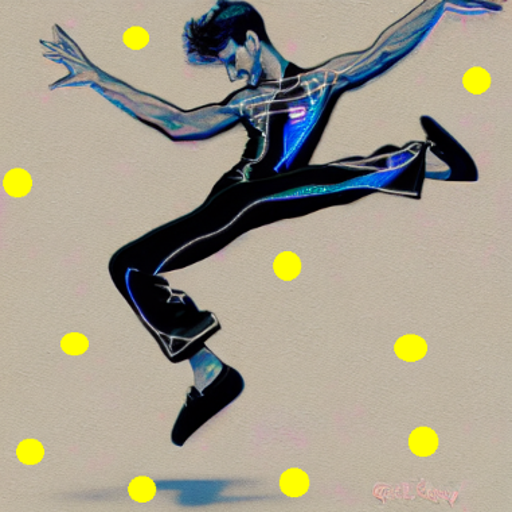

In [120]:
im
im = im.resize((512, 512))
im

1038


  0%|          | 0/64 [00:00<?, ?it/s]

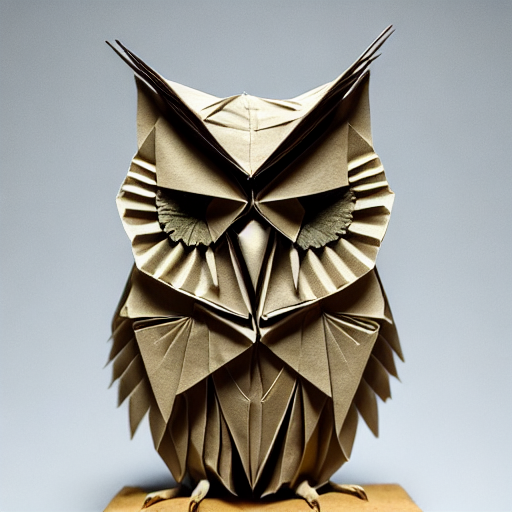

In [128]:
prompts_and_params = []
defaults =  {"seed": 1038, "num_inference_steps":60, "guidance_scale":10, "n":1}
prompts_and_params.append({
    "prompt": "An Owl made of origami, Origami, Highly detailed, Photograph, 4k, Vivid, intricate, highly detailed, centered, sharp focus"})

options = {**defaults, **prompts_and_params[-1]}
history.append(options)
images = multiple_generations(options)
#generator = torch.Generator("cuda").manual_seed(1025)
#with autocast("cuda"):
#  image = text_to_img(**options, generator=generator).images[0]

#image

In [129]:
history[-1]["stars"] = 4
history

[{'seed': 1026,
  'num_inference_steps': 40,
  'guidance_scale': 8,
  'prompt': 'photorealistic attractive girl, art by monet, sharp details, the girl is an amazingly cute zombie'},
 {'seed': 1026,
  'num_inference_steps': 40,
  'guidance_scale': 8,
  'prompt': 'photorealistic attractive girl, art by greg rutkowski, sharp details, the girl is an amazingly cute zombie'},
 {'seed': 1026,
  'num_inference_steps': 40,
  'guidance_scale': 8,
  'prompt': 'photorealistic attractive girl, art by greg rutkowski, sharp details, the girl is an amazingly cute zombie'},
 {'seed': 1026,
  'num_inference_steps': 40,
  'guidance_scale': 8,
  'prompt': 'photorealistic attractive girl, art by greg rutkowski, sharp details, the girl is an amazingly cute zombie'},
 {'seed': 1026,
  'num_inference_steps': 40,
  'guidance_scale': 8,
  'prompt': 'photorealistic attractive girl, art by greg rutkowski, sharp details, the girl is an amazingly cute zombie'},
 {'seed': 1026,
  'num_inference_steps': 40,
  'guidan

  0%|          | 0/25 [00:00<?, ?it/s]

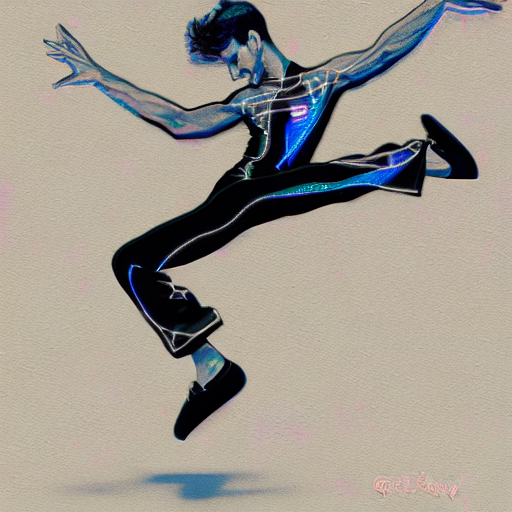

In [124]:
# improve by image to image
generator = torch.Generator(device=device).manual_seed(1024)
prompt = "fluorescent dancer greg rutkowsky"
with autocast("cuda"):
    image = img_to_img(prompt=prompt, init_image=images[0], strength=0.49, guidance_scale=20, generator=generator).images[0]
image

In [53]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 755 (delta 5), reused 15 (delta 5), pack-reused 735
Receiving objects: 100% (755/755), 5.37 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 7.8 MB/s 
     |████████████████████████████████| 5.9 MB 14.9 MB/s 
     |████████████████████████████████| 190 kB 70.4 MB/s 
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214841 sha256=a827f6163aee93413e59049201edb5df253dd40dd2de5b28f2f3470de88a22e3
  Stored in directory: /root/.cache/pip/wheels/2c/b3/4a/e2bc545f98417b6766ca50dd82b2a1f2b37780c68d41da9ca9
Successfully built basicsr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

In [54]:
import os
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

In [130]:
images[0].save("./upload/upload.png")

In [131]:
# if it is out of memory, try to use the `--tile` option
# We upsample the image with the scale factor X3.5
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 
# !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore. 

Testing 0 upload


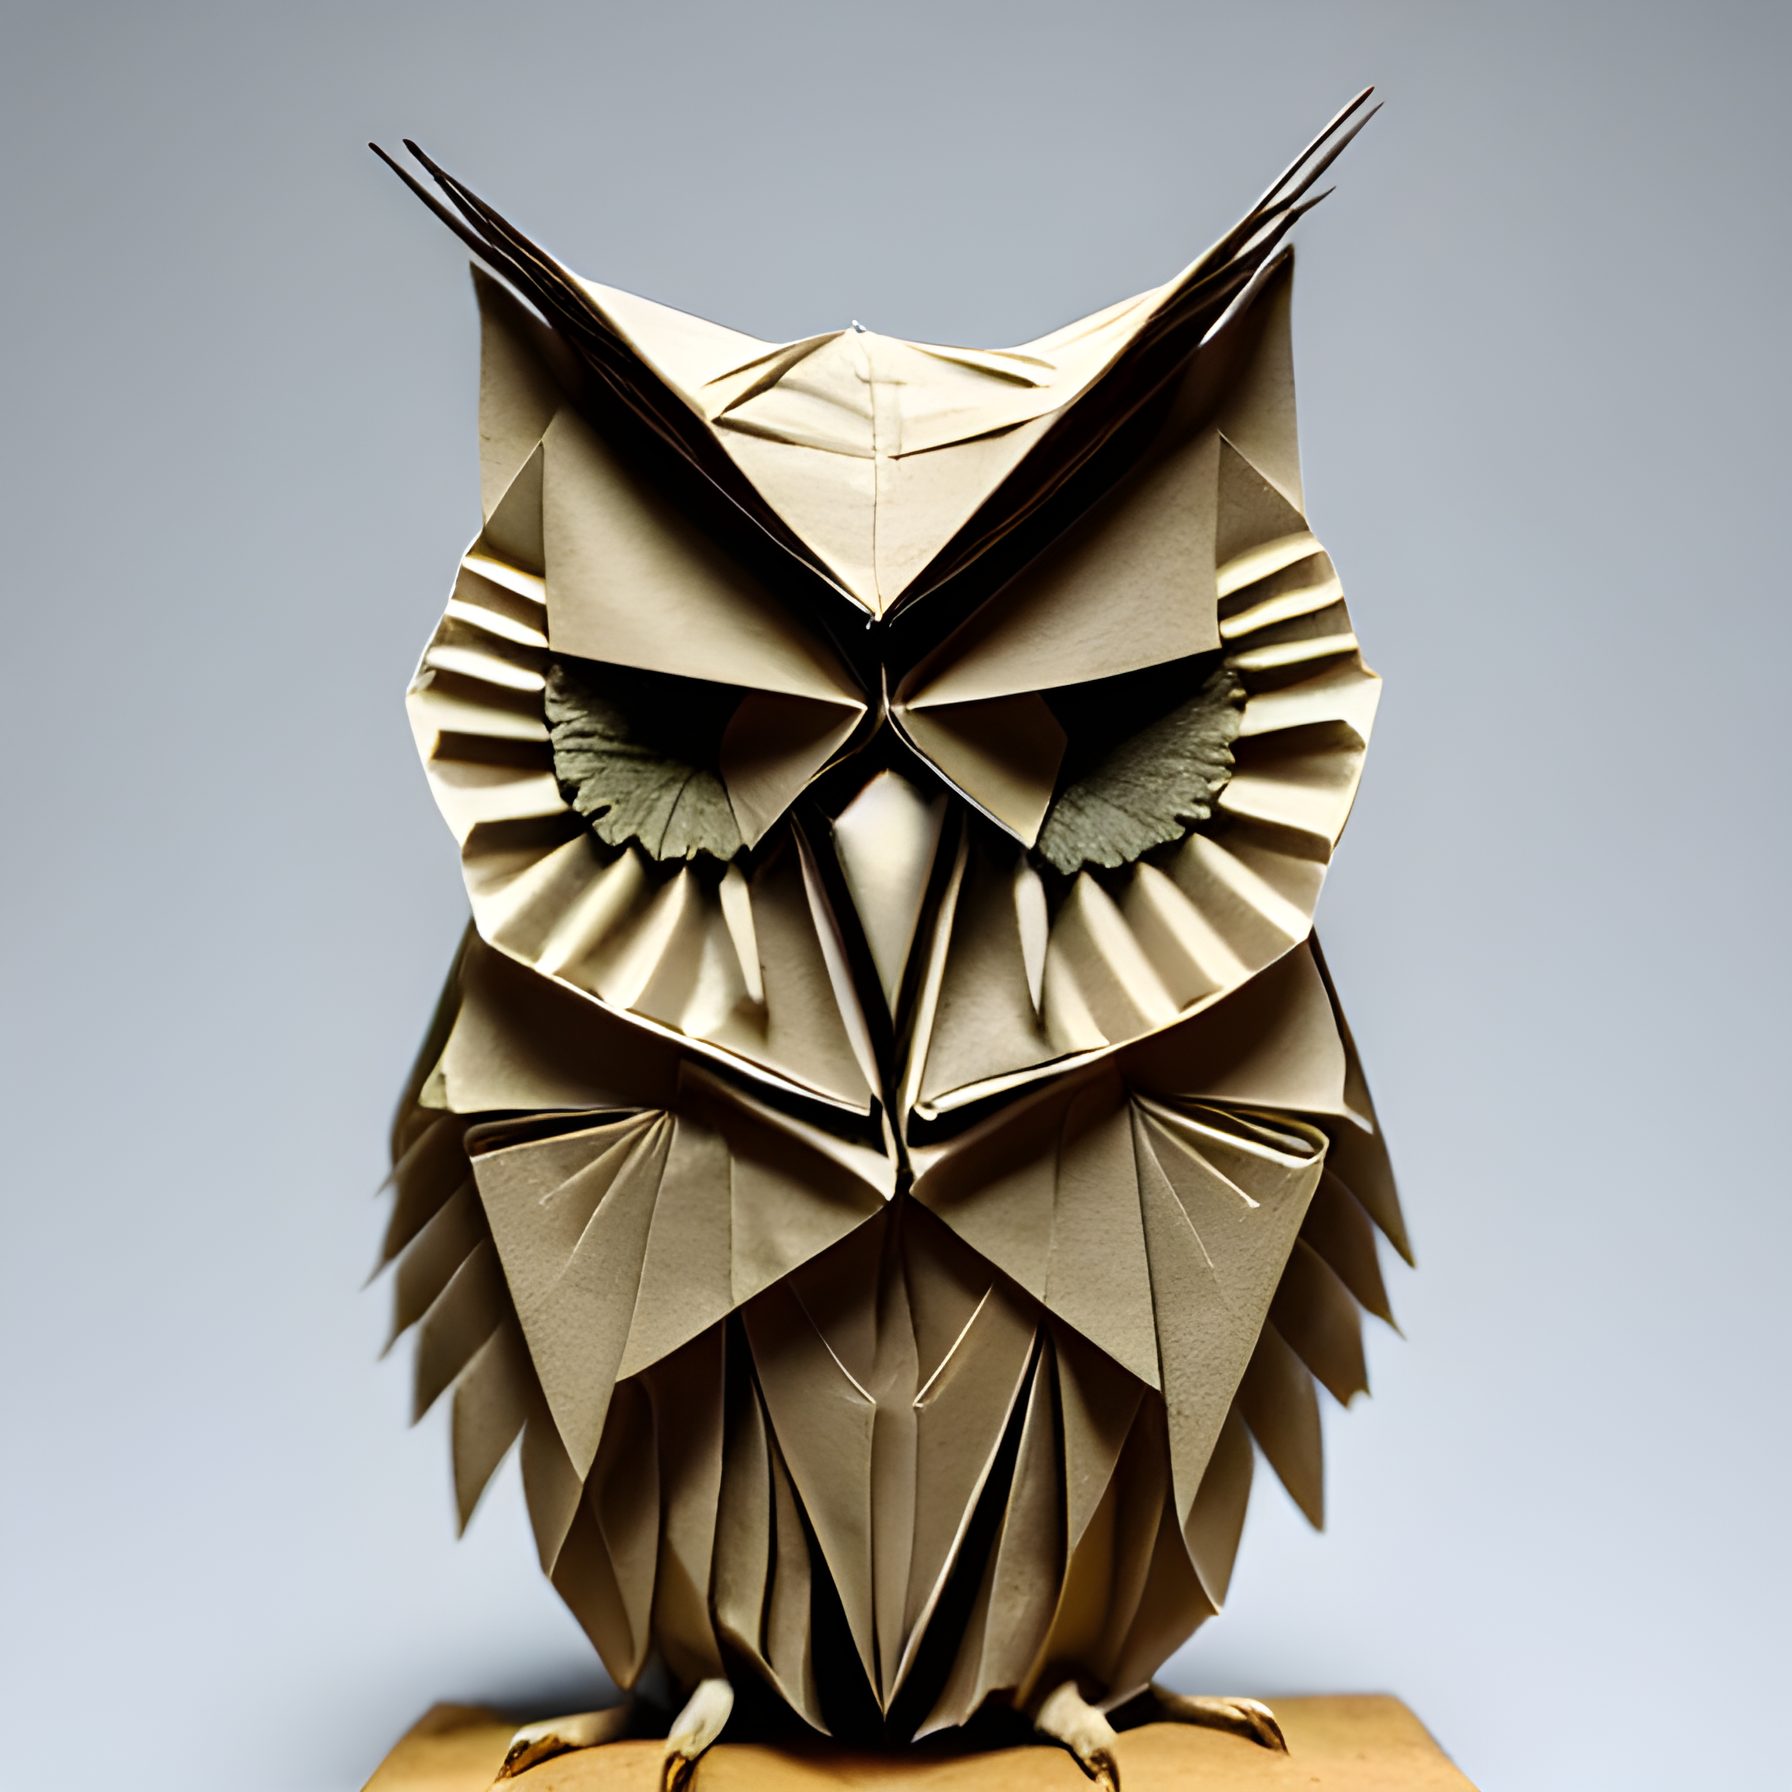

In [132]:
from PIL import Image 
im_upscaled = Image.open("./results/upload_out.png")
im_upscaled

In [ ]:


!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale 3.5 --face_enhance